# BIG CHALLENGE/DILEMMA

Twee opties:
1. We lezen de .net-bestanden (1 per sliding window) los in en runnen voor elk bestand een losse *graph partitioning* analyse
2. We voegen het eerst samen tot één graaf en doen slechts één analyse

voordelen 1:
- geen 'ketenen': het kan niet gebeuren dat een gebeurtenis uiteindelijk meerdere weken omvat, omdat er telkens weer een bruggetje is wat een cluster aansluit op het volgende

nadelen 1:
- een artikel kan bij meerdere events horen (laatste dag van een bestand = middenste dag van het volgende bestand); deze overlap is niet gewenst


--> het lijkt erop dat de bizar lange ketens (duizenden artikelen) vermeden kunnen worden door Surprise ipv Modularity te berekenen. "In short, surprise works well in the limit of many small communities, whereas modularity works better in the limit of few large communities."  (https://journals.aps.org/pre/abstract/10.1103/PhysRevE.92.022816)


--> OPGELOST!!! (denk ik) 
- optie 2
- maar dan met Surprise
- en zeer hoge drempel (minedgeweight = .6 of zo)

# TODO: softcosine en cosine systematisch vergelijken

# Detecting and analyzing news events

Damian Trilling and Marieke van Hoof


This Notebook contains the analysis of the similarity files created with the INCA-functions to calculate cosine and soft-cosine similarities.

In [226]:
import os
from glob import glob
import json
from tqdm import tqdm
import leidenalg
import igraph as ig
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles
import pandas as pd
import numpy as np
from sklearn.externals import joblib
%matplotlib inline

## Load/specify datasets

We need to load three datasets:

1. Nodes and edges for the softcosine-dataset
2. As a baseline for comparisons: nodes and edges for the traditional cosine dataset
3. The articles themselves (titles, texts, ...) to join with the first two datasets

In [77]:
softcosinefiles = glob('../../data/intermediate/softcosine/*.net')
cosinefiles = glob('../../data/intermediate/cosine/*.net')

print('There are {} softcosine and {} cosine files.'.format(len(softcosinefiles), len(cosinefiles)))

There are 149 softcosine and 149 cosine files.


In [78]:
# There are essentially two ways of going about combining all our files
# Either we merge them first and create ONE graph that we partition later,
# or we partition each file's graph seperately.
# The theoretical implication is that in the first scenario, the three-day
# moving window can be stretched (as something on the last day of a window
# can also be similar to sth in the 'new' window), in the latter scenario,
# that's not possible. 
# Empirical tests show that this stretching can lead to a drift over time,
# with large partitions that extend to multiple events. We therefore do 
# *not* do this in the final paper:

def merge_pajekfiles(files, outputfile):
    G = nx.Graph()
    for f in tqdm(files):
        H = nx.read_pajek(f)
        for node in H:         # remove all node properties, such as misleading/non-unique ids
            del H.node[node]['id']
            del H.node[node]['x']
            del H.node[node]['y']
            del H.node[node]['shape']
        G.update(H)
    print('{} nodes and {} edges'.format(len (G.nodes), len(G.edges)))
    print('Removing self loops...')
    G.remove_edges_from(list(G.selfloop_edges()))
    print('{} nodes and {} edges'.format(len (G.nodes), len(G.edges)))
    nx.write_pajek(G, outputfile)
    print('All written to {}'.format(outputfile))
    return G
Gnxsoft = merge_pajekfiles(softcosinefiles, '../../data/intermediate/softcosine_merged.net')
Gnxcos = merge_pajekfiles(cosinefiles, '../../data/intermediate/cosine_merged.net')
Gsoft = ig.read('../../data/intermediate/softcosine_merged.net', format='pajek')
Gcos = ig.read('../../data/intermediate/cosine_merged.net', format='pajek')





  0%|          | 0/149 [00:00<?, ?it/s]


  1%|          | 1/149 [00:01<03:00,  1.22s/it]


  1%|▏         | 2/149 [00:02<02:47,  1.14s/it]


  3%|▎         | 4/149 [00:04<02:44,  1.13s/it]


  3%|▎         | 5/149 [00:05<02:36,  1.09s/it]


  4%|▍         | 6/149 [00:06<02:31,  1.06s/it]


  5%|▍         | 7/149 [00:07<02:35,  1.10s/it]


  5%|▌         | 8/149 [00:08<02:36,  1.11s/it]


  6%|▌         | 9/149 [00:10<03:22,  1.44s/it]


  7%|▋         | 10/149 [00:12<03:11,  1.38s/it]


  7%|▋         | 11/149 [00:14<03:38,  1.59s/it]


  8%|▊         | 12/149 [00:16<03:58,  1.74s/it]


  9%|▊         | 13/149 [00:17<03:15,  1.44s/it]


  9%|▉         | 14/149 [00:17<02:51,  1.27s/it]


 10%|█         | 15/149 [00:19<03:13,  1.44s/it]


 11%|█         | 16/149 [00:20<02:34,  1.16s/it]


 11%|█▏        | 17/149 [00:21<02:31,  1.15s/it]


 12%|█▏        | 18/149 [00:23<03:02,  1.40s/it]


 13%|█▎        | 19/149 [00:24<02:59,  1.38s/it]


 13%|█▎        | 20/149 [00:25<02:51,  1.33s/

 93%|█████████▎| 139/149 [02:57<00:12,  1.27s/it]


 94%|█████████▍| 140/149 [02:58<00:11,  1.27s/it]


 95%|█████████▍| 141/149 [03:00<00:12,  1.52s/it]


 95%|█████████▌| 142/149 [03:01<00:09,  1.34s/it]


 96%|█████████▌| 143/149 [03:03<00:08,  1.47s/it]


 97%|█████████▋| 144/149 [03:04<00:06,  1.25s/it]


 97%|█████████▋| 145/149 [03:04<00:04,  1.11s/it]


 98%|█████████▊| 146/149 [03:05<00:02,  1.10it/s]


 99%|█████████▊| 147/149 [03:07<00:02,  1.24s/it]


 99%|█████████▉| 148/149 [03:08<00:01,  1.08s/it]


100%|██████████| 149/149 [03:08<00:00,  1.01s/it]

45608 nodes and 935592 edges
Removing self loops...
45608 nodes and 890597 edges
All written to ../../data/intermediate/softcosine_merged.net





  0%|          | 0/149 [00:00<?, ?it/s]


  1%|          | 1/149 [00:00<00:38,  3.87it/s]


  2%|▏         | 3/149 [00:00<00:31,  4.62it/s]


  3%|▎         | 4/149 [00:00<00:32,  4.44it/s]


  3%|▎         | 5/149 [00:00<00:33,  4.33it/s]


  4%|▍         | 6/149 [00:01<00:34,  4.20it/s]


  5%|▍         | 7/149 [00:01<00:36,  3.87it/s]


  5%|▌         | 8/149 [00:01<00:40,  3.47it/s]


  6%|▌         | 9/149 [00:02<00:48,  2.86it/s]


  7%|▋         | 10/149 [00:02<00:55,  2.51it/s]


  7%|▋         | 11/149 [00:03<00:47,  2.93it/s]


  8%|▊         | 12/149 [00:03<00:41,  3.27it/s]


  9%|▊         | 13/149 [00:03<00:41,  3.30it/s]


  9%|▉         | 14/149 [00:03<00:37,  3.57it/s]


 10%|█         | 15/149 [00:04<00:34,  3.85it/s]


 11%|█         | 16/149 [00:04<00:35,  3.73it/s]


 11%|█▏        | 17/149 [00:04<00:40,  3.27it/s]


 12%|█▏        | 18/149 [00:05<00:56,  2.30it/s]


 13%|█▎        | 19/149 [00:05<00:58,  2.20it/s]


 13%|█▎        | 20/149 [00:06<00:52,  2.48it

 95%|█████████▌| 142/149 [00:44<00:01,  3.77it/s]


 96%|█████████▌| 143/149 [00:44<00:01,  4.04it/s]


 97%|█████████▋| 144/149 [00:44<00:01,  4.30it/s]


 97%|█████████▋| 145/149 [00:44<00:01,  3.96it/s]


 98%|█████████▊| 146/149 [00:45<00:00,  3.92it/s]


 99%|█████████▊| 147/149 [00:45<00:00,  4.01it/s]


100%|██████████| 149/149 [00:45<00:00,  5.21it/s]

45213 nodes and 109336 edges
Removing self loops...
45213 nodes and 64341 edges
All written to ../../data/intermediate/cosine_merged.net


In [79]:
with open('../../data/raw-private/articles/articles_as_json-lines.json', mode='r') as f:
    articles = pd.DataFrame((json.loads(l) for l in f))
print(articles.keys())
print('{} articles in total'.format(len(articles)))

Index(['_id', 'byline', 'category', 'doctype', 'feedurl', 'images',
       'paywall_na', 'publication_date', 'softcosine_processed', 'teaser',
       'teaser_rss', 'text', 'title', 'title_rss', 'url'],
      dtype='object')
45609 articles in total


## Define functions
Here, we define functions to transform the files to a graph, partition the graph, analyze it, etc.

In [80]:
def partition_graph(G0, minedgeweight):
    '''takes an igraph, prunes it and particions it. returns a list of partitions '''
    G = G0.copy()
    G.es.select(weight_le=minedgeweight).delete()
    # part = leidenalg.find_partition(G, leidenalg.ModularityVertexPartition)
    part = leidenalg.find_partition(G, leidenalg.SurpriseVertexPartition)
    # print(part.summary())
    partitions = []
    for subgraph in part.subgraphs():
         partitions.append([node['id'] for node in subgraph.vs])
    return partitions

In [81]:
# this may be buggy. I believe we need to FIRST merge the graphs, then do the partitioing,
# because otherwise the same article can end up in multiple events

def analyze_files_BAD(files, minedgeweight=.2):
    '''Reads a list of graph files, passes them to partition_graph(), and concatenats the results'''
    G = ig.Graph()
    results = []
    for f in tqdm(files):
        Gi = ig.read(f, format='pajek')
        try:
            results.extend(partition_graph(Gi, minedgeweight))
        except Exception as e:
            print('Error while trying to process edge weights in file {}'.format(f))
            print(e)
    return results

In [82]:
def show_descriptives(results):
    '''takes a list of lists (articles per event), plots a histogram and prints descriptives'''
    articles_per_event = [len(x) for x in results]
    single_article_events = sum([1 if e==1 else 0 for e in articles_per_event])
    multiple_article_events = len(articles_per_event) - single_article_events
    fig = plt.figure(figsize=(10,5))
    plt.hist(articles_per_event, bins = max(articles_per_event), log=True)
    plt.show()
    print(pd.Series(articles_per_event).describe())
    print('\nThere are {} single-article events and {} multiple-article events.'.format(
        single_article_events, multiple_article_events))

In [83]:
def print_gridreport(gridresults):
    for r in gridresults:
        l = r['results']
        flattened = [item for sublist in l for item in sublist]

        print('Found {} articles, out of which {} are unique articles'.format(len(flattened), len(set(flattened))))
    print('(hint: if *not* all articles are unique, then articles are assigned to multiple events)')
    print('\n\n')

    for r in gridresults:
        print("*"*80)
        print('Similarity metric: {}\n Minimum edgeweight: {}\n'.format(r['similarity'], r['minedgeweight']))
        print("*"*80)
        show_descriptives(r['results'])
        print('\n\n\n')

## Conduct clustering

We now conduct the clustering. We use a grid in which we vary the similarity calculation (cosine vs softcosine) and the minimum edgeweight threshold (.2, .3, .4)

### Option 1: Losse bestanden

In [84]:
op1_grid = [('cos', cosinefiles, .2),
        ('cos', cosinefiles, .3),
        ('cos', cosinefiles, .4),
        ('cos', cosinefiles, .5),
        ('cos', cosinefiles, .6),
        ('softcos', softcosinefiles, .2),
        ('softcos', softcosinefiles, .3),
        ('softcos', softcosinefiles, .4),
        ('softcos', softcosinefiles, .5),
        ('softcos', softcosinefiles, .6)]

op1_gridresults = [{'similarity':similarity, 'minedgeweight': minedgeweight, 'results': analyze_files_BAD(files, minedgeweight)} 
              for similarity, files, minedgeweight in op1_grid]






  0%|          | 0/149 [00:00<?, ?it/s]


  1%|          | 1/149 [00:00<00:29,  5.07it/s]


  3%|▎         | 4/149 [00:00<00:21,  6.61it/s]


  4%|▍         | 6/149 [00:00<00:18,  7.54it/s]


  5%|▍         | 7/149 [00:00<00:19,  7.46it/s]


  6%|▌         | 9/149 [00:00<00:17,  8.11it/s]


  7%|▋         | 10/149 [00:00<00:16,  8.20it/s]


  7%|▋         | 11/149 [00:01<00:20,  6.84it/s]


  8%|▊         | 12/149 [00:01<00:20,  6.54it/s]


  9%|▊         | 13/149 [00:01<00:21,  6.23it/s]


  9%|▉         | 14/149 [00:01<00:20,  6.58it/s]


 10%|█         | 15/149 [00:01<00:20,  6.69it/s]


 11%|█         | 16/149 [00:01<00:20,  6.50it/s]


 11%|█▏        | 17/149 [00:02<00:18,  6.95it/s]


 13%|█▎        | 19/149 [00:02<00:16,  8.10it/s]


 14%|█▍        | 21/149 [00:02<00:13,  9.48it/s]


 15%|█▌        | 23/149 [00:02<00:12, 10.38it/s]


 17%|█▋        | 25/149 [00:02<00:11, 11.25it/s]


 19%|█▉        | 28/149 [00:02<00:09, 12.96it/s]


 20%|██        | 30/149 [00:02<00:08, 13.4

  7%|▋         | 10/149 [00:00<00:04, 29.62it/s]


  8%|▊         | 12/149 [00:00<00:06, 19.86it/s]


  9%|▉         | 14/149 [00:00<00:08, 15.85it/s]


 11%|█         | 16/149 [00:00<00:10, 12.81it/s]


 12%|█▏        | 18/149 [00:01<00:11, 11.74it/s]


 13%|█▎        | 20/149 [00:01<00:11, 11.68it/s]


 15%|█▍        | 22/149 [00:01<00:11, 11.39it/s]


 16%|█▌        | 24/149 [00:01<00:10, 11.64it/s]


 17%|█▋        | 26/149 [00:01<00:09, 12.76it/s]


 19%|█▉        | 28/149 [00:01<00:09, 12.91it/s]


 21%|██        | 31/149 [00:02<00:07, 15.54it/s]


 24%|██▍       | 36/149 [00:02<00:05, 19.32it/s]


 27%|██▋       | 40/149 [00:02<00:04, 22.87it/s]


 30%|██▉       | 44/149 [00:02<00:04, 26.19it/s]


 32%|███▏      | 48/149 [00:02<00:03, 27.31it/s]


 35%|███▍      | 52/149 [00:02<00:03, 28.16it/s]


 38%|███▊      | 56/149 [00:02<00:03, 30.15it/s]


 40%|████      | 60/149 [00:02<00:02, 31.32it/s]


 43%|████▎     | 64/149 [00:02<00:02, 32.45it/s]


 46%|████▌     | 68/149 [00:03<

 43%|████▎     | 64/149 [00:11<00:24,  3.52it/s]


 44%|████▎     | 65/149 [00:11<00:21,  3.93it/s]


 44%|████▍     | 66/149 [00:11<00:20,  4.05it/s]


 45%|████▍     | 67/149 [00:12<00:19,  4.13it/s]


 46%|████▌     | 68/149 [00:12<00:16,  4.81it/s]


 46%|████▋     | 69/149 [00:12<00:14,  5.48it/s]


 48%|████▊     | 71/149 [00:12<00:12,  6.38it/s]


 48%|████▊     | 72/149 [00:12<00:12,  6.27it/s]


 49%|████▉     | 73/149 [00:12<00:10,  7.01it/s]


 50%|████▉     | 74/149 [00:13<00:11,  6.61it/s]


 50%|█████     | 75/149 [00:13<00:10,  6.86it/s]


 52%|█████▏    | 77/149 [00:13<00:09,  7.87it/s]


 52%|█████▏    | 78/149 [00:13<00:09,  7.45it/s]


 54%|█████▎    | 80/149 [00:13<00:09,  7.65it/s]


 54%|█████▍    | 81/149 [00:13<00:10,  6.25it/s]


 55%|█████▌    | 82/149 [00:14<00:09,  6.78it/s]


 56%|█████▌    | 83/149 [00:14<00:10,  6.49it/s]


 56%|█████▋    | 84/149 [00:14<00:09,  7.04it/s]


 57%|█████▋    | 85/149 [00:14<00:08,  7.58it/s]


 58%|█████▊    | 86/149 [00:14<

 64%|██████▍   | 96/149 [00:10<00:04, 10.88it/s]


 66%|██████▌   | 98/149 [00:10<00:04, 11.59it/s]


 67%|██████▋   | 100/149 [00:11<00:03, 12.87it/s]


 68%|██████▊   | 102/149 [00:11<00:04, 10.51it/s]


 70%|██████▉   | 104/149 [00:11<00:05,  8.09it/s]


 71%|███████   | 106/149 [00:12<00:05,  7.82it/s]


 72%|███████▏  | 107/149 [00:12<00:06,  6.73it/s]


 72%|███████▏  | 108/149 [00:12<00:07,  5.44it/s]


 73%|███████▎  | 109/149 [00:12<00:07,  5.27it/s]


 74%|███████▍  | 110/149 [00:12<00:06,  5.83it/s]


 75%|███████▌  | 112/149 [00:12<00:05,  7.29it/s]


 77%|███████▋  | 114/149 [00:13<00:04,  8.51it/s]


 78%|███████▊  | 116/149 [00:13<00:03,  9.40it/s]


 79%|███████▉  | 118/149 [00:13<00:03,  9.52it/s]


 81%|████████  | 120/149 [00:13<00:02,  9.91it/s]


 82%|████████▏ | 122/149 [00:13<00:02, 10.62it/s]


 83%|████████▎ | 124/149 [00:13<00:02, 10.83it/s]


 85%|████████▍ | 126/149 [00:14<00:02, 11.27it/s]


 86%|████████▌ | 128/149 [00:14<00:01, 11.32it/s]


 87%|████████▋

 16%|█▌        | 24/149 [00:02<00:21,  5.90it/s]


 17%|█▋        | 25/149 [00:02<00:20,  6.00it/s]


 17%|█▋        | 26/149 [00:02<00:21,  5.80it/s]


 19%|█▉        | 28/149 [00:02<00:16,  7.21it/s]


 21%|██        | 31/149 [00:03<00:13,  8.79it/s]


 22%|██▏       | 33/149 [00:06<01:05,  1.77it/s]


 23%|██▎       | 35/149 [00:06<00:47,  2.39it/s]


 25%|██▍       | 37/149 [00:06<00:34,  3.21it/s]


 27%|██▋       | 40/149 [00:06<00:24,  4.36it/s]


 28%|██▊       | 42/149 [00:06<00:19,  5.56it/s]


 30%|██▉       | 44/149 [00:06<00:15,  6.84it/s]


 31%|███       | 46/149 [00:07<00:12,  8.29it/s]


 32%|███▏      | 48/149 [00:07<00:10,  9.24it/s]


 34%|███▎      | 50/149 [00:07<00:09, 10.73it/s]


 35%|███▍      | 52/149 [00:07<00:08, 11.45it/s]


 36%|███▌      | 54/149 [00:07<00:09, 10.35it/s]


 38%|███▊      | 56/149 [00:07<00:09,  9.72it/s]


 39%|███▉      | 58/149 [00:08<00:09,  9.10it/s]


 40%|████      | 60/149 [00:08<00:11,  8.06it/s]


 41%|████      | 61/149 [00:08<

Found 62954 articles, out of which 45213 are unique articles
Found 62954 articles, out of which 45213 are unique articles
Found 62954 articles, out of which 45213 are unique articles
Found 62954 articles, out of which 45213 are unique articles
Found 111828 articles, out of which 45608 are unique articles
Found 111828 articles, out of which 45608 are unique articles
Found 111828 articles, out of which 45608 are unique articles
Found 111828 articles, out of which 45608 are unique articles
(hint: if *not* all articles are unique, then articles are assigned to multiple events)



********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.2

********************************************************************************


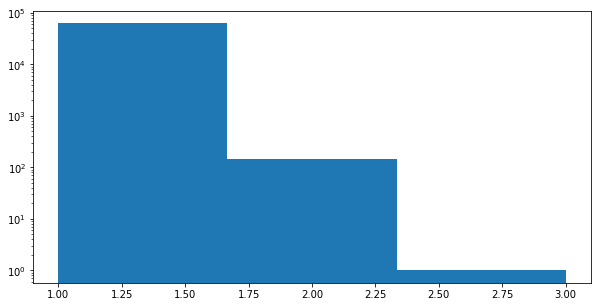

count    62806.000000
mean     1.002356    
std      0.048814    
min      1.000000    
25%      1.000000    
50%      1.000000    
75%      1.000000    
max      3.000000    
dtype: float64

There are 62659 single-article events and 147 multiple-article events.




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.3

********************************************************************************


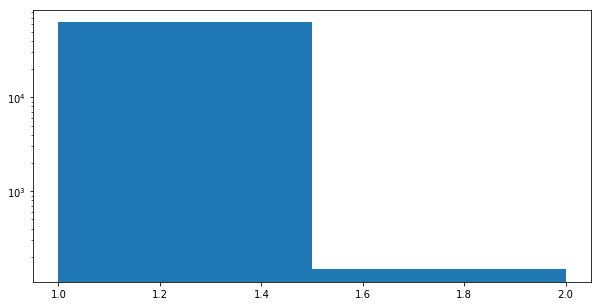

count    62807.000000
mean     1.002341    
std      0.048322    
min      1.000000    
25%      1.000000    
50%      1.000000    
75%      1.000000    
max      2.000000    
dtype: float64

There are 62660 single-article events and 147 multiple-article events.




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.4

********************************************************************************


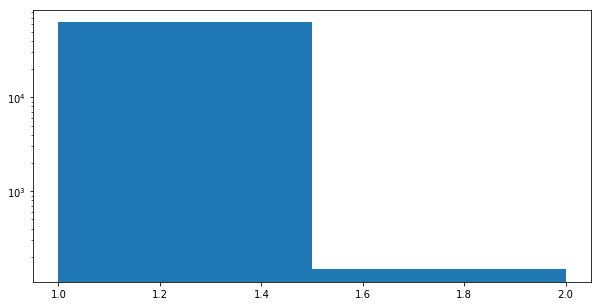

count    62807.000000
mean     1.002341    
std      0.048322    
min      1.000000    
25%      1.000000    
50%      1.000000    
75%      1.000000    
max      2.000000    
dtype: float64

There are 62660 single-article events and 147 multiple-article events.




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.6

********************************************************************************


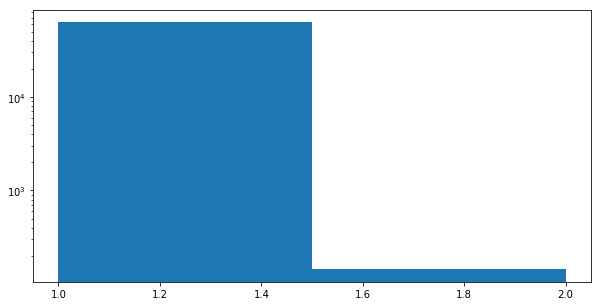

count    62811.000000
mean     1.002277    
std      0.047661    
min      1.000000    
25%      1.000000    
50%      1.000000    
75%      1.000000    
max      2.000000    
dtype: float64

There are 62668 single-article events and 143 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.2

********************************************************************************


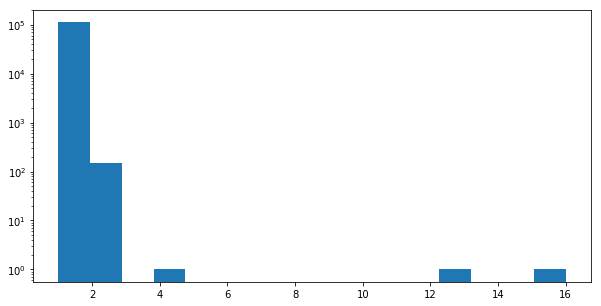

count    111651.000000
mean     1.001585     
std      0.068554     
min      1.000000     
25%      1.000000     
50%      1.000000     
75%      1.000000     
max      16.000000    
dtype: float64

There are 111501 single-article events and 150 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.3

********************************************************************************


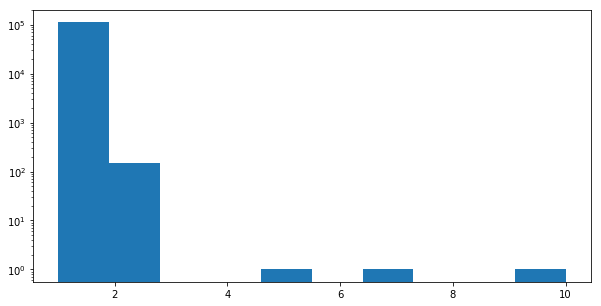

count    111660.000000
mean     1.001505     
std      0.050232     
min      1.000000     
25%      1.000000     
50%      1.000000     
75%      1.000000     
max      10.000000    
dtype: float64

There are 111508 single-article events and 152 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.4

********************************************************************************


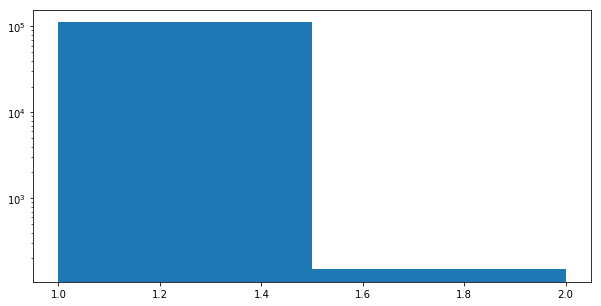

count    111679.000000
mean     1.001334     
std      0.036502     
min      1.000000     
25%      1.000000     
50%      1.000000     
75%      1.000000     
max      2.000000     
dtype: float64

There are 111530 single-article events and 149 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.6

********************************************************************************


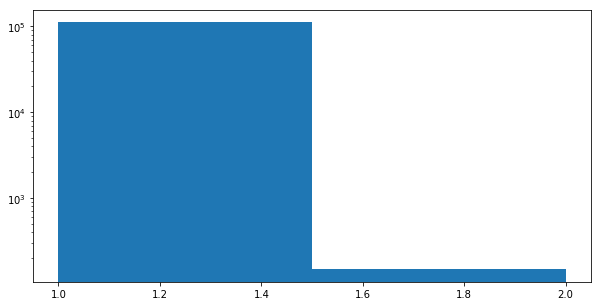

count    111681.000000
mean     1.001316     
std      0.036256     
min      1.000000     
25%      1.000000     
50%      1.000000     
75%      1.000000     
max      2.000000     
dtype: float64

There are 111534 single-article events and 147 multiple-article events.






In [85]:
print_gridreport(op1_gridresults)

### Option 2: Een graaf

In [86]:

op2_grid = [('cos', Gcos, .2),
        ('cos', Gcos, .3),
        ('cos', Gcos, .4),
        ('cos', Gcos, .5),
        ('cos', Gcos, .6),
        ('softcos', Gsoft, .2),
        ('softcos', Gsoft, .3),
        ('softcos', Gsoft, .4),
        ('softcos', Gsoft, .5),
        ('softcos', Gsoft, .6)]

op2_gridresults = [{'similarity':similarity, 'minedgeweight': minedgeweight, 'results': partition_graph(G, minedgeweight)} 
              for similarity, G, minedgeweight in tqdm(op2_grid)]






  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:07<01:08,  7.63s/it]


 20%|██        | 2/10 [00:14<00:58,  7.30s/it]


 30%|███       | 3/10 [00:23<00:56,  8.02s/it]


 40%|████      | 4/10 [00:32<00:48,  8.06s/it]


 50%|█████     | 5/10 [00:39<00:39,  7.97s/it]


 60%|██████    | 6/10 [00:48<00:32,  8.06s/it]


 70%|███████   | 7/10 [00:55<00:23,  7.84s/it]


 80%|████████  | 8/10 [01:02<00:15,  7.59s/it]


 90%|█████████ | 9/10 [01:13<00:08,  8.76s/it]


100%|██████████| 10/10 [01:23<00:00,  9.00s/it]

Found 45213 articles, out of which 45213 are unique articles
Found 45213 articles, out of which 45213 are unique articles
Found 45213 articles, out of which 45213 are unique articles
Found 45213 articles, out of which 45213 are unique articles
Found 45213 articles, out of which 45213 are unique articles
Found 45608 articles, out of which 45608 are unique articles
Found 45608 articles, out of which 45608 are unique articles
Found 45608 articles, out of which 45608 are unique articles
Found 45608 articles, out of which 45608 are unique articles
Found 45608 articles, out of which 45608 are unique articles
(hint: if *not* all articles are unique, then articles are assigned to multiple events)



********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.2

********************************************************************************


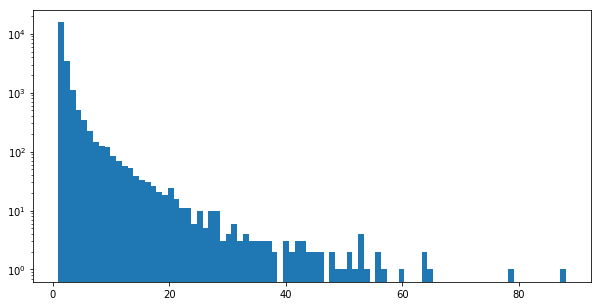

count    22311.000000
mean     2.026489    
std      3.480543    
min      1.000000    
25%      1.000000    
50%      1.000000    
75%      2.000000    
max      88.000000   
dtype: float64

There are 15626 single-article events and 6685 multiple-article events.




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.3

********************************************************************************


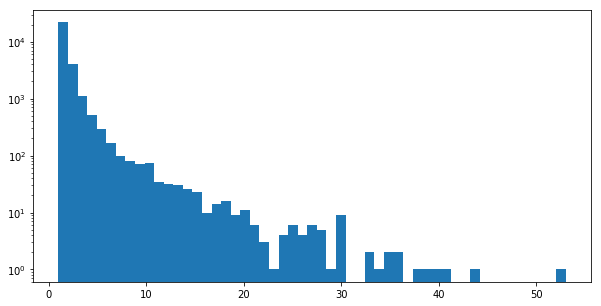

count    28631.000000
mean     1.579162    
std      2.003022    
min      1.000000    
25%      1.000000    
50%      1.000000    
75%      1.000000    
max      53.000000   
dtype: float64

There are 21854 single-article events and 6777 multiple-article events.




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.4

********************************************************************************


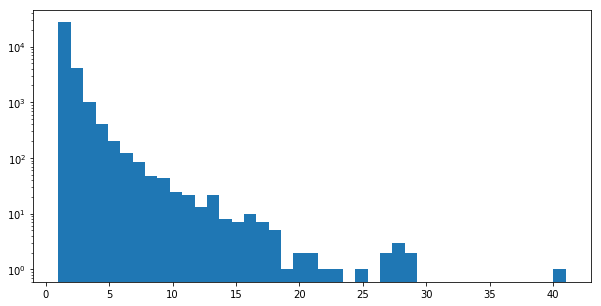

count    33376.000000
mean     1.354656    
std      1.216921    
min      1.000000    
25%      1.000000    
50%      1.000000    
75%      1.000000    
max      41.000000   
dtype: float64

There are 27135 single-article events and 6241 multiple-article events.




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.5

********************************************************************************


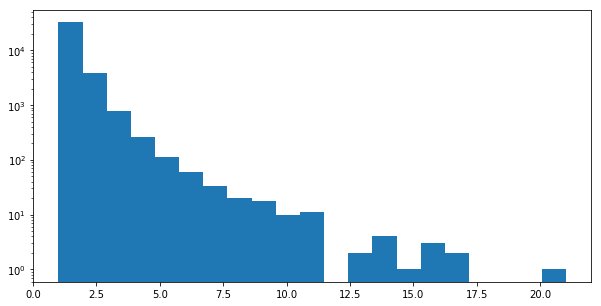

count    37397.000000
mean     1.209001    
std      0.713403    
min      1.000000    
25%      1.000000    
50%      1.000000    
75%      1.000000    
max      21.000000   
dtype: float64

There are 32232 single-article events and 5165 multiple-article events.




********************************************************************************
Similarity metric: cos
 Minimum edgeweight: 0.6

********************************************************************************


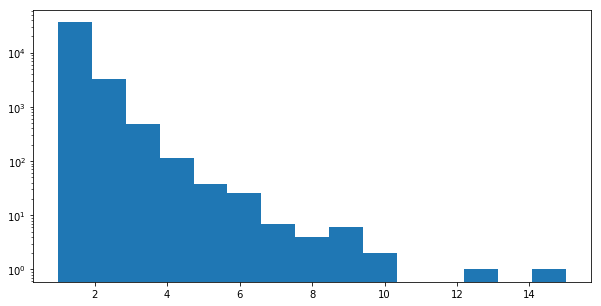

count    40247.000000
mean     1.123388    
std      0.449985    
min      1.000000    
25%      1.000000    
50%      1.000000    
75%      1.000000    
max      15.000000   
dtype: float64

There are 36348 single-article events and 3899 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.2

********************************************************************************


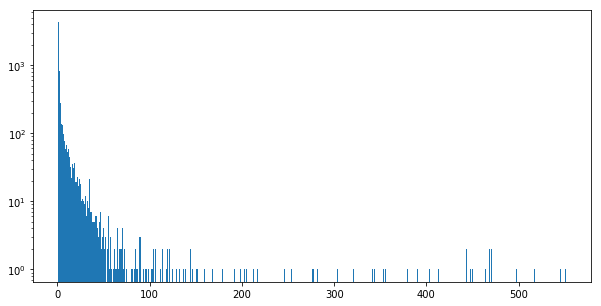

count    6722.000000
mean     6.784885   
std      30.405001  
min      1.000000   
25%      1.000000   
50%      1.000000   
75%      2.000000   
max      551.000000 
dtype: float64

There are 4262 single-article events and 2460 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.3

********************************************************************************


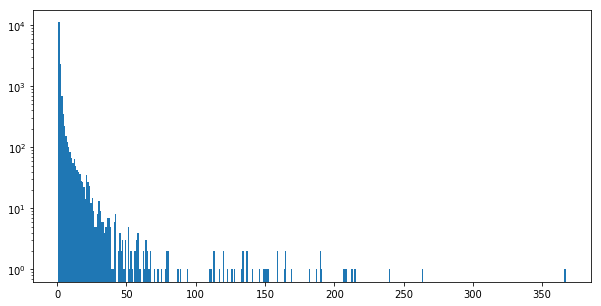

count    15779.000000
mean     2.890424    
std      10.042928   
min      1.000000    
25%      1.000000    
50%      1.000000    
75%      2.000000    
max      367.000000  
dtype: float64

There are 11043 single-article events and 4736 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.4

********************************************************************************


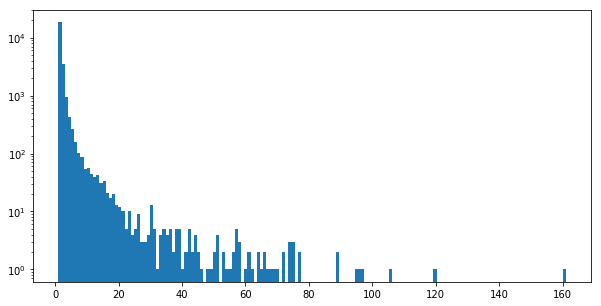

count    24266.000000
mean     1.879502    
std      4.265656    
min      1.000000    
25%      1.000000    
50%      1.000000    
75%      1.000000    
max      161.000000  
dtype: float64

There are 18305 single-article events and 5961 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.5

********************************************************************************


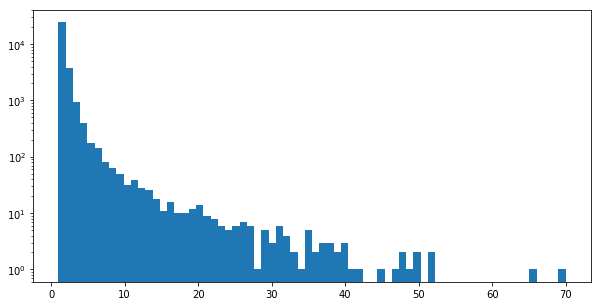

count    30277.000000
mean     1.506358    
std      2.272435    
min      1.000000    
25%      1.000000    
50%      1.000000    
75%      1.000000    
max      70.000000   
dtype: float64

There are 24337 single-article events and 5940 multiple-article events.




********************************************************************************
Similarity metric: softcos
 Minimum edgeweight: 0.6

********************************************************************************


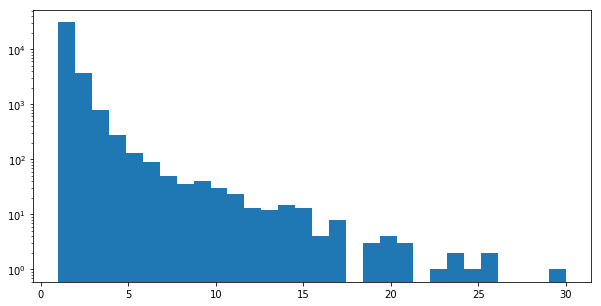

count    35957.000000
mean     1.268404    
std      1.067822    
min      1.000000    
25%      1.000000    
50%      1.000000    
75%      1.000000    
max      30.000000   
dtype: float64

There are 30700 single-article events and 5257 multiple-article events.






In [87]:
print_gridreport(op2_gridresults)

In [13]:
# gridresults[4]['results'][3]

## Evaluation of the results

check how much sense it makes etc

In [88]:
def merge_results_with_articles(results):
    results_merged = [[articles.query('_id=="{}"'.format(art)) for art in event] for event in tqdm(results)]
    df = pd.DataFrame(results_merged)
    return df

def _getfield(x, field):
    try:
        return x[field].to_list()[0]
    except:
        return None
def reduce_to_field(merged_df, field):
    return merged_df.applymap(lambda x: _getfield(x, field))

In [89]:
df_cos04 = merge_results_with_articles(op2_gridresults[2]['results'])
df_cos05 = merge_results_with_articles(op2_gridresults[3]['results'])
df_cos06 = merge_results_with_articles(op2_gridresults[4]['results'])
df_softcos04 = merge_results_with_articles(op2_gridresults[7]['results'])
df_softcos05 = merge_results_with_articles(op2_gridresults[8]['results'])
df_softcos06 = merge_results_with_articles(op2_gridresults[9]['results'])




  0%|          | 0/33376 [00:00<?, ?it/s]


  0%|          | 1/33376 [00:00<3:28:13,  2.67it/s]


  0%|          | 2/33376 [00:00<3:25:51,  2.70it/s]


  0%|          | 3/33376 [00:00<3:05:06,  3.00it/s]


  0%|          | 4/33376 [00:01<2:58:28,  3.12it/s]


  0%|          | 5/33376 [00:01<3:21:23,  2.76it/s]


  0%|          | 6/33376 [00:02<4:06:46,  2.25it/s]


  0%|          | 7/33376 [00:02<4:28:04,  2.07it/s]


  0%|          | 8/33376 [00:03<3:59:36,  2.32it/s]


  0%|          | 9/33376 [00:03<3:35:10,  2.58it/s]


  0%|          | 10/33376 [00:03<3:22:16,  2.75it/s]


  0%|          | 11/33376 [00:04<3:06:06,  2.99it/s]


  0%|          | 12/33376 [00:04<2:41:44,  3.44it/s]


  0%|          | 13/33376 [00:04<2:24:36,  3.85it/s]


  0%|          | 14/33376 [00:04<2:27:36,  3.77it/s]


  0%|          | 15/33376 [00:05<2:29:48,  3.71it/s]


  0%|          | 16/33376 [00:05<2:12:51,  4.19it/s]


  0%|          | 17/33376 [00:05<2:03:38,  4.50it/s]


  0%|          | 18/33376 [

  0%|          | 134/33376 [00:26<1:00:59,  9.08it/s]


  0%|          | 135/33376 [00:27<1:00:40,  9.13it/s]


  0%|          | 137/33376 [00:27<55:24, 10.00it/s]  


  0%|          | 139/33376 [00:27<51:34, 10.74it/s]


  0%|          | 141/33376 [00:27<49:16, 11.24it/s]


  0%|          | 143/33376 [00:27<47:47, 11.59it/s]


  0%|          | 145/33376 [00:27<47:15, 11.72it/s]


  0%|          | 147/33376 [00:27<45:52, 12.07it/s]


  0%|          | 149/33376 [00:28<44:45, 12.37it/s]


  0%|          | 151/33376 [00:28<46:17, 11.96it/s]


  0%|          | 153/33376 [00:28<45:04, 12.29it/s]


  0%|          | 155/33376 [00:28<45:01, 12.30it/s]


  0%|          | 157/33376 [00:28<45:05, 12.28it/s]


  0%|          | 159/33376 [00:28<44:16, 12.50it/s]


  0%|          | 161/33376 [00:29<44:09, 12.54it/s]


  0%|          | 163/33376 [00:29<46:04, 12.01it/s]


  0%|          | 165/33376 [00:29<59:15,  9.34it/s]


  1%|          | 167/33376 [00:29<1:08:33,  8.07it/s]


  1%|          | 168

  1%|          | 344/33376 [00:49<1:21:34,  6.75it/s]


  1%|          | 345/33376 [00:49<1:24:52,  6.49it/s]


  1%|          | 347/33376 [00:49<1:10:31,  7.81it/s]


  1%|          | 349/33376 [00:49<58:42,  9.37it/s]  


  1%|          | 351/33376 [00:49<50:43, 10.85it/s]


  1%|          | 353/33376 [00:49<44:59, 12.23it/s]


  1%|          | 355/33376 [00:49<42:17, 13.01it/s]


  1%|          | 357/33376 [00:50<39:15, 14.02it/s]


  1%|          | 359/33376 [00:50<36:21, 15.13it/s]


  1%|          | 361/33376 [00:50<34:45, 15.83it/s]


  1%|          | 363/33376 [00:50<34:55, 15.75it/s]


  1%|          | 365/33376 [00:50<33:39, 16.35it/s]


  1%|          | 367/33376 [00:50<32:30, 16.92it/s]


  1%|          | 369/33376 [00:50<32:33, 16.89it/s]


  1%|          | 371/33376 [00:50<32:33, 16.89it/s]


  1%|          | 373/33376 [00:50<32:20, 17.01it/s]


  1%|          | 375/33376 [00:51<32:53, 16.73it/s]


  1%|          | 377/33376 [00:51<31:57, 17.21it/s]


  1%|          | 379

  2%|▏         | 608/33376 [01:07<1:18:10,  6.99it/s]


  2%|▏         | 609/33376 [01:07<1:21:34,  6.69it/s]


  2%|▏         | 610/33376 [01:08<1:17:52,  7.01it/s]


  2%|▏         | 611/33376 [01:08<1:16:05,  7.18it/s]


  2%|▏         | 612/33376 [01:08<1:13:35,  7.42it/s]


  2%|▏         | 613/33376 [01:08<1:10:03,  7.79it/s]


  2%|▏         | 614/33376 [01:08<1:09:24,  7.87it/s]


  2%|▏         | 615/33376 [01:08<1:08:15,  8.00it/s]


  2%|▏         | 616/33376 [01:08<1:08:11,  8.01it/s]


  2%|▏         | 617/33376 [01:08<1:09:39,  7.84it/s]


  2%|▏         | 618/33376 [01:09<1:12:50,  7.50it/s]


  2%|▏         | 619/33376 [01:09<1:11:54,  7.59it/s]


  2%|▏         | 620/33376 [01:09<1:15:25,  7.24it/s]


  2%|▏         | 621/33376 [01:09<1:14:05,  7.37it/s]


  2%|▏         | 622/33376 [01:09<1:15:02,  7.27it/s]


  2%|▏         | 623/33376 [01:09<1:15:11,  7.26it/s]


  2%|▏         | 624/33376 [01:09<1:12:36,  7.52it/s]


  2%|▏         | 625/33376 [01:10<1:12:24,  7.54

  3%|▎         | 872/33376 [01:25<1:13:14,  7.40it/s]


  3%|▎         | 873/33376 [01:25<1:14:17,  7.29it/s]


  3%|▎         | 874/33376 [01:25<1:08:29,  7.91it/s]


  3%|▎         | 875/33376 [01:26<1:06:15,  8.17it/s]


  3%|▎         | 876/33376 [01:26<1:03:53,  8.48it/s]


  3%|▎         | 877/33376 [01:26<1:03:06,  8.58it/s]


  3%|▎         | 878/33376 [01:26<1:02:40,  8.64it/s]


  3%|▎         | 880/33376 [01:26<54:14,  9.99it/s]  


  3%|▎         | 883/33376 [01:26<45:05, 12.01it/s]


  3%|▎         | 886/33376 [01:26<39:00, 13.88it/s]


  3%|▎         | 889/33376 [01:26<35:13, 15.37it/s]


  3%|▎         | 891/33376 [01:27<33:20, 16.24it/s]


  3%|▎         | 893/33376 [01:27<31:40, 17.09it/s]


  3%|▎         | 896/33376 [01:27<29:25, 18.39it/s]


  3%|▎         | 899/33376 [01:27<27:28, 19.70it/s]


  3%|▎         | 902/33376 [01:27<25:46, 21.00it/s]


  3%|▎         | 905/33376 [01:27<24:11, 22.37it/s]


  3%|▎         | 908/33376 [01:27<23:24, 23.12it/s]


  3%|▎      

  4%|▎         | 1242/33376 [07:12<27:15, 19.64it/s]


  4%|▎         | 1245/33376 [07:12<30:51, 17.35it/s]


  4%|▎         | 1248/33376 [07:12<31:31, 16.98it/s]


  4%|▎         | 1250/33376 [07:13<33:38, 15.92it/s]


  4%|▍         | 1252/33376 [07:13<34:06, 15.70it/s]


  4%|▍         | 1254/33376 [07:13<34:13, 15.65it/s]


  4%|▍         | 1256/33376 [07:13<34:33, 15.49it/s]


  4%|▍         | 1258/33376 [07:13<35:38, 15.02it/s]


  4%|▍         | 1260/33376 [07:13<33:25, 16.01it/s]


  4%|▍         | 1264/33376 [07:13<27:56, 19.15it/s]


  4%|▍         | 1268/33376 [07:13<24:08, 22.17it/s]


  4%|▍         | 1272/33376 [07:14<21:12, 25.24it/s]


  4%|▍         | 1276/33376 [07:14<19:26, 27.52it/s]


  4%|▍         | 1280/33376 [07:14<18:15, 29.29it/s]


  4%|▍         | 1284/33376 [07:14<17:27, 30.64it/s]


  4%|▍         | 1288/33376 [07:14<17:05, 31.27it/s]


  4%|▍         | 1292/33376 [07:14<16:30, 32.39it/s]


  4%|▍         | 1296/33376 [07:14<16:11, 33.03it/s]


  4%|▍    

  5%|▍         | 1636/33376 [07:30<58:42,  9.01it/s]


  5%|▍         | 1638/33376 [07:30<52:33, 10.06it/s]


  5%|▍         | 1641/33376 [07:30<42:12, 12.53it/s]


  5%|▍         | 1644/33376 [07:30<35:20, 14.97it/s]


  5%|▍         | 1646/33376 [07:31<34:09, 15.49it/s]


  5%|▍         | 1648/33376 [07:31<33:16, 15.89it/s]


  5%|▍         | 1650/33376 [07:31<33:14, 15.91it/s]


  5%|▍         | 1652/33376 [07:31<31:59, 16.53it/s]


  5%|▍         | 1655/33376 [07:31<29:14, 18.08it/s]


  5%|▍         | 1657/33376 [07:31<28:47, 18.36it/s]


  5%|▍         | 1660/33376 [07:31<26:57, 19.61it/s]


  5%|▍         | 1663/33376 [07:31<26:53, 19.66it/s]


  5%|▍         | 1666/33376 [07:32<25:58, 20.34it/s]


  5%|▌         | 1669/33376 [07:32<24:47, 21.31it/s]


  5%|▌         | 1672/33376 [07:32<34:23, 15.37it/s]


  5%|▌         | 1674/33376 [07:32<42:10, 12.53it/s]


  5%|▌         | 1676/33376 [07:32<47:06, 11.22it/s]


  5%|▌         | 1678/33376 [07:33<47:02, 11.23it/s]


  5%|▌    

  6%|▌         | 2026/33376 [07:49<39:37, 13.19it/s]


  6%|▌         | 2028/33376 [07:49<42:10, 12.39it/s]


  6%|▌         | 2030/33376 [07:49<41:23, 12.62it/s]


  6%|▌         | 2032/33376 [07:49<40:14, 12.98it/s]


  6%|▌         | 2034/33376 [07:49<39:31, 13.22it/s]


  6%|▌         | 2036/33376 [07:49<39:48, 13.12it/s]


  6%|▌         | 2038/33376 [07:49<38:40, 13.51it/s]


  6%|▌         | 2040/33376 [07:50<37:51, 13.80it/s]


  6%|▌         | 2042/33376 [07:50<37:52, 13.79it/s]


  6%|▌         | 2044/33376 [07:50<36:58, 14.12it/s]


  6%|▌         | 2046/33376 [07:50<35:52, 14.55it/s]


  6%|▌         | 2048/33376 [07:50<35:34, 14.68it/s]


  6%|▌         | 2050/33376 [07:50<34:51, 14.98it/s]


  6%|▌         | 2054/33376 [07:50<28:33, 18.28it/s]


  6%|▌         | 2060/33376 [07:50<22:53, 22.80it/s]


  6%|▌         | 2066/33376 [07:51<18:54, 27.59it/s]


  6%|▌         | 2072/33376 [07:51<16:11, 32.22it/s]


  6%|▌         | 2078/33376 [07:51<14:19, 36.43it/s]


  6%|▌    

  8%|▊         | 2630/33376 [08:05<33:16, 15.40it/s]


  8%|▊         | 2632/33376 [08:05<33:44, 15.18it/s]


  8%|▊         | 2634/33376 [08:05<32:57, 15.54it/s]


  8%|▊         | 2636/33376 [08:05<30:59, 16.53it/s]


  8%|▊         | 2638/33376 [08:06<30:17, 16.91it/s]


  8%|▊         | 2640/33376 [08:06<28:58, 17.68it/s]


  8%|▊         | 2644/33376 [08:06<24:32, 20.87it/s]


  8%|▊         | 2650/33376 [08:06<19:58, 25.63it/s]


  8%|▊         | 2656/33376 [08:06<16:43, 30.62it/s]


  8%|▊         | 2662/33376 [08:06<14:31, 35.23it/s]


  8%|▊         | 2668/33376 [08:06<13:02, 39.25it/s]


  8%|▊         | 2674/33376 [08:06<11:47, 43.40it/s]


  8%|▊         | 2680/33376 [08:06<11:03, 46.27it/s]


  8%|▊         | 2686/33376 [08:07<10:39, 48.01it/s]


  8%|▊         | 2692/33376 [08:07<10:16, 49.74it/s]


  8%|▊         | 2698/33376 [08:07<09:53, 51.71it/s]


  8%|▊         | 2704/33376 [08:07<09:44, 52.51it/s]


  8%|▊         | 2710/33376 [08:07<09:34, 53.39it/s]


  8%|▊    

 10%|▉         | 3206/33376 [08:22<12:00, 41.85it/s]


 10%|▉         | 3211/33376 [08:22<11:55, 42.16it/s]


 10%|▉         | 3217/33376 [08:22<11:13, 44.78it/s]


 10%|▉         | 3223/33376 [08:22<10:38, 47.21it/s]


 10%|▉         | 3229/33376 [08:22<10:19, 48.69it/s]


 10%|▉         | 3235/33376 [08:22<09:52, 50.84it/s]


 10%|▉         | 3241/33376 [08:23<09:40, 51.90it/s]


 10%|▉         | 3247/33376 [08:23<10:24, 48.24it/s]


 10%|▉         | 3252/33376 [08:23<12:52, 39.01it/s]


 10%|▉         | 3257/33376 [08:23<14:42, 34.12it/s]


 10%|▉         | 3261/33376 [08:23<16:58, 29.57it/s]


 10%|▉         | 3265/33376 [08:23<18:10, 27.61it/s]


 10%|▉         | 3269/33376 [08:24<18:37, 26.95it/s]


 10%|▉         | 3272/33376 [08:24<20:40, 24.26it/s]


 10%|▉         | 3275/33376 [08:24<21:45, 23.05it/s]


 10%|▉         | 3278/33376 [08:24<22:29, 22.30it/s]


 10%|▉         | 3281/33376 [08:24<22:57, 21.85it/s]


 10%|▉         | 3287/33376 [08:24<18:55, 26.49it/s]


 10%|▉    

 12%|█▏        | 3848/33376 [08:38<13:03, 37.69it/s]


 12%|█▏        | 3853/33376 [08:39<16:25, 29.96it/s]


 12%|█▏        | 3857/33376 [08:39<17:45, 27.69it/s]


 12%|█▏        | 3861/33376 [08:39<18:41, 26.32it/s]


 12%|█▏        | 3864/33376 [08:39<19:48, 24.83it/s]


 12%|█▏        | 3867/33376 [08:39<20:17, 24.24it/s]


 12%|█▏        | 3870/33376 [08:39<21:49, 22.53it/s]


 12%|█▏        | 3873/33376 [08:39<22:12, 22.14it/s]


 12%|█▏        | 3876/33376 [08:40<23:03, 21.33it/s]


 12%|█▏        | 3879/33376 [08:40<22:23, 21.96it/s]


 12%|█▏        | 3885/33376 [08:40<18:22, 26.76it/s]


 12%|█▏        | 3890/33376 [08:40<15:51, 30.98it/s]


 12%|█▏        | 3896/33376 [08:40<13:45, 35.70it/s]


 12%|█▏        | 3901/33376 [08:40<12:41, 38.69it/s]


 12%|█▏        | 3906/33376 [08:40<11:58, 41.04it/s]


 12%|█▏        | 3912/33376 [08:40<11:09, 43.99it/s]


 12%|█▏        | 3917/33376 [08:40<10:58, 44.72it/s]


 12%|█▏        | 3923/33376 [08:41<10:29, 46.81it/s]


 12%|█▏   

 13%|█▎        | 4421/33376 [08:55<10:43, 44.99it/s]


 13%|█▎        | 4426/33376 [08:55<10:55, 44.19it/s]


 13%|█▎        | 4432/33376 [08:55<10:25, 46.28it/s]


 13%|█▎        | 4437/33376 [08:55<10:15, 47.05it/s]


 13%|█▎        | 4442/33376 [08:56<10:14, 47.10it/s]


 13%|█▎        | 4447/33376 [08:56<10:07, 47.65it/s]


 13%|█▎        | 4452/33376 [08:56<10:00, 48.19it/s]


 13%|█▎        | 4458/33376 [08:56<09:36, 50.17it/s]


 13%|█▎        | 4464/33376 [08:56<09:23, 51.31it/s]


 13%|█▎        | 4470/33376 [08:56<09:11, 52.43it/s]


 13%|█▎        | 4476/33376 [08:56<08:54, 54.06it/s]


 13%|█▎        | 4482/33376 [08:56<08:48, 54.66it/s]


 13%|█▎        | 4488/33376 [08:56<08:54, 54.08it/s]


 13%|█▎        | 4494/33376 [08:57<09:03, 53.17it/s]


 13%|█▎        | 4500/33376 [08:57<09:02, 53.21it/s]


 14%|█▎        | 4506/33376 [08:57<08:59, 53.52it/s]


 14%|█▎        | 4512/33376 [08:57<08:49, 54.48it/s]


 14%|█▎        | 4518/33376 [08:57<08:42, 55.25it/s]


 14%|█▎   

 15%|█▍        | 4975/33376 [09:12<24:31, 19.30it/s]


 15%|█▍        | 4978/33376 [09:12<24:25, 19.38it/s]


 15%|█▍        | 4981/33376 [09:12<22:48, 20.74it/s]


 15%|█▍        | 4987/33376 [09:12<18:43, 25.27it/s]


 15%|█▍        | 4992/33376 [09:12<16:29, 28.70it/s]


 15%|█▍        | 4996/33376 [09:12<15:11, 31.15it/s]


 15%|█▍        | 5000/33376 [09:13<14:42, 32.14it/s]


 15%|█▍        | 5004/33376 [09:13<14:01, 33.73it/s]


 15%|█▌        | 5008/33376 [09:13<13:56, 33.90it/s]


 15%|█▌        | 5013/33376 [09:13<12:37, 37.42it/s]


 15%|█▌        | 5019/33376 [09:13<11:25, 41.39it/s]


 15%|█▌        | 5025/33376 [09:13<10:43, 44.06it/s]


 15%|█▌        | 5031/33376 [09:13<10:13, 46.18it/s]


 15%|█▌        | 5036/33376 [09:13<10:08, 46.56it/s]


 15%|█▌        | 5041/33376 [09:13<09:57, 47.38it/s]


 15%|█▌        | 5047/33376 [09:14<09:42, 48.67it/s]


 15%|█▌        | 5052/33376 [09:14<09:49, 48.08it/s]


 15%|█▌        | 5058/33376 [09:14<09:24, 50.17it/s]


 15%|█▌   

 17%|█▋        | 5612/33376 [09:27<10:00, 46.22it/s]


 17%|█▋        | 5617/33376 [09:28<09:53, 46.74it/s]


 17%|█▋        | 5622/33376 [09:28<09:44, 47.46it/s]


 17%|█▋        | 5627/33376 [09:28<10:44, 43.08it/s]


 17%|█▋        | 5632/33376 [09:28<10:29, 44.10it/s]


 17%|█▋        | 5637/33376 [09:28<10:16, 45.00it/s]


 17%|█▋        | 5643/33376 [09:28<09:45, 47.38it/s]


 17%|█▋        | 5649/33376 [09:28<09:20, 49.46it/s]


 17%|█▋        | 5655/33376 [09:28<08:56, 51.68it/s]


 17%|█▋        | 5661/33376 [09:28<08:37, 53.59it/s]


 17%|█▋        | 5667/33376 [09:29<08:23, 55.00it/s]


 17%|█▋        | 5673/33376 [09:29<08:19, 55.47it/s]


 17%|█▋        | 5679/33376 [09:29<08:27, 54.57it/s]


 17%|█▋        | 5685/33376 [09:29<08:25, 54.77it/s]


 17%|█▋        | 5691/33376 [09:29<08:22, 55.11it/s]


 17%|█▋        | 5697/33376 [09:29<08:30, 54.19it/s]


 17%|█▋        | 5703/33376 [09:29<10:31, 43.85it/s]


 17%|█▋        | 5708/33376 [09:30<13:56, 33.06it/s]


 17%|█▋   

 18%|█▊        | 6105/33376 [09:44<09:52, 46.05it/s]


 18%|█▊        | 6110/33376 [09:44<09:39, 47.08it/s]


 18%|█▊        | 6116/33376 [09:44<09:09, 49.63it/s]


 18%|█▊        | 6122/33376 [09:44<09:04, 50.08it/s]


 18%|█▊        | 6128/33376 [09:44<08:53, 51.07it/s]


 18%|█▊        | 6134/33376 [09:44<08:35, 52.87it/s]


 18%|█▊        | 6140/33376 [09:45<08:37, 52.67it/s]


 18%|█▊        | 6146/33376 [09:45<11:10, 40.63it/s]


 18%|█▊        | 6151/33376 [09:45<13:11, 34.39it/s]


 18%|█▊        | 6155/33376 [09:45<14:59, 30.28it/s]


 18%|█▊        | 6159/33376 [09:45<15:51, 28.60it/s]


 18%|█▊        | 6163/33376 [09:45<16:50, 26.94it/s]


 18%|█▊        | 6166/33376 [09:46<18:38, 24.33it/s]


 18%|█▊        | 6169/33376 [09:46<19:41, 23.02it/s]


 18%|█▊        | 6172/33376 [09:46<20:34, 22.04it/s]


 19%|█▊        | 6175/33376 [09:46<20:38, 21.97it/s]


 19%|█▊        | 6178/33376 [09:46<20:54, 21.68it/s]


 19%|█▊        | 6181/33376 [09:46<21:04, 21.51it/s]


 19%|█▊   

 22%|██▏       | 7240/33376 [09:59<04:11, 103.79it/s]


 22%|██▏       | 7251/33376 [09:59<04:16, 101.96it/s]


 22%|██▏       | 7263/33376 [09:59<04:08, 105.20it/s]


 22%|██▏       | 7274/33376 [09:59<04:09, 104.72it/s]


 22%|██▏       | 7285/33376 [09:59<04:08, 105.11it/s]


 22%|██▏       | 7296/33376 [09:59<04:08, 105.00it/s]


 22%|██▏       | 7307/33376 [09:59<04:05, 106.34it/s]


 22%|██▏       | 7319/33376 [10:00<04:00, 108.54it/s]


 22%|██▏       | 7330/33376 [10:00<04:01, 108.06it/s]


 22%|██▏       | 7341/33376 [10:00<04:01, 107.67it/s]


 22%|██▏       | 7352/33376 [10:00<04:02, 107.41it/s]


 22%|██▏       | 7363/33376 [10:00<04:03, 106.80it/s]


 22%|██▏       | 7375/33376 [10:00<03:59, 108.52it/s]


 22%|██▏       | 7386/33376 [10:00<04:02, 106.97it/s]


 22%|██▏       | 7398/33376 [10:00<03:58, 108.76it/s]


 22%|██▏       | 7409/33376 [10:00<04:01, 107.64it/s]


 22%|██▏       | 7420/33376 [10:01<04:01, 107.36it/s]


 22%|██▏       | 7432/33376 [10:01<03:56, 109.53

 25%|██▍       | 8240/33376 [10:14<14:45, 28.39it/s]


 25%|██▍       | 8243/33376 [10:14<16:30, 25.38it/s]


 25%|██▍       | 8246/33376 [10:14<18:22, 22.80it/s]


 25%|██▍       | 8249/33376 [10:14<18:31, 22.60it/s]


 25%|██▍       | 8252/33376 [10:15<17:31, 23.89it/s]


 25%|██▍       | 8255/33376 [10:15<16:49, 24.89it/s]


 25%|██▍       | 8258/33376 [10:15<16:35, 25.22it/s]


 25%|██▍       | 8261/33376 [10:15<16:08, 25.92it/s]


 25%|██▍       | 8264/33376 [10:15<15:49, 26.45it/s]


 25%|██▍       | 8267/33376 [10:15<15:52, 26.36it/s]


 25%|██▍       | 8270/33376 [10:15<15:53, 26.33it/s]


 25%|██▍       | 8273/33376 [10:15<15:38, 26.76it/s]


 25%|██▍       | 8277/33376 [10:15<14:10, 29.51it/s]


 25%|██▍       | 8283/33376 [10:16<12:10, 34.37it/s]


 25%|██▍       | 8292/33376 [10:16<09:55, 42.09it/s]


 25%|██▍       | 8303/33376 [10:16<08:07, 51.42it/s]


 25%|██▍       | 8313/33376 [10:16<06:56, 60.13it/s]


 25%|██▍       | 8323/33376 [10:16<06:08, 68.07it/s]


 25%|██▍  

 29%|██▊       | 9524/33376 [10:28<04:09, 95.64it/s]


 29%|██▊       | 9534/33376 [10:28<04:28, 88.78it/s]


 29%|██▊       | 9543/33376 [10:28<05:21, 74.22it/s]


 29%|██▊       | 9551/33376 [10:28<06:06, 64.98it/s]


 29%|██▊       | 9559/33376 [10:28<06:48, 58.24it/s]


 29%|██▊       | 9566/33376 [10:28<07:28, 53.14it/s]


 29%|██▊       | 9572/33376 [10:29<07:54, 50.12it/s]


 29%|██▊       | 9578/33376 [10:29<08:28, 46.83it/s]


 29%|██▊       | 9583/33376 [10:29<08:39, 45.78it/s]


 29%|██▊       | 9588/33376 [10:29<08:50, 44.87it/s]


 29%|██▊       | 9593/33376 [10:29<08:57, 44.25it/s]


 29%|██▉       | 9598/33376 [10:29<09:01, 43.95it/s]


 29%|██▉       | 9603/33376 [10:29<09:12, 43.03it/s]


 29%|██▉       | 9608/33376 [10:29<09:39, 41.01it/s]


 29%|██▉       | 9613/33376 [10:30<10:11, 38.85it/s]


 29%|██▉       | 9617/33376 [10:30<11:24, 34.70it/s]


 29%|██▉       | 9621/33376 [10:30<11:32, 34.29it/s]


 29%|██▉       | 9625/33376 [10:30<12:54, 30.67it/s]


 29%|██▉  

 32%|███▏      | 10678/33376 [10:42<04:03, 93.34it/s]


 32%|███▏      | 10689/33376 [10:42<03:55, 96.23it/s]


 32%|███▏      | 10700/33376 [10:42<03:48, 99.05it/s]


 32%|███▏      | 10710/33376 [10:42<03:49, 98.83it/s]


 32%|███▏      | 10721/33376 [10:42<03:45, 100.48it/s]


 32%|███▏      | 10732/33376 [10:43<03:42, 101.82it/s]


 32%|███▏      | 10744/33376 [10:43<03:36, 104.78it/s]


 32%|███▏      | 10755/33376 [10:43<03:36, 104.42it/s]


 32%|███▏      | 10767/33376 [10:43<03:31, 106.74it/s]


 32%|███▏      | 10778/33376 [10:43<03:30, 107.27it/s]


 32%|███▏      | 10789/33376 [10:43<03:34, 105.39it/s]


 32%|███▏      | 10800/33376 [10:43<03:34, 105.28it/s]


 32%|███▏      | 10811/33376 [10:43<03:51, 97.66it/s] 


 32%|███▏      | 10821/33376 [10:43<05:00, 75.05it/s]


 32%|███▏      | 10830/33376 [10:44<05:56, 63.15it/s]


 32%|███▏      | 10838/33376 [10:44<06:41, 56.16it/s]


 32%|███▏      | 10845/33376 [10:44<07:03, 53.25it/s]


 33%|███▎      | 10851/33376 [10:44<07:

 35%|███▍      | 11557/33376 [10:58<05:01, 72.26it/s]


 35%|███▍      | 11568/33376 [10:58<04:32, 79.95it/s]


 35%|███▍      | 11579/33376 [10:58<04:13, 85.86it/s]


 35%|███▍      | 11590/33376 [10:58<03:57, 91.54it/s]


 35%|███▍      | 11601/33376 [10:58<03:47, 95.69it/s]


 35%|███▍      | 11612/33376 [10:58<03:40, 98.65it/s]


 35%|███▍      | 11624/33376 [10:58<03:32, 102.49it/s]


 35%|███▍      | 11635/33376 [10:58<03:29, 104.01it/s]


 35%|███▍      | 11646/33376 [10:58<03:30, 103.45it/s]


 35%|███▍      | 11657/33376 [10:59<03:31, 102.55it/s]


 35%|███▍      | 11668/33376 [10:59<03:30, 103.35it/s]


 35%|███▍      | 11680/33376 [10:59<03:24, 106.09it/s]


 35%|███▌      | 11691/33376 [10:59<03:23, 106.45it/s]


 35%|███▌      | 11702/33376 [10:59<03:25, 105.46it/s]


 35%|███▌      | 11713/33376 [10:59<03:26, 105.12it/s]


 35%|███▌      | 11724/33376 [10:59<03:24, 106.03it/s]


 35%|███▌      | 11735/33376 [10:59<03:27, 104.21it/s]


 35%|███▌      | 11746/33376 [10:59<0

 38%|███▊      | 12608/33376 [11:13<06:47, 50.96it/s]


 38%|███▊      | 12615/33376 [11:13<06:18, 54.82it/s]


 38%|███▊      | 12623/33376 [11:13<05:50, 59.29it/s]


 38%|███▊      | 12632/33376 [11:13<05:17, 65.28it/s]


 38%|███▊      | 12640/33376 [11:13<05:01, 68.77it/s]


 38%|███▊      | 12650/33376 [11:14<04:35, 75.14it/s]


 38%|███▊      | 12661/33376 [11:14<04:09, 83.02it/s]


 38%|███▊      | 12672/33376 [11:14<03:52, 88.87it/s]


 38%|███▊      | 12683/33376 [11:14<03:40, 93.97it/s]


 38%|███▊      | 12694/33376 [11:14<03:33, 96.71it/s]


 38%|███▊      | 12705/33376 [11:14<03:29, 98.62it/s]


 38%|███▊      | 12716/33376 [11:14<03:45, 91.74it/s]


 38%|███▊      | 12726/33376 [11:14<04:38, 74.05it/s]


 38%|███▊      | 12735/33376 [11:15<05:30, 62.48it/s]


 38%|███▊      | 12743/33376 [11:15<06:00, 57.17it/s]


 38%|███▊      | 12750/33376 [11:15<06:19, 54.41it/s]


 38%|███▊      | 12756/33376 [11:15<06:50, 50.20it/s]


 38%|███▊      | 12762/33376 [11:15<07:06, 48.35

 41%|████      | 13667/33376 [11:29<10:50, 30.32it/s]


 41%|████      | 13671/33376 [11:29<11:03, 29.69it/s]


 41%|████      | 13675/33376 [11:29<10:22, 31.64it/s]


 41%|████      | 13679/33376 [11:29<10:19, 31.81it/s]


 41%|████      | 13683/33376 [11:29<09:53, 33.18it/s]


 41%|████      | 13687/33376 [11:29<09:39, 33.98it/s]


 41%|████      | 13691/33376 [11:29<09:30, 34.51it/s]


 41%|████      | 13695/33376 [11:30<09:15, 35.46it/s]


 41%|████      | 13704/33376 [11:30<07:35, 43.19it/s]


 41%|████      | 13715/33376 [11:30<06:16, 52.25it/s]


 41%|████      | 13726/33376 [11:30<05:20, 61.28it/s]


 41%|████      | 13735/33376 [11:30<04:52, 67.21it/s]


 41%|████      | 13745/33376 [11:30<04:24, 74.09it/s]


 41%|████      | 13754/33376 [11:30<04:16, 76.35it/s]


 41%|████      | 13763/33376 [11:30<04:07, 79.12it/s]


 41%|████▏     | 13774/33376 [11:30<03:48, 85.72it/s]


 41%|████▏     | 13784/33376 [11:31<03:41, 88.29it/s]


 41%|████▏     | 13794/33376 [11:31<03:40, 88.87

 44%|████▍     | 14726/33376 [11:44<03:22, 92.07it/s]


 44%|████▍     | 14736/33376 [11:44<03:22, 92.02it/s]


 44%|████▍     | 14746/33376 [11:44<03:19, 93.21it/s]


 44%|████▍     | 14757/33376 [11:44<03:10, 97.59it/s]


 44%|████▍     | 14767/33376 [11:44<03:10, 97.59it/s]


 44%|████▍     | 14778/33376 [11:44<03:05, 100.08it/s]


 44%|████▍     | 14789/33376 [11:45<03:04, 100.96it/s]


 44%|████▍     | 14801/33376 [11:45<02:57, 104.89it/s]


 44%|████▍     | 14812/33376 [11:45<02:58, 104.04it/s]


 44%|████▍     | 14823/33376 [11:45<02:57, 104.68it/s]


 44%|████▍     | 14835/33376 [11:45<02:52, 107.44it/s]


 44%|████▍     | 14847/33376 [11:45<02:49, 109.53it/s]


 45%|████▍     | 14858/33376 [11:45<02:49, 109.32it/s]


 45%|████▍     | 14869/33376 [11:45<02:49, 108.88it/s]


 45%|████▍     | 14881/33376 [11:45<02:48, 109.85it/s]


 45%|████▍     | 14893/33376 [11:46<02:48, 109.74it/s]


 45%|████▍     | 14904/33376 [11:46<02:50, 108.56it/s]


 45%|████▍     | 14915/33376 [11:46<

 47%|████▋     | 15715/33376 [11:58<10:19, 28.50it/s]


 47%|████▋     | 15718/33376 [11:59<10:35, 27.77it/s]


 47%|████▋     | 15723/33376 [11:59<09:24, 31.27it/s]


 47%|████▋     | 15727/33376 [11:59<09:03, 32.49it/s]


 47%|████▋     | 15731/33376 [11:59<08:38, 34.02it/s]


 47%|████▋     | 15737/33376 [11:59<07:37, 38.59it/s]


 47%|████▋     | 15748/33376 [11:59<06:10, 47.58it/s]


 47%|████▋     | 15759/33376 [11:59<05:09, 56.99it/s]


 47%|████▋     | 15771/33376 [11:59<04:24, 66.68it/s]


 47%|████▋     | 15783/33376 [11:59<03:50, 76.18it/s]


 47%|████▋     | 15794/33376 [11:59<03:30, 83.60it/s]


 47%|████▋     | 15805/33376 [12:00<03:15, 89.84it/s]


 47%|████▋     | 15817/33376 [12:00<03:02, 95.98it/s]


 47%|████▋     | 15828/33376 [12:00<02:59, 97.72it/s]


 47%|████▋     | 15840/33376 [12:00<02:52, 101.65it/s]


 47%|████▋     | 15851/33376 [12:00<02:49, 103.51it/s]


 48%|████▊     | 15862/33376 [12:00<02:48, 104.04it/s]


 48%|████▊     | 15873/33376 [12:00<02:48, 10

 50%|████▉     | 16570/33376 [12:15<10:21, 27.03it/s]


 50%|████▉     | 16575/33376 [12:15<09:01, 31.02it/s]


 50%|████▉     | 16582/33376 [12:15<07:35, 36.90it/s]


 50%|████▉     | 16593/33376 [12:15<06:05, 45.87it/s]


 50%|████▉     | 16604/33376 [12:15<05:05, 54.98it/s]


 50%|████▉     | 16615/33376 [12:15<04:22, 63.95it/s]


 50%|████▉     | 16625/33376 [12:15<03:53, 71.62it/s]


 50%|████▉     | 16636/33376 [12:15<03:29, 79.75it/s]


 50%|████▉     | 16647/33376 [12:15<03:13, 86.60it/s]


 50%|████▉     | 16658/33376 [12:15<03:02, 91.65it/s]


 50%|████▉     | 16669/33376 [12:16<02:56, 94.86it/s]


 50%|████▉     | 16680/33376 [12:16<02:49, 98.62it/s]


 50%|█████     | 16691/33376 [12:16<02:44, 101.46it/s]


 50%|█████     | 16702/33376 [12:16<02:41, 103.19it/s]


 50%|█████     | 16714/33376 [12:16<02:37, 105.87it/s]


 50%|█████     | 16725/33376 [12:16<02:40, 104.03it/s]


 50%|█████     | 16736/33376 [12:16<02:38, 105.16it/s]


 50%|█████     | 16748/33376 [12:16<02:35, 

 53%|█████▎    | 17582/33376 [12:30<07:01, 37.44it/s]


 53%|█████▎    | 17590/33376 [12:30<05:54, 44.50it/s]


 53%|█████▎    | 17601/33376 [12:30<04:51, 54.15it/s]


 53%|█████▎    | 17613/33376 [12:30<04:05, 64.17it/s]


 53%|█████▎    | 17625/33376 [12:30<03:33, 73.83it/s]


 53%|█████▎    | 17636/33376 [12:30<03:13, 81.28it/s]


 53%|█████▎    | 17647/33376 [12:30<02:59, 87.48it/s]


 53%|█████▎    | 17659/33376 [12:31<02:46, 94.19it/s]


 53%|█████▎    | 17671/33376 [12:31<02:37, 99.64it/s]


 53%|█████▎    | 17682/33376 [12:31<02:35, 100.87it/s]


 53%|█████▎    | 17693/33376 [12:31<02:32, 102.96it/s]


 53%|█████▎    | 17704/33376 [12:31<02:31, 103.37it/s]


 53%|█████▎    | 17716/33376 [12:31<02:28, 105.38it/s]


 53%|█████▎    | 17727/33376 [12:31<02:31, 103.40it/s]


 53%|█████▎    | 17738/33376 [12:31<02:30, 103.83it/s]


 53%|█████▎    | 17749/33376 [12:31<02:29, 104.31it/s]


 53%|█████▎    | 17761/33376 [12:31<02:25, 107.16it/s]


 53%|█████▎    | 17772/33376 [12:32<02:2

 56%|█████▌    | 18757/33376 [12:45<06:05, 40.00it/s]


 56%|█████▌    | 18762/33376 [12:45<06:34, 37.02it/s]


 56%|█████▌    | 18766/33376 [12:45<06:36, 36.85it/s]


 56%|█████▌    | 18771/33376 [12:45<06:17, 38.73it/s]


 56%|█████▋    | 18776/33376 [12:45<06:01, 40.39it/s]


 56%|█████▋    | 18781/33376 [12:46<06:12, 39.22it/s]


 56%|█████▋    | 18786/33376 [12:46<06:10, 39.35it/s]


 56%|█████▋    | 18791/33376 [12:46<05:56, 40.93it/s]


 56%|█████▋    | 18796/33376 [12:46<05:47, 41.95it/s]


 56%|█████▋    | 18801/33376 [12:46<05:42, 42.55it/s]


 56%|█████▋    | 18806/33376 [12:46<05:53, 41.24it/s]


 56%|█████▋    | 18811/33376 [12:46<05:44, 42.30it/s]


 56%|█████▋    | 18816/33376 [12:46<05:46, 42.07it/s]


 56%|█████▋    | 18821/33376 [12:46<05:51, 41.42it/s]


 56%|█████▋    | 18826/33376 [12:47<05:54, 41.07it/s]


 56%|█████▋    | 18831/33376 [12:47<05:52, 41.23it/s]


 56%|█████▋    | 18839/33376 [12:47<05:01, 48.24it/s]


 56%|█████▋    | 18850/33376 [12:47<04:12, 57.62

 59%|█████▉    | 19699/33376 [13:01<07:00, 32.56it/s]


 59%|█████▉    | 19708/33376 [13:01<05:40, 40.17it/s]


 59%|█████▉    | 19719/33376 [13:01<04:35, 49.50it/s]


 59%|█████▉    | 19730/33376 [13:01<03:52, 58.59it/s]


 59%|█████▉    | 19741/33376 [13:01<03:20, 67.95it/s]


 59%|█████▉    | 19752/33376 [13:01<02:58, 76.27it/s]


 59%|█████▉    | 19764/33376 [13:01<02:40, 84.93it/s]


 59%|█████▉    | 19775/33376 [13:01<02:29, 90.92it/s]


 59%|█████▉    | 19786/33376 [13:02<02:22, 95.09it/s]


 59%|█████▉    | 19797/33376 [13:02<02:19, 97.30it/s]


 59%|█████▉    | 19808/33376 [13:02<02:15, 100.06it/s]


 59%|█████▉    | 19820/33376 [13:02<02:11, 103.25it/s]


 59%|█████▉    | 19831/33376 [13:02<02:11, 103.11it/s]


 59%|█████▉    | 19842/33376 [13:02<02:09, 104.19it/s]


 59%|█████▉    | 19854/33376 [13:02<02:06, 106.87it/s]


 60%|█████▉    | 19865/33376 [13:02<02:22, 94.96it/s] 


 60%|█████▉    | 19875/33376 [13:02<02:58, 75.69it/s]


 60%|█████▉    | 19884/33376 [13:03<03:33,

 63%|██████▎   | 20888/33376 [13:15<03:02, 68.25it/s]


 63%|██████▎   | 20895/33376 [13:15<03:03, 68.06it/s]


 63%|██████▎   | 20905/33376 [13:15<02:46, 74.87it/s]


 63%|██████▎   | 20917/33376 [13:16<02:29, 83.22it/s]


 63%|██████▎   | 20926/33376 [13:16<02:34, 80.70it/s]


 63%|██████▎   | 20935/33376 [13:16<02:36, 79.49it/s]


 63%|██████▎   | 20946/33376 [13:16<02:25, 85.32it/s]


 63%|██████▎   | 20957/33376 [13:16<02:17, 90.53it/s]


 63%|██████▎   | 20968/33376 [13:16<02:11, 94.44it/s]


 63%|██████▎   | 20979/33376 [13:16<02:07, 97.23it/s]


 63%|██████▎   | 20991/33376 [13:16<02:01, 101.80it/s]


 63%|██████▎   | 21003/33376 [13:16<01:57, 105.62it/s]


 63%|██████▎   | 21014/33376 [13:17<01:55, 106.61it/s]


 63%|██████▎   | 21025/33376 [13:17<01:56, 106.39it/s]


 63%|██████▎   | 21036/33376 [13:17<01:57, 104.62it/s]


 63%|██████▎   | 21047/33376 [13:17<01:57, 105.32it/s]


 63%|██████▎   | 21058/33376 [13:17<01:57, 104.86it/s]


 63%|██████▎   | 21069/33376 [13:17<01:55

 65%|██████▌   | 21786/33376 [13:31<01:59, 97.08it/s]


 65%|██████▌   | 21796/33376 [13:31<01:59, 96.85it/s]


 65%|██████▌   | 21806/33376 [13:31<02:09, 89.26it/s]


 65%|██████▌   | 21816/33376 [13:31<02:08, 90.15it/s]


 65%|██████▌   | 21827/33376 [13:31<02:03, 93.78it/s]


 65%|██████▌   | 21837/33376 [13:31<02:04, 92.95it/s]


 65%|██████▌   | 21847/33376 [13:31<02:11, 87.55it/s]


 65%|██████▌   | 21856/33376 [13:31<02:20, 82.07it/s]


 66%|██████▌   | 21865/33376 [13:31<02:21, 81.61it/s]


 66%|██████▌   | 21875/33376 [13:32<02:14, 85.33it/s]


 66%|██████▌   | 21884/33376 [13:32<02:58, 64.31it/s]


 66%|██████▌   | 21892/33376 [13:32<03:44, 51.23it/s]


 66%|██████▌   | 21899/33376 [13:32<03:47, 50.44it/s]


 66%|██████▌   | 21905/33376 [13:32<03:58, 48.05it/s]


 66%|██████▌   | 21911/33376 [13:32<03:52, 49.28it/s]


 66%|██████▌   | 21917/33376 [13:33<04:00, 47.65it/s]


 66%|██████▌   | 21923/33376 [13:33<03:56, 48.43it/s]


 66%|██████▌   | 21929/33376 [13:33<03:59, 47.76

 68%|██████▊   | 22656/33376 [13:46<02:18, 77.44it/s]


 68%|██████▊   | 22666/33376 [13:47<02:11, 81.75it/s]


 68%|██████▊   | 22676/33376 [13:47<02:05, 84.93it/s]


 68%|██████▊   | 22688/33376 [13:47<01:56, 91.78it/s]


 68%|██████▊   | 22699/33376 [13:47<01:51, 95.39it/s]


 68%|██████▊   | 22710/33376 [13:47<01:49, 97.68it/s]


 68%|██████▊   | 22721/33376 [13:47<01:46, 100.38it/s]


 68%|██████▊   | 22733/33376 [13:47<01:41, 104.55it/s]


 68%|██████▊   | 22744/33376 [13:47<01:42, 103.34it/s]


 68%|██████▊   | 22756/33376 [13:47<01:40, 106.18it/s]


 68%|██████▊   | 22768/33376 [13:48<01:37, 108.32it/s]


 68%|██████▊   | 22779/33376 [13:48<01:39, 106.66it/s]


 68%|██████▊   | 22790/33376 [13:48<01:39, 106.14it/s]


 68%|██████▊   | 22801/33376 [13:48<01:44, 101.46it/s]


 68%|██████▊   | 22812/33376 [13:48<01:43, 101.89it/s]


 68%|██████▊   | 22823/33376 [13:48<01:41, 103.67it/s]


 68%|██████▊   | 22835/33376 [13:48<01:38, 106.58it/s]


 68%|██████▊   | 22846/33376 [13:48<0

 71%|███████   | 23690/33376 [14:03<06:14, 25.84it/s]


 71%|███████   | 23693/33376 [14:03<06:16, 25.70it/s]


 71%|███████   | 23696/33376 [14:03<06:09, 26.19it/s]


 71%|███████   | 23699/33376 [14:03<06:15, 25.75it/s]


 71%|███████   | 23702/33376 [14:03<06:25, 25.09it/s]


 71%|███████   | 23705/33376 [14:03<06:30, 24.79it/s]


 71%|███████   | 23708/33376 [14:03<06:22, 25.27it/s]


 71%|███████   | 23711/33376 [14:03<06:28, 24.87it/s]


 71%|███████   | 23714/33376 [14:03<06:39, 24.21it/s]


 71%|███████   | 23717/33376 [14:04<06:27, 24.94it/s]


 71%|███████   | 23720/33376 [14:04<06:27, 24.93it/s]


 71%|███████   | 23723/33376 [14:04<06:27, 24.89it/s]


 71%|███████   | 23726/33376 [14:04<06:33, 24.51it/s]


 71%|███████   | 23731/33376 [14:04<05:44, 28.00it/s]


 71%|███████   | 23736/33376 [14:04<05:03, 31.80it/s]


 71%|███████   | 23741/33376 [14:04<04:31, 35.49it/s]


 71%|███████   | 23746/33376 [14:04<04:10, 38.43it/s]


 71%|███████   | 23751/33376 [14:04<03:55, 40.91

 73%|███████▎  | 24439/33376 [14:18<01:39, 90.04it/s]


 73%|███████▎  | 24449/33376 [14:18<01:57, 75.96it/s]


 73%|███████▎  | 24458/33376 [14:18<02:19, 64.10it/s]


 73%|███████▎  | 24466/33376 [14:18<02:31, 58.85it/s]


 73%|███████▎  | 24473/33376 [14:19<02:45, 53.64it/s]


 73%|███████▎  | 24479/33376 [14:19<03:01, 49.07it/s]


 73%|███████▎  | 24485/33376 [14:19<03:05, 47.87it/s]


 73%|███████▎  | 24491/33376 [14:19<03:08, 47.20it/s]


 73%|███████▎  | 24496/33376 [14:19<03:13, 45.99it/s]


 73%|███████▎  | 24501/33376 [14:19<03:25, 43.25it/s]


 73%|███████▎  | 24506/33376 [14:19<03:35, 41.25it/s]


 73%|███████▎  | 24511/33376 [14:19<03:37, 40.82it/s]


 73%|███████▎  | 24516/33376 [14:20<03:38, 40.46it/s]


 73%|███████▎  | 24521/33376 [14:20<03:40, 40.18it/s]


 73%|███████▎  | 24526/33376 [14:20<03:41, 39.92it/s]


 73%|███████▎  | 24531/33376 [14:20<03:37, 40.69it/s]


 74%|███████▎  | 24536/33376 [14:20<03:34, 41.25it/s]


 74%|███████▎  | 24541/33376 [14:20<03:30, 41.91

 76%|███████▋  | 25494/33376 [14:33<03:39, 35.83it/s]


 76%|███████▋  | 25498/33376 [14:34<03:56, 33.32it/s]


 76%|███████▋  | 25502/33376 [14:34<03:51, 34.01it/s]


 76%|███████▋  | 25506/33376 [14:34<03:51, 33.99it/s]


 76%|███████▋  | 25510/33376 [14:34<03:53, 33.74it/s]


 76%|███████▋  | 25514/33376 [14:34<03:47, 34.49it/s]


 76%|███████▋  | 25518/33376 [14:34<03:50, 34.09it/s]


 76%|███████▋  | 25522/33376 [14:34<03:45, 34.84it/s]


 76%|███████▋  | 25526/33376 [14:34<03:38, 35.88it/s]


 76%|███████▋  | 25530/33376 [14:34<03:48, 34.39it/s]


 77%|███████▋  | 25534/33376 [14:35<03:44, 34.91it/s]


 77%|███████▋  | 25538/33376 [14:35<03:49, 34.21it/s]


 77%|███████▋  | 25542/33376 [14:35<03:49, 34.16it/s]


 77%|███████▋  | 25550/33376 [14:35<03:12, 40.75it/s]


 77%|███████▋  | 25560/33376 [14:35<02:38, 49.31it/s]


 77%|███████▋  | 25571/33376 [14:35<02:12, 58.86it/s]


 77%|███████▋  | 25581/33376 [14:35<01:56, 66.87it/s]


 77%|███████▋  | 25592/33376 [14:35<01:43, 75.44

 79%|███████▉  | 26501/33376 [14:49<01:32, 74.65it/s]


 79%|███████▉  | 26509/33376 [14:49<01:39, 69.08it/s]


 79%|███████▉  | 26518/33376 [14:49<01:33, 73.08it/s]


 79%|███████▉  | 26526/33376 [14:49<02:07, 53.59it/s]


 79%|███████▉  | 26533/33376 [14:49<02:20, 48.81it/s]


 80%|███████▉  | 26539/33376 [14:49<02:34, 44.37it/s]


 80%|███████▉  | 26545/33376 [14:50<02:57, 38.52it/s]


 80%|███████▉  | 26550/33376 [14:50<03:12, 35.47it/s]


 80%|███████▉  | 26554/33376 [14:50<03:24, 33.40it/s]


 80%|███████▉  | 26558/33376 [14:50<03:31, 32.22it/s]


 80%|███████▉  | 26562/33376 [14:50<03:51, 29.49it/s]


 80%|███████▉  | 26566/33376 [14:50<04:03, 28.02it/s]


 80%|███████▉  | 26569/33376 [14:50<04:09, 27.33it/s]


 80%|███████▉  | 26572/33376 [14:51<04:12, 26.96it/s]


 80%|███████▉  | 26575/33376 [14:51<05:28, 20.70it/s]


 80%|███████▉  | 26578/33376 [14:51<05:58, 18.96it/s]


 80%|███████▉  | 26581/33376 [14:51<05:40, 19.93it/s]


 80%|███████▉  | 26584/33376 [14:51<05:40, 19.92

 82%|████████▏ | 27421/33376 [15:04<01:02, 95.72it/s]


 82%|████████▏ | 27431/33376 [15:04<01:02, 95.27it/s]


 82%|████████▏ | 27442/33376 [15:04<01:01, 96.10it/s]


 82%|████████▏ | 27452/33376 [15:04<01:18, 75.39it/s]


 82%|████████▏ | 27461/33376 [15:05<01:30, 65.13it/s]


 82%|████████▏ | 27469/33376 [15:05<01:39, 59.41it/s]


 82%|████████▏ | 27476/33376 [15:05<01:45, 56.00it/s]


 82%|████████▏ | 27483/33376 [15:05<01:51, 52.64it/s]


 82%|████████▏ | 27489/33376 [15:05<01:57, 50.04it/s]


 82%|████████▏ | 27495/33376 [15:05<02:04, 47.35it/s]


 82%|████████▏ | 27500/33376 [15:05<02:14, 43.73it/s]


 82%|████████▏ | 27505/33376 [15:06<02:21, 41.54it/s]


 82%|████████▏ | 27510/33376 [15:06<02:25, 40.43it/s]


 82%|████████▏ | 27515/33376 [15:06<02:25, 40.20it/s]


 82%|████████▏ | 27520/33376 [15:06<02:25, 40.15it/s]


 82%|████████▏ | 27525/33376 [15:06<02:26, 39.91it/s]


 82%|████████▏ | 27530/33376 [15:06<02:47, 34.92it/s]


 82%|████████▏ | 27534/33376 [15:06<03:03, 31.89

 85%|████████▍ | 28283/33376 [15:20<01:16, 66.80it/s]


 85%|████████▍ | 28294/33376 [15:20<01:07, 74.77it/s]


 85%|████████▍ | 28305/33376 [15:20<01:02, 81.52it/s]


 85%|████████▍ | 28317/33376 [15:21<00:56, 88.81it/s]


 85%|████████▍ | 28328/33376 [15:21<00:54, 93.20it/s]


 85%|████████▍ | 28339/33376 [15:21<00:52, 95.86it/s]


 85%|████████▍ | 28350/33376 [15:21<00:50, 99.46it/s]


 85%|████████▍ | 28362/33376 [15:21<00:48, 103.40it/s]


 85%|████████▌ | 28373/33376 [15:21<00:48, 102.60it/s]


 85%|████████▌ | 28384/33376 [15:21<00:47, 104.46it/s]


 85%|████████▌ | 28396/33376 [15:21<00:46, 106.84it/s]


 85%|████████▌ | 28407/33376 [15:21<00:47, 105.14it/s]


 85%|████████▌ | 28418/33376 [15:22<00:46, 106.04it/s]


 85%|████████▌ | 28429/33376 [15:22<00:46, 107.01it/s]


 85%|████████▌ | 28441/33376 [15:22<00:45, 108.89it/s]


 85%|████████▌ | 28452/33376 [15:22<00:45, 107.30it/s]


 85%|████████▌ | 28463/33376 [15:22<00:47, 104.15it/s]


 85%|████████▌ | 28474/33376 [15:22<00

 87%|████████▋ | 29122/33376 [15:35<02:33, 27.73it/s]


 87%|████████▋ | 29125/33376 [15:35<02:38, 26.90it/s]


 87%|████████▋ | 29128/33376 [15:35<02:34, 27.57it/s]


 87%|████████▋ | 29131/33376 [15:36<02:33, 27.59it/s]


 87%|████████▋ | 29134/33376 [15:36<02:33, 27.64it/s]


 87%|████████▋ | 29137/33376 [15:36<02:31, 28.02it/s]


 87%|████████▋ | 29140/33376 [15:36<02:35, 27.18it/s]


 87%|████████▋ | 29144/33376 [15:36<02:24, 29.25it/s]


 87%|████████▋ | 29148/33376 [15:36<02:17, 30.73it/s]


 87%|████████▋ | 29152/33376 [15:36<02:16, 30.95it/s]


 87%|████████▋ | 29156/33376 [15:36<02:13, 31.67it/s]


 87%|████████▋ | 29160/33376 [15:37<02:07, 33.03it/s]


 87%|████████▋ | 29164/33376 [15:37<02:13, 31.52it/s]


 87%|████████▋ | 29173/33376 [15:37<01:48, 38.87it/s]


 87%|████████▋ | 29183/33376 [15:37<01:28, 47.14it/s]


 87%|████████▋ | 29194/33376 [15:37<01:13, 56.66it/s]


 88%|████████▊ | 29206/33376 [15:37<01:02, 66.66it/s]


 88%|████████▊ | 29216/33376 [15:37<00:56, 73.84

 91%|█████████ | 30250/33376 [15:51<00:32, 95.81it/s]


 91%|█████████ | 30260/33376 [15:51<00:35, 88.18it/s]


 91%|█████████ | 30271/33376 [15:51<00:33, 92.46it/s]


 91%|█████████ | 30282/33376 [15:51<00:32, 96.66it/s]


 91%|█████████ | 30293/33376 [15:51<00:30, 99.70it/s]


 91%|█████████ | 30304/33376 [15:51<00:30, 101.18it/s]


 91%|█████████ | 30315/33376 [15:51<00:30, 100.96it/s]


 91%|█████████ | 30327/33376 [15:51<00:29, 104.46it/s]


 91%|█████████ | 30339/33376 [15:52<00:28, 107.62it/s]


 91%|█████████ | 30350/33376 [15:52<00:29, 101.92it/s]


 91%|█████████ | 30361/33376 [15:52<00:29, 103.87it/s]


 91%|█████████ | 30373/33376 [15:52<00:28, 106.92it/s]


 91%|█████████ | 30385/33376 [15:52<00:27, 109.87it/s]


 91%|█████████ | 30397/33376 [15:52<00:26, 111.72it/s]


 91%|█████████ | 30409/33376 [15:52<00:26, 111.77it/s]


 91%|█████████ | 30421/33376 [15:52<00:26, 110.39it/s]


 91%|█████████ | 30433/33376 [15:52<00:26, 110.53it/s]


 91%|█████████ | 30445/33376 [15:53<

 93%|█████████▎| 31152/33376 [16:06<01:13, 30.12it/s]


 93%|█████████▎| 31158/33376 [16:06<01:03, 34.96it/s]


 93%|█████████▎| 31168/33376 [16:06<00:51, 43.11it/s]


 93%|█████████▎| 31180/33376 [16:06<00:41, 52.89it/s]


 93%|█████████▎| 31191/33376 [16:07<00:35, 62.39it/s]


 93%|█████████▎| 31202/33376 [16:07<00:30, 71.43it/s]


 94%|█████████▎| 31214/33376 [16:07<00:26, 80.54it/s]


 94%|█████████▎| 31226/33376 [16:07<00:25, 85.05it/s]


 94%|█████████▎| 31236/33376 [16:07<00:24, 86.41it/s]


 94%|█████████▎| 31246/33376 [16:07<00:23, 89.64it/s]


 94%|█████████▎| 31256/33376 [16:07<00:26, 79.52it/s]


 94%|█████████▎| 31265/33376 [16:07<00:26, 78.41it/s]


 94%|█████████▎| 31277/33376 [16:07<00:24, 86.70it/s]


 94%|█████████▎| 31288/33376 [16:08<00:22, 91.32it/s]


 94%|█████████▍| 31298/33376 [16:08<00:30, 68.09it/s]


 94%|█████████▍| 31307/33376 [16:08<00:38, 53.61it/s]


 94%|█████████▍| 31314/33376 [16:08<00:40, 51.44it/s]


 94%|█████████▍| 31321/33376 [16:08<00:41, 49.15

 96%|█████████▋| 32138/33376 [16:22<00:41, 30.08it/s]


 96%|█████████▋| 32145/33376 [16:22<00:34, 35.95it/s]


 96%|█████████▋| 32155/33376 [16:22<00:27, 44.31it/s]


 96%|█████████▋| 32166/33376 [16:22<00:22, 53.45it/s]


 96%|█████████▋| 32177/33376 [16:22<00:19, 62.74it/s]


 96%|█████████▋| 32187/33376 [16:22<00:16, 70.35it/s]


 96%|█████████▋| 32197/33376 [16:22<00:15, 76.29it/s]


 96%|█████████▋| 32206/33376 [16:22<00:14, 79.69it/s]


 97%|█████████▋| 32215/33376 [16:22<00:14, 81.64it/s]


 97%|█████████▋| 32225/33376 [16:22<00:13, 86.34it/s]


 97%|█████████▋| 32236/33376 [16:23<00:12, 91.04it/s]


 97%|█████████▋| 32246/33376 [16:23<00:12, 93.54it/s]


 97%|█████████▋| 32257/33376 [16:23<00:11, 97.22it/s]


 97%|█████████▋| 32267/33376 [16:23<00:11, 96.71it/s]


 97%|█████████▋| 32278/33376 [16:23<00:11, 98.62it/s]


 97%|█████████▋| 32289/33376 [16:23<00:10, 101.58it/s]


 97%|█████████▋| 32300/33376 [16:23<00:10, 100.12it/s]


 97%|█████████▋| 32311/33376 [16:23<00:10, 101

 99%|█████████▉| 33062/33376 [16:37<00:11, 28.00it/s]


 99%|█████████▉| 33065/33376 [16:37<00:11, 28.11it/s]


 99%|█████████▉| 33069/33376 [16:37<00:09, 30.72it/s]


 99%|█████████▉| 33073/33376 [16:37<00:09, 32.39it/s]


 99%|█████████▉| 33077/33376 [16:37<00:09, 32.34it/s]


 99%|█████████▉| 33082/33376 [16:37<00:08, 35.59it/s]


 99%|█████████▉| 33086/33376 [16:37<00:08, 35.79it/s]


 99%|█████████▉| 33090/33376 [16:37<00:08, 35.38it/s]


 99%|█████████▉| 33094/33376 [16:38<00:08, 32.21it/s]


 99%|█████████▉| 33098/33376 [16:38<00:09, 30.29it/s]


 99%|█████████▉| 33102/33376 [16:38<00:09, 29.88it/s]


 99%|█████████▉| 33106/33376 [16:38<00:08, 31.27it/s]


 99%|█████████▉| 33110/33376 [16:38<00:08, 32.66it/s]


 99%|█████████▉| 33114/33376 [16:38<00:08, 32.58it/s]


 99%|█████████▉| 33118/33376 [16:38<00:07, 33.51it/s]


 99%|█████████▉| 33122/33376 [16:38<00:07, 32.62it/s]


 99%|█████████▉| 33128/33376 [16:39<00:06, 37.60it/s]


 99%|█████████▉| 33139/33376 [16:39<00:05, 46.47

  0%|          | 108/37397 [00:15<56:44, 10.95it/s]


  0%|          | 110/37397 [00:15<1:03:19,  9.81it/s]


  0%|          | 112/37397 [00:15<1:04:32,  9.63it/s]


  0%|          | 114/37397 [00:16<1:04:38,  9.61it/s]


  0%|          | 116/37397 [00:16<1:06:58,  9.28it/s]


  0%|          | 117/37397 [00:16<1:19:35,  7.81it/s]


  0%|          | 118/37397 [00:16<1:20:55,  7.68it/s]


  0%|          | 119/37397 [00:16<1:20:51,  7.68it/s]


  0%|          | 120/37397 [00:16<1:20:36,  7.71it/s]


  0%|          | 121/37397 [00:17<1:22:21,  7.54it/s]


  0%|          | 122/37397 [00:17<1:21:22,  7.63it/s]


  0%|          | 123/37397 [00:17<1:23:25,  7.45it/s]


  0%|          | 124/37397 [00:17<1:25:22,  7.28it/s]


  0%|          | 125/37397 [00:17<1:25:37,  7.25it/s]


  0%|          | 126/37397 [00:17<1:24:32,  7.35it/s]


  0%|          | 127/37397 [00:17<1:23:49,  7.41it/s]


  0%|          | 128/37397 [00:18<1:23:03,  7.48it/s]


  0%|          | 129/37397 [00:18<1:21:55,  7.58it

  1%|          | 352/37397 [00:34<42:18, 14.60it/s]


  1%|          | 354/37397 [00:34<41:09, 15.00it/s]


  1%|          | 356/37397 [00:34<41:07, 15.01it/s]


  1%|          | 358/37397 [00:34<39:58, 15.44it/s]


  1%|          | 360/37397 [00:35<39:43, 15.54it/s]


  1%|          | 362/37397 [00:35<38:32, 16.02it/s]


  1%|          | 364/37397 [00:35<37:17, 16.55it/s]


  1%|          | 366/37397 [00:35<36:46, 16.79it/s]


  1%|          | 368/37397 [00:35<36:38, 16.84it/s]


  1%|          | 370/37397 [00:35<37:13, 16.57it/s]


  1%|          | 372/37397 [00:35<38:02, 16.22it/s]


  1%|          | 375/37397 [00:35<33:39, 18.33it/s]


  1%|          | 378/37397 [00:35<31:33, 19.55it/s]


  1%|          | 381/37397 [00:36<29:06, 21.20it/s]


  1%|          | 384/37397 [00:36<27:18, 22.59it/s]


  1%|          | 387/37397 [00:36<26:00, 23.72it/s]


  1%|          | 390/37397 [00:36<24:45, 24.91it/s]


  1%|          | 393/37397 [00:36<24:53, 24.77it/s]


  1%|          | 396/37397 [

  2%|▏         | 671/37397 [00:54<48:54, 12.52it/s]


  2%|▏         | 673/37397 [00:55<53:16, 11.49it/s]


  2%|▏         | 675/37397 [00:55<55:48, 10.97it/s]


  2%|▏         | 677/37397 [00:55<52:56, 11.56it/s]


  2%|▏         | 679/37397 [00:55<54:30, 11.23it/s]


  2%|▏         | 681/37397 [00:55<55:09, 11.10it/s]


  2%|▏         | 683/37397 [00:55<51:10, 11.96it/s]


  2%|▏         | 685/37397 [00:56<54:54, 11.14it/s]


  2%|▏         | 687/37397 [00:56<50:40, 12.07it/s]


  2%|▏         | 689/37397 [00:56<47:49, 12.79it/s]


  2%|▏         | 691/37397 [00:56<45:50, 13.34it/s]


  2%|▏         | 693/37397 [00:56<44:54, 13.62it/s]


  2%|▏         | 695/37397 [00:56<42:10, 14.50it/s]


  2%|▏         | 699/37397 [00:56<34:49, 17.56it/s]


  2%|▏         | 703/37397 [00:57<29:21, 20.84it/s]


  2%|▏         | 707/37397 [00:57<25:55, 23.58it/s]


  2%|▏         | 711/37397 [00:57<23:04, 26.50it/s]


  2%|▏         | 715/37397 [00:57<21:14, 28.78it/s]


  2%|▏         | 719/37397 [

  3%|▎         | 1080/37397 [01:12<22:56, 26.38it/s]


  3%|▎         | 1084/37397 [01:12<22:22, 27.06it/s]


  3%|▎         | 1088/37397 [01:13<20:37, 29.33it/s]


  3%|▎         | 1092/37397 [01:13<19:26, 31.12it/s]


  3%|▎         | 1096/37397 [01:13<18:15, 33.13it/s]


  3%|▎         | 1100/37397 [01:13<17:27, 34.65it/s]


  3%|▎         | 1104/37397 [01:13<16:52, 35.84it/s]


  3%|▎         | 1108/37397 [01:13<16:49, 35.96it/s]


  3%|▎         | 1112/37397 [01:13<16:28, 36.72it/s]


  3%|▎         | 1116/37397 [01:13<17:59, 33.62it/s]


  3%|▎         | 1120/37397 [01:14<22:52, 26.44it/s]


  3%|▎         | 1123/37397 [01:14<27:30, 21.98it/s]


  3%|▎         | 1126/37397 [01:14<30:32, 19.79it/s]


  3%|▎         | 1129/37397 [01:14<32:46, 18.44it/s]


  3%|▎         | 1132/37397 [01:14<33:51, 17.85it/s]


  3%|▎         | 1134/37397 [01:14<37:25, 16.15it/s]


  3%|▎         | 1136/37397 [01:15<40:31, 14.91it/s]


  3%|▎         | 1138/37397 [01:15<40:28, 14.93it/s]


  3%|▎    

  4%|▍         | 1562/37397 [01:30<30:37, 19.51it/s]


  4%|▍         | 1565/37397 [01:30<33:07, 18.03it/s]


  4%|▍         | 1568/37397 [01:30<39:40, 15.05it/s]


  4%|▍         | 1570/37397 [01:30<38:29, 15.51it/s]


  4%|▍         | 1572/37397 [01:30<38:16, 15.60it/s]


  4%|▍         | 1574/37397 [01:31<38:46, 15.40it/s]


  4%|▍         | 1576/37397 [01:31<39:39, 15.06it/s]


  4%|▍         | 1578/37397 [01:31<40:03, 14.90it/s]


  4%|▍         | 1580/37397 [01:31<38:15, 15.60it/s]


  4%|▍         | 1582/37397 [01:31<38:30, 15.50it/s]


  4%|▍         | 1584/37397 [01:31<37:28, 15.93it/s]


  4%|▍         | 1586/37397 [01:31<37:07, 16.08it/s]


  4%|▍         | 1588/37397 [01:31<38:03, 15.68it/s]


  4%|▍         | 1590/37397 [01:32<37:35, 15.88it/s]


  4%|▍         | 1592/37397 [01:32<37:49, 15.78it/s]


  4%|▍         | 1594/37397 [01:32<37:55, 15.73it/s]


  4%|▍         | 1596/37397 [01:32<43:00, 13.87it/s]


  4%|▍         | 1598/37397 [01:32<49:58, 11.94it/s]


  4%|▍    

  5%|▌         | 1955/37397 [01:47<15:10, 38.93it/s]


  5%|▌         | 1961/37397 [01:47<13:58, 42.25it/s]


  5%|▌         | 1966/37397 [01:47<15:19, 38.52it/s]


  5%|▌         | 1971/37397 [01:48<18:36, 31.72it/s]


  5%|▌         | 1975/37397 [01:48<21:02, 28.06it/s]


  5%|▌         | 1979/37397 [01:48<22:15, 26.53it/s]


  5%|▌         | 1982/37397 [01:48<24:01, 24.57it/s]


  5%|▌         | 1985/37397 [01:48<27:08, 21.74it/s]


  5%|▌         | 1988/37397 [01:48<29:06, 20.28it/s]


  5%|▌         | 1991/37397 [01:49<32:10, 18.34it/s]


  5%|▌         | 1993/37397 [01:49<36:08, 16.32it/s]


  5%|▌         | 1995/37397 [01:49<35:31, 16.61it/s]


  5%|▌         | 1997/37397 [01:49<37:02, 15.93it/s]


  5%|▌         | 1999/37397 [01:49<37:39, 15.67it/s]


  5%|▌         | 2001/37397 [01:49<37:59, 15.53it/s]


  5%|▌         | 2004/37397 [01:49<34:02, 17.33it/s]


  5%|▌         | 2006/37397 [01:50<34:59, 16.85it/s]


  5%|▌         | 2008/37397 [01:50<36:02, 16.36it/s]


  5%|▌    

  7%|▋         | 2469/37397 [02:05<23:54, 24.35it/s]


  7%|▋         | 2472/37397 [02:05<26:43, 21.78it/s]


  7%|▋         | 2475/37397 [02:05<26:39, 21.83it/s]


  7%|▋         | 2478/37397 [02:05<26:25, 22.03it/s]


  7%|▋         | 2481/37397 [02:05<26:32, 21.92it/s]


  7%|▋         | 2484/37397 [02:06<27:32, 21.13it/s]


  7%|▋         | 2487/37397 [02:06<31:13, 18.63it/s]


  7%|▋         | 2492/37397 [02:06<25:40, 22.66it/s]


  7%|▋         | 2497/37397 [02:06<21:32, 26.99it/s]


  7%|▋         | 2502/37397 [02:06<19:06, 30.43it/s]


  7%|▋         | 2508/37397 [02:06<16:26, 35.37it/s]


  7%|▋         | 2514/37397 [02:06<14:53, 39.04it/s]


  7%|▋         | 2520/37397 [02:06<13:45, 42.26it/s]


  7%|▋         | 2526/37397 [02:07<12:54, 45.05it/s]


  7%|▋         | 2531/37397 [02:07<12:33, 46.25it/s]


  7%|▋         | 2537/37397 [02:07<11:59, 48.45it/s]


  7%|▋         | 2543/37397 [02:07<11:31, 50.42it/s]


  7%|▋         | 2549/37397 [02:07<11:14, 51.67it/s]


  7%|▋    

  8%|▊         | 3034/37397 [02:22<12:43, 45.00it/s]


  8%|▊         | 3039/37397 [02:22<12:37, 45.39it/s]


  8%|▊         | 3045/37397 [02:22<11:54, 48.06it/s]


  8%|▊         | 3051/37397 [02:22<11:22, 50.30it/s]


  8%|▊         | 3057/37397 [02:22<11:05, 51.58it/s]


  8%|▊         | 3063/37397 [02:22<10:53, 52.57it/s]


  8%|▊         | 3069/37397 [02:22<10:35, 54.04it/s]


  8%|▊         | 3075/37397 [02:23<10:42, 53.39it/s]


  8%|▊         | 3081/37397 [02:23<10:35, 54.02it/s]


  8%|▊         | 3087/37397 [02:23<11:49, 48.36it/s]


  8%|▊         | 3092/37397 [02:23<14:30, 39.39it/s]


  8%|▊         | 3097/37397 [02:23<16:01, 35.68it/s]


  8%|▊         | 3101/37397 [02:23<18:05, 31.60it/s]


  8%|▊         | 3105/37397 [02:24<22:24, 25.51it/s]


  8%|▊         | 3108/37397 [02:24<24:20, 23.48it/s]


  8%|▊         | 3111/37397 [02:24<28:37, 19.96it/s]


  8%|▊         | 3114/37397 [02:24<31:41, 18.03it/s]


  8%|▊         | 3117/37397 [02:24<31:37, 18.07it/s]


  8%|▊    

  9%|▉         | 3528/37397 [02:39<13:46, 40.99it/s]


  9%|▉         | 3533/37397 [02:39<13:18, 42.39it/s]


  9%|▉         | 3539/37397 [02:39<12:21, 45.67it/s]


  9%|▉         | 3545/37397 [02:39<11:47, 47.87it/s]


  9%|▉         | 3551/37397 [02:39<11:22, 49.59it/s]


 10%|▉         | 3557/37397 [02:39<11:03, 51.00it/s]


 10%|▉         | 3563/37397 [02:39<10:50, 52.05it/s]


 10%|▉         | 3569/37397 [02:40<10:39, 52.87it/s]


 10%|▉         | 3575/37397 [02:40<10:41, 52.69it/s]


 10%|▉         | 3581/37397 [02:40<11:40, 48.27it/s]


 10%|▉         | 3586/37397 [02:40<15:18, 36.82it/s]


 10%|▉         | 3591/37397 [02:40<17:06, 32.93it/s]


 10%|▉         | 3595/37397 [02:40<19:22, 29.08it/s]


 10%|▉         | 3599/37397 [02:41<20:46, 27.11it/s]


 10%|▉         | 3602/37397 [02:41<23:39, 23.81it/s]


 10%|▉         | 3605/37397 [02:41<24:51, 22.65it/s]


 10%|▉         | 3608/37397 [02:41<26:20, 21.38it/s]


 10%|▉         | 3611/37397 [02:41<27:05, 20.78it/s]


 10%|▉    

 11%|█         | 4078/37397 [02:56<13:37, 40.75it/s]


 11%|█         | 4083/37397 [02:56<13:48, 40.19it/s]


 11%|█         | 4088/37397 [02:56<13:35, 40.87it/s]


 11%|█         | 4093/37397 [02:56<12:58, 42.77it/s]


 11%|█         | 4098/37397 [02:57<13:04, 42.44it/s]


 11%|█         | 4104/37397 [02:57<12:15, 45.27it/s]


 11%|█         | 4109/37397 [02:57<14:44, 37.62it/s]


 11%|█         | 4114/37397 [02:57<21:40, 25.60it/s]


 11%|█         | 4118/37397 [02:57<24:29, 22.65it/s]


 11%|█         | 4121/37397 [02:58<26:47, 20.70it/s]


 11%|█         | 4124/37397 [02:58<29:51, 18.57it/s]


 11%|█         | 4127/37397 [02:58<30:01, 18.46it/s]


 11%|█         | 4130/37397 [02:58<31:51, 17.40it/s]


 11%|█         | 4132/37397 [02:58<35:42, 15.53it/s]


 11%|█         | 4134/37397 [02:58<36:36, 15.15it/s]


 11%|█         | 4136/37397 [02:59<37:48, 14.66it/s]


 11%|█         | 4138/37397 [02:59<38:18, 14.47it/s]


 11%|█         | 4140/37397 [02:59<39:06, 14.17it/s]


 11%|█    

 12%|█▏        | 4482/37397 [03:15<41:58, 13.07it/s]


 12%|█▏        | 4484/37397 [03:15<40:30, 13.54it/s]


 12%|█▏        | 4486/37397 [03:15<38:33, 14.22it/s]


 12%|█▏        | 4488/37397 [03:15<39:26, 13.91it/s]


 12%|█▏        | 4490/37397 [03:16<40:51, 13.42it/s]


 12%|█▏        | 4492/37397 [03:16<38:17, 14.32it/s]


 12%|█▏        | 4494/37397 [03:16<37:21, 14.68it/s]


 12%|█▏        | 4496/37397 [03:16<37:47, 14.51it/s]


 12%|█▏        | 4498/37397 [03:16<35:51, 15.29it/s]


 12%|█▏        | 4500/37397 [03:16<34:53, 15.71it/s]


 12%|█▏        | 4502/37397 [03:16<33:53, 16.18it/s]


 12%|█▏        | 4504/37397 [03:16<33:17, 16.46it/s]


 12%|█▏        | 4506/37397 [03:17<32:40, 16.78it/s]


 12%|█▏        | 4508/37397 [03:17<33:53, 16.17it/s]


 12%|█▏        | 4510/37397 [03:17<34:42, 15.79it/s]


 12%|█▏        | 4512/37397 [03:17<33:58, 16.13it/s]


 12%|█▏        | 4514/37397 [03:17<33:55, 16.16it/s]


 12%|█▏        | 4516/37397 [03:17<36:21, 15.08it/s]


 12%|█▏   

 13%|█▎        | 4867/37397 [03:32<19:20, 28.03it/s]


 13%|█▎        | 4871/37397 [03:32<18:12, 29.76it/s]


 13%|█▎        | 4877/37397 [03:32<15:48, 34.28it/s]


 13%|█▎        | 4882/37397 [03:32<14:25, 37.58it/s]


 13%|█▎        | 4887/37397 [03:33<13:30, 40.10it/s]


 13%|█▎        | 4892/37397 [03:33<12:47, 42.34it/s]


 13%|█▎        | 4897/37397 [03:33<12:16, 44.13it/s]


 13%|█▎        | 4902/37397 [03:33<12:31, 43.27it/s]


 13%|█▎        | 4907/37397 [03:33<12:54, 41.94it/s]


 13%|█▎        | 4912/37397 [03:33<12:31, 43.21it/s]


 13%|█▎        | 4918/37397 [03:33<11:52, 45.59it/s]


 13%|█▎        | 4923/37397 [03:33<11:52, 45.58it/s]


 13%|█▎        | 4928/37397 [03:33<13:06, 41.27it/s]


 13%|█▎        | 4933/37397 [03:34<12:56, 41.81it/s]


 13%|█▎        | 4938/37397 [03:34<12:32, 43.13it/s]


 13%|█▎        | 4944/37397 [03:34<11:52, 45.54it/s]


 13%|█▎        | 4949/37397 [03:34<15:47, 34.26it/s]


 13%|█▎        | 4953/37397 [03:34<19:37, 27.54it/s]


 13%|█▎   

 14%|█▍        | 5387/37397 [03:49<19:17, 27.66it/s]


 14%|█▍        | 5390/37397 [03:49<19:06, 27.92it/s]


 14%|█▍        | 5394/37397 [03:49<17:40, 30.18it/s]


 14%|█▍        | 5403/37397 [03:49<14:09, 37.64it/s]


 14%|█▍        | 5414/37397 [03:50<11:27, 46.52it/s]


 15%|█▍        | 5425/37397 [03:50<09:34, 55.69it/s]


 15%|█▍        | 5437/37397 [03:50<08:06, 65.66it/s]


 15%|█▍        | 5448/37397 [03:50<07:13, 73.74it/s]


 15%|█▍        | 5458/37397 [03:50<06:43, 79.07it/s]


 15%|█▍        | 5469/37397 [03:50<06:11, 85.85it/s]


 15%|█▍        | 5479/37397 [03:50<06:03, 87.69it/s]


 15%|█▍        | 5490/37397 [03:50<05:48, 91.68it/s]


 15%|█▍        | 5502/37397 [03:50<05:27, 97.29it/s]


 15%|█▍        | 5513/37397 [03:50<05:25, 98.00it/s]


 15%|█▍        | 5524/37397 [03:51<05:25, 97.83it/s]


 15%|█▍        | 5535/37397 [03:51<05:15, 100.86it/s]


 15%|█▍        | 5547/37397 [03:51<05:05, 104.17it/s]


 15%|█▍        | 5558/37397 [03:51<05:22, 98.69it/s] 


 15%|█▍

 17%|█▋        | 6316/37397 [04:06<17:22, 29.80it/s]


 17%|█▋        | 6319/37397 [04:06<17:44, 29.19it/s]


 17%|█▋        | 6322/37397 [04:06<17:58, 28.82it/s]


 17%|█▋        | 6326/37397 [04:06<16:29, 31.39it/s]


 17%|█▋        | 6330/37397 [04:06<16:02, 32.26it/s]


 17%|█▋        | 6335/37397 [04:06<14:44, 35.12it/s]


 17%|█▋        | 6339/37397 [04:06<15:24, 33.61it/s]


 17%|█▋        | 6349/37397 [04:06<12:23, 41.77it/s]


 17%|█▋        | 6358/37397 [04:07<10:23, 49.75it/s]


 17%|█▋        | 6369/37397 [04:07<08:45, 59.04it/s]


 17%|█▋        | 6380/37397 [04:07<07:37, 67.75it/s]


 17%|█▋        | 6389/37397 [04:07<07:11, 71.86it/s]


 17%|█▋        | 6398/37397 [04:07<07:05, 72.83it/s]


 17%|█▋        | 6407/37397 [04:07<06:41, 77.24it/s]


 17%|█▋        | 6419/37397 [04:07<06:02, 85.47it/s]


 17%|█▋        | 6430/37397 [04:07<05:43, 90.28it/s]


 17%|█▋        | 6441/37397 [04:07<05:30, 93.73it/s]


 17%|█▋        | 6453/37397 [04:07<05:12, 99.01it/s]


 17%|█▋   

 20%|█▉        | 7341/37397 [04:21<06:13, 80.54it/s]


 20%|█▉        | 7350/37397 [04:21<06:21, 78.74it/s]


 20%|█▉        | 7360/37397 [04:21<05:59, 83.67it/s]


 20%|█▉        | 7370/37397 [04:21<05:41, 87.88it/s]


 20%|█▉        | 7381/37397 [04:21<05:22, 92.96it/s]


 20%|█▉        | 7391/37397 [04:21<05:23, 92.66it/s]


 20%|█▉        | 7401/37397 [04:22<05:33, 89.84it/s]


 20%|█▉        | 7412/37397 [04:22<05:17, 94.53it/s]


 20%|█▉        | 7423/37397 [04:22<05:06, 97.65it/s]


 20%|█▉        | 7434/37397 [04:22<04:57, 100.65it/s]


 20%|█▉        | 7445/37397 [04:22<04:56, 101.14it/s]


 20%|█▉        | 7456/37397 [04:22<04:58, 100.23it/s]


 20%|█▉        | 7467/37397 [04:22<05:01, 99.38it/s] 


 20%|█▉        | 7477/37397 [04:22<05:08, 96.99it/s]


 20%|██        | 7487/37397 [04:22<05:56, 83.82it/s]


 20%|██        | 7497/37397 [04:23<05:45, 86.51it/s]


 20%|██        | 7506/37397 [04:23<05:45, 86.59it/s]


 20%|██        | 7515/37397 [04:23<05:49, 85.53it/s]


 20%|█

 22%|██▏       | 8214/37397 [04:36<05:27, 88.98it/s]


 22%|██▏       | 8224/37397 [04:37<05:23, 90.08it/s]


 22%|██▏       | 8234/37397 [04:37<05:23, 90.01it/s]


 22%|██▏       | 8244/37397 [04:37<05:14, 92.70it/s]


 22%|██▏       | 8255/37397 [04:37<05:03, 95.98it/s]


 22%|██▏       | 8266/37397 [04:37<04:56, 98.36it/s]


 22%|██▏       | 8277/37397 [04:37<04:46, 101.54it/s]


 22%|██▏       | 8289/37397 [04:37<04:37, 104.78it/s]


 22%|██▏       | 8300/37397 [04:37<04:38, 104.44it/s]


 22%|██▏       | 8312/37397 [04:37<04:32, 106.82it/s]


 22%|██▏       | 8323/37397 [04:38<04:33, 106.22it/s]


 22%|██▏       | 8334/37397 [04:38<04:38, 104.44it/s]


 22%|██▏       | 8345/37397 [04:38<04:36, 105.21it/s]


 22%|██▏       | 8356/37397 [04:38<04:38, 104.13it/s]


 22%|██▏       | 8367/37397 [04:38<04:39, 103.88it/s]


 22%|██▏       | 8378/37397 [04:38<04:38, 104.06it/s]


 22%|██▏       | 8389/37397 [04:38<04:39, 103.66it/s]


 22%|██▏       | 8400/37397 [04:38<04:35, 105.09it/s]


 25%|██▍       | 9177/37397 [04:52<11:36, 40.50it/s]


 25%|██▍       | 9187/37397 [04:52<09:35, 49.00it/s]


 25%|██▍       | 9195/37397 [04:52<08:35, 54.74it/s]


 25%|██▍       | 9202/37397 [04:52<08:09, 57.58it/s]


 25%|██▍       | 9212/37397 [04:52<07:08, 65.72it/s]


 25%|██▍       | 9224/37397 [04:52<06:14, 75.17it/s]


 25%|██▍       | 9233/37397 [04:52<06:13, 75.44it/s]


 25%|██▍       | 9242/37397 [04:52<06:07, 76.63it/s]


 25%|██▍       | 9251/37397 [04:52<06:09, 76.25it/s]


 25%|██▍       | 9261/37397 [04:53<05:46, 81.25it/s]


 25%|██▍       | 9272/37397 [04:53<05:25, 86.37it/s]


 25%|██▍       | 9281/37397 [04:53<07:37, 61.48it/s]


 25%|██▍       | 9289/37397 [04:53<08:57, 52.27it/s]


 25%|██▍       | 9296/37397 [04:53<09:40, 48.42it/s]


 25%|██▍       | 9302/37397 [04:53<10:36, 44.15it/s]


 25%|██▍       | 9308/37397 [04:54<12:24, 37.71it/s]


 25%|██▍       | 9313/37397 [04:54<13:15, 35.33it/s]


 25%|██▍       | 9317/37397 [04:54<14:10, 33.03it/s]


 25%|██▍  

 27%|██▋       | 9977/37397 [05:08<17:12, 26.55it/s]


 27%|██▋       | 9980/37397 [05:08<16:49, 27.15it/s]


 27%|██▋       | 9983/37397 [05:08<16:26, 27.78it/s]


 27%|██▋       | 9986/37397 [05:08<16:26, 27.79it/s]


 27%|██▋       | 9990/37397 [05:08<15:17, 29.88it/s]


 27%|██▋       | 10000/37397 [05:08<12:09, 37.58it/s]


 27%|██▋       | 10007/37397 [05:08<10:30, 43.41it/s]


 27%|██▋       | 10015/37397 [05:08<09:10, 49.71it/s]


 27%|██▋       | 10022/37397 [05:09<08:33, 53.28it/s]


 27%|██▋       | 10032/37397 [05:09<07:25, 61.49it/s]


 27%|██▋       | 10042/37397 [05:09<06:35, 69.12it/s]


 27%|██▋       | 10052/37397 [05:09<06:03, 75.20it/s]


 27%|██▋       | 10061/37397 [05:09<05:55, 76.89it/s]


 27%|██▋       | 10071/37397 [05:09<05:35, 81.44it/s]


 27%|██▋       | 10080/37397 [05:09<05:51, 77.67it/s]


 27%|██▋       | 10089/37397 [05:09<06:00, 75.75it/s]


 27%|██▋       | 10097/37397 [05:09<06:27, 70.53it/s]


 27%|██▋       | 10105/37397 [05:10<06:36, 68.91it/s]

 29%|██▉       | 10826/37397 [05:24<16:12, 27.32it/s]


 29%|██▉       | 10833/37397 [05:24<13:21, 33.15it/s]


 29%|██▉       | 10843/37397 [05:24<10:44, 41.19it/s]


 29%|██▉       | 10854/37397 [05:24<08:48, 50.24it/s]


 29%|██▉       | 10861/37397 [05:24<08:11, 54.03it/s]


 29%|██▉       | 10868/37397 [05:24<07:55, 55.84it/s]


 29%|██▉       | 10878/37397 [05:24<06:54, 63.94it/s]


 29%|██▉       | 10886/37397 [05:24<06:38, 66.59it/s]


 29%|██▉       | 10894/37397 [05:24<06:30, 67.92it/s]


 29%|██▉       | 10904/37397 [05:25<05:57, 74.04it/s]


 29%|██▉       | 10913/37397 [05:25<05:41, 77.59it/s]


 29%|██▉       | 10922/37397 [05:25<06:40, 66.02it/s]


 29%|██▉       | 10930/37397 [05:25<07:10, 61.49it/s]


 29%|██▉       | 10939/37397 [05:25<06:34, 67.05it/s]


 29%|██▉       | 10950/37397 [05:25<05:48, 75.92it/s]


 29%|██▉       | 10961/37397 [05:25<05:20, 82.58it/s]


 29%|██▉       | 10971/37397 [05:25<05:04, 86.68it/s]


 29%|██▉       | 10981/37397 [05:25<04:53, 89.90

 31%|███       | 11602/37397 [05:39<05:53, 73.00it/s]


 31%|███       | 11611/37397 [05:39<05:38, 76.07it/s]


 31%|███       | 11622/37397 [05:39<05:17, 81.17it/s]


 31%|███       | 11631/37397 [05:39<06:03, 70.79it/s]


 31%|███       | 11639/37397 [05:39<06:56, 61.90it/s]


 31%|███       | 11646/37397 [05:40<07:37, 56.34it/s]


 31%|███       | 11653/37397 [05:40<07:52, 54.47it/s]


 31%|███       | 11659/37397 [05:40<08:18, 51.68it/s]


 31%|███       | 11665/37397 [05:40<09:26, 45.42it/s]


 31%|███       | 11670/37397 [05:40<11:17, 37.98it/s]


 31%|███       | 11675/37397 [05:40<12:05, 35.47it/s]


 31%|███       | 11679/37397 [05:40<11:47, 36.37it/s]


 31%|███       | 11683/37397 [05:41<11:29, 37.28it/s]


 31%|███▏      | 11688/37397 [05:41<10:56, 39.16it/s]


 31%|███▏      | 11693/37397 [05:41<10:57, 39.12it/s]


 31%|███▏      | 11698/37397 [05:41<10:47, 39.69it/s]


 31%|███▏      | 11703/37397 [05:41<10:37, 40.29it/s]


 31%|███▏      | 11708/37397 [05:41<10:31, 40.70

 34%|███▎      | 12609/37397 [05:54<11:12, 36.85it/s]


 34%|███▎      | 12613/37397 [05:54<11:38, 35.49it/s]


 34%|███▎      | 12617/37397 [05:55<11:49, 34.95it/s]


 34%|███▎      | 12621/37397 [05:55<11:30, 35.89it/s]


 34%|███▍      | 12625/37397 [05:55<11:19, 36.44it/s]


 34%|███▍      | 12629/37397 [05:55<11:06, 37.18it/s]


 34%|███▍      | 12634/37397 [05:55<10:34, 39.03it/s]


 34%|███▍      | 12639/37397 [05:55<10:16, 40.19it/s]


 34%|███▍      | 12644/37397 [05:55<10:34, 39.02it/s]


 34%|███▍      | 12648/37397 [05:55<10:55, 37.76it/s]


 34%|███▍      | 12652/37397 [05:55<11:03, 37.27it/s]


 34%|███▍      | 12656/37397 [05:56<11:17, 36.50it/s]


 34%|███▍      | 12661/37397 [05:56<10:46, 38.25it/s]


 34%|███▍      | 12665/37397 [05:56<11:12, 36.75it/s]


 34%|███▍      | 12669/37397 [05:56<11:45, 35.07it/s]


 34%|███▍      | 12676/37397 [05:56<10:00, 41.16it/s]


 34%|███▍      | 12688/37397 [05:56<08:03, 51.05it/s]


 34%|███▍      | 12700/37397 [05:56<06:42, 61.40

 36%|███▌      | 13454/37397 [06:10<15:12, 26.23it/s]


 36%|███▌      | 13457/37397 [06:10<15:29, 25.76it/s]


 36%|███▌      | 13460/37397 [06:10<15:38, 25.50it/s]


 36%|███▌      | 13463/37397 [06:10<15:42, 25.38it/s]


 36%|███▌      | 13466/37397 [06:10<15:38, 25.49it/s]


 36%|███▌      | 13470/37397 [06:10<14:05, 28.31it/s]


 36%|███▌      | 13474/37397 [06:11<13:13, 30.13it/s]


 36%|███▌      | 13478/37397 [06:11<12:30, 31.89it/s]


 36%|███▌      | 13482/37397 [06:11<11:50, 33.66it/s]


 36%|███▌      | 13486/37397 [06:11<11:17, 35.28it/s]


 36%|███▌      | 13490/37397 [06:11<11:17, 35.28it/s]


 36%|███▌      | 13494/37397 [06:11<10:59, 36.27it/s]


 36%|███▌      | 13498/37397 [06:11<10:49, 36.80it/s]


 36%|███▌      | 13502/37397 [06:11<11:00, 36.18it/s]


 36%|███▌      | 13506/37397 [06:11<10:50, 36.73it/s]


 36%|███▌      | 13510/37397 [06:12<11:02, 36.08it/s]


 36%|███▌      | 13514/37397 [06:12<11:08, 35.72it/s]


 36%|███▌      | 13518/37397 [06:12<11:12, 35.49

 38%|███▊      | 14024/37397 [06:26<14:31, 26.81it/s]


 38%|███▊      | 14027/37397 [06:26<14:19, 27.21it/s]


 38%|███▊      | 14031/37397 [06:26<13:05, 29.76it/s]


 38%|███▊      | 14035/37397 [06:26<12:20, 31.57it/s]


 38%|███▊      | 14039/37397 [06:26<11:35, 33.59it/s]


 38%|███▊      | 14043/37397 [06:26<11:53, 32.71it/s]


 38%|███▊      | 14047/37397 [06:26<12:20, 31.54it/s]


 38%|███▊      | 14051/37397 [06:26<12:17, 31.66it/s]


 38%|███▊      | 14055/37397 [06:26<11:43, 33.18it/s]


 38%|███▊      | 14059/37397 [06:27<11:34, 33.62it/s]


 38%|███▊      | 14063/37397 [06:27<12:07, 32.05it/s]


 38%|███▊      | 14067/37397 [06:27<11:54, 32.65it/s]


 38%|███▊      | 14071/37397 [06:27<11:37, 33.43it/s]


 38%|███▊      | 14083/37397 [06:27<09:08, 42.53it/s]


 38%|███▊      | 14095/37397 [06:27<07:25, 52.28it/s]


 38%|███▊      | 14106/37397 [06:27<06:18, 61.55it/s]


 38%|███▊      | 14118/37397 [06:27<05:24, 71.64it/s]


 38%|███▊      | 14129/37397 [06:27<04:51, 79.70

 41%|████      | 15168/37397 [06:40<11:25, 32.42it/s]


 41%|████      | 15172/37397 [06:40<11:48, 31.35it/s]


 41%|████      | 15176/37397 [06:40<11:07, 33.28it/s]


 41%|████      | 15180/37397 [06:40<10:54, 33.93it/s]


 41%|████      | 15184/37397 [06:40<10:33, 35.09it/s]


 41%|████      | 15188/37397 [06:40<10:36, 34.88it/s]


 41%|████      | 15192/37397 [06:41<10:32, 35.10it/s]


 41%|████      | 15196/37397 [06:41<10:24, 35.57it/s]


 41%|████      | 15201/37397 [06:41<09:35, 38.53it/s]


 41%|████      | 15206/37397 [06:41<09:17, 39.83it/s]


 41%|████      | 15211/37397 [06:41<09:09, 40.39it/s]


 41%|████      | 15216/37397 [06:41<08:54, 41.52it/s]


 41%|████      | 15221/37397 [06:41<08:52, 41.62it/s]


 41%|████      | 15226/37397 [06:41<08:45, 42.19it/s]


 41%|████      | 15231/37397 [06:42<08:44, 42.28it/s]


 41%|████      | 15236/37397 [06:42<08:56, 41.30it/s]


 41%|████      | 15241/37397 [06:42<09:06, 40.54it/s]


 41%|████      | 15246/37397 [06:42<09:12, 40.10

 43%|████▎     | 16015/37397 [06:55<08:11, 43.53it/s]


 43%|████▎     | 16024/37397 [06:55<06:54, 51.50it/s]


 43%|████▎     | 16033/37397 [06:56<06:02, 58.91it/s]


 43%|████▎     | 16043/37397 [06:56<05:18, 67.04it/s]


 43%|████▎     | 16054/37397 [06:56<04:41, 75.75it/s]


 43%|████▎     | 16064/37397 [06:56<04:21, 81.66it/s]


 43%|████▎     | 16074/37397 [06:56<04:07, 86.15it/s]


 43%|████▎     | 16084/37397 [06:56<03:57, 89.77it/s]


 43%|████▎     | 16094/37397 [06:56<03:50, 92.50it/s]


 43%|████▎     | 16104/37397 [06:56<04:22, 81.08it/s]


 43%|████▎     | 16113/37397 [06:57<05:27, 64.94it/s]


 43%|████▎     | 16121/37397 [06:57<06:24, 55.30it/s]


 43%|████▎     | 16128/37397 [06:57<06:50, 51.79it/s]


 43%|████▎     | 16134/37397 [06:57<07:35, 46.64it/s]


 43%|████▎     | 16140/37397 [06:57<07:52, 45.00it/s]


 43%|████▎     | 16145/37397 [06:57<08:33, 41.40it/s]


 43%|████▎     | 16150/37397 [06:57<09:17, 38.14it/s]


 43%|████▎     | 16155/37397 [06:58<09:50, 35.94

 45%|████▌     | 16850/37397 [07:12<06:19, 54.08it/s]


 45%|████▌     | 16857/37397 [07:12<05:54, 57.93it/s]


 45%|████▌     | 16864/37397 [07:12<05:52, 58.31it/s]


 45%|████▌     | 16872/37397 [07:12<05:31, 61.86it/s]


 45%|████▌     | 16879/37397 [07:12<05:44, 59.53it/s]


 45%|████▌     | 16886/37397 [07:13<05:29, 62.31it/s]


 45%|████▌     | 16896/37397 [07:13<04:55, 69.31it/s]


 45%|████▌     | 16905/37397 [07:13<04:38, 73.48it/s]


 45%|████▌     | 16917/37397 [07:13<04:10, 81.90it/s]


 45%|████▌     | 16927/37397 [07:13<03:57, 86.12it/s]


 45%|████▌     | 16937/37397 [07:13<03:56, 86.46it/s]


 45%|████▌     | 16946/37397 [07:13<04:07, 82.61it/s]


 45%|████▌     | 16955/37397 [07:14<06:03, 56.25it/s]


 45%|████▌     | 16962/37397 [07:14<07:32, 45.13it/s]


 45%|████▌     | 16968/37397 [07:14<07:50, 43.41it/s]


 45%|████▌     | 16974/37397 [07:14<08:41, 39.15it/s]


 45%|████▌     | 16979/37397 [07:14<09:17, 36.61it/s]


 45%|████▌     | 16984/37397 [07:14<09:46, 34.83

 47%|████▋     | 17653/37397 [07:28<05:32, 59.33it/s]


 47%|████▋     | 17660/37397 [07:28<05:42, 57.70it/s]


 47%|████▋     | 17668/37397 [07:28<05:15, 62.51it/s]


 47%|████▋     | 17675/37397 [07:28<05:09, 63.82it/s]


 47%|████▋     | 17682/37397 [07:29<05:04, 64.80it/s]


 47%|████▋     | 17693/37397 [07:29<04:28, 73.49it/s]


 47%|████▋     | 17701/37397 [07:29<04:41, 70.07it/s]


 47%|████▋     | 17709/37397 [07:29<06:24, 51.22it/s]


 47%|████▋     | 17716/37397 [07:29<07:29, 43.77it/s]


 47%|████▋     | 17722/37397 [07:29<08:15, 39.73it/s]


 47%|████▋     | 17727/37397 [07:30<09:25, 34.79it/s]


 47%|████▋     | 17732/37397 [07:30<10:09, 32.27it/s]


 47%|████▋     | 17736/37397 [07:30<10:37, 30.84it/s]


 47%|████▋     | 17740/37397 [07:30<11:09, 29.34it/s]


 47%|████▋     | 17744/37397 [07:30<10:59, 29.78it/s]


 47%|████▋     | 17748/37397 [07:30<11:33, 28.32it/s]


 47%|████▋     | 17751/37397 [07:30<12:26, 26.33it/s]


 47%|████▋     | 17754/37397 [07:31<13:33, 24.16

 49%|████▉     | 18269/37397 [07:44<11:02, 28.87it/s]


 49%|████▉     | 18272/37397 [07:44<11:04, 28.79it/s]


 49%|████▉     | 18275/37397 [07:44<11:16, 28.26it/s]


 49%|████▉     | 18278/37397 [07:44<11:11, 28.49it/s]


 49%|████▉     | 18282/37397 [07:45<10:53, 29.24it/s]


 49%|████▉     | 18285/37397 [07:45<10:55, 29.16it/s]


 49%|████▉     | 18288/37397 [07:45<11:05, 28.72it/s]


 49%|████▉     | 18291/37397 [07:45<11:09, 28.52it/s]


 49%|████▉     | 18294/37397 [07:45<11:15, 28.28it/s]


 49%|████▉     | 18297/37397 [07:45<11:14, 28.30it/s]


 49%|████▉     | 18300/37397 [07:45<11:11, 28.43it/s]


 49%|████▉     | 18303/37397 [07:45<11:21, 28.04it/s]


 49%|████▉     | 18306/37397 [07:45<11:30, 27.65it/s]


 49%|████▉     | 18309/37397 [07:46<12:36, 25.22it/s]


 49%|████▉     | 18312/37397 [07:46<12:57, 24.55it/s]


 49%|████▉     | 18316/37397 [07:46<11:33, 27.51it/s]


 49%|████▉     | 18321/37397 [07:46<10:04, 31.57it/s]


 49%|████▉     | 18327/37397 [07:46<08:56, 35.57

 50%|█████     | 18712/37397 [08:00<11:14, 27.72it/s]


 50%|█████     | 18717/37397 [08:00<09:51, 31.58it/s]


 50%|█████     | 18723/37397 [08:00<08:39, 35.94it/s]


 50%|█████     | 18728/37397 [08:00<08:12, 37.90it/s]


 50%|█████     | 18733/37397 [08:00<07:40, 40.54it/s]


 50%|█████     | 18738/37397 [08:00<07:18, 42.52it/s]


 50%|█████     | 18744/37397 [08:00<06:51, 45.29it/s]


 50%|█████     | 18751/37397 [08:00<06:18, 49.22it/s]


 50%|█████     | 18760/37397 [08:00<05:34, 55.67it/s]


 50%|█████     | 18767/37397 [08:01<05:14, 59.24it/s]


 50%|█████     | 18774/37397 [08:01<05:11, 59.71it/s]


 50%|█████     | 18781/37397 [08:01<05:03, 61.38it/s]


 50%|█████     | 18788/37397 [08:01<05:00, 61.95it/s]


 50%|█████     | 18795/37397 [08:01<05:08, 60.24it/s]


 50%|█████     | 18802/37397 [08:01<05:26, 57.00it/s]


 50%|█████     | 18808/37397 [08:01<05:40, 54.52it/s]


 50%|█████     | 18814/37397 [08:01<05:51, 52.89it/s]


 50%|█████     | 18820/37397 [08:01<05:51, 52.85

 52%|█████▏    | 19333/37397 [08:14<10:04, 29.89it/s]


 52%|█████▏    | 19337/37397 [08:14<10:20, 29.12it/s]


 52%|█████▏    | 19341/37397 [08:15<10:13, 29.44it/s]


 52%|█████▏    | 19345/37397 [08:15<10:33, 28.51it/s]


 52%|█████▏    | 19348/37397 [08:15<11:12, 26.86it/s]


 52%|█████▏    | 19351/37397 [08:15<11:17, 26.64it/s]


 52%|█████▏    | 19354/37397 [08:15<11:47, 25.51it/s]


 52%|█████▏    | 19357/37397 [08:15<12:07, 24.78it/s]


 52%|█████▏    | 19360/37397 [08:15<12:17, 24.44it/s]


 52%|█████▏    | 19363/37397 [08:15<12:17, 24.44it/s]


 52%|█████▏    | 19366/37397 [08:16<12:20, 24.34it/s]


 52%|█████▏    | 19369/37397 [08:16<12:17, 24.44it/s]


 52%|█████▏    | 19372/37397 [08:16<12:17, 24.43it/s]


 52%|█████▏    | 19375/37397 [08:16<12:08, 24.75it/s]


 52%|█████▏    | 19378/37397 [08:16<11:30, 26.08it/s]


 52%|█████▏    | 19381/37397 [08:16<11:13, 26.75it/s]


 52%|█████▏    | 19384/37397 [08:16<10:57, 27.38it/s]


 52%|█████▏    | 19387/37397 [08:16<10:55, 27.47

 54%|█████▎    | 20099/37397 [08:30<03:45, 76.85it/s]


 54%|█████▍    | 20108/37397 [08:30<03:43, 77.49it/s]


 54%|█████▍    | 20117/37397 [08:30<03:37, 79.54it/s]


 54%|█████▍    | 20127/37397 [08:30<03:27, 83.29it/s]


 54%|█████▍    | 20137/37397 [08:30<03:17, 87.32it/s]


 54%|█████▍    | 20149/37397 [08:30<03:03, 93.89it/s]


 54%|█████▍    | 20160/37397 [08:30<02:58, 96.82it/s]


 54%|█████▍    | 20171/37397 [08:30<02:52, 99.70it/s]


 54%|█████▍    | 20182/37397 [08:31<03:19, 86.22it/s]


 54%|█████▍    | 20192/37397 [08:31<04:00, 71.41it/s]


 54%|█████▍    | 20200/37397 [08:31<04:38, 61.66it/s]


 54%|█████▍    | 20207/37397 [08:31<05:15, 54.52it/s]


 54%|█████▍    | 20214/37397 [08:31<05:34, 51.32it/s]


 54%|█████▍    | 20220/37397 [08:31<05:57, 48.02it/s]


 54%|█████▍    | 20226/37397 [08:32<06:35, 43.44it/s]


 54%|█████▍    | 20231/37397 [08:32<07:37, 37.55it/s]


 54%|█████▍    | 20236/37397 [08:32<08:30, 33.64it/s]


 54%|█████▍    | 20240/37397 [08:32<08:52, 32.24

 56%|█████▋    | 21040/37397 [08:45<05:24, 50.37it/s]


 56%|█████▋    | 21046/37397 [08:45<05:30, 49.50it/s]


 56%|█████▋    | 21052/37397 [08:46<05:37, 48.36it/s]


 56%|█████▋    | 21057/37397 [08:46<05:44, 47.42it/s]


 56%|█████▋    | 21062/37397 [08:46<05:52, 46.36it/s]


 56%|█████▋    | 21067/37397 [08:46<05:52, 46.27it/s]


 56%|█████▋    | 21072/37397 [08:46<05:46, 47.05it/s]


 56%|█████▋    | 21077/37397 [08:46<05:47, 47.01it/s]


 56%|█████▋    | 21083/37397 [08:46<05:31, 49.26it/s]


 56%|█████▋    | 21089/37397 [08:46<05:19, 51.11it/s]


 56%|█████▋    | 21095/37397 [08:46<05:30, 49.31it/s]


 56%|█████▋    | 21100/37397 [08:47<05:29, 49.51it/s]


 56%|█████▋    | 21105/37397 [08:47<05:31, 49.09it/s]


 56%|█████▋    | 21111/37397 [08:47<05:20, 50.84it/s]


 56%|█████▋    | 21117/37397 [08:47<05:28, 49.55it/s]


 56%|█████▋    | 21122/37397 [08:47<05:30, 49.21it/s]


 56%|█████▋    | 21127/37397 [08:47<05:30, 49.26it/s]


 57%|█████▋    | 21133/37397 [08:47<05:21, 50.51

 59%|█████▊    | 21910/37397 [09:00<04:52, 52.91it/s]


 59%|█████▊    | 21917/37397 [09:00<04:36, 56.01it/s]


 59%|█████▊    | 21924/37397 [09:00<04:27, 57.85it/s]


 59%|█████▊    | 21932/37397 [09:01<04:08, 62.34it/s]


 59%|█████▊    | 21941/37397 [09:01<03:46, 68.27it/s]


 59%|█████▊    | 21950/37397 [09:01<03:32, 72.71it/s]


 59%|█████▊    | 21959/37397 [09:01<03:20, 76.88it/s]


 59%|█████▊    | 21968/37397 [09:01<03:16, 78.44it/s]


 59%|█████▉    | 21979/37397 [09:01<03:00, 85.54it/s]


 59%|█████▉    | 21990/37397 [09:01<02:53, 89.06it/s]


 59%|█████▉    | 22000/37397 [09:01<02:54, 88.25it/s]


 59%|█████▉    | 22010/37397 [09:01<03:02, 84.52it/s]


 59%|█████▉    | 22019/37397 [09:02<03:58, 64.54it/s]


 59%|█████▉    | 22027/37397 [09:02<04:47, 53.48it/s]


 59%|█████▉    | 22034/37397 [09:02<05:18, 48.19it/s]


 59%|█████▉    | 22040/37397 [09:02<05:30, 46.47it/s]


 59%|█████▉    | 22046/37397 [09:02<06:05, 42.00it/s]


 59%|█████▉    | 22051/37397 [09:02<06:06, 41.83

 60%|██████    | 22616/37397 [09:17<09:44, 25.30it/s]


 60%|██████    | 22619/37397 [09:17<09:19, 26.41it/s]


 60%|██████    | 22622/37397 [09:17<09:18, 26.46it/s]


 61%|██████    | 22627/37397 [09:17<08:03, 30.53it/s]


 61%|██████    | 22634/37397 [09:17<06:43, 36.59it/s]


 61%|██████    | 22644/37397 [09:17<05:28, 44.91it/s]


 61%|██████    | 22655/37397 [09:17<04:30, 54.46it/s]


 61%|██████    | 22664/37397 [09:17<04:00, 61.19it/s]


 61%|██████    | 22672/37397 [09:17<04:06, 59.72it/s]


 61%|██████    | 22680/37397 [09:18<03:53, 62.93it/s]


 61%|██████    | 22688/37397 [09:18<03:42, 66.15it/s]


 61%|██████    | 22699/37397 [09:18<03:18, 74.01it/s]


 61%|██████    | 22708/37397 [09:18<03:15, 75.31it/s]


 61%|██████    | 22717/37397 [09:18<03:07, 78.46it/s]


 61%|██████    | 22726/37397 [09:18<03:10, 77.03it/s]


 61%|██████    | 22737/37397 [09:18<02:55, 83.53it/s]


 61%|██████    | 22746/37397 [09:18<02:54, 83.97it/s]


 61%|██████    | 22755/37397 [09:18<02:56, 82.74

 63%|██████▎   | 23495/37397 [09:32<06:32, 35.42it/s]


 63%|██████▎   | 23501/37397 [09:32<05:45, 40.19it/s]


 63%|██████▎   | 23510/37397 [09:33<04:50, 47.76it/s]


 63%|██████▎   | 23517/37397 [09:33<04:24, 52.47it/s]


 63%|██████▎   | 23524/37397 [09:33<04:04, 56.69it/s]


 63%|██████▎   | 23535/37397 [09:33<03:31, 65.58it/s]


 63%|██████▎   | 23544/37397 [09:33<03:15, 71.00it/s]


 63%|██████▎   | 23553/37397 [09:33<03:05, 74.83it/s]


 63%|██████▎   | 23562/37397 [09:33<03:17, 69.94it/s]


 63%|██████▎   | 23570/37397 [09:33<03:11, 72.10it/s]


 63%|██████▎   | 23578/37397 [09:33<03:08, 73.42it/s]


 63%|██████▎   | 23588/37397 [09:34<02:54, 79.30it/s]


 63%|██████▎   | 23598/37397 [09:34<02:44, 84.04it/s]


 63%|██████▎   | 23607/37397 [09:34<02:41, 85.53it/s]


 63%|██████▎   | 23616/37397 [09:34<02:39, 86.31it/s]


 63%|██████▎   | 23627/37397 [09:34<02:30, 91.27it/s]


 63%|██████▎   | 23637/37397 [09:34<02:37, 87.47it/s]


 63%|██████▎   | 23646/37397 [09:34<02:37, 87.52

 65%|██████▍   | 24235/37397 [09:47<02:27, 89.20it/s]


 65%|██████▍   | 24245/37397 [09:47<02:30, 87.46it/s]


 65%|██████▍   | 24255/37397 [09:47<02:26, 89.49it/s]


 65%|██████▍   | 24265/37397 [09:48<02:32, 86.12it/s]


 65%|██████▍   | 24275/37397 [09:48<02:28, 88.51it/s]


 65%|██████▍   | 24285/37397 [09:48<02:30, 87.23it/s]


 65%|██████▍   | 24296/37397 [09:48<02:21, 92.57it/s]


 65%|██████▍   | 24307/37397 [09:48<02:15, 96.67it/s]


 65%|██████▌   | 24317/37397 [09:48<02:16, 96.02it/s]


 65%|██████▌   | 24327/37397 [09:48<02:19, 93.64it/s]


 65%|██████▌   | 24337/37397 [09:48<02:19, 93.77it/s]


 65%|██████▌   | 24347/37397 [09:48<02:21, 92.38it/s]


 65%|██████▌   | 24357/37397 [09:49<02:19, 93.25it/s]


 65%|██████▌   | 24367/37397 [09:49<02:24, 90.20it/s]


 65%|██████▌   | 24377/37397 [09:49<02:33, 84.70it/s]


 65%|██████▌   | 24388/37397 [09:49<02:24, 89.94it/s]


 65%|██████▌   | 24399/37397 [09:49<02:17, 94.83it/s]


 65%|██████▌   | 24410/37397 [09:49<02:12, 97.87

 67%|██████▋   | 25113/37397 [10:03<06:59, 29.28it/s]


 67%|██████▋   | 25116/37397 [10:03<07:03, 28.98it/s]


 67%|██████▋   | 25121/37397 [10:03<06:14, 32.81it/s]


 67%|██████▋   | 25128/37397 [10:03<05:15, 38.95it/s]


 67%|██████▋   | 25136/37397 [10:03<04:28, 45.71it/s]


 67%|██████▋   | 25142/37397 [10:04<04:09, 49.14it/s]


 67%|██████▋   | 25149/37397 [10:04<03:49, 53.45it/s]


 67%|██████▋   | 25156/37397 [10:04<03:36, 56.56it/s]


 67%|██████▋   | 25166/37397 [10:04<03:09, 64.57it/s]


 67%|██████▋   | 25177/37397 [10:04<02:47, 72.87it/s]


 67%|██████▋   | 25186/37397 [10:04<02:43, 74.60it/s]


 67%|██████▋   | 25195/37397 [10:04<02:39, 76.62it/s]


 67%|██████▋   | 25205/37397 [10:04<02:29, 81.69it/s]


 67%|██████▋   | 25215/37397 [10:04<02:23, 85.05it/s]


 67%|██████▋   | 25224/37397 [10:04<02:24, 83.98it/s]


 67%|██████▋   | 25234/37397 [10:05<02:20, 86.55it/s]


 68%|██████▊   | 25243/37397 [10:05<02:26, 82.71it/s]


 68%|██████▊   | 25252/37397 [10:05<03:06, 65.25

 70%|██████▉   | 26001/37397 [10:19<03:15, 58.41it/s]


 70%|██████▉   | 26008/37397 [10:19<03:06, 61.09it/s]


 70%|██████▉   | 26017/37397 [10:19<02:51, 66.34it/s]


 70%|██████▉   | 26028/37397 [10:19<02:31, 75.07it/s]


 70%|██████▉   | 26039/37397 [10:20<02:17, 82.59it/s]


 70%|██████▉   | 26050/37397 [10:20<02:09, 87.86it/s]


 70%|██████▉   | 26060/37397 [10:20<02:06, 89.71it/s]


 70%|██████▉   | 26071/37397 [10:20<02:01, 93.21it/s]


 70%|██████▉   | 26081/37397 [10:20<02:00, 93.57it/s]


 70%|██████▉   | 26091/37397 [10:20<02:08, 87.96it/s]


 70%|██████▉   | 26101/37397 [10:20<02:40, 70.38it/s]


 70%|██████▉   | 26109/37397 [10:21<03:13, 58.20it/s]


 70%|██████▉   | 26116/37397 [10:21<03:38, 51.72it/s]


 70%|██████▉   | 26122/37397 [10:21<03:58, 47.36it/s]


 70%|██████▉   | 26128/37397 [10:21<04:23, 42.80it/s]


 70%|██████▉   | 26133/37397 [10:21<04:54, 38.24it/s]


 70%|██████▉   | 26138/37397 [10:21<05:04, 36.99it/s]


 70%|██████▉   | 26143/37397 [10:21<05:06, 36.70

 72%|███████▏  | 26896/37397 [10:35<02:17, 76.44it/s]


 72%|███████▏  | 26904/37397 [10:35<02:18, 75.80it/s]


 72%|███████▏  | 26912/37397 [10:35<02:17, 76.23it/s]


 72%|███████▏  | 26923/37397 [10:36<02:06, 83.07it/s]


 72%|███████▏  | 26932/37397 [10:36<02:23, 73.03it/s]


 72%|███████▏  | 26940/37397 [10:36<03:03, 57.04it/s]


 72%|███████▏  | 26947/37397 [10:36<03:25, 50.87it/s]


 72%|███████▏  | 26953/37397 [10:36<03:43, 46.67it/s]


 72%|███████▏  | 26959/37397 [10:36<03:58, 43.78it/s]


 72%|███████▏  | 26964/37397 [10:37<04:17, 40.55it/s]


 72%|███████▏  | 26969/37397 [10:37<04:30, 38.57it/s]


 72%|███████▏  | 26974/37397 [10:37<04:42, 36.91it/s]


 72%|███████▏  | 26978/37397 [10:37<05:03, 34.30it/s]


 72%|███████▏  | 26982/37397 [10:37<05:09, 33.60it/s]


 72%|███████▏  | 26986/37397 [10:37<05:21, 32.38it/s]


 72%|███████▏  | 26990/37397 [10:37<05:18, 32.66it/s]


 72%|███████▏  | 26994/37397 [10:37<05:23, 32.16it/s]


 72%|███████▏  | 26998/37397 [10:38<05:33, 31.21

 74%|███████▍  | 27747/37397 [10:51<01:57, 81.89it/s]


 74%|███████▍  | 27756/37397 [10:51<02:39, 60.31it/s]


 74%|███████▍  | 27763/37397 [10:51<03:09, 50.77it/s]


 74%|███████▍  | 27770/37397 [10:52<03:30, 45.71it/s]


 74%|███████▍  | 27776/37397 [10:52<03:52, 41.44it/s]


 74%|███████▍  | 27781/37397 [10:52<04:08, 38.73it/s]


 74%|███████▍  | 27786/37397 [10:52<04:25, 36.22it/s]


 74%|███████▍  | 27790/37397 [10:52<04:44, 33.82it/s]


 74%|███████▍  | 27794/37397 [10:52<04:55, 32.48it/s]


 74%|███████▍  | 27798/37397 [10:53<05:00, 31.90it/s]


 74%|███████▍  | 27802/37397 [10:53<05:04, 31.55it/s]


 74%|███████▍  | 27806/37397 [10:53<05:05, 31.43it/s]


 74%|███████▍  | 27810/37397 [10:53<05:11, 30.78it/s]


 74%|███████▍  | 27814/37397 [10:53<05:13, 30.59it/s]


 74%|███████▍  | 27818/37397 [10:53<05:13, 30.60it/s]


 74%|███████▍  | 27822/37397 [10:53<05:20, 29.91it/s]


 74%|███████▍  | 27826/37397 [10:53<05:08, 31.06it/s]


 74%|███████▍  | 27830/37397 [10:54<05:05, 31.34

 76%|███████▋  | 28551/37397 [11:07<01:55, 76.64it/s]


 76%|███████▋  | 28560/37397 [11:07<01:53, 77.87it/s]


 76%|███████▋  | 28569/37397 [11:08<01:51, 79.21it/s]


 76%|███████▋  | 28579/37397 [11:08<01:45, 83.63it/s]


 76%|███████▋  | 28588/37397 [11:08<01:43, 84.81it/s]


 76%|███████▋  | 28597/37397 [11:08<01:47, 81.96it/s]


 76%|███████▋  | 28606/37397 [11:08<01:46, 82.26it/s]


 77%|███████▋  | 28615/37397 [11:08<02:11, 66.79it/s]


 77%|███████▋  | 28623/37397 [11:08<02:31, 58.07it/s]


 77%|███████▋  | 28630/37397 [11:09<02:59, 48.81it/s]


 77%|███████▋  | 28636/37397 [11:09<03:21, 43.39it/s]


 77%|███████▋  | 28641/37397 [11:09<03:35, 40.58it/s]


 77%|███████▋  | 28646/37397 [11:09<03:56, 37.03it/s]


 77%|███████▋  | 28651/37397 [11:09<03:56, 36.99it/s]


 77%|███████▋  | 28655/37397 [11:09<04:13, 34.51it/s]


 77%|███████▋  | 28659/37397 [11:09<04:14, 34.30it/s]


 77%|███████▋  | 28663/37397 [11:10<04:22, 33.25it/s]


 77%|███████▋  | 28672/37397 [11:10<03:33, 40.93

 79%|███████▉  | 29489/37397 [11:24<02:44, 48.12it/s]


 79%|███████▉  | 29496/37397 [11:24<02:29, 52.94it/s]


 79%|███████▉  | 29506/37397 [11:24<02:09, 60.98it/s]


 79%|███████▉  | 29517/37397 [11:24<01:52, 70.34it/s]


 79%|███████▉  | 29528/37397 [11:24<01:39, 78.76it/s]


 79%|███████▉  | 29539/37397 [11:24<01:32, 85.02it/s]


 79%|███████▉  | 29549/37397 [11:24<01:29, 87.43it/s]


 79%|███████▉  | 29559/37397 [11:25<01:30, 87.07it/s]


 79%|███████▉  | 29569/37397 [11:25<01:28, 88.76it/s]


 79%|███████▉  | 29579/37397 [11:25<01:26, 90.54it/s]


 79%|███████▉  | 29589/37397 [11:25<01:25, 91.32it/s]


 79%|███████▉  | 29599/37397 [11:25<01:24, 92.24it/s]


 79%|███████▉  | 29609/37397 [11:25<01:24, 92.30it/s]


 79%|███████▉  | 29619/37397 [11:25<01:26, 90.22it/s]


 79%|███████▉  | 29629/37397 [11:25<01:25, 90.45it/s]


 79%|███████▉  | 29639/37397 [11:25<01:24, 92.00it/s]


 79%|███████▉  | 29649/37397 [11:26<01:24, 92.16it/s]


 79%|███████▉  | 29660/37397 [11:26<01:20, 96.67

 81%|████████▏ | 30463/37397 [11:39<03:46, 30.62it/s]


 81%|████████▏ | 30467/37397 [11:39<03:46, 30.55it/s]


 81%|████████▏ | 30471/37397 [11:39<03:47, 30.47it/s]


 81%|████████▏ | 30475/37397 [11:39<03:46, 30.49it/s]


 82%|████████▏ | 30479/37397 [11:40<03:49, 30.12it/s]


 82%|████████▏ | 30483/37397 [11:40<03:50, 30.04it/s]


 82%|████████▏ | 30487/37397 [11:40<03:49, 30.04it/s]


 82%|████████▏ | 30491/37397 [11:40<03:51, 29.88it/s]


 82%|████████▏ | 30495/37397 [11:40<03:38, 31.57it/s]


 82%|████████▏ | 30499/37397 [11:40<03:38, 31.62it/s]


 82%|████████▏ | 30503/37397 [11:40<03:44, 30.71it/s]


 82%|████████▏ | 30507/37397 [11:40<03:39, 31.43it/s]


 82%|████████▏ | 30517/37397 [11:41<02:54, 39.51it/s]


 82%|████████▏ | 30527/37397 [11:41<02:23, 47.89it/s]


 82%|████████▏ | 30538/37397 [11:41<01:59, 57.20it/s]


 82%|████████▏ | 30548/37397 [11:41<01:45, 64.92it/s]


 82%|████████▏ | 30557/37397 [11:41<01:38, 69.32it/s]


 82%|████████▏ | 30568/37397 [11:41<01:27, 77.71

 85%|████████▍ | 31631/37397 [11:54<01:08, 84.57it/s]


 85%|████████▍ | 31641/37397 [11:54<01:06, 87.04it/s]


 85%|████████▍ | 31650/37397 [11:54<01:07, 85.70it/s]


 85%|████████▍ | 31661/37397 [11:54<01:03, 90.47it/s]


 85%|████████▍ | 31672/37397 [11:54<01:00, 95.42it/s]


 85%|████████▍ | 31683/37397 [11:54<00:57, 99.09it/s]


 85%|████████▍ | 31694/37397 [11:54<00:57, 99.11it/s]


 85%|████████▍ | 31705/37397 [11:54<00:58, 97.12it/s]


 85%|████████▍ | 31716/37397 [11:55<00:57, 99.19it/s]


 85%|████████▍ | 31726/37397 [11:55<00:58, 96.91it/s]


 85%|████████▍ | 31737/37397 [11:55<00:57, 98.67it/s]


 85%|████████▍ | 31747/37397 [11:55<00:58, 96.96it/s]


 85%|████████▍ | 31757/37397 [11:55<01:01, 92.00it/s]


 85%|████████▍ | 31768/37397 [11:55<00:58, 96.26it/s]


 85%|████████▍ | 31778/37397 [11:55<00:58, 95.73it/s]


 85%|████████▌ | 31788/37397 [11:55<00:59, 94.64it/s]


 85%|████████▌ | 31799/37397 [11:55<00:56, 98.49it/s]


 85%|████████▌ | 31809/37397 [11:56<00:56, 98.34

 88%|████████▊ | 32830/37397 [12:08<01:04, 71.10it/s]


 88%|████████▊ | 32839/37397 [12:08<01:00, 75.23it/s]


 88%|████████▊ | 32850/37397 [12:08<00:55, 82.49it/s]


 88%|████████▊ | 32859/37397 [12:08<00:54, 82.54it/s]


 88%|████████▊ | 32870/37397 [12:08<00:50, 88.79it/s]


 88%|████████▊ | 32881/37397 [12:08<00:48, 93.62it/s]


 88%|████████▊ | 32892/37397 [12:08<00:46, 97.72it/s]


 88%|████████▊ | 32903/37397 [12:08<00:45, 98.04it/s]


 88%|████████▊ | 32914/37397 [12:09<00:44, 99.89it/s]


 88%|████████▊ | 32925/37397 [12:09<00:45, 97.35it/s]


 88%|████████▊ | 32935/37397 [12:09<00:47, 94.92it/s]


 88%|████████▊ | 32945/37397 [12:09<00:47, 94.61it/s]


 88%|████████▊ | 32955/37397 [12:09<00:50, 87.83it/s]


 88%|████████▊ | 32964/37397 [12:09<00:50, 87.86it/s]


 88%|████████▊ | 32974/37397 [12:09<00:49, 89.98it/s]


 88%|████████▊ | 32984/37397 [12:09<00:49, 89.10it/s]


 88%|████████▊ | 32993/37397 [12:09<00:50, 86.53it/s]


 88%|████████▊ | 33002/37397 [12:10<00:52, 83.98

 90%|█████████ | 33791/37397 [12:23<02:06, 28.40it/s]


 90%|█████████ | 33794/37397 [12:23<02:04, 28.86it/s]


 90%|█████████ | 33797/37397 [12:23<02:03, 29.13it/s]


 90%|█████████ | 33800/37397 [12:23<02:06, 28.49it/s]


 90%|█████████ | 33803/37397 [12:23<02:04, 28.87it/s]


 90%|█████████ | 33806/37397 [12:23<02:05, 28.50it/s]


 90%|█████████ | 33809/37397 [12:24<02:06, 28.35it/s]


 90%|█████████ | 33812/37397 [12:24<02:06, 28.44it/s]


 90%|█████████ | 33815/37397 [12:24<02:05, 28.47it/s]


 90%|█████████ | 33818/37397 [12:24<02:04, 28.69it/s]


 90%|█████████ | 33821/37397 [12:24<02:06, 28.22it/s]


 90%|█████████ | 33824/37397 [12:24<02:05, 28.41it/s]


 90%|█████████ | 33828/37397 [12:24<01:56, 30.55it/s]


 90%|█████████ | 33832/37397 [12:24<01:51, 31.97it/s]


 90%|█████████ | 33836/37397 [12:24<01:52, 31.59it/s]


 90%|█████████ | 33840/37397 [12:24<01:47, 32.98it/s]


 90%|█████████ | 33844/37397 [12:25<01:48, 32.80it/s]


 91%|█████████ | 33848/37397 [12:25<01:51, 31.91

 92%|█████████▏| 34508/37397 [12:38<01:37, 29.75it/s]


 92%|█████████▏| 34511/37397 [12:38<01:37, 29.74it/s]


 92%|█████████▏| 34514/37397 [12:38<01:40, 28.81it/s]


 92%|█████████▏| 34517/37397 [12:39<01:40, 28.56it/s]


 92%|█████████▏| 34520/37397 [12:39<01:43, 27.85it/s]


 92%|█████████▏| 34523/37397 [12:39<01:42, 28.11it/s]


 92%|█████████▏| 34526/37397 [12:39<01:42, 28.06it/s]


 92%|█████████▏| 34529/37397 [12:39<01:42, 27.86it/s]


 92%|█████████▏| 34532/37397 [12:39<01:43, 27.77it/s]


 92%|█████████▏| 34535/37397 [12:39<02:07, 22.41it/s]


 92%|█████████▏| 34539/37397 [12:39<01:51, 25.67it/s]


 92%|█████████▏| 34550/37397 [12:40<01:25, 33.18it/s]


 92%|█████████▏| 34561/37397 [12:40<01:07, 41.88it/s]


 92%|█████████▏| 34571/37397 [12:40<00:55, 50.63it/s]


 92%|█████████▏| 34581/37397 [12:40<00:47, 58.98it/s]


 92%|█████████▏| 34590/37397 [12:40<00:42, 65.72it/s]


 93%|█████████▎| 34600/37397 [12:40<00:38, 72.77it/s]


 93%|█████████▎| 34610/37397 [12:40<00:35, 78.21

 95%|█████████▍| 35359/37397 [12:54<01:08, 29.97it/s]


 95%|█████████▍| 35363/37397 [12:54<01:07, 30.16it/s]


 95%|█████████▍| 35367/37397 [12:54<01:08, 29.82it/s]


 95%|█████████▍| 35370/37397 [12:54<01:08, 29.61it/s]


 95%|█████████▍| 35373/37397 [12:54<01:10, 28.80it/s]


 95%|█████████▍| 35376/37397 [12:54<01:10, 28.54it/s]


 95%|█████████▍| 35379/37397 [12:54<01:11, 28.26it/s]


 95%|█████████▍| 35382/37397 [12:54<01:12, 27.61it/s]


 95%|█████████▍| 35385/37397 [12:54<01:14, 27.15it/s]


 95%|█████████▍| 35388/37397 [12:55<01:13, 27.47it/s]


 95%|█████████▍| 35391/37397 [12:55<01:13, 27.25it/s]


 95%|█████████▍| 35395/37397 [12:55<01:10, 28.29it/s]


 95%|█████████▍| 35398/37397 [12:55<01:11, 28.14it/s]


 95%|█████████▍| 35401/37397 [12:55<01:12, 27.41it/s]


 95%|█████████▍| 35404/37397 [12:55<01:12, 27.51it/s]


 95%|█████████▍| 35407/37397 [12:55<01:13, 27.13it/s]


 95%|█████████▍| 35410/37397 [12:55<01:12, 27.32it/s]


 95%|█████████▍| 35413/37397 [12:55<01:11, 27.90

 96%|█████████▌| 35939/37397 [13:09<00:54, 26.72it/s]


 96%|█████████▌| 35942/37397 [13:09<00:55, 26.27it/s]


 96%|█████████▌| 35945/37397 [13:09<00:54, 26.76it/s]


 96%|█████████▌| 35948/37397 [13:09<00:53, 26.92it/s]


 96%|█████████▌| 35951/37397 [13:09<00:52, 27.57it/s]


 96%|█████████▌| 35954/37397 [13:10<00:52, 27.38it/s]


 96%|█████████▌| 35957/37397 [13:10<00:51, 27.75it/s]


 96%|█████████▌| 35960/37397 [13:10<00:51, 27.87it/s]


 96%|█████████▌| 35963/37397 [13:10<00:50, 28.17it/s]


 96%|█████████▌| 35966/37397 [13:10<00:51, 27.83it/s]


 96%|█████████▌| 35971/37397 [13:10<00:45, 31.38it/s]


 96%|█████████▌| 35979/37397 [13:10<00:37, 38.18it/s]


 96%|█████████▌| 35990/37397 [13:10<00:29, 47.33it/s]


 96%|█████████▋| 35999/37397 [13:10<00:25, 54.72it/s]


 96%|█████████▋| 36009/37397 [13:11<00:22, 62.51it/s]


 96%|█████████▋| 36020/37397 [13:11<00:19, 71.56it/s]


 96%|█████████▋| 36031/37397 [13:11<00:17, 79.54it/s]


 96%|█████████▋| 36042/37397 [13:11<00:15, 85.82

 99%|█████████▊| 36839/37397 [13:25<00:18, 30.03it/s]


 99%|█████████▊| 36843/37397 [13:25<00:18, 29.83it/s]


 99%|█████████▊| 36846/37397 [13:25<00:18, 29.22it/s]


 99%|█████████▊| 36849/37397 [13:25<00:18, 29.10it/s]


 99%|█████████▊| 36852/37397 [13:25<00:18, 28.72it/s]


 99%|█████████▊| 36855/37397 [13:25<00:18, 28.65it/s]


 99%|█████████▊| 36858/37397 [13:25<00:18, 28.62it/s]


 99%|█████████▊| 36864/37397 [13:26<00:15, 33.81it/s]


 99%|█████████▊| 36875/37397 [13:26<00:12, 42.48it/s]


 99%|█████████▊| 36884/37397 [13:26<00:10, 50.36it/s]


 99%|█████████▊| 36893/37397 [13:26<00:08, 58.02it/s]


 99%|█████████▊| 36902/37397 [13:26<00:07, 64.82it/s]


 99%|█████████▊| 36911/37397 [13:26<00:06, 70.12it/s]


 99%|█████████▊| 36920/37397 [13:26<00:06, 72.17it/s]


 99%|█████████▊| 36928/37397 [13:26<00:06, 72.36it/s]


 99%|█████████▉| 36936/37397 [13:26<00:06, 73.50it/s]


 99%|█████████▉| 36944/37397 [13:27<00:06, 67.33it/s]


 99%|█████████▉| 36952/37397 [13:27<00:06, 64.63

  0%|          | 55/40247 [00:05<1:40:12,  6.68it/s]


  0%|          | 56/40247 [00:05<1:44:30,  6.41it/s]


  0%|          | 57/40247 [00:05<1:45:04,  6.37it/s]


  0%|          | 58/40247 [00:05<1:46:53,  6.27it/s]


  0%|          | 59/40247 [00:06<1:41:39,  6.59it/s]


  0%|          | 60/40247 [00:06<1:44:49,  6.39it/s]


  0%|          | 61/40247 [00:06<1:43:02,  6.50it/s]


  0%|          | 62/40247 [00:06<1:44:58,  6.38it/s]


  0%|          | 63/40247 [00:06<1:41:03,  6.63it/s]


  0%|          | 64/40247 [00:06<1:42:56,  6.51it/s]


  0%|          | 65/40247 [00:06<1:38:35,  6.79it/s]


  0%|          | 66/40247 [00:07<1:38:27,  6.80it/s]


  0%|          | 68/40247 [00:07<1:20:44,  8.29it/s]


  0%|          | 70/40247 [00:07<1:08:52,  9.72it/s]


  0%|          | 72/40247 [00:07<58:39, 11.41it/s]  


  0%|          | 74/40247 [00:07<52:05, 12.85it/s]


  0%|          | 77/40247 [00:07<45:16, 14.79it/s]


  0%|          | 80/40247 [00:07<40:35, 16.49it/s]


  0%|          |

  1%|          | 367/40247 [00:24<1:22:18,  8.07it/s]


  1%|          | 368/40247 [00:24<1:33:06,  7.14it/s]


  1%|          | 369/40247 [00:24<1:27:41,  7.58it/s]


  1%|          | 370/40247 [00:24<1:29:01,  7.47it/s]


  1%|          | 371/40247 [00:25<1:25:40,  7.76it/s]


  1%|          | 372/40247 [00:25<1:21:05,  8.20it/s]


  1%|          | 373/40247 [00:25<1:17:48,  8.54it/s]


  1%|          | 374/40247 [00:25<1:16:29,  8.69it/s]


  1%|          | 375/40247 [00:25<1:17:15,  8.60it/s]


  1%|          | 376/40247 [00:25<1:15:09,  8.84it/s]


  1%|          | 377/40247 [00:25<1:14:37,  8.91it/s]


  1%|          | 378/40247 [00:25<1:14:29,  8.92it/s]


  1%|          | 379/40247 [00:25<1:14:43,  8.89it/s]


  1%|          | 380/40247 [00:26<1:13:36,  9.03it/s]


  1%|          | 381/40247 [00:26<1:12:18,  9.19it/s]


  1%|          | 382/40247 [00:26<1:11:00,  9.36it/s]


  1%|          | 383/40247 [00:26<1:10:37,  9.41it/s]


  1%|          | 384/40247 [00:26<1:10:11,  9.46

  2%|▏         | 663/40247 [00:43<31:31, 20.92it/s]


  2%|▏         | 666/40247 [00:43<31:29, 20.95it/s]


  2%|▏         | 669/40247 [00:43<31:57, 20.64it/s]


  2%|▏         | 672/40247 [00:43<31:30, 20.93it/s]


  2%|▏         | 675/40247 [00:44<31:20, 21.04it/s]


  2%|▏         | 678/40247 [00:44<30:48, 21.41it/s]


  2%|▏         | 682/40247 [00:44<27:44, 23.77it/s]


  2%|▏         | 685/40247 [00:44<26:03, 25.31it/s]


  2%|▏         | 688/40247 [00:44<24:51, 26.52it/s]


  2%|▏         | 692/40247 [00:44<23:41, 27.82it/s]


  2%|▏         | 696/40247 [00:44<22:47, 28.92it/s]


  2%|▏         | 700/40247 [00:44<22:07, 29.78it/s]


  2%|▏         | 704/40247 [00:45<22:00, 29.94it/s]


  2%|▏         | 708/40247 [00:45<21:49, 30.19it/s]


  2%|▏         | 712/40247 [00:45<21:50, 30.18it/s]


  2%|▏         | 716/40247 [00:45<21:19, 30.89it/s]


  2%|▏         | 720/40247 [00:45<21:14, 31.01it/s]


  2%|▏         | 724/40247 [00:45<21:17, 30.94it/s]


  2%|▏         | 728/40247 [

  3%|▎         | 1048/40247 [01:00<43:54, 14.88it/s]


  3%|▎         | 1050/40247 [01:00<44:31, 14.67it/s]


  3%|▎         | 1052/40247 [01:00<44:37, 14.64it/s]


  3%|▎         | 1054/40247 [01:01<44:37, 14.64it/s]


  3%|▎         | 1056/40247 [01:01<42:23, 15.41it/s]


  3%|▎         | 1059/40247 [01:01<36:42, 17.79it/s]


  3%|▎         | 1062/40247 [01:01<32:36, 20.03it/s]


  3%|▎         | 1065/40247 [01:01<29:43, 21.97it/s]


  3%|▎         | 1068/40247 [01:01<27:20, 23.89it/s]


  3%|▎         | 1071/40247 [01:01<26:49, 24.34it/s]


  3%|▎         | 1074/40247 [01:01<25:33, 25.54it/s]


  3%|▎         | 1077/40247 [01:01<24:48, 26.31it/s]


  3%|▎         | 1080/40247 [01:02<24:09, 27.02it/s]


  3%|▎         | 1083/40247 [01:02<23:48, 27.42it/s]


  3%|▎         | 1086/40247 [01:02<23:12, 28.12it/s]


  3%|▎         | 1089/40247 [01:02<23:48, 27.41it/s]


  3%|▎         | 1092/40247 [01:02<23:12, 28.11it/s]


  3%|▎         | 1095/40247 [01:02<23:12, 28.11it/s]


  3%|▎    

  4%|▎         | 1416/40247 [01:17<17:32, 36.88it/s]


  4%|▎         | 1420/40247 [01:17<18:21, 35.25it/s]


  4%|▎         | 1426/40247 [01:18<16:30, 39.21it/s]


  4%|▎         | 1432/40247 [01:18<15:08, 42.70it/s]


  4%|▎         | 1437/40247 [01:18<20:00, 32.32it/s]


  4%|▎         | 1441/40247 [01:18<24:00, 26.94it/s]


  4%|▎         | 1445/40247 [01:18<27:45, 23.30it/s]


  4%|▎         | 1448/40247 [01:19<31:00, 20.85it/s]


  4%|▎         | 1451/40247 [01:19<32:16, 20.04it/s]


  4%|▎         | 1454/40247 [01:19<35:01, 18.46it/s]


  4%|▎         | 1457/40247 [01:19<33:46, 19.14it/s]


  4%|▎         | 1460/40247 [01:19<35:57, 17.98it/s]


  4%|▎         | 1465/40247 [01:19<29:30, 21.91it/s]


  4%|▎         | 1468/40247 [01:19<27:34, 23.44it/s]


  4%|▎         | 1472/40247 [01:20<24:46, 26.08it/s]


  4%|▎         | 1476/40247 [01:20<22:15, 29.03it/s]


  4%|▎         | 1482/40247 [01:20<19:13, 33.60it/s]


  4%|▎         | 1488/40247 [01:20<17:07, 37.73it/s]


  4%|▎    

  5%|▍         | 1958/40247 [01:34<51:03, 12.50it/s]


  5%|▍         | 1960/40247 [01:35<50:50, 12.55it/s]


  5%|▍         | 1962/40247 [01:35<52:20, 12.19it/s]


  5%|▍         | 1964/40247 [01:35<54:33, 11.70it/s]


  5%|▍         | 1966/40247 [01:35<54:45, 11.65it/s]


  5%|▍         | 1968/40247 [01:35<55:19, 11.53it/s]


  5%|▍         | 1970/40247 [01:35<57:17, 11.13it/s]


  5%|▍         | 1972/40247 [01:36<55:18, 11.53it/s]


  5%|▍         | 1974/40247 [01:36<53:40, 11.88it/s]


  5%|▍         | 1976/40247 [01:36<58:34, 10.89it/s]


  5%|▍         | 1978/40247 [01:36<56:21, 11.32it/s]


  5%|▍         | 1980/40247 [01:36<56:48, 11.23it/s]


  5%|▍         | 1982/40247 [01:37<58:19, 10.94it/s]


  5%|▍         | 1984/40247 [01:37<59:53, 10.65it/s]


  5%|▍         | 1986/40247 [01:37<1:06:41,  9.56it/s]


  5%|▍         | 1988/40247 [01:37<1:01:16, 10.41it/s]


  5%|▍         | 1990/40247 [01:37<56:21, 11.31it/s]  


  5%|▍         | 1992/40247 [01:37<53:24, 11.94it/s]


  5%

  6%|▌         | 2262/40247 [01:53<44:40, 14.17it/s]


  6%|▌         | 2264/40247 [01:54<43:45, 14.47it/s]


  6%|▌         | 2266/40247 [01:54<43:28, 14.56it/s]


  6%|▌         | 2268/40247 [01:54<46:07, 13.73it/s]


  6%|▌         | 2270/40247 [01:54<50:36, 12.51it/s]


  6%|▌         | 2272/40247 [01:54<53:24, 11.85it/s]


  6%|▌         | 2274/40247 [01:54<53:52, 11.75it/s]


  6%|▌         | 2276/40247 [01:55<51:15, 12.35it/s]


  6%|▌         | 2278/40247 [01:55<48:09, 13.14it/s]


  6%|▌         | 2280/40247 [01:55<45:48, 13.81it/s]


  6%|▌         | 2282/40247 [01:55<44:01, 14.37it/s]


  6%|▌         | 2284/40247 [01:55<42:20, 14.94it/s]


  6%|▌         | 2286/40247 [01:55<40:51, 15.49it/s]


  6%|▌         | 2288/40247 [01:55<40:46, 15.51it/s]


  6%|▌         | 2290/40247 [01:55<40:29, 15.62it/s]


  6%|▌         | 2292/40247 [01:56<42:18, 14.95it/s]


  6%|▌         | 2294/40247 [01:56<40:45, 15.52it/s]


  6%|▌         | 2296/40247 [01:56<40:51, 15.48it/s]


  6%|▌    

  7%|▋         | 2700/40247 [02:11<32:10, 19.45it/s]


  7%|▋         | 2703/40247 [02:11<34:44, 18.01it/s]


  7%|▋         | 2705/40247 [02:12<36:53, 16.96it/s]


  7%|▋         | 2707/40247 [02:12<38:31, 16.24it/s]


  7%|▋         | 2709/40247 [02:12<39:16, 15.93it/s]


  7%|▋         | 2711/40247 [02:12<40:41, 15.37it/s]


  7%|▋         | 2713/40247 [02:12<40:49, 15.32it/s]


  7%|▋         | 2715/40247 [02:12<40:58, 15.27it/s]


  7%|▋         | 2717/40247 [02:12<41:49, 14.96it/s]


  7%|▋         | 2719/40247 [02:13<41:58, 14.90it/s]


  7%|▋         | 2721/40247 [02:13<41:50, 14.95it/s]


  7%|▋         | 2723/40247 [02:13<41:30, 15.06it/s]


  7%|▋         | 2725/40247 [02:13<41:28, 15.08it/s]


  7%|▋         | 2727/40247 [02:13<40:52, 15.30it/s]


  7%|▋         | 2729/40247 [02:13<40:55, 15.28it/s]


  7%|▋         | 2731/40247 [02:13<40:49, 15.32it/s]


  7%|▋         | 2734/40247 [02:13<35:22, 17.67it/s]


  7%|▋         | 2739/40247 [02:14<29:00, 21.55it/s]


  7%|▋    

  8%|▊         | 3224/40247 [02:28<44:42, 13.80it/s]


  8%|▊         | 3226/40247 [02:28<43:59, 14.02it/s]


  8%|▊         | 3228/40247 [02:28<42:48, 14.41it/s]


  8%|▊         | 3230/40247 [02:28<42:15, 14.60it/s]


  8%|▊         | 3232/40247 [02:29<42:05, 14.66it/s]


  8%|▊         | 3234/40247 [02:29<43:36, 14.14it/s]


  8%|▊         | 3237/40247 [02:29<37:42, 16.35it/s]


  8%|▊         | 3242/40247 [02:29<30:36, 20.15it/s]


  8%|▊         | 3245/40247 [02:29<27:37, 22.32it/s]


  8%|▊         | 3249/40247 [02:29<25:13, 24.44it/s]


  8%|▊         | 3253/40247 [02:29<23:27, 26.29it/s]


  8%|▊         | 3258/40247 [02:29<20:16, 30.41it/s]


  8%|▊         | 3264/40247 [02:30<17:34, 35.09it/s]


  8%|▊         | 3269/40247 [02:30<17:52, 34.49it/s]


  8%|▊         | 3273/40247 [02:30<18:12, 33.86it/s]


  8%|▊         | 3278/40247 [02:30<16:55, 36.39it/s]


  8%|▊         | 3283/40247 [02:30<16:22, 37.61it/s]


  8%|▊         | 3287/40247 [02:30<17:17, 35.64it/s]


  8%|▊    

  9%|▉         | 3648/40247 [02:46<19:15, 31.68it/s]


  9%|▉         | 3652/40247 [02:46<19:02, 32.04it/s]


  9%|▉         | 3656/40247 [02:46<18:11, 33.51it/s]


  9%|▉         | 3661/40247 [02:46<16:25, 37.13it/s]


  9%|▉         | 3667/40247 [02:46<14:52, 40.98it/s]


  9%|▉         | 3672/40247 [02:46<14:57, 40.77it/s]


  9%|▉         | 3678/40247 [02:46<13:56, 43.72it/s]


  9%|▉         | 3683/40247 [02:46<13:55, 43.78it/s]


  9%|▉         | 3689/40247 [02:46<13:05, 46.57it/s]


  9%|▉         | 3694/40247 [02:47<14:11, 42.91it/s]


  9%|▉         | 3699/40247 [02:47<15:50, 38.43it/s]


  9%|▉         | 3704/40247 [02:47<16:54, 36.02it/s]


  9%|▉         | 3708/40247 [02:47<17:00, 35.79it/s]


  9%|▉         | 3712/40247 [02:47<16:57, 35.91it/s]


  9%|▉         | 3716/40247 [02:47<16:45, 36.34it/s]


  9%|▉         | 3720/40247 [02:47<17:34, 34.65it/s]


  9%|▉         | 3724/40247 [02:47<16:53, 36.03it/s]


  9%|▉         | 3729/40247 [02:48<15:59, 38.05it/s]


  9%|▉    

 11%|█         | 4309/40247 [03:01<08:05, 74.07it/s]


 11%|█         | 4317/40247 [03:01<08:31, 70.31it/s]


 11%|█         | 4326/40247 [03:01<08:02, 74.51it/s]


 11%|█         | 4334/40247 [03:01<08:06, 73.89it/s]


 11%|█         | 4342/40247 [03:01<08:51, 67.61it/s]


 11%|█         | 4350/40247 [03:01<10:19, 57.93it/s]


 11%|█         | 4357/40247 [03:02<12:21, 48.40it/s]


 11%|█         | 4363/40247 [03:02<13:40, 43.73it/s]


 11%|█         | 4368/40247 [03:02<15:09, 39.47it/s]


 11%|█         | 4373/40247 [03:02<16:38, 35.91it/s]


 11%|█         | 4377/40247 [03:02<18:13, 32.81it/s]


 11%|█         | 4381/40247 [03:02<19:10, 31.18it/s]


 11%|█         | 4385/40247 [03:03<20:01, 29.85it/s]


 11%|█         | 4389/40247 [03:03<20:39, 28.93it/s]


 11%|█         | 4393/40247 [03:03<20:32, 29.08it/s]


 11%|█         | 4396/40247 [03:03<20:38, 28.95it/s]


 11%|█         | 4399/40247 [03:03<20:54, 28.57it/s]


 11%|█         | 4402/40247 [03:03<21:02, 28.39it/s]


 11%|█    

 12%|█▏        | 5005/40247 [03:16<09:39, 60.86it/s]


 12%|█▏        | 5012/40247 [03:16<09:37, 61.03it/s]


 12%|█▏        | 5021/40247 [03:16<08:47, 66.82it/s]


 12%|█▏        | 5028/40247 [03:16<08:57, 65.55it/s]


 13%|█▎        | 5035/40247 [03:16<09:06, 64.41it/s]


 13%|█▎        | 5043/40247 [03:17<08:38, 67.93it/s]


 13%|█▎        | 5051/40247 [03:17<08:15, 71.03it/s]


 13%|█▎        | 5059/40247 [03:17<10:32, 55.67it/s]


 13%|█▎        | 5066/40247 [03:17<12:54, 45.41it/s]


 13%|█▎        | 5072/40247 [03:17<14:30, 40.39it/s]


 13%|█▎        | 5077/40247 [03:17<15:45, 37.20it/s]


 13%|█▎        | 5082/40247 [03:18<16:48, 34.86it/s]


 13%|█▎        | 5086/40247 [03:18<17:22, 33.73it/s]


 13%|█▎        | 5090/40247 [03:18<18:04, 32.41it/s]


 13%|█▎        | 5094/40247 [03:18<18:30, 31.67it/s]


 13%|█▎        | 5098/40247 [03:18<18:39, 31.39it/s]


 13%|█▎        | 5102/40247 [03:18<19:07, 30.64it/s]


 13%|█▎        | 5106/40247 [03:18<19:14, 30.44it/s]


 13%|█▎   

 14%|█▍        | 5787/40247 [03:32<12:34, 45.65it/s]


 14%|█▍        | 5792/40247 [03:33<14:06, 40.69it/s]


 14%|█▍        | 5797/40247 [03:33<14:57, 38.38it/s]


 14%|█▍        | 5802/40247 [03:33<16:16, 35.26it/s]


 14%|█▍        | 5806/40247 [03:33<18:01, 31.84it/s]


 14%|█▍        | 5810/40247 [03:33<18:54, 30.34it/s]


 14%|█▍        | 5814/40247 [03:33<19:32, 29.36it/s]


 14%|█▍        | 5818/40247 [03:33<19:42, 29.12it/s]


 14%|█▍        | 5821/40247 [03:34<20:49, 27.56it/s]


 14%|█▍        | 5824/40247 [03:34<21:14, 27.00it/s]


 14%|█▍        | 5827/40247 [03:34<21:35, 26.58it/s]


 14%|█▍        | 5830/40247 [03:34<21:41, 26.44it/s]


 14%|█▍        | 5833/40247 [03:34<21:26, 26.74it/s]


 15%|█▍        | 5836/40247 [03:34<21:14, 27.01it/s]


 15%|█▍        | 5839/40247 [03:34<21:29, 26.68it/s]


 15%|█▍        | 5842/40247 [03:34<21:40, 26.45it/s]


 15%|█▍        | 5845/40247 [03:34<21:05, 27.19it/s]


 15%|█▍        | 5848/40247 [03:35<20:37, 27.79it/s]


 15%|█▍   

 16%|█▋        | 6620/40247 [03:48<19:23, 28.90it/s]


 16%|█▋        | 6623/40247 [03:48<19:46, 28.33it/s]


 16%|█▋        | 6626/40247 [03:48<21:04, 26.60it/s]


 16%|█▋        | 6629/40247 [03:48<20:38, 27.15it/s]


 16%|█▋        | 6632/40247 [03:48<20:28, 27.36it/s]


 16%|█▋        | 6635/40247 [03:48<20:09, 27.80it/s]


 16%|█▋        | 6638/40247 [03:48<20:04, 27.91it/s]


 17%|█▋        | 6641/40247 [03:48<19:59, 28.01it/s]


 17%|█▋        | 6644/40247 [03:48<19:51, 28.20it/s]


 17%|█▋        | 6647/40247 [03:49<19:56, 28.09it/s]


 17%|█▋        | 6650/40247 [03:49<19:45, 28.35it/s]


 17%|█▋        | 6653/40247 [03:49<19:40, 28.46it/s]


 17%|█▋        | 6656/40247 [03:49<19:37, 28.54it/s]


 17%|█▋        | 6660/40247 [03:49<18:56, 29.56it/s]


 17%|█▋        | 6663/40247 [03:49<19:01, 29.41it/s]


 17%|█▋        | 6666/40247 [03:49<19:23, 28.86it/s]


 17%|█▋        | 6669/40247 [03:49<20:12, 27.69it/s]


 17%|█▋        | 6672/40247 [03:49<21:29, 26.03it/s]


 17%|█▋   

 18%|█▊        | 7315/40247 [04:03<07:09, 76.64it/s]


 18%|█▊        | 7323/40247 [04:03<07:34, 72.42it/s]


 18%|█▊        | 7331/40247 [04:03<10:27, 52.48it/s]


 18%|█▊        | 7338/40247 [04:04<12:39, 43.33it/s]


 18%|█▊        | 7344/40247 [04:04<14:19, 38.30it/s]


 18%|█▊        | 7349/40247 [04:04<15:25, 35.54it/s]


 18%|█▊        | 7354/40247 [04:04<16:17, 33.66it/s]


 18%|█▊        | 7358/40247 [04:04<16:58, 32.29it/s]


 18%|█▊        | 7362/40247 [04:04<17:33, 31.20it/s]


 18%|█▊        | 7366/40247 [04:05<18:03, 30.36it/s]


 18%|█▊        | 7370/40247 [04:05<18:37, 29.42it/s]


 18%|█▊        | 7374/40247 [04:05<18:34, 29.51it/s]


 18%|█▊        | 7378/40247 [04:05<18:22, 29.83it/s]


 18%|█▊        | 7382/40247 [04:05<18:39, 29.36it/s]


 18%|█▊        | 7385/40247 [04:05<19:16, 28.42it/s]


 18%|█▊        | 7388/40247 [04:05<19:04, 28.70it/s]


 18%|█▊        | 7391/40247 [04:05<19:25, 28.18it/s]


 18%|█▊        | 7394/40247 [04:06<19:38, 27.88it/s]


 18%|█▊   

 20%|██        | 8194/40247 [04:19<17:18, 30.85it/s]


 20%|██        | 8198/40247 [04:19<17:22, 30.73it/s]


 20%|██        | 8202/40247 [04:19<17:15, 30.95it/s]


 20%|██        | 8206/40247 [04:19<17:29, 30.53it/s]


 20%|██        | 8210/40247 [04:19<17:29, 30.51it/s]


 20%|██        | 8214/40247 [04:19<17:27, 30.57it/s]


 20%|██        | 8218/40247 [04:20<17:36, 30.33it/s]


 20%|██        | 8222/40247 [04:20<17:29, 30.52it/s]


 20%|██        | 8226/40247 [04:20<17:36, 30.31it/s]


 20%|██        | 8230/40247 [04:20<17:37, 30.28it/s]


 20%|██        | 8234/40247 [04:20<16:32, 32.27it/s]


 20%|██        | 8243/40247 [04:20<13:26, 39.68it/s]


 20%|██        | 8250/40247 [04:20<11:48, 45.13it/s]


 21%|██        | 8259/40247 [04:20<10:09, 52.48it/s]


 21%|██        | 8268/40247 [04:20<08:56, 59.56it/s]


 21%|██        | 8276/40247 [04:21<08:27, 63.03it/s]


 21%|██        | 8285/40247 [04:21<07:44, 68.76it/s]


 21%|██        | 8294/40247 [04:21<07:15, 73.31it/s]


 21%|██   

 22%|██▏       | 8952/40247 [04:35<17:04, 30.56it/s]


 22%|██▏       | 8956/40247 [04:35<17:17, 30.15it/s]


 22%|██▏       | 8960/40247 [04:36<17:16, 30.19it/s]


 22%|██▏       | 8964/40247 [04:36<17:25, 29.93it/s]


 22%|██▏       | 8968/40247 [04:36<17:24, 29.95it/s]


 22%|██▏       | 8972/40247 [04:36<17:18, 30.12it/s]


 22%|██▏       | 8976/40247 [04:36<17:22, 30.00it/s]


 22%|██▏       | 8980/40247 [04:36<17:27, 29.86it/s]


 22%|██▏       | 8983/40247 [04:36<17:52, 29.14it/s]


 22%|██▏       | 8986/40247 [04:36<17:55, 29.06it/s]


 22%|██▏       | 8989/40247 [04:37<17:56, 29.04it/s]


 22%|██▏       | 8992/40247 [04:37<18:12, 28.62it/s]


 22%|██▏       | 8995/40247 [04:37<18:05, 28.78it/s]


 22%|██▏       | 8998/40247 [04:37<18:10, 28.65it/s]


 22%|██▏       | 9001/40247 [04:37<18:16, 28.49it/s]


 22%|██▏       | 9004/40247 [04:37<18:19, 28.41it/s]


 22%|██▏       | 9010/40247 [04:37<15:31, 33.54it/s]


 22%|██▏       | 9016/40247 [04:37<13:35, 38.31it/s]


 22%|██▏  

 25%|██▍       | 9971/40247 [04:51<14:53, 33.89it/s]


 25%|██▍       | 9975/40247 [04:51<15:35, 32.37it/s]


 25%|██▍       | 9979/40247 [04:51<15:44, 32.06it/s]


 25%|██▍       | 9983/40247 [04:51<16:04, 31.37it/s]


 25%|██▍       | 9987/40247 [04:51<16:19, 30.90it/s]


 25%|██▍       | 9991/40247 [04:51<16:25, 30.69it/s]


 25%|██▍       | 9995/40247 [04:51<17:08, 29.40it/s]


 25%|██▍       | 9998/40247 [04:51<17:51, 28.22it/s]


 25%|██▍       | 10001/40247 [04:52<18:22, 27.44it/s]


 25%|██▍       | 10004/40247 [04:52<19:02, 26.47it/s]


 25%|██▍       | 10007/40247 [04:52<19:27, 25.91it/s]


 25%|██▍       | 10010/40247 [04:52<19:18, 26.10it/s]


 25%|██▍       | 10013/40247 [04:52<18:54, 26.66it/s]


 25%|██▍       | 10016/40247 [04:52<18:31, 27.21it/s]


 25%|██▍       | 10019/40247 [04:52<18:02, 27.92it/s]


 25%|██▍       | 10022/40247 [04:52<18:02, 27.92it/s]


 25%|██▍       | 10025/40247 [04:52<17:53, 28.15it/s]


 25%|██▍       | 10028/40247 [04:53<17:52, 28.18it/s]




 26%|██▋       | 10637/40247 [05:06<08:10, 60.37it/s]


 26%|██▋       | 10644/40247 [05:06<08:02, 61.36it/s]


 26%|██▋       | 10653/40247 [05:06<07:24, 66.52it/s]


 26%|██▋       | 10663/40247 [05:06<06:46, 72.86it/s]


 27%|██▋       | 10671/40247 [05:06<06:54, 71.36it/s]


 27%|██▋       | 10679/40247 [05:06<07:02, 69.99it/s]


 27%|██▋       | 10687/40247 [05:06<07:08, 69.03it/s]


 27%|██▋       | 10695/40247 [05:07<09:09, 53.82it/s]


 27%|██▋       | 10702/40247 [05:07<11:12, 43.94it/s]


 27%|██▋       | 10708/40247 [05:07<12:35, 39.09it/s]


 27%|██▋       | 10713/40247 [05:07<13:34, 36.24it/s]


 27%|██▋       | 10718/40247 [05:07<14:16, 34.47it/s]


 27%|██▋       | 10722/40247 [05:07<15:01, 32.76it/s]


 27%|██▋       | 10726/40247 [05:08<15:31, 31.68it/s]


 27%|██▋       | 10730/40247 [05:08<15:56, 30.85it/s]


 27%|██▋       | 10734/40247 [05:08<15:50, 31.05it/s]


 27%|██▋       | 10738/40247 [05:08<16:01, 30.69it/s]


 27%|██▋       | 10742/40247 [05:08<16:14, 30.27

 29%|██▊       | 11496/40247 [05:22<10:18, 46.48it/s]


 29%|██▊       | 11502/40247 [05:22<09:53, 48.40it/s]


 29%|██▊       | 11508/40247 [05:22<09:41, 49.45it/s]


 29%|██▊       | 11515/40247 [05:23<08:53, 53.86it/s]


 29%|██▊       | 11522/40247 [05:23<08:26, 56.69it/s]


 29%|██▊       | 11533/40247 [05:23<07:16, 65.81it/s]


 29%|██▊       | 11542/40247 [05:23<06:41, 71.58it/s]


 29%|██▊       | 11550/40247 [05:23<06:38, 71.96it/s]


 29%|██▊       | 11561/40247 [05:23<06:01, 79.46it/s]


 29%|██▊       | 11570/40247 [05:23<05:54, 80.97it/s]


 29%|██▉       | 11579/40247 [05:23<05:57, 80.27it/s]


 29%|██▉       | 11588/40247 [05:23<05:50, 81.67it/s]


 29%|██▉       | 11597/40247 [05:23<05:47, 82.56it/s]


 29%|██▉       | 11606/40247 [05:24<05:40, 84.13it/s]


 29%|██▉       | 11615/40247 [05:24<05:37, 84.91it/s]


 29%|██▉       | 11624/40247 [05:24<05:53, 80.86it/s]


 29%|██▉       | 11635/40247 [05:24<05:28, 86.98it/s]


 29%|██▉       | 11644/40247 [05:24<05:29, 86.81

 31%|███       | 12360/40247 [05:37<07:28, 62.18it/s]


 31%|███       | 12368/40247 [05:37<07:03, 65.78it/s]


 31%|███       | 12377/40247 [05:37<06:34, 70.64it/s]


 31%|███       | 12385/40247 [05:38<06:46, 68.57it/s]


 31%|███       | 12393/40247 [05:38<06:29, 71.49it/s]


 31%|███       | 12404/40247 [05:38<05:52, 78.96it/s]


 31%|███       | 12413/40247 [05:38<05:41, 81.45it/s]


 31%|███       | 12422/40247 [05:38<05:44, 80.85it/s]


 31%|███       | 12431/40247 [05:38<05:35, 82.81it/s]


 31%|███       | 12440/40247 [05:38<05:54, 78.51it/s]


 31%|███       | 12450/40247 [05:38<05:32, 83.58it/s]


 31%|███       | 12461/40247 [05:38<05:10, 89.41it/s]


 31%|███       | 12471/40247 [05:39<05:22, 86.17it/s]


 31%|███       | 12480/40247 [05:39<05:56, 77.92it/s]


 31%|███       | 12489/40247 [05:39<05:59, 77.11it/s]


 31%|███       | 12497/40247 [05:39<06:41, 69.03it/s]


 31%|███       | 12505/40247 [05:39<08:35, 53.79it/s]


 31%|███       | 12512/40247 [05:39<09:40, 47.79

 32%|███▏      | 13035/40247 [05:53<14:23, 31.50it/s]


 32%|███▏      | 13041/40247 [05:53<12:32, 36.15it/s]


 32%|███▏      | 13047/40247 [05:53<11:13, 40.41it/s]


 32%|███▏      | 13053/40247 [05:53<10:23, 43.64it/s]


 32%|███▏      | 13059/40247 [05:53<09:40, 46.81it/s]


 32%|███▏      | 13065/40247 [05:53<09:07, 49.64it/s]


 32%|███▏      | 13071/40247 [05:54<09:20, 48.47it/s]


 32%|███▏      | 13077/40247 [05:54<09:57, 45.48it/s]


 33%|███▎      | 13082/40247 [05:54<10:08, 44.62it/s]


 33%|███▎      | 13089/40247 [05:54<09:21, 48.33it/s]


 33%|███▎      | 13096/40247 [05:54<08:38, 52.37it/s]


 33%|███▎      | 13102/40247 [05:54<09:19, 48.49it/s]


 33%|███▎      | 13108/40247 [05:54<08:55, 50.72it/s]


 33%|███▎      | 13114/40247 [05:54<10:31, 42.98it/s]


 33%|███▎      | 13119/40247 [05:55<11:39, 38.80it/s]


 33%|███▎      | 13124/40247 [05:55<12:56, 34.95it/s]


 33%|███▎      | 13128/40247 [05:55<14:08, 31.96it/s]


 33%|███▎      | 13132/40247 [05:55<14:08, 31.94

 34%|███▍      | 13728/40247 [06:09<15:47, 27.99it/s]


 34%|███▍      | 13731/40247 [06:09<15:53, 27.82it/s]


 34%|███▍      | 13734/40247 [06:09<15:54, 27.78it/s]


 34%|███▍      | 13737/40247 [06:09<15:53, 27.81it/s]


 34%|███▍      | 13740/40247 [06:09<15:51, 27.87it/s]


 34%|███▍      | 13743/40247 [06:10<15:45, 28.03it/s]


 34%|███▍      | 13746/40247 [06:10<15:46, 27.98it/s]


 34%|███▍      | 13749/40247 [06:10<16:04, 27.48it/s]


 34%|███▍      | 13753/40247 [06:10<14:47, 29.84it/s]


 34%|███▍      | 13760/40247 [06:10<12:30, 35.29it/s]


 34%|███▍      | 13769/40247 [06:10<10:16, 42.94it/s]


 34%|███▍      | 13776/40247 [06:10<09:06, 48.44it/s]


 34%|███▍      | 13787/40247 [06:10<07:36, 58.02it/s]


 34%|███▍      | 13798/40247 [06:10<06:35, 66.85it/s]


 34%|███▍      | 13809/40247 [06:10<05:49, 75.56it/s]


 34%|███▍      | 13820/40247 [06:11<05:20, 82.55it/s]


 34%|███▍      | 13830/40247 [06:11<05:22, 81.98it/s]


 34%|███▍      | 13840/40247 [06:11<05:13, 84.36

 36%|███▋      | 14685/40247 [06:24<14:50, 28.70it/s]


 36%|███▋      | 14688/40247 [06:25<14:58, 28.44it/s]


 37%|███▋      | 14691/40247 [06:25<15:12, 28.00it/s]


 37%|███▋      | 14694/40247 [06:25<15:19, 27.78it/s]


 37%|███▋      | 14697/40247 [06:25<15:13, 27.97it/s]


 37%|███▋      | 14700/40247 [06:25<15:05, 28.20it/s]


 37%|███▋      | 14703/40247 [06:25<15:10, 28.07it/s]


 37%|███▋      | 14707/40247 [06:25<14:14, 29.87it/s]


 37%|███▋      | 14713/40247 [06:25<12:16, 34.66it/s]


 37%|███▋      | 14720/40247 [06:25<10:38, 39.99it/s]


 37%|███▋      | 14728/40247 [06:26<09:08, 46.55it/s]


 37%|███▋      | 14734/40247 [06:26<08:35, 49.46it/s]


 37%|███▋      | 14740/40247 [06:26<08:25, 50.41it/s]


 37%|███▋      | 14746/40247 [06:26<08:12, 51.75it/s]


 37%|███▋      | 14752/40247 [06:26<07:56, 53.55it/s]


 37%|███▋      | 14758/40247 [06:26<07:49, 54.26it/s]


 37%|███▋      | 14766/40247 [06:26<07:07, 59.61it/s]


 37%|███▋      | 14776/40247 [06:26<06:19, 67.13

 38%|███▊      | 15381/40247 [06:40<07:16, 56.93it/s]


 38%|███▊      | 15387/40247 [06:40<07:13, 57.35it/s]


 38%|███▊      | 15394/40247 [06:40<06:57, 59.59it/s]


 38%|███▊      | 15402/40247 [06:40<06:27, 64.16it/s]


 38%|███▊      | 15409/40247 [06:41<06:37, 62.53it/s]


 38%|███▊      | 15416/40247 [06:41<06:58, 59.40it/s]


 38%|███▊      | 15423/40247 [06:41<08:47, 47.03it/s]


 38%|███▊      | 15429/40247 [06:41<09:58, 41.48it/s]


 38%|███▊      | 15434/40247 [06:41<11:03, 37.39it/s]


 38%|███▊      | 15439/40247 [06:41<11:38, 35.52it/s]


 38%|███▊      | 15443/40247 [06:42<12:21, 33.45it/s]


 38%|███▊      | 15447/40247 [06:42<12:50, 32.18it/s]


 38%|███▊      | 15451/40247 [06:42<12:59, 31.82it/s]


 38%|███▊      | 15455/40247 [06:42<13:21, 30.92it/s]


 38%|███▊      | 15459/40247 [06:42<13:26, 30.74it/s]


 38%|███▊      | 15463/40247 [06:42<13:41, 30.17it/s]


 38%|███▊      | 15467/40247 [06:42<13:53, 29.72it/s]


 38%|███▊      | 15471/40247 [06:43<14:00, 29.49

 40%|████      | 16176/40247 [06:55<16:21, 24.52it/s]


 40%|████      | 16179/40247 [06:55<16:24, 24.44it/s]


 40%|████      | 16182/40247 [06:56<16:27, 24.38it/s]


 40%|████      | 16185/40247 [06:56<16:03, 24.96it/s]


 40%|████      | 16188/40247 [06:56<15:33, 25.77it/s]


 40%|████      | 16191/40247 [06:56<16:05, 24.90it/s]


 40%|████      | 16194/40247 [06:56<16:08, 24.84it/s]


 40%|████      | 16197/40247 [06:56<15:52, 25.26it/s]


 40%|████      | 16202/40247 [06:56<13:33, 29.56it/s]


 40%|████      | 16208/40247 [06:56<11:52, 33.72it/s]


 40%|████      | 16213/40247 [06:57<10:54, 36.73it/s]


 40%|████      | 16218/40247 [06:57<10:04, 39.73it/s]


 40%|████      | 16226/40247 [06:57<08:38, 46.34it/s]


 40%|████      | 16233/40247 [06:57<07:48, 51.24it/s]


 40%|████      | 16239/40247 [06:57<07:34, 52.81it/s]


 40%|████      | 16245/40247 [06:57<07:37, 52.43it/s]


 40%|████      | 16251/40247 [06:57<07:28, 53.47it/s]


 40%|████      | 16257/40247 [06:57<07:33, 52.90

 42%|████▏     | 17044/40247 [07:11<12:41, 30.49it/s]


 42%|████▏     | 17048/40247 [07:11<12:41, 30.47it/s]


 42%|████▏     | 17052/40247 [07:11<12:40, 30.50it/s]


 42%|████▏     | 17056/40247 [07:11<12:35, 30.68it/s]


 42%|████▏     | 17060/40247 [07:12<12:33, 30.77it/s]


 42%|████▏     | 17066/40247 [07:12<10:50, 35.62it/s]


 42%|████▏     | 17076/40247 [07:12<08:47, 43.89it/s]


 42%|████▏     | 17086/40247 [07:12<07:23, 52.19it/s]


 42%|████▏     | 17098/40247 [07:12<06:11, 62.29it/s]


 43%|████▎     | 17109/40247 [07:12<05:23, 71.60it/s]


 43%|████▎     | 17121/40247 [07:12<04:47, 80.56it/s]


 43%|████▎     | 17132/40247 [07:12<04:27, 86.40it/s]


 43%|████▎     | 17143/40247 [07:12<04:11, 91.70it/s]


 43%|████▎     | 17154/40247 [07:12<04:02, 95.28it/s]


 43%|████▎     | 17165/40247 [07:13<03:56, 97.79it/s]


 43%|████▎     | 17176/40247 [07:13<03:53, 98.90it/s]


 43%|████▎     | 17187/40247 [07:13<03:47, 101.29it/s]


 43%|████▎     | 17198/40247 [07:13<03:49, 100.

 45%|████▍     | 18054/40247 [07:27<14:01, 26.36it/s]


 45%|████▍     | 18057/40247 [07:28<14:00, 26.39it/s]


 45%|████▍     | 18060/40247 [07:28<13:42, 26.96it/s]


 45%|████▍     | 18063/40247 [07:28<13:21, 27.68it/s]


 45%|████▍     | 18066/40247 [07:28<13:15, 27.88it/s]


 45%|████▍     | 18069/40247 [07:28<13:06, 28.21it/s]


 45%|████▍     | 18072/40247 [07:28<13:07, 28.16it/s]


 45%|████▍     | 18075/40247 [07:28<13:05, 28.21it/s]


 45%|████▍     | 18078/40247 [07:28<13:02, 28.31it/s]


 45%|████▍     | 18082/40247 [07:28<12:14, 30.19it/s]


 45%|████▍     | 18086/40247 [07:29<12:08, 30.43it/s]


 45%|████▍     | 18093/40247 [07:29<10:08, 36.43it/s]


 45%|████▍     | 18103/40247 [07:29<08:14, 44.77it/s]


 45%|████▌     | 18113/40247 [07:29<06:54, 53.46it/s]


 45%|████▌     | 18122/40247 [07:29<06:06, 60.30it/s]


 45%|████▌     | 18132/40247 [07:29<05:28, 67.36it/s]


 45%|████▌     | 18141/40247 [07:29<05:03, 72.76it/s]


 45%|████▌     | 18151/40247 [07:29<04:40, 78.74

 48%|████▊     | 19141/40247 [07:43<03:39, 95.99it/s]


 48%|████▊     | 19151/40247 [07:43<03:41, 95.38it/s]


 48%|████▊     | 19162/40247 [07:43<03:36, 97.24it/s]


 48%|████▊     | 19172/40247 [07:43<03:35, 97.77it/s]


 48%|████▊     | 19182/40247 [07:43<03:37, 96.97it/s]


 48%|████▊     | 19192/40247 [07:43<03:39, 95.76it/s]


 48%|████▊     | 19203/40247 [07:44<03:34, 97.98it/s]


 48%|████▊     | 19213/40247 [07:44<03:44, 93.70it/s]


 48%|████▊     | 19223/40247 [07:44<03:49, 91.60it/s]


 48%|████▊     | 19233/40247 [07:44<03:56, 88.75it/s]


 48%|████▊     | 19242/40247 [07:44<04:06, 85.04it/s]


 48%|████▊     | 19251/40247 [07:44<04:17, 81.42it/s]


 48%|████▊     | 19261/40247 [07:44<04:04, 85.81it/s]


 48%|████▊     | 19272/40247 [07:44<03:52, 90.32it/s]


 48%|████▊     | 19282/40247 [07:44<03:49, 91.51it/s]


 48%|████▊     | 19292/40247 [07:45<03:50, 90.73it/s]


 48%|████▊     | 19302/40247 [07:45<03:57, 88.30it/s]


 48%|████▊     | 19311/40247 [07:45<04:15, 81.96

 50%|████▉     | 20021/40247 [07:58<08:38, 38.99it/s]


 50%|████▉     | 20026/40247 [07:58<09:17, 36.25it/s]


 50%|████▉     | 20030/40247 [07:59<09:50, 34.25it/s]


 50%|████▉     | 20034/40247 [07:59<10:02, 33.55it/s]


 50%|████▉     | 20038/40247 [07:59<10:28, 32.15it/s]


 50%|████▉     | 20042/40247 [07:59<10:43, 31.41it/s]


 50%|████▉     | 20046/40247 [07:59<10:49, 31.08it/s]


 50%|████▉     | 20050/40247 [07:59<10:58, 30.69it/s]


 50%|████▉     | 20054/40247 [07:59<10:43, 31.36it/s]


 50%|████▉     | 20058/40247 [07:59<10:37, 31.69it/s]


 50%|████▉     | 20062/40247 [08:00<10:48, 31.14it/s]


 50%|████▉     | 20066/40247 [08:00<10:54, 30.81it/s]


 50%|████▉     | 20070/40247 [08:00<10:55, 30.77it/s]


 50%|████▉     | 20074/40247 [08:00<10:58, 30.63it/s]


 50%|████▉     | 20078/40247 [08:00<11:03, 30.41it/s]


 50%|████▉     | 20082/40247 [08:00<10:56, 30.72it/s]


 50%|████▉     | 20086/40247 [08:00<11:12, 30.00it/s]


 50%|████▉     | 20090/40247 [08:01<10:59, 30.56

 52%|█████▏    | 20835/40247 [08:14<11:58, 27.00it/s]


 52%|█████▏    | 20838/40247 [08:14<11:45, 27.50it/s]


 52%|█████▏    | 20841/40247 [08:14<11:36, 27.86it/s]


 52%|█████▏    | 20844/40247 [08:15<11:26, 28.28it/s]


 52%|█████▏    | 20847/40247 [08:15<11:19, 28.55it/s]


 52%|█████▏    | 20850/40247 [08:15<11:19, 28.54it/s]


 52%|█████▏    | 20853/40247 [08:15<11:22, 28.44it/s]


 52%|█████▏    | 20857/40247 [08:15<10:35, 30.52it/s]


 52%|█████▏    | 20865/40247 [08:15<08:41, 37.17it/s]


 52%|█████▏    | 20873/40247 [08:15<07:19, 44.12it/s]


 52%|█████▏    | 20882/40247 [08:15<06:12, 52.04it/s]


 52%|█████▏    | 20890/40247 [08:15<05:35, 57.63it/s]


 52%|█████▏    | 20900/40247 [08:15<04:55, 65.42it/s]


 52%|█████▏    | 20911/40247 [08:16<04:21, 74.08it/s]


 52%|█████▏    | 20920/40247 [08:16<04:07, 78.07it/s]


 52%|█████▏    | 20929/40247 [08:16<03:59, 80.68it/s]


 52%|█████▏    | 20939/40247 [08:16<03:49, 84.31it/s]


 52%|█████▏    | 20949/40247 [08:16<03:42, 86.91

 54%|█████▍    | 21637/40247 [08:31<08:32, 36.34it/s]


 54%|█████▍    | 21643/40247 [08:31<07:35, 40.85it/s]


 54%|█████▍    | 21651/40247 [08:31<06:32, 47.38it/s]


 54%|█████▍    | 21660/40247 [08:31<05:37, 55.11it/s]


 54%|█████▍    | 21671/40247 [08:31<04:49, 64.17it/s]


 54%|█████▍    | 21679/40247 [08:31<04:50, 63.90it/s]


 54%|█████▍    | 21687/40247 [08:31<04:46, 64.76it/s]


 54%|█████▍    | 21695/40247 [08:31<04:49, 64.17it/s]


 54%|█████▍    | 21702/40247 [08:32<04:58, 62.21it/s]


 54%|█████▍    | 21709/40247 [08:32<04:59, 61.81it/s]


 54%|█████▍    | 21716/40247 [08:32<04:49, 64.01it/s]


 54%|█████▍    | 21725/40247 [08:32<04:28, 69.09it/s]


 54%|█████▍    | 21734/40247 [08:32<04:12, 73.20it/s]


 54%|█████▍    | 21742/40247 [08:32<06:09, 50.09it/s]


 54%|█████▍    | 21749/40247 [08:32<07:20, 42.04it/s]


 54%|█████▍    | 21755/40247 [08:33<08:02, 38.34it/s]


 54%|█████▍    | 21760/40247 [08:33<07:54, 38.95it/s]


 54%|█████▍    | 21765/40247 [08:33<08:30, 36.19

 56%|█████▌    | 22467/40247 [08:46<06:26, 46.05it/s]


 56%|█████▌    | 22473/40247 [08:46<07:46, 38.11it/s]


 56%|█████▌    | 22478/40247 [08:46<08:34, 34.51it/s]


 56%|█████▌    | 22482/40247 [08:47<09:23, 31.55it/s]


 56%|█████▌    | 22486/40247 [08:47<10:03, 29.45it/s]


 56%|█████▌    | 22490/40247 [08:47<10:07, 29.22it/s]


 56%|█████▌    | 22494/40247 [08:47<09:57, 29.72it/s]


 56%|█████▌    | 22498/40247 [08:47<10:05, 29.33it/s]


 56%|█████▌    | 22502/40247 [08:47<09:58, 29.63it/s]


 56%|█████▌    | 22506/40247 [08:47<09:49, 30.07it/s]


 56%|█████▌    | 22510/40247 [08:48<10:21, 28.55it/s]


 56%|█████▌    | 22513/40247 [08:48<11:05, 26.63it/s]


 56%|█████▌    | 22516/40247 [08:48<11:09, 26.49it/s]


 56%|█████▌    | 22519/40247 [08:48<10:57, 26.95it/s]


 56%|█████▌    | 22522/40247 [08:48<10:51, 27.21it/s]


 56%|█████▌    | 22525/40247 [08:48<10:42, 27.57it/s]


 56%|█████▌    | 22528/40247 [08:48<10:50, 27.24it/s]


 56%|█████▌    | 22531/40247 [08:48<10:52, 27.17

 58%|█████▊    | 23145/40247 [09:02<04:32, 62.67it/s]


 58%|█████▊    | 23153/40247 [09:02<04:33, 62.42it/s]


 58%|█████▊    | 23161/40247 [09:02<04:17, 66.43it/s]


 58%|█████▊    | 23170/40247 [09:02<03:58, 71.70it/s]


 58%|█████▊    | 23178/40247 [09:02<04:01, 70.72it/s]


 58%|█████▊    | 23186/40247 [09:02<03:56, 72.03it/s]


 58%|█████▊    | 23197/40247 [09:02<03:33, 79.97it/s]


 58%|█████▊    | 23208/40247 [09:03<03:16, 86.79it/s]


 58%|█████▊    | 23218/40247 [09:03<03:11, 89.01it/s]


 58%|█████▊    | 23228/40247 [09:03<03:13, 88.16it/s]


 58%|█████▊    | 23238/40247 [09:03<03:10, 89.33it/s]


 58%|█████▊    | 23249/40247 [09:03<03:01, 93.79it/s]


 58%|█████▊    | 23259/40247 [09:03<03:01, 93.48it/s]


 58%|█████▊    | 23269/40247 [09:03<03:10, 89.26it/s]


 58%|█████▊    | 23279/40247 [09:03<03:07, 90.41it/s]


 58%|█████▊    | 23289/40247 [09:03<03:07, 90.57it/s]


 58%|█████▊    | 23299/40247 [09:04<03:09, 89.43it/s]


 58%|█████▊    | 23308/40247 [09:04<03:11, 88.45

 60%|█████▉    | 23966/40247 [09:17<11:13, 24.19it/s]


 60%|█████▉    | 23969/40247 [09:17<11:48, 22.96it/s]


 60%|█████▉    | 23972/40247 [09:17<11:39, 23.28it/s]


 60%|█████▉    | 23975/40247 [09:17<11:12, 24.20it/s]


 60%|█████▉    | 23978/40247 [09:17<10:47, 25.14it/s]


 60%|█████▉    | 23981/40247 [09:17<10:39, 25.44it/s]


 60%|█████▉    | 23984/40247 [09:17<10:56, 24.79it/s]


 60%|█████▉    | 23987/40247 [09:17<11:07, 24.35it/s]


 60%|█████▉    | 23990/40247 [09:18<11:10, 24.25it/s]


 60%|█████▉    | 23993/40247 [09:18<11:27, 23.64it/s]


 60%|█████▉    | 23996/40247 [09:18<11:07, 24.33it/s]


 60%|█████▉    | 23999/40247 [09:18<10:50, 24.96it/s]


 60%|█████▉    | 24002/40247 [09:18<10:40, 25.37it/s]


 60%|█████▉    | 24005/40247 [09:18<10:48, 25.06it/s]


 60%|█████▉    | 24008/40247 [09:18<11:20, 23.88it/s]


 60%|█████▉    | 24011/40247 [09:18<11:19, 23.89it/s]


 60%|█████▉    | 24014/40247 [09:19<11:18, 23.92it/s]


 60%|█████▉    | 24017/40247 [09:19<10:48, 25.04

 62%|██████▏   | 24855/40247 [09:32<08:11, 31.35it/s]


 62%|██████▏   | 24859/40247 [09:32<08:14, 31.13it/s]


 62%|██████▏   | 24863/40247 [09:32<08:26, 30.36it/s]


 62%|██████▏   | 24867/40247 [09:32<08:21, 30.67it/s]


 62%|██████▏   | 24871/40247 [09:33<08:17, 30.92it/s]


 62%|██████▏   | 24875/40247 [09:33<08:16, 30.97it/s]


 62%|██████▏   | 24879/40247 [09:33<08:22, 30.58it/s]


 62%|██████▏   | 24883/40247 [09:33<08:35, 29.80it/s]


 62%|██████▏   | 24887/40247 [09:33<08:49, 29.03it/s]


 62%|██████▏   | 24890/40247 [09:33<08:52, 28.82it/s]


 62%|██████▏   | 24893/40247 [09:33<08:55, 28.67it/s]


 62%|██████▏   | 24896/40247 [09:33<09:04, 28.17it/s]


 62%|██████▏   | 24899/40247 [09:34<08:56, 28.61it/s]


 62%|██████▏   | 24902/40247 [09:34<08:55, 28.65it/s]


 62%|██████▏   | 24906/40247 [09:34<08:29, 30.09it/s]


 62%|██████▏   | 24912/40247 [09:34<07:20, 34.85it/s]


 62%|██████▏   | 24920/40247 [09:34<06:07, 41.66it/s]


 62%|██████▏   | 24931/40247 [09:34<05:00, 50.89

 64%|██████▎   | 25649/40247 [09:48<07:26, 32.70it/s]


 64%|██████▎   | 25653/40247 [09:48<07:51, 30.97it/s]


 64%|██████▎   | 25657/40247 [09:49<07:56, 30.64it/s]


 64%|██████▍   | 25661/40247 [09:49<08:05, 30.05it/s]


 64%|██████▍   | 25665/40247 [09:49<08:05, 30.05it/s]


 64%|██████▍   | 25669/40247 [09:49<08:06, 29.95it/s]


 64%|██████▍   | 25673/40247 [09:49<08:00, 30.35it/s]


 64%|██████▍   | 25677/40247 [09:49<07:59, 30.40it/s]


 64%|██████▍   | 25681/40247 [09:49<07:58, 30.42it/s]


 64%|██████▍   | 25685/40247 [09:49<07:57, 30.48it/s]


 64%|██████▍   | 25689/40247 [09:50<07:58, 30.45it/s]


 64%|██████▍   | 25693/40247 [09:50<08:10, 29.69it/s]


 64%|██████▍   | 25696/40247 [09:50<08:16, 29.32it/s]


 64%|██████▍   | 25699/40247 [09:50<08:20, 29.09it/s]


 64%|██████▍   | 25702/40247 [09:50<08:30, 28.49it/s]


 64%|██████▍   | 25705/40247 [09:50<08:27, 28.66it/s]


 64%|██████▍   | 25708/40247 [09:50<08:24, 28.83it/s]


 64%|██████▍   | 25711/40247 [09:50<08:28, 28.57

 65%|██████▌   | 26265/40247 [10:04<08:10, 28.50it/s]


 65%|██████▌   | 26268/40247 [10:04<08:31, 27.35it/s]


 65%|██████▌   | 26271/40247 [10:04<08:28, 27.46it/s]


 65%|██████▌   | 26274/40247 [10:04<08:51, 26.30it/s]


 65%|██████▌   | 26277/40247 [10:04<09:42, 24.00it/s]


 65%|██████▌   | 26280/40247 [10:04<10:32, 22.09it/s]


 65%|██████▌   | 26283/40247 [10:04<10:19, 22.56it/s]


 65%|██████▌   | 26286/40247 [10:05<09:40, 24.05it/s]


 65%|██████▌   | 26289/40247 [10:05<09:40, 24.06it/s]


 65%|██████▌   | 26292/40247 [10:05<09:13, 25.20it/s]


 65%|██████▌   | 26295/40247 [10:05<08:55, 26.07it/s]


 65%|██████▌   | 26298/40247 [10:05<08:43, 26.65it/s]


 65%|██████▌   | 26301/40247 [10:05<08:48, 26.39it/s]


 65%|██████▌   | 26304/40247 [10:05<08:36, 27.02it/s]


 65%|██████▌   | 26307/40247 [10:05<08:23, 27.67it/s]


 65%|██████▌   | 26310/40247 [10:05<08:18, 27.95it/s]


 65%|██████▌   | 26313/40247 [10:06<08:17, 28.03it/s]


 65%|██████▌   | 26316/40247 [10:06<08:09, 28.47

 67%|██████▋   | 26988/40247 [10:19<02:34, 85.86it/s]


 67%|██████▋   | 26998/40247 [10:19<02:28, 89.08it/s]


 67%|██████▋   | 27008/40247 [10:19<02:25, 91.09it/s]


 67%|██████▋   | 27018/40247 [10:19<02:27, 89.60it/s]


 67%|██████▋   | 27028/40247 [10:19<02:27, 89.38it/s]


 67%|██████▋   | 27038/40247 [10:19<02:26, 90.12it/s]


 67%|██████▋   | 27048/40247 [10:19<02:24, 91.58it/s]


 67%|██████▋   | 27059/40247 [10:20<02:18, 95.32it/s]


 67%|██████▋   | 27069/40247 [10:20<02:21, 93.38it/s]


 67%|██████▋   | 27080/40247 [10:20<02:15, 96.90it/s]


 67%|██████▋   | 27090/40247 [10:20<02:16, 96.41it/s]


 67%|██████▋   | 27100/40247 [10:20<02:16, 96.10it/s]


 67%|██████▋   | 27110/40247 [10:20<02:22, 91.88it/s]


 67%|██████▋   | 27120/40247 [10:20<03:49, 57.21it/s]


 67%|██████▋   | 27128/40247 [10:21<05:08, 42.59it/s]


 67%|██████▋   | 27134/40247 [10:21<06:02, 36.20it/s]


 67%|██████▋   | 27139/40247 [10:21<06:41, 32.65it/s]


 67%|██████▋   | 27144/40247 [10:21<07:10, 30.40

 69%|██████▉   | 27742/40247 [10:34<04:25, 47.12it/s]


 69%|██████▉   | 27748/40247 [10:34<04:09, 50.01it/s]


 69%|██████▉   | 27754/40247 [10:35<04:01, 51.75it/s]


 69%|██████▉   | 27760/40247 [10:35<03:54, 53.15it/s]


 69%|██████▉   | 27766/40247 [10:35<03:51, 53.94it/s]


 69%|██████▉   | 27772/40247 [10:35<03:46, 55.03it/s]


 69%|██████▉   | 27778/40247 [10:35<03:43, 55.80it/s]


 69%|██████▉   | 27785/40247 [10:35<03:38, 57.14it/s]


 69%|██████▉   | 27792/40247 [10:35<03:28, 59.76it/s]


 69%|██████▉   | 27799/40247 [10:35<03:23, 61.15it/s]


 69%|██████▉   | 27806/40247 [10:35<03:24, 60.69it/s]


 69%|██████▉   | 27813/40247 [10:36<03:22, 61.30it/s]


 69%|██████▉   | 27822/40247 [10:36<03:04, 67.35it/s]


 69%|██████▉   | 27833/40247 [10:36<02:45, 75.06it/s]


 69%|██████▉   | 27842/40247 [10:36<02:38, 78.10it/s]


 69%|██████▉   | 27853/40247 [10:36<02:26, 84.66it/s]


 69%|██████▉   | 27862/40247 [10:36<02:23, 86.04it/s]


 69%|██████▉   | 27873/40247 [10:36<02:16, 90.66

 71%|███████   | 28581/40247 [10:50<03:27, 56.12it/s]


 71%|███████   | 28588/40247 [10:50<03:18, 58.77it/s]


 71%|███████   | 28599/40247 [10:50<02:52, 67.63it/s]


 71%|███████   | 28607/40247 [10:50<02:57, 65.57it/s]


 71%|███████   | 28615/40247 [10:51<02:57, 65.43it/s]


 71%|███████   | 28624/40247 [10:51<02:45, 70.33it/s]


 71%|███████   | 28634/40247 [10:51<02:31, 76.49it/s]


 71%|███████   | 28643/40247 [10:51<02:25, 79.69it/s]


 71%|███████   | 28652/40247 [10:51<02:21, 81.68it/s]


 71%|███████   | 28661/40247 [10:51<02:35, 74.72it/s]


 71%|███████   | 28669/40247 [10:51<02:32, 75.90it/s]


 71%|███████▏  | 28677/40247 [10:51<02:42, 71.25it/s]


 71%|███████▏  | 28686/40247 [10:52<02:33, 75.50it/s]


 71%|███████▏  | 28694/40247 [10:52<02:35, 74.30it/s]


 71%|███████▏  | 28702/40247 [10:52<02:43, 70.73it/s]


 71%|███████▏  | 28710/40247 [10:52<02:54, 66.24it/s]


 71%|███████▏  | 28717/40247 [10:52<03:00, 63.86it/s]


 71%|███████▏  | 28727/40247 [10:52<02:42, 71.06

 73%|███████▎  | 29376/40247 [11:06<06:16, 28.86it/s]


 73%|███████▎  | 29379/40247 [11:06<06:19, 28.66it/s]


 73%|███████▎  | 29382/40247 [11:06<06:22, 28.38it/s]


 73%|███████▎  | 29385/40247 [11:06<06:19, 28.60it/s]


 73%|███████▎  | 29388/40247 [11:06<06:21, 28.47it/s]


 73%|███████▎  | 29391/40247 [11:06<06:20, 28.52it/s]


 73%|███████▎  | 29394/40247 [11:06<06:20, 28.54it/s]


 73%|███████▎  | 29398/40247 [11:06<06:15, 28.91it/s]


 73%|███████▎  | 29401/40247 [11:06<06:15, 28.86it/s]


 73%|███████▎  | 29407/40247 [11:06<05:23, 33.48it/s]


 73%|███████▎  | 29414/40247 [11:07<04:38, 38.89it/s]


 73%|███████▎  | 29421/40247 [11:07<04:09, 43.45it/s]


 73%|███████▎  | 29428/40247 [11:07<03:45, 48.01it/s]


 73%|███████▎  | 29435/40247 [11:07<03:30, 51.32it/s]


 73%|███████▎  | 29441/40247 [11:07<03:24, 52.85it/s]


 73%|███████▎  | 29449/40247 [11:07<03:05, 58.30it/s]


 73%|███████▎  | 29460/40247 [11:07<02:40, 67.12it/s]


 73%|███████▎  | 29468/40247 [11:07<02:57, 60.67

 75%|███████▌  | 30292/40247 [11:20<05:39, 29.29it/s]


 75%|███████▌  | 30296/40247 [11:20<05:38, 29.36it/s]


 75%|███████▌  | 30299/40247 [11:21<05:46, 28.74it/s]


 75%|███████▌  | 30302/40247 [11:21<05:48, 28.51it/s]


 75%|███████▌  | 30305/40247 [11:21<05:47, 28.63it/s]


 75%|███████▌  | 30308/40247 [11:21<05:46, 28.71it/s]


 75%|███████▌  | 30311/40247 [11:21<05:50, 28.35it/s]


 75%|███████▌  | 30314/40247 [11:21<05:46, 28.65it/s]


 75%|███████▌  | 30317/40247 [11:21<05:44, 28.80it/s]


 75%|███████▌  | 30321/40247 [11:21<05:37, 29.37it/s]


 75%|███████▌  | 30324/40247 [11:21<05:42, 28.97it/s]


 75%|███████▌  | 30327/40247 [11:21<05:43, 28.87it/s]


 75%|███████▌  | 30330/40247 [11:22<05:51, 28.20it/s]


 75%|███████▌  | 30334/40247 [11:22<05:42, 28.93it/s]


 75%|███████▌  | 30337/40247 [11:22<05:48, 28.44it/s]


 75%|███████▌  | 30340/40247 [11:22<05:43, 28.83it/s]


 75%|███████▌  | 30343/40247 [11:22<05:51, 28.21it/s]


 75%|███████▌  | 30346/40247 [11:22<05:46, 28.59

 77%|███████▋  | 30948/40247 [11:35<06:40, 23.20it/s]


 77%|███████▋  | 30951/40247 [11:35<06:30, 23.80it/s]


 77%|███████▋  | 30954/40247 [11:35<06:16, 24.70it/s]


 77%|███████▋  | 30957/40247 [11:35<06:02, 25.63it/s]


 77%|███████▋  | 30960/40247 [11:35<05:57, 25.96it/s]


 77%|███████▋  | 30963/40247 [11:35<06:00, 25.79it/s]


 77%|███████▋  | 30966/40247 [11:35<05:49, 26.53it/s]


 77%|███████▋  | 30969/40247 [11:36<05:50, 26.51it/s]


 77%|███████▋  | 30972/40247 [11:36<05:45, 26.82it/s]


 77%|███████▋  | 30975/40247 [11:36<05:43, 26.96it/s]


 77%|███████▋  | 30978/40247 [11:36<05:45, 26.84it/s]


 77%|███████▋  | 30981/40247 [11:36<05:40, 27.22it/s]


 77%|███████▋  | 30984/40247 [11:36<05:38, 27.39it/s]


 77%|███████▋  | 30987/40247 [11:36<05:37, 27.48it/s]


 77%|███████▋  | 30990/40247 [11:36<05:36, 27.54it/s]


 77%|███████▋  | 30993/40247 [11:36<05:34, 27.66it/s]


 77%|███████▋  | 30996/40247 [11:37<05:41, 27.10it/s]


 77%|███████▋  | 30999/40247 [11:37<06:00, 25.67

 78%|███████▊  | 31545/40247 [11:50<02:58, 48.88it/s]


 78%|███████▊  | 31551/40247 [11:50<03:36, 40.20it/s]


 78%|███████▊  | 31556/40247 [11:50<04:47, 30.27it/s]


 78%|███████▊  | 31560/40247 [11:50<05:04, 28.53it/s]


 78%|███████▊  | 31564/40247 [11:51<05:07, 28.24it/s]


 78%|███████▊  | 31568/40247 [11:51<05:05, 28.39it/s]


 78%|███████▊  | 31572/40247 [11:51<05:11, 27.89it/s]


 78%|███████▊  | 31575/40247 [11:51<05:14, 27.55it/s]


 78%|███████▊  | 31578/40247 [11:51<05:16, 27.39it/s]


 78%|███████▊  | 31581/40247 [11:51<05:20, 27.05it/s]


 78%|███████▊  | 31584/40247 [11:51<05:22, 26.87it/s]


 78%|███████▊  | 31587/40247 [11:51<05:36, 25.76it/s]


 78%|███████▊  | 31590/40247 [11:52<05:42, 25.27it/s]


 78%|███████▊  | 31593/40247 [11:52<05:53, 24.47it/s]


 79%|███████▊  | 31596/40247 [11:52<05:44, 25.08it/s]


 79%|███████▊  | 31599/40247 [11:52<05:38, 25.58it/s]


 79%|███████▊  | 31602/40247 [11:52<05:37, 25.62it/s]


 79%|███████▊  | 31605/40247 [11:52<05:39, 25.49

 80%|███████▉  | 32018/40247 [12:05<04:50, 28.31it/s]


 80%|███████▉  | 32025/40247 [12:05<04:03, 33.73it/s]


 80%|███████▉  | 32031/40247 [12:05<03:33, 38.44it/s]


 80%|███████▉  | 32037/40247 [12:05<03:12, 42.70it/s]


 80%|███████▉  | 32043/40247 [12:06<02:56, 46.46it/s]


 80%|███████▉  | 32049/40247 [12:06<02:46, 49.34it/s]


 80%|███████▉  | 32055/40247 [12:06<02:38, 51.57it/s]


 80%|███████▉  | 32061/40247 [12:06<02:33, 53.39it/s]


 80%|███████▉  | 32068/40247 [12:06<02:28, 55.11it/s]


 80%|███████▉  | 32074/40247 [12:06<02:26, 55.88it/s]


 80%|███████▉  | 32080/40247 [12:06<02:26, 55.92it/s]


 80%|███████▉  | 32086/40247 [12:06<02:23, 56.74it/s]


 80%|███████▉  | 32092/40247 [12:06<02:38, 51.57it/s]


 80%|███████▉  | 32098/40247 [12:07<02:46, 48.95it/s]


 80%|███████▉  | 32104/40247 [12:07<02:39, 51.11it/s]


 80%|███████▉  | 32110/40247 [12:07<02:34, 52.52it/s]


 80%|███████▉  | 32116/40247 [12:07<02:29, 54.32it/s]


 80%|███████▉  | 32122/40247 [12:07<02:25, 55.81

 81%|████████  | 32642/40247 [12:20<04:31, 28.02it/s]


 81%|████████  | 32645/40247 [12:20<04:33, 27.79it/s]


 81%|████████  | 32648/40247 [12:21<04:31, 28.00it/s]


 81%|████████  | 32653/40247 [12:21<03:59, 31.76it/s]


 81%|████████  | 32660/40247 [12:21<03:24, 37.18it/s]


 81%|████████  | 32666/40247 [12:21<03:00, 41.96it/s]


 81%|████████  | 32673/40247 [12:21<02:42, 46.65it/s]


 81%|████████  | 32680/40247 [12:21<02:28, 51.11it/s]


 81%|████████  | 32687/40247 [12:21<02:20, 53.91it/s]


 81%|████████  | 32693/40247 [12:21<02:16, 55.36it/s]


 81%|████████  | 32699/40247 [12:21<02:14, 56.20it/s]


 81%|████████▏ | 32706/40247 [12:21<02:10, 58.00it/s]


 81%|████████▏ | 32712/40247 [12:22<02:09, 58.18it/s]


 81%|████████▏ | 32719/40247 [12:22<02:07, 59.13it/s]


 81%|████████▏ | 32726/40247 [12:22<02:03, 60.78it/s]


 81%|████████▏ | 32733/40247 [12:22<02:02, 61.20it/s]


 81%|████████▏ | 32740/40247 [12:22<02:00, 62.28it/s]


 81%|████████▏ | 32747/40247 [12:22<02:00, 62.29

 83%|████████▎ | 33392/40247 [12:36<04:05, 27.92it/s]


 83%|████████▎ | 33395/40247 [12:36<04:14, 26.88it/s]


 83%|████████▎ | 33398/40247 [12:36<04:11, 27.24it/s]


 83%|████████▎ | 33404/40247 [12:36<03:32, 32.27it/s]


 83%|████████▎ | 33411/40247 [12:36<03:02, 37.43it/s]


 83%|████████▎ | 33418/40247 [12:36<02:39, 42.74it/s]


 83%|████████▎ | 33424/40247 [12:36<02:27, 46.14it/s]


 83%|████████▎ | 33431/40247 [12:37<02:17, 49.66it/s]


 83%|████████▎ | 33438/40247 [12:37<02:08, 53.02it/s]


 83%|████████▎ | 33444/40247 [12:37<02:04, 54.69it/s]


 83%|████████▎ | 33450/40247 [12:37<02:01, 55.81it/s]


 83%|████████▎ | 33456/40247 [12:37<02:00, 56.46it/s]


 83%|████████▎ | 33462/40247 [12:37<01:58, 57.10it/s]


 83%|████████▎ | 33469/40247 [12:37<01:54, 58.95it/s]


 83%|████████▎ | 33475/40247 [12:37<01:54, 58.96it/s]


 83%|████████▎ | 33482/40247 [12:37<01:52, 60.10it/s]


 83%|████████▎ | 33489/40247 [12:37<01:52, 60.28it/s]


 83%|████████▎ | 33496/40247 [12:38<02:14, 50.33

 84%|████████▍ | 34002/40247 [12:51<01:53, 55.22it/s]


 85%|████████▍ | 34009/40247 [12:51<01:47, 57.79it/s]


 85%|████████▍ | 34015/40247 [12:51<01:51, 55.85it/s]


 85%|████████▍ | 34021/40247 [12:52<02:10, 47.72it/s]


 85%|████████▍ | 34027/40247 [12:52<02:33, 40.55it/s]


 85%|████████▍ | 34032/40247 [12:52<02:51, 36.33it/s]


 85%|████████▍ | 34036/40247 [12:52<03:05, 33.55it/s]


 85%|████████▍ | 34040/40247 [12:52<03:13, 32.09it/s]


 85%|████████▍ | 34044/40247 [12:52<03:21, 30.79it/s]


 85%|████████▍ | 34048/40247 [12:53<03:27, 29.90it/s]


 85%|████████▍ | 34052/40247 [12:53<03:39, 28.20it/s]


 85%|████████▍ | 34055/40247 [12:53<03:59, 25.88it/s]


 85%|████████▍ | 34058/40247 [12:53<04:12, 24.47it/s]


 85%|████████▍ | 34062/40247 [12:53<03:46, 27.34it/s]


 85%|████████▍ | 34067/40247 [12:53<03:20, 30.77it/s]


 85%|████████▍ | 34072/40247 [12:53<03:02, 33.79it/s]


 85%|████████▍ | 34076/40247 [12:53<02:55, 35.12it/s]


 85%|████████▍ | 34081/40247 [12:53<02:44, 37.58

 87%|████████▋ | 35116/40247 [13:07<00:41, 124.45it/s]


 87%|████████▋ | 35129/40247 [13:07<00:41, 123.65it/s]


 87%|████████▋ | 35143/40247 [13:07<00:40, 125.74it/s]


 87%|████████▋ | 35156/40247 [13:07<00:41, 121.27it/s]


 87%|████████▋ | 35169/40247 [13:07<00:52, 96.26it/s] 


 87%|████████▋ | 35180/40247 [13:07<01:00, 84.38it/s]


 87%|████████▋ | 35190/40247 [13:07<01:06, 76.04it/s]


 87%|████████▋ | 35199/40247 [13:08<01:11, 70.38it/s]


 87%|████████▋ | 35207/40247 [13:08<01:14, 67.41it/s]


 87%|████████▋ | 35215/40247 [13:08<01:16, 65.97it/s]


 88%|████████▊ | 35222/40247 [13:08<01:19, 63.50it/s]


 88%|████████▊ | 35229/40247 [13:08<01:21, 61.88it/s]


 88%|████████▊ | 35236/40247 [13:08<01:21, 61.47it/s]


 88%|████████▊ | 35243/40247 [13:08<01:21, 61.31it/s]


 88%|████████▊ | 35250/40247 [13:08<01:26, 57.60it/s]


 88%|████████▊ | 35256/40247 [13:09<01:27, 56.82it/s]


 88%|████████▊ | 35262/40247 [13:09<01:27, 56.82it/s]


 88%|████████▊ | 35268/40247 [13:09<01:26, 

 89%|████████▉ | 36016/40247 [13:22<02:21, 29.86it/s]


 90%|████████▉ | 36022/40247 [13:22<02:01, 34.79it/s]


 90%|████████▉ | 36028/40247 [13:23<01:46, 39.63it/s]


 90%|████████▉ | 36034/40247 [13:23<01:37, 43.28it/s]


 90%|████████▉ | 36040/40247 [13:23<01:33, 45.24it/s]


 90%|████████▉ | 36046/40247 [13:23<01:27, 48.22it/s]


 90%|████████▉ | 36052/40247 [13:23<01:23, 50.34it/s]


 90%|████████▉ | 36058/40247 [13:23<01:19, 52.38it/s]


 90%|████████▉ | 36064/40247 [13:23<01:18, 53.47it/s]


 90%|████████▉ | 36070/40247 [13:23<01:15, 55.06it/s]


 90%|████████▉ | 36076/40247 [13:23<01:14, 56.08it/s]


 90%|████████▉ | 36082/40247 [13:24<01:14, 55.91it/s]


 90%|████████▉ | 36088/40247 [13:24<01:14, 55.79it/s]


 90%|████████▉ | 36094/40247 [13:24<01:12, 56.89it/s]


 90%|████████▉ | 36101/40247 [13:24<01:10, 59.09it/s]


 90%|████████▉ | 36107/40247 [13:24<01:09, 59.19it/s]


 90%|████████▉ | 36114/40247 [13:24<01:08, 59.99it/s]


 90%|████████▉ | 36121/40247 [13:24<01:10, 58.93

 91%|█████████ | 36653/40247 [13:38<01:04, 55.52it/s]


 91%|█████████ | 36659/40247 [13:38<01:05, 55.01it/s]


 91%|█████████ | 36665/40247 [13:38<01:04, 55.41it/s]


 91%|█████████ | 36671/40247 [13:38<01:22, 43.47it/s]


 91%|█████████ | 36676/40247 [13:38<01:33, 38.05it/s]


 91%|█████████ | 36681/40247 [13:38<01:43, 34.35it/s]


 91%|█████████ | 36685/40247 [13:38<01:52, 31.78it/s]


 91%|█████████ | 36689/40247 [13:39<01:58, 30.10it/s]


 91%|█████████ | 36693/40247 [13:39<02:02, 29.10it/s]


 91%|█████████ | 36697/40247 [13:39<02:07, 27.79it/s]


 91%|█████████ | 36700/40247 [13:39<02:14, 26.41it/s]


 91%|█████████ | 36703/40247 [13:39<02:17, 25.86it/s]


 91%|█████████ | 36706/40247 [13:39<02:21, 25.08it/s]


 91%|█████████ | 36710/40247 [13:39<02:05, 28.21it/s]


 91%|█████████ | 36715/40247 [13:40<01:50, 31.85it/s]


 91%|█████████ | 36721/40247 [13:40<01:37, 36.10it/s]


 91%|█████████▏| 36727/40247 [13:40<01:26, 40.74it/s]


 91%|█████████▏| 36733/40247 [13:40<01:18, 44.98

 93%|█████████▎| 37376/40247 [13:54<01:25, 33.58it/s]


 93%|█████████▎| 37380/40247 [13:54<01:23, 34.20it/s]


 93%|█████████▎| 37384/40247 [13:54<01:23, 34.10it/s]


 93%|█████████▎| 37388/40247 [13:54<01:23, 34.27it/s]


 93%|█████████▎| 37392/40247 [13:54<01:21, 35.14it/s]


 93%|█████████▎| 37396/40247 [13:54<01:21, 35.08it/s]


 93%|█████████▎| 37400/40247 [13:54<01:19, 35.83it/s]


 93%|█████████▎| 37404/40247 [13:54<01:24, 33.49it/s]


 93%|█████████▎| 37408/40247 [13:55<01:27, 32.42it/s]


 93%|█████████▎| 37412/40247 [13:55<01:28, 31.98it/s]


 93%|█████████▎| 37416/40247 [13:55<01:28, 32.14it/s]


 93%|█████████▎| 37423/40247 [13:55<01:14, 38.13it/s]


 93%|█████████▎| 37430/40247 [13:55<01:04, 43.85it/s]


 93%|█████████▎| 37438/40247 [13:55<00:55, 50.25it/s]


 93%|█████████▎| 37446/40247 [13:55<00:50, 55.24it/s]


 93%|█████████▎| 37454/40247 [13:55<00:46, 60.07it/s]


 93%|█████████▎| 37462/40247 [13:55<00:43, 64.25it/s]


 93%|█████████▎| 37469/40247 [13:56<00:44, 62.49

 95%|█████████▍| 38153/40247 [14:10<00:49, 42.13it/s]


 95%|█████████▍| 38159/40247 [14:11<00:45, 45.96it/s]


 95%|█████████▍| 38166/40247 [14:11<00:42, 49.34it/s]


 95%|█████████▍| 38173/40247 [14:11<00:39, 52.31it/s]


 95%|█████████▍| 38179/40247 [14:11<00:38, 54.33it/s]


 95%|█████████▍| 38185/40247 [14:11<00:36, 55.85it/s]


 95%|█████████▍| 38191/40247 [14:11<00:36, 56.49it/s]


 95%|█████████▍| 38197/40247 [14:11<00:36, 56.85it/s]


 95%|█████████▍| 38203/40247 [14:11<00:35, 57.29it/s]


 95%|█████████▍| 38215/40247 [14:11<00:30, 67.21it/s]


 95%|█████████▍| 38226/40247 [14:12<00:26, 75.93it/s]


 95%|█████████▌| 38237/40247 [14:12<00:24, 83.22it/s]


 95%|█████████▌| 38247/40247 [14:12<00:22, 87.50it/s]


 95%|█████████▌| 38259/40247 [14:12<00:20, 94.97it/s]


 95%|█████████▌| 38271/40247 [14:12<00:19, 100.81it/s]


 95%|█████████▌| 38282/40247 [14:12<00:19, 101.26it/s]


 95%|█████████▌| 38295/40247 [14:12<00:18, 106.61it/s]


 95%|█████████▌| 38307/40247 [14:12<00:17, 10

 98%|█████████▊| 39275/40247 [14:26<00:11, 83.09it/s]


 98%|█████████▊| 39286/40247 [14:26<00:10, 89.62it/s]


 98%|█████████▊| 39298/40247 [14:26<00:09, 96.83it/s]


 98%|█████████▊| 39311/40247 [14:26<00:09, 103.12it/s]


 98%|█████████▊| 39324/40247 [14:26<00:08, 109.45it/s]


 98%|█████████▊| 39337/40247 [14:26<00:08, 113.14it/s]


 98%|█████████▊| 39350/40247 [14:27<00:07, 116.46it/s]


 98%|█████████▊| 39363/40247 [14:27<00:07, 117.64it/s]


 98%|█████████▊| 39376/40247 [14:27<00:07, 116.58it/s]


 98%|█████████▊| 39389/40247 [14:27<00:07, 119.44it/s]


 98%|█████████▊| 39402/40247 [14:27<00:07, 120.66it/s]


 98%|█████████▊| 39415/40247 [14:27<00:08, 101.82it/s]


 98%|█████████▊| 39426/40247 [14:27<00:12, 67.02it/s] 


 98%|█████████▊| 39435/40247 [14:28<00:14, 54.73it/s]


 98%|█████████▊| 39443/40247 [14:28<00:14, 55.34it/s]


 98%|█████████▊| 39450/40247 [14:28<00:14, 56.75it/s]


 98%|█████████▊| 39457/40247 [14:28<00:15, 51.93it/s]


 98%|█████████▊| 39463/40247 [14:28<00

  0%|          | 35/24266 [00:30<3:47:19,  1.78it/s]


  0%|          | 36/24266 [00:31<3:30:10,  1.92it/s]


  0%|          | 37/24266 [00:31<3:19:26,  2.02it/s]


  0%|          | 38/24266 [00:32<3:12:01,  2.10it/s]


  0%|          | 39/24266 [00:32<3:06:28,  2.17it/s]


  0%|          | 40/24266 [00:32<3:00:13,  2.24it/s]


  0%|          | 41/24266 [00:33<3:28:07,  1.94it/s]


  0%|          | 42/24266 [00:34<4:05:05,  1.65it/s]


  0%|          | 43/24266 [00:35<4:28:04,  1.51it/s]


  0%|          | 44/24266 [00:36<4:46:42,  1.41it/s]


  0%|          | 45/24266 [00:36<4:17:30,  1.57it/s]


  0%|          | 46/24266 [00:36<3:46:16,  1.78it/s]


  0%|          | 47/24266 [00:37<3:24:52,  1.97it/s]


  0%|          | 48/24266 [00:37<3:08:47,  2.14it/s]


  0%|          | 49/24266 [00:38<3:35:23,  1.87it/s]


  0%|          | 50/24266 [00:39<3:58:07,  1.69it/s]


  0%|          | 51/24266 [00:39<3:44:53,  1.79it/s]


  0%|          | 52/24266 [00:39<3:21:04,  2.01it/s]


  0%|     

  1%|          | 162/24266 [01:23<2:25:36,  2.76it/s]


  1%|          | 163/24266 [01:23<2:14:22,  2.99it/s]


  1%|          | 164/24266 [01:24<2:17:01,  2.93it/s]


  1%|          | 165/24266 [01:24<2:00:18,  3.34it/s]


  1%|          | 166/24266 [01:24<1:47:36,  3.73it/s]


  1%|          | 167/24266 [01:24<1:52:27,  3.57it/s]


  1%|          | 168/24266 [01:25<1:47:11,  3.75it/s]


  1%|          | 169/24266 [01:25<1:36:23,  4.17it/s]


  1%|          | 170/24266 [01:25<1:30:59,  4.41it/s]


  1%|          | 171/24266 [01:25<1:29:04,  4.51it/s]


  1%|          | 172/24266 [01:26<1:52:54,  3.56it/s]


  1%|          | 173/24266 [01:26<2:03:36,  3.25it/s]


  1%|          | 174/24266 [01:26<2:10:54,  3.07it/s]


  1%|          | 175/24266 [01:27<2:44:40,  2.44it/s]


  1%|          | 176/24266 [01:27<2:43:15,  2.46it/s]


  1%|          | 177/24266 [01:28<3:15:49,  2.05it/s]


  1%|          | 178/24266 [01:28<3:07:46,  2.14it/s]


  1%|          | 179/24266 [01:29<2:38:50,  2.53

  1%|          | 288/24266 [01:53<1:00:22,  6.62it/s]


  1%|          | 289/24266 [01:53<57:42,  6.92it/s]  


  1%|          | 290/24266 [01:53<55:44,  7.17it/s]


  1%|          | 291/24266 [01:53<55:23,  7.21it/s]


  1%|          | 292/24266 [01:53<57:34,  6.94it/s]


  1%|          | 293/24266 [01:54<59:24,  6.73it/s]


  1%|          | 294/24266 [01:54<1:01:38,  6.48it/s]


  1%|          | 295/24266 [01:54<1:00:37,  6.59it/s]


  1%|          | 296/24266 [01:54<58:50,  6.79it/s]  


  1%|          | 297/24266 [01:54<1:01:18,  6.52it/s]


  1%|          | 298/24266 [01:54<1:00:48,  6.57it/s]


  1%|          | 299/24266 [01:54<59:14,  6.74it/s]  


  1%|          | 300/24266 [01:55<57:02,  7.00it/s]


  1%|          | 301/24266 [01:55<54:23,  7.34it/s]


  1%|          | 302/24266 [01:55<53:56,  7.40it/s]


  1%|          | 303/24266 [01:55<52:10,  7.65it/s]


  1%|▏         | 304/24266 [01:55<53:10,  7.51it/s]


  1%|▏         | 305/24266 [01:55<54:09,  7.37it/s]


  1%|▏      

  2%|▏         | 415/24266 [02:17<1:06:23,  5.99it/s]


  2%|▏         | 416/24266 [02:17<1:00:50,  6.53it/s]


  2%|▏         | 417/24266 [02:17<54:55,  7.24it/s]  


  2%|▏         | 418/24266 [02:17<52:31,  7.57it/s]


  2%|▏         | 419/24266 [02:17<53:16,  7.46it/s]


  2%|▏         | 420/24266 [02:17<52:32,  7.56it/s]


  2%|▏         | 421/24266 [02:17<54:57,  7.23it/s]


  2%|▏         | 422/24266 [02:17<58:10,  6.83it/s]


  2%|▏         | 423/24266 [02:18<56:33,  7.03it/s]


  2%|▏         | 424/24266 [02:18<1:06:13,  6.00it/s]


  2%|▏         | 425/24266 [02:18<1:15:16,  5.28it/s]


  2%|▏         | 426/24266 [02:18<1:19:57,  4.97it/s]


  2%|▏         | 427/24266 [02:19<1:31:27,  4.34it/s]


  2%|▏         | 428/24266 [02:19<1:28:55,  4.47it/s]


  2%|▏         | 429/24266 [02:19<1:27:35,  4.54it/s]


  2%|▏         | 430/24266 [02:19<1:28:04,  4.51it/s]


  2%|▏         | 431/24266 [02:19<1:27:15,  4.55it/s]


  2%|▏         | 432/24266 [02:20<1:25:30,  4.65it/s]


  2%

  2%|▏         | 548/24266 [02:43<1:00:31,  6.53it/s]


  2%|▏         | 549/24266 [02:43<1:14:32,  5.30it/s]


  2%|▏         | 550/24266 [02:43<1:24:10,  4.70it/s]


  2%|▏         | 551/24266 [02:43<1:26:12,  4.59it/s]


  2%|▏         | 552/24266 [02:44<1:32:43,  4.26it/s]


  2%|▏         | 553/24266 [02:44<1:36:59,  4.07it/s]


  2%|▏         | 554/24266 [02:44<1:29:25,  4.42it/s]


  2%|▏         | 555/24266 [02:44<1:32:14,  4.28it/s]


  2%|▏         | 556/24266 [02:45<1:29:58,  4.39it/s]


  2%|▏         | 557/24266 [02:45<1:29:51,  4.40it/s]


  2%|▏         | 558/24266 [02:45<1:32:33,  4.27it/s]


  2%|▏         | 559/24266 [02:45<1:28:31,  4.46it/s]


  2%|▏         | 560/24266 [02:45<1:31:09,  4.33it/s]


  2%|▏         | 561/24266 [02:46<1:16:34,  5.16it/s]


  2%|▏         | 562/24266 [02:46<1:06:47,  5.91it/s]


  2%|▏         | 564/24266 [02:46<55:53,  7.07it/s]  


  2%|▏         | 565/24266 [02:46<52:26,  7.53it/s]


  2%|▏         | 567/24266 [02:46<46:04,  8.57it/s

  3%|▎         | 703/24266 [03:04<39:42,  9.89it/s]


  3%|▎         | 705/24266 [03:05<58:01,  6.77it/s]


  3%|▎         | 706/24266 [03:05<1:04:37,  6.08it/s]


  3%|▎         | 707/24266 [03:05<1:08:38,  5.72it/s]


  3%|▎         | 708/24266 [03:05<1:18:25,  5.01it/s]


  3%|▎         | 709/24266 [03:06<1:26:06,  4.56it/s]


  3%|▎         | 710/24266 [03:06<1:17:46,  5.05it/s]


  3%|▎         | 711/24266 [03:06<1:10:03,  5.60it/s]


  3%|▎         | 712/24266 [03:06<1:06:34,  5.90it/s]


  3%|▎         | 713/24266 [03:06<1:02:48,  6.25it/s]


  3%|▎         | 714/24266 [03:06<1:00:16,  6.51it/s]


  3%|▎         | 715/24266 [03:06<56:15,  6.98it/s]  


  3%|▎         | 716/24266 [03:07<56:51,  6.90it/s]


  3%|▎         | 717/24266 [03:07<56:45,  6.92it/s]


  3%|▎         | 718/24266 [03:07<56:43,  6.92it/s]


  3%|▎         | 719/24266 [03:07<56:16,  6.97it/s]


  3%|▎         | 720/24266 [03:07<53:06,  7.39it/s]


  3%|▎         | 722/24266 [03:07<46:10,  8.50it/s]


  3%|▎  

  4%|▎         | 898/24266 [03:26<56:59,  6.83it/s]  


  4%|▎         | 900/24266 [03:26<48:22,  8.05it/s]


  4%|▎         | 902/24266 [03:26<40:29,  9.62it/s]


  4%|▎         | 904/24266 [03:26<34:30, 11.28it/s]


  4%|▎         | 906/24266 [03:26<30:24, 12.80it/s]


  4%|▎         | 908/24266 [03:26<28:10, 13.82it/s]


  4%|▍         | 910/24266 [03:26<26:32, 14.67it/s]


  4%|▍         | 912/24266 [03:27<24:36, 15.82it/s]


  4%|▍         | 914/24266 [03:27<23:07, 16.83it/s]


  4%|▍         | 916/24266 [03:27<22:19, 17.43it/s]


  4%|▍         | 918/24266 [03:27<22:33, 17.25it/s]


  4%|▍         | 920/24266 [03:27<21:50, 17.81it/s]


  4%|▍         | 922/24266 [03:27<21:53, 17.77it/s]


  4%|▍         | 924/24266 [03:27<23:31, 16.53it/s]


  4%|▍         | 926/24266 [03:27<28:57, 13.43it/s]


  4%|▍         | 928/24266 [03:28<32:49, 11.85it/s]


  4%|▍         | 930/24266 [03:28<36:15, 10.73it/s]


  4%|▍         | 932/24266 [03:28<38:19, 10.15it/s]


  4%|▍         | 934/24266

  5%|▍         | 1155/24266 [03:44<29:31, 13.05it/s]


  5%|▍         | 1157/24266 [03:45<36:36, 10.52it/s]


  5%|▍         | 1159/24266 [03:45<38:36,  9.98it/s]


  5%|▍         | 1161/24266 [03:45<46:42,  8.24it/s]


  5%|▍         | 1162/24266 [03:45<47:28,  8.11it/s]


  5%|▍         | 1163/24266 [03:46<50:31,  7.62it/s]


  5%|▍         | 1164/24266 [03:46<51:48,  7.43it/s]


  5%|▍         | 1165/24266 [03:46<53:53,  7.14it/s]


  5%|▍         | 1166/24266 [03:46<52:56,  7.27it/s]


  5%|▍         | 1167/24266 [03:46<49:40,  7.75it/s]


  5%|▍         | 1168/24266 [03:46<48:28,  7.94it/s]


  5%|▍         | 1169/24266 [03:46<48:24,  7.95it/s]


  5%|▍         | 1170/24266 [03:47<49:03,  7.85it/s]


  5%|▍         | 1171/24266 [03:47<51:07,  7.53it/s]


  5%|▍         | 1172/24266 [03:47<53:23,  7.21it/s]


  5%|▍         | 1173/24266 [03:47<53:22,  7.21it/s]


  5%|▍         | 1174/24266 [03:47<53:16,  7.23it/s]


  5%|▍         | 1175/24266 [03:47<52:29,  7.33it/s]


  5%|▍    

  6%|▌         | 1374/24266 [04:04<24:32, 15.55it/s]


  6%|▌         | 1376/24266 [04:04<25:02, 15.24it/s]


  6%|▌         | 1378/24266 [04:05<31:40, 12.05it/s]


  6%|▌         | 1380/24266 [04:05<35:54, 10.62it/s]


  6%|▌         | 1382/24266 [04:05<39:20,  9.69it/s]


  6%|▌         | 1384/24266 [04:05<41:57,  9.09it/s]


  6%|▌         | 1385/24266 [04:05<44:08,  8.64it/s]


  6%|▌         | 1386/24266 [04:06<46:26,  8.21it/s]


  6%|▌         | 1387/24266 [04:06<47:49,  7.97it/s]


  6%|▌         | 1388/24266 [04:06<48:48,  7.81it/s]


  6%|▌         | 1389/24266 [04:06<48:59,  7.78it/s]


  6%|▌         | 1390/24266 [04:06<49:05,  7.77it/s]


  6%|▌         | 1391/24266 [04:06<50:30,  7.55it/s]


  6%|▌         | 1392/24266 [04:06<50:42,  7.52it/s]


  6%|▌         | 1393/24266 [04:06<50:35,  7.54it/s]


  6%|▌         | 1394/24266 [04:07<51:12,  7.44it/s]


  6%|▌         | 1395/24266 [04:07<50:41,  7.52it/s]


  6%|▌         | 1396/24266 [04:07<51:15,  7.44it/s]


  6%|▌    

  7%|▋         | 1609/24266 [04:22<25:55, 14.56it/s]


  7%|▋         | 1612/24266 [04:22<23:06, 16.34it/s]


  7%|▋         | 1615/24266 [04:22<20:42, 18.23it/s]


  7%|▋         | 1618/24266 [04:22<18:29, 20.42it/s]


  7%|▋         | 1621/24266 [04:22<17:14, 21.89it/s]


  7%|▋         | 1625/24266 [04:22<15:16, 24.70it/s]


  7%|▋         | 1628/24266 [04:22<14:33, 25.91it/s]


  7%|▋         | 1632/24266 [04:22<13:22, 28.21it/s]


  7%|▋         | 1636/24266 [04:23<12:55, 29.18it/s]


  7%|▋         | 1640/24266 [04:23<12:48, 29.44it/s]


  7%|▋         | 1644/24266 [04:23<12:28, 30.21it/s]


  7%|▋         | 1648/24266 [04:23<14:06, 26.72it/s]


  7%|▋         | 1651/24266 [04:23<19:17, 19.54it/s]


  7%|▋         | 1654/24266 [04:23<22:37, 16.65it/s]


  7%|▋         | 1656/24266 [04:24<26:49, 14.05it/s]


  7%|▋         | 1658/24266 [04:24<30:55, 12.19it/s]


  7%|▋         | 1660/24266 [04:24<33:52, 11.12it/s]


  7%|▋         | 1662/24266 [04:24<34:04, 11.06it/s]


  7%|▋    

  8%|▊         | 1950/24266 [04:39<15:06, 24.61it/s]


  8%|▊         | 1953/24266 [04:39<16:10, 23.00it/s]


  8%|▊         | 1956/24266 [04:39<16:56, 21.96it/s]


  8%|▊         | 1959/24266 [04:39<16:28, 22.56it/s]


  8%|▊         | 1963/24266 [04:39<14:48, 25.10it/s]


  8%|▊         | 1966/24266 [04:40<14:59, 24.78it/s]


  8%|▊         | 1969/24266 [04:40<15:46, 23.55it/s]


  8%|▊         | 1972/24266 [04:40<16:04, 23.11it/s]


  8%|▊         | 1975/24266 [04:40<16:02, 23.16it/s]


  8%|▊         | 1978/24266 [04:40<17:22, 21.38it/s]


  8%|▊         | 1981/24266 [04:40<20:58, 17.71it/s]


  8%|▊         | 1983/24266 [04:40<23:30, 15.79it/s]


  8%|▊         | 1986/24266 [04:41<20:57, 17.72it/s]


  8%|▊         | 1989/24266 [04:41<19:22, 19.16it/s]


  8%|▊         | 1992/24266 [04:41<18:51, 19.68it/s]


  8%|▊         | 1995/24266 [04:41<17:18, 21.45it/s]


  8%|▊         | 1999/24266 [04:41<15:21, 24.18it/s]


  8%|▊         | 2003/24266 [04:41<14:05, 26.33it/s]


  8%|▊    

  9%|▉         | 2235/24266 [04:56<14:49, 24.77it/s]


  9%|▉         | 2238/24266 [04:56<14:50, 24.74it/s]


  9%|▉         | 2241/24266 [04:56<14:06, 26.02it/s]


  9%|▉         | 2244/24266 [04:56<13:49, 26.54it/s]


  9%|▉         | 2248/24266 [04:56<12:57, 28.33it/s]


  9%|▉         | 2251/24266 [04:56<12:53, 28.45it/s]


  9%|▉         | 2254/24266 [04:56<12:53, 28.46it/s]


  9%|▉         | 2257/24266 [04:57<13:35, 26.99it/s]


  9%|▉         | 2260/24266 [04:57<13:27, 27.24it/s]


  9%|▉         | 2263/24266 [04:57<13:15, 27.68it/s]


  9%|▉         | 2266/24266 [04:57<13:38, 26.87it/s]


  9%|▉         | 2269/24266 [04:57<17:26, 21.02it/s]


  9%|▉         | 2272/24266 [04:57<20:49, 17.61it/s]


  9%|▉         | 2275/24266 [04:58<22:27, 16.32it/s]


  9%|▉         | 2277/24266 [04:58<25:39, 14.28it/s]


  9%|▉         | 2279/24266 [04:58<28:04, 13.05it/s]


  9%|▉         | 2281/24266 [04:58<28:41, 12.77it/s]


  9%|▉         | 2283/24266 [04:58<31:06, 11.78it/s]


  9%|▉    

 11%|█         | 2610/24266 [05:16<10:34, 34.14it/s]


 11%|█         | 2614/24266 [05:16<13:53, 25.98it/s]


 11%|█         | 2618/24266 [05:16<15:07, 23.86it/s]


 11%|█         | 2621/24266 [05:16<17:22, 20.76it/s]


 11%|█         | 2624/24266 [05:16<19:11, 18.79it/s]


 11%|█         | 2627/24266 [05:17<20:21, 17.72it/s]


 11%|█         | 2629/24266 [05:17<22:03, 16.35it/s]


 11%|█         | 2631/24266 [05:17<22:37, 15.94it/s]


 11%|█         | 2633/24266 [05:17<22:42, 15.87it/s]


 11%|█         | 2637/24266 [05:17<19:18, 18.67it/s]


 11%|█         | 2640/24266 [05:17<17:09, 21.01it/s]


 11%|█         | 2643/24266 [05:17<15:39, 23.01it/s]


 11%|█         | 2646/24266 [05:17<14:37, 24.65it/s]


 11%|█         | 2649/24266 [05:17<13:55, 25.88it/s]


 11%|█         | 2652/24266 [05:18<13:31, 26.65it/s]


 11%|█         | 2656/24266 [05:18<13:01, 27.66it/s]


 11%|█         | 2660/24266 [05:18<12:39, 28.44it/s]


 11%|█         | 2663/24266 [05:18<13:44, 26.20it/s]


 11%|█    

 12%|█▏        | 3012/24266 [05:33<24:40, 14.35it/s]


 12%|█▏        | 3014/24266 [05:34<24:37, 14.38it/s]


 12%|█▏        | 3016/24266 [05:34<24:33, 14.42it/s]


 12%|█▏        | 3018/24266 [05:34<24:16, 14.59it/s]


 12%|█▏        | 3020/24266 [05:34<22:32, 15.71it/s]


 12%|█▏        | 3024/24266 [05:34<18:55, 18.71it/s]


 12%|█▏        | 3029/24266 [05:34<15:35, 22.71it/s]


 13%|█▎        | 3034/24266 [05:34<13:16, 26.65it/s]


 13%|█▎        | 3038/24266 [05:34<12:28, 28.37it/s]


 13%|█▎        | 3043/24266 [05:35<10:53, 32.47it/s]


 13%|█▎        | 3048/24266 [05:35<09:58, 35.48it/s]


 13%|█▎        | 3053/24266 [05:35<09:36, 36.81it/s]


 13%|█▎        | 3058/24266 [05:35<09:05, 38.88it/s]


 13%|█▎        | 3063/24266 [05:35<08:42, 40.62it/s]


 13%|█▎        | 3068/24266 [05:35<08:31, 41.48it/s]


 13%|█▎        | 3073/24266 [05:35<08:27, 41.76it/s]


 13%|█▎        | 3078/24266 [05:35<08:19, 42.42it/s]


 13%|█▎        | 3083/24266 [05:35<08:14, 42.86it/s]


 13%|█▎   

 14%|█▍        | 3483/24266 [05:50<08:56, 38.75it/s]


 14%|█▍        | 3488/24266 [05:51<12:16, 28.20it/s]


 14%|█▍        | 3492/24266 [05:51<11:35, 29.87it/s]


 14%|█▍        | 3497/24266 [05:51<10:12, 33.93it/s]


 14%|█▍        | 3502/24266 [05:51<09:21, 36.99it/s]


 14%|█▍        | 3507/24266 [05:51<09:11, 37.64it/s]


 14%|█▍        | 3512/24266 [05:51<08:46, 39.44it/s]


 14%|█▍        | 3517/24266 [05:51<08:56, 38.68it/s]


 15%|█▍        | 3522/24266 [05:51<09:09, 37.72it/s]


 15%|█▍        | 3526/24266 [05:52<09:16, 37.26it/s]


 15%|█▍        | 3531/24266 [05:52<08:49, 39.15it/s]


 15%|█▍        | 3536/24266 [05:52<09:06, 37.91it/s]


 15%|█▍        | 3541/24266 [05:52<08:27, 40.83it/s]


 15%|█▍        | 3546/24266 [05:52<08:33, 40.35it/s]


 15%|█▍        | 3551/24266 [05:52<09:02, 38.17it/s]


 15%|█▍        | 3555/24266 [05:52<09:23, 36.77it/s]


 15%|█▍        | 3560/24266 [05:52<08:40, 39.81it/s]


 15%|█▍        | 3565/24266 [05:53<10:59, 31.39it/s]


 15%|█▍   

 16%|█▌        | 3826/24266 [06:10<17:05, 19.93it/s]


 16%|█▌        | 3830/24266 [06:10<14:50, 22.96it/s]


 16%|█▌        | 3836/24266 [06:10<12:17, 27.71it/s]


 16%|█▌        | 3840/24266 [06:10<11:20, 30.00it/s]


 16%|█▌        | 3846/24266 [06:10<09:50, 34.61it/s]


 16%|█▌        | 3851/24266 [06:10<08:55, 38.09it/s]


 16%|█▌        | 3856/24266 [06:10<08:37, 39.40it/s]


 16%|█▌        | 3861/24266 [06:10<08:11, 41.52it/s]


 16%|█▌        | 3866/24266 [06:11<08:03, 42.19it/s]


 16%|█▌        | 3871/24266 [06:11<07:51, 43.23it/s]


 16%|█▌        | 3876/24266 [06:11<07:47, 43.64it/s]


 16%|█▌        | 3881/24266 [06:11<07:41, 44.21it/s]


 16%|█▌        | 3887/24266 [06:11<07:15, 46.79it/s]


 16%|█▌        | 3892/24266 [06:11<07:18, 46.44it/s]


 16%|█▌        | 3897/24266 [06:11<07:31, 45.08it/s]


 16%|█▌        | 3902/24266 [06:11<07:28, 45.37it/s]


 16%|█▌        | 3907/24266 [06:11<07:53, 43.03it/s]


 16%|█▌        | 3912/24266 [06:12<07:55, 42.81it/s]


 16%|█▌   

 18%|█▊        | 4287/24266 [06:27<11:53, 28.00it/s]


 18%|█▊        | 4291/24266 [06:27<13:41, 24.31it/s]


 18%|█▊        | 4294/24266 [06:27<15:08, 21.98it/s]


 18%|█▊        | 4297/24266 [06:27<16:50, 19.76it/s]


 18%|█▊        | 4300/24266 [06:28<18:40, 17.83it/s]


 18%|█▊        | 4303/24266 [06:28<19:20, 17.21it/s]


 18%|█▊        | 4305/24266 [06:28<20:26, 16.27it/s]


 18%|█▊        | 4307/24266 [06:28<20:52, 15.93it/s]


 18%|█▊        | 4311/24266 [06:28<17:24, 19.10it/s]


 18%|█▊        | 4315/24266 [06:28<14:57, 22.22it/s]


 18%|█▊        | 4320/24266 [06:28<12:40, 26.23it/s]


 18%|█▊        | 4325/24266 [06:28<10:53, 30.53it/s]


 18%|█▊        | 4329/24266 [06:29<10:51, 30.62it/s]


 18%|█▊        | 4333/24266 [06:29<10:35, 31.36it/s]


 18%|█▊        | 4338/24266 [06:29<09:25, 35.27it/s]


 18%|█▊        | 4342/24266 [06:29<09:22, 35.42it/s]


 18%|█▊        | 4346/24266 [06:29<09:16, 35.79it/s]


 18%|█▊        | 4351/24266 [06:29<08:36, 38.53it/s]


 18%|█▊   

 19%|█▉        | 4717/24266 [06:44<21:37, 15.07it/s]


 19%|█▉        | 4719/24266 [06:44<21:45, 14.97it/s]


 19%|█▉        | 4721/24266 [06:44<21:38, 15.06it/s]


 19%|█▉        | 4723/24266 [06:44<21:51, 14.90it/s]


 19%|█▉        | 4725/24266 [06:44<21:38, 15.05it/s]


 19%|█▉        | 4727/24266 [06:44<22:10, 14.69it/s]


 19%|█▉        | 4729/24266 [06:45<20:40, 15.75it/s]


 19%|█▉        | 4731/24266 [06:45<21:00, 15.50it/s]


 20%|█▉        | 4733/24266 [06:45<21:10, 15.38it/s]


 20%|█▉        | 4735/24266 [06:45<21:21, 15.24it/s]


 20%|█▉        | 4737/24266 [06:45<21:22, 15.23it/s]


 20%|█▉        | 4739/24266 [06:45<21:24, 15.21it/s]


 20%|█▉        | 4741/24266 [06:45<21:38, 15.04it/s]


 20%|█▉        | 4743/24266 [06:46<22:28, 14.48it/s]


 20%|█▉        | 4745/24266 [06:46<22:03, 14.75it/s]


 20%|█▉        | 4747/24266 [06:46<22:07, 14.71it/s]


 20%|█▉        | 4749/24266 [06:46<21:44, 14.96it/s]


 20%|█▉        | 4751/24266 [06:46<21:45, 14.95it/s]


 20%|█▉   

 22%|██▏       | 5226/24266 [07:00<05:57, 53.28it/s]


 22%|██▏       | 5232/24266 [07:00<05:57, 53.26it/s]


 22%|██▏       | 5239/24266 [07:00<05:53, 53.77it/s]


 22%|██▏       | 5245/24266 [07:01<07:17, 43.43it/s]


 22%|██▏       | 5250/24266 [07:01<09:35, 33.07it/s]


 22%|██▏       | 5254/24266 [07:01<10:05, 31.41it/s]


 22%|██▏       | 5258/24266 [07:01<10:14, 30.93it/s]


 22%|██▏       | 5262/24266 [07:01<10:32, 30.06it/s]


 22%|██▏       | 5266/24266 [07:02<12:29, 25.35it/s]


 22%|██▏       | 5269/24266 [07:02<15:29, 20.45it/s]


 22%|██▏       | 5272/24266 [07:02<17:59, 17.60it/s]


 22%|██▏       | 5276/24266 [07:02<15:20, 20.63it/s]


 22%|██▏       | 5282/24266 [07:02<12:35, 25.14it/s]


 22%|██▏       | 5286/24266 [07:02<11:19, 27.93it/s]


 22%|██▏       | 5292/24266 [07:02<09:44, 32.46it/s]


 22%|██▏       | 5297/24266 [07:03<08:45, 36.13it/s]


 22%|██▏       | 5303/24266 [07:03<07:48, 40.47it/s]


 22%|██▏       | 5308/24266 [07:03<07:30, 42.05it/s]


 22%|██▏  

 24%|██▎       | 5735/24266 [07:19<23:56, 12.90it/s]


 24%|██▎       | 5737/24266 [07:19<24:32, 12.58it/s]


 24%|██▎       | 5739/24266 [07:19<23:33, 13.11it/s]


 24%|██▎       | 5741/24266 [07:19<22:12, 13.90it/s]


 24%|██▎       | 5743/24266 [07:19<22:23, 13.79it/s]


 24%|██▎       | 5745/24266 [07:20<21:09, 14.59it/s]


 24%|██▎       | 5747/24266 [07:20<20:51, 14.80it/s]


 24%|██▎       | 5749/24266 [07:20<20:31, 15.03it/s]


 24%|██▎       | 5751/24266 [07:20<21:01, 14.68it/s]


 24%|██▎       | 5753/24266 [07:20<22:29, 13.72it/s]


 24%|██▎       | 5755/24266 [07:20<21:34, 14.30it/s]


 24%|██▎       | 5757/24266 [07:20<21:15, 14.51it/s]


 24%|██▎       | 5759/24266 [07:20<21:42, 14.21it/s]


 24%|██▎       | 5762/24266 [07:21<18:57, 16.27it/s]


 24%|██▍       | 5765/24266 [07:21<16:27, 18.74it/s]


 24%|██▍       | 5769/24266 [07:21<14:22, 21.45it/s]


 24%|██▍       | 5772/24266 [07:21<14:03, 21.92it/s]


 24%|██▍       | 5775/24266 [07:21<14:15, 21.61it/s]


 24%|██▍  

 26%|██▌       | 6243/24266 [07:35<09:58, 30.13it/s]


 26%|██▌       | 6247/24266 [07:35<10:29, 28.61it/s]


 26%|██▌       | 6250/24266 [07:36<10:58, 27.38it/s]


 26%|██▌       | 6253/24266 [07:36<11:07, 27.00it/s]


 26%|██▌       | 6256/24266 [07:36<10:51, 27.63it/s]


 26%|██▌       | 6259/24266 [07:36<10:46, 27.84it/s]


 26%|██▌       | 6262/24266 [07:36<10:45, 27.87it/s]


 26%|██▌       | 6267/24266 [07:36<09:20, 32.11it/s]


 26%|██▌       | 6274/24266 [07:36<07:51, 38.18it/s]


 26%|██▌       | 6282/24266 [07:36<06:39, 45.03it/s]


 26%|██▌       | 6293/24266 [07:36<05:31, 54.27it/s]


 26%|██▌       | 6303/24266 [07:36<04:46, 62.68it/s]


 26%|██▌       | 6312/24266 [07:37<04:22, 68.38it/s]


 26%|██▌       | 6321/24266 [07:37<04:05, 73.17it/s]


 26%|██▌       | 6330/24266 [07:37<04:01, 74.41it/s]


 26%|██▌       | 6339/24266 [07:37<03:57, 75.54it/s]


 26%|██▌       | 6348/24266 [07:37<03:55, 75.98it/s]


 26%|██▌       | 6356/24266 [07:37<03:52, 76.99it/s]


 26%|██▌  

 29%|██▉       | 7063/24266 [07:52<09:23, 30.53it/s]


 29%|██▉       | 7067/24266 [07:52<09:17, 30.83it/s]


 29%|██▉       | 7071/24266 [07:52<09:25, 30.43it/s]


 29%|██▉       | 7075/24266 [07:52<09:27, 30.29it/s]


 29%|██▉       | 7079/24266 [07:52<09:25, 30.39it/s]


 29%|██▉       | 7083/24266 [07:53<09:25, 30.40it/s]


 29%|██▉       | 7087/24266 [07:53<09:34, 29.89it/s]


 29%|██▉       | 7090/24266 [07:53<09:38, 29.67it/s]


 29%|██▉       | 7093/24266 [07:53<09:41, 29.55it/s]


 29%|██▉       | 7097/24266 [07:53<09:04, 31.51it/s]


 29%|██▉       | 7103/24266 [07:53<07:49, 36.58it/s]


 29%|██▉       | 7111/24266 [07:53<06:36, 43.22it/s]


 29%|██▉       | 7120/24266 [07:53<05:35, 51.15it/s]


 29%|██▉       | 7127/24266 [07:53<05:10, 55.15it/s]


 29%|██▉       | 7136/24266 [07:54<04:35, 62.07it/s]


 29%|██▉       | 7144/24266 [07:54<04:25, 64.41it/s]


 29%|██▉       | 7153/24266 [07:54<04:05, 69.78it/s]


 30%|██▉       | 7161/24266 [07:54<04:01, 70.94it/s]


 30%|██▉  

 33%|███▎      | 7983/24266 [08:08<03:14, 83.88it/s]


 33%|███▎      | 7992/24266 [08:08<03:20, 81.13it/s]


 33%|███▎      | 8001/24266 [08:09<04:26, 60.92it/s]


 33%|███▎      | 8009/24266 [08:09<05:37, 48.22it/s]


 33%|███▎      | 8015/24266 [08:09<06:31, 41.55it/s]


 33%|███▎      | 8021/24266 [08:09<07:06, 38.11it/s]


 33%|███▎      | 8026/24266 [08:09<07:33, 35.84it/s]


 33%|███▎      | 8031/24266 [08:10<07:57, 34.00it/s]


 33%|███▎      | 8035/24266 [08:10<08:14, 32.85it/s]


 33%|███▎      | 8039/24266 [08:10<08:30, 31.80it/s]


 33%|███▎      | 8043/24266 [08:10<08:24, 32.14it/s]


 33%|███▎      | 8048/24266 [08:10<07:38, 35.38it/s]


 33%|███▎      | 8056/24266 [08:10<06:27, 41.81it/s]


 33%|███▎      | 8062/24266 [08:10<06:04, 44.42it/s]


 33%|███▎      | 8068/24266 [08:10<05:44, 46.95it/s]


 33%|███▎      | 8075/24266 [08:10<05:14, 51.40it/s]


 33%|███▎      | 8081/24266 [08:11<05:03, 53.31it/s]


 33%|███▎      | 8087/24266 [08:11<04:55, 54.78it/s]


 33%|███▎ 

 37%|███▋      | 8876/24266 [08:24<03:06, 82.67it/s]


 37%|███▋      | 8885/24266 [08:24<03:11, 80.44it/s]


 37%|███▋      | 8894/24266 [08:24<03:25, 74.97it/s]


 37%|███▋      | 8902/24266 [08:24<04:29, 56.92it/s]


 37%|███▋      | 8909/24266 [08:24<05:17, 48.29it/s]


 37%|███▋      | 8915/24266 [08:25<05:39, 45.23it/s]


 37%|███▋      | 8921/24266 [08:25<06:22, 40.07it/s]


 37%|███▋      | 8926/24266 [08:25<06:50, 37.39it/s]


 37%|███▋      | 8931/24266 [08:25<07:14, 35.31it/s]


 37%|███▋      | 8935/24266 [08:25<07:36, 33.58it/s]


 37%|███▋      | 8939/24266 [08:25<07:54, 32.31it/s]


 37%|███▋      | 8943/24266 [08:25<08:10, 31.27it/s]


 37%|███▋      | 8947/24266 [08:26<08:16, 30.84it/s]


 37%|███▋      | 8951/24266 [08:26<08:23, 30.39it/s]


 37%|███▋      | 8955/24266 [08:26<08:30, 29.98it/s]


 37%|███▋      | 8959/24266 [08:26<08:29, 30.03it/s]


 37%|███▋      | 8963/24266 [08:26<08:28, 30.10it/s]


 37%|███▋      | 8967/24266 [08:26<08:32, 29.88it/s]


 37%|███▋ 

 39%|███▉      | 9512/24266 [08:40<08:08, 30.20it/s]


 39%|███▉      | 9516/24266 [08:40<08:12, 29.95it/s]


 39%|███▉      | 9520/24266 [08:40<08:09, 30.12it/s]


 39%|███▉      | 9524/24266 [08:40<08:09, 30.13it/s]


 39%|███▉      | 9528/24266 [08:40<08:11, 29.97it/s]


 39%|███▉      | 9532/24266 [08:40<08:11, 30.00it/s]


 39%|███▉      | 9536/24266 [08:40<08:14, 29.78it/s]


 39%|███▉      | 9539/24266 [08:41<08:18, 29.57it/s]


 39%|███▉      | 9542/24266 [08:41<08:30, 28.86it/s]


 39%|███▉      | 9545/24266 [08:41<08:35, 28.55it/s]


 39%|███▉      | 9548/24266 [08:41<08:35, 28.55it/s]


 39%|███▉      | 9554/24266 [08:41<07:26, 32.95it/s]


 39%|███▉      | 9561/24266 [08:41<06:25, 38.17it/s]


 39%|███▉      | 9568/24266 [08:41<05:39, 43.25it/s]


 39%|███▉      | 9575/24266 [08:41<05:03, 48.36it/s]


 39%|███▉      | 9582/24266 [08:41<04:39, 52.46it/s]


 40%|███▉      | 9589/24266 [08:42<04:24, 55.44it/s]


 40%|███▉      | 9597/24266 [08:42<04:01, 60.84it/s]


 40%|███▉ 

 43%|████▎     | 10476/24266 [08:55<03:36, 63.67it/s]


 43%|████▎     | 10483/24266 [08:55<03:42, 62.05it/s]


 43%|████▎     | 10492/24266 [08:55<03:24, 67.42it/s]


 43%|████▎     | 10499/24266 [08:55<04:38, 49.52it/s]


 43%|████▎     | 10505/24266 [08:55<05:48, 39.51it/s]


 43%|████▎     | 10510/24266 [08:55<06:34, 34.85it/s]


 43%|████▎     | 10515/24266 [08:56<06:49, 33.60it/s]


 43%|████▎     | 10519/24266 [08:56<07:20, 31.18it/s]


 43%|████▎     | 10523/24266 [08:56<07:55, 28.90it/s]


 43%|████▎     | 10527/24266 [08:56<08:16, 27.68it/s]


 43%|████▎     | 10531/24266 [08:56<08:10, 28.02it/s]


 43%|████▎     | 10534/24266 [08:56<08:04, 28.34it/s]


 43%|████▎     | 10537/24266 [08:56<08:11, 27.95it/s]


 43%|████▎     | 10540/24266 [08:56<08:12, 27.85it/s]


 43%|████▎     | 10543/24266 [08:57<08:32, 26.79it/s]


 43%|████▎     | 10546/24266 [08:57<08:37, 26.52it/s]


 43%|████▎     | 10549/24266 [08:57<08:49, 25.89it/s]


 43%|████▎     | 10552/24266 [08:57<08:43, 26.17

 46%|████▌     | 11120/24266 [09:10<07:44, 28.29it/s]


 46%|████▌     | 11123/24266 [09:10<07:45, 28.26it/s]


 46%|████▌     | 11126/24266 [09:10<07:50, 27.95it/s]


 46%|████▌     | 11130/24266 [09:10<07:36, 28.78it/s]


 46%|████▌     | 11133/24266 [09:10<07:36, 28.78it/s]


 46%|████▌     | 11136/24266 [09:10<07:40, 28.50it/s]


 46%|████▌     | 11139/24266 [09:10<07:35, 28.81it/s]


 46%|████▌     | 11145/24266 [09:10<06:36, 33.08it/s]


 46%|████▌     | 11151/24266 [09:10<05:43, 38.16it/s]


 46%|████▌     | 11158/24266 [09:10<05:02, 43.28it/s]


 46%|████▌     | 11164/24266 [09:11<04:39, 46.89it/s]


 46%|████▌     | 11172/24266 [09:11<04:07, 53.01it/s]


 46%|████▌     | 11179/24266 [09:11<03:50, 56.85it/s]


 46%|████▌     | 11186/24266 [09:11<03:39, 59.70it/s]


 46%|████▌     | 11193/24266 [09:11<03:33, 61.17it/s]


 46%|████▌     | 11201/24266 [09:11<03:20, 65.27it/s]


 46%|████▌     | 11209/24266 [09:11<03:09, 68.73it/s]


 46%|████▌     | 11217/24266 [09:11<03:10, 68.46

 48%|████▊     | 11764/24266 [09:25<03:25, 60.81it/s]


 49%|████▊     | 11771/24266 [09:25<03:24, 60.99it/s]


 49%|████▊     | 11778/24266 [09:25<03:27, 60.14it/s]


 49%|████▊     | 11787/24266 [09:26<03:07, 66.72it/s]


 49%|████▊     | 11794/24266 [09:26<03:13, 64.50it/s]


 49%|████▊     | 11801/24266 [09:26<04:10, 49.85it/s]


 49%|████▊     | 11807/24266 [09:26<04:54, 42.30it/s]


 49%|████▊     | 11812/24266 [09:26<05:29, 37.82it/s]


 49%|████▊     | 11817/24266 [09:26<05:55, 35.06it/s]


 49%|████▊     | 11821/24266 [09:27<06:11, 33.54it/s]


 49%|████▊     | 11825/24266 [09:27<06:26, 32.22it/s]


 49%|████▊     | 11829/24266 [09:27<06:45, 30.71it/s]


 49%|████▉     | 11833/24266 [09:27<06:47, 30.50it/s]


 49%|████▉     | 11837/24266 [09:27<06:50, 30.28it/s]


 49%|████▉     | 11841/24266 [09:27<06:50, 30.24it/s]


 49%|████▉     | 11847/24266 [09:27<05:51, 35.36it/s]


 49%|████▉     | 11854/24266 [09:27<05:06, 40.52it/s]


 49%|████▉     | 11861/24266 [09:28<04:35, 45.09

 51%|█████▏    | 12453/24266 [09:41<03:04, 64.04it/s]


 51%|█████▏    | 12460/24266 [09:41<03:10, 61.91it/s]


 51%|█████▏    | 12467/24266 [09:41<04:06, 47.94it/s]


 51%|█████▏    | 12473/24266 [09:42<04:42, 41.79it/s]


 51%|█████▏    | 12478/24266 [09:42<05:10, 37.91it/s]


 51%|█████▏    | 12483/24266 [09:42<05:36, 35.06it/s]


 51%|█████▏    | 12487/24266 [09:42<05:52, 33.41it/s]


 51%|█████▏    | 12491/24266 [09:42<06:02, 32.51it/s]


 51%|█████▏    | 12495/24266 [09:42<06:15, 31.38it/s]


 52%|█████▏    | 12499/24266 [09:42<06:21, 30.82it/s]


 52%|█████▏    | 12503/24266 [09:43<06:24, 30.61it/s]


 52%|█████▏    | 12507/24266 [09:43<06:27, 30.36it/s]


 52%|█████▏    | 12514/24266 [09:43<05:28, 35.74it/s]


 52%|█████▏    | 12521/24266 [09:43<04:46, 41.03it/s]


 52%|█████▏    | 12528/24266 [09:43<04:14, 46.13it/s]


 52%|█████▏    | 12536/24266 [09:43<03:44, 52.33it/s]


 52%|█████▏    | 12542/24266 [09:43<03:35, 54.32it/s]


 52%|█████▏    | 12548/24266 [09:43<03:29, 55.81

 55%|█████▍    | 13244/24266 [09:57<05:12, 35.30it/s]


 55%|█████▍    | 13248/24266 [09:58<05:30, 33.34it/s]


 55%|█████▍    | 13252/24266 [09:58<05:39, 32.44it/s]


 55%|█████▍    | 13256/24266 [09:58<05:47, 31.68it/s]


 55%|█████▍    | 13260/24266 [09:58<05:55, 30.97it/s]


 55%|█████▍    | 13264/24266 [09:58<05:47, 31.70it/s]


 55%|█████▍    | 13271/24266 [09:58<04:50, 37.84it/s]


 55%|█████▍    | 13279/24266 [09:58<04:06, 44.64it/s]


 55%|█████▍    | 13286/24266 [09:58<03:42, 49.32it/s]


 55%|█████▍    | 13296/24266 [09:59<03:09, 57.78it/s]


 55%|█████▍    | 13305/24266 [09:59<02:51, 63.98it/s]


 55%|█████▍    | 13313/24266 [09:59<02:42, 67.44it/s]


 55%|█████▍    | 13324/24266 [09:59<02:25, 75.26it/s]


 55%|█████▍    | 13333/24266 [09:59<02:24, 75.84it/s]


 55%|█████▍    | 13342/24266 [09:59<02:22, 76.86it/s]


 55%|█████▌    | 13353/24266 [09:59<02:10, 83.72it/s]


 55%|█████▌    | 13362/24266 [09:59<02:10, 83.86it/s]


 55%|█████▌    | 13371/24266 [09:59<02:14, 80.85

 58%|█████▊    | 14027/24266 [10:14<05:30, 31.00it/s]


 58%|█████▊    | 14033/24266 [10:14<04:44, 35.95it/s]


 58%|█████▊    | 14040/24266 [10:14<04:09, 41.00it/s]


 58%|█████▊    | 14047/24266 [10:14<03:38, 46.73it/s]


 58%|█████▊    | 14058/24266 [10:14<03:02, 55.91it/s]


 58%|█████▊    | 14065/24266 [10:14<02:53, 58.63it/s]


 58%|█████▊    | 14072/24266 [10:14<02:50, 59.87it/s]


 58%|█████▊    | 14081/24266 [10:14<02:33, 66.49it/s]


 58%|█████▊    | 14090/24266 [10:14<02:23, 71.10it/s]


 58%|█████▊    | 14098/24266 [10:15<02:23, 70.63it/s]


 58%|█████▊    | 14106/24266 [10:15<02:23, 70.67it/s]


 58%|█████▊    | 14114/24266 [10:15<02:25, 69.57it/s]


 58%|█████▊    | 14125/24266 [10:15<02:11, 77.34it/s]


 58%|█████▊    | 14134/24266 [10:15<02:05, 80.47it/s]


 58%|█████▊    | 14145/24266 [10:15<01:57, 86.42it/s]


 58%|█████▊    | 14154/24266 [10:15<02:23, 70.62it/s]


 58%|█████▊    | 14162/24266 [10:15<03:06, 54.07it/s]


 58%|█████▊    | 14169/24266 [10:16<03:26, 48.79

 61%|██████▏   | 14869/24266 [10:29<05:31, 28.36it/s]


 61%|██████▏   | 14874/24266 [10:29<04:52, 32.10it/s]


 61%|██████▏   | 14880/24266 [10:29<04:12, 37.13it/s]


 61%|██████▏   | 14886/24266 [10:29<03:46, 41.39it/s]


 61%|██████▏   | 14892/24266 [10:29<03:27, 45.12it/s]


 61%|██████▏   | 14899/24266 [10:29<03:07, 49.83it/s]


 61%|██████▏   | 14905/24266 [10:30<02:59, 52.04it/s]


 61%|██████▏   | 14912/24266 [10:30<02:47, 55.89it/s]


 61%|██████▏   | 14919/24266 [10:30<02:38, 58.80it/s]


 62%|██████▏   | 14930/24266 [10:30<02:18, 67.58it/s]


 62%|██████▏   | 14938/24266 [10:30<02:23, 65.07it/s]


 62%|██████▏   | 14945/24266 [10:30<02:26, 63.66it/s]


 62%|██████▏   | 14952/24266 [10:30<02:24, 64.61it/s]


 62%|██████▏   | 14959/24266 [10:30<02:25, 64.10it/s]


 62%|██████▏   | 14966/24266 [10:30<02:30, 61.87it/s]


 62%|██████▏   | 14973/24266 [10:31<02:26, 63.41it/s]


 62%|██████▏   | 14980/24266 [10:31<02:29, 62.31it/s]


 62%|██████▏   | 14987/24266 [10:31<02:29, 62.00

 64%|██████▍   | 15599/24266 [10:44<05:08, 28.09it/s]


 64%|██████▍   | 15602/24266 [10:44<05:04, 28.48it/s]


 64%|██████▍   | 15605/24266 [10:44<05:08, 28.10it/s]


 64%|██████▍   | 15609/24266 [10:44<04:58, 29.02it/s]


 64%|██████▍   | 15612/24266 [10:44<05:01, 28.73it/s]


 64%|██████▍   | 15617/24266 [10:45<04:28, 32.21it/s]


 64%|██████▍   | 15623/24266 [10:45<03:51, 37.33it/s]


 64%|██████▍   | 15629/24266 [10:45<03:25, 42.03it/s]


 64%|██████▍   | 15636/24266 [10:45<03:05, 46.60it/s]


 64%|██████▍   | 15642/24266 [10:45<02:55, 49.22it/s]


 64%|██████▍   | 15648/24266 [10:45<02:48, 51.04it/s]


 65%|██████▍   | 15655/24266 [10:45<02:40, 53.71it/s]


 65%|██████▍   | 15662/24266 [10:45<02:31, 56.92it/s]


 65%|██████▍   | 15668/24266 [10:45<02:29, 57.55it/s]


 65%|██████▍   | 15675/24266 [10:45<02:22, 60.47it/s]


 65%|██████▍   | 15683/24266 [10:46<02:13, 64.53it/s]


 65%|██████▍   | 15693/24266 [10:46<01:58, 72.14it/s]


 65%|██████▍   | 15701/24266 [10:46<02:06, 67.76

 68%|██████▊   | 16440/24266 [10:59<04:33, 28.61it/s]


 68%|██████▊   | 16443/24266 [10:59<04:35, 28.35it/s]


 68%|██████▊   | 16446/24266 [10:59<04:37, 28.15it/s]


 68%|██████▊   | 16449/24266 [10:59<04:40, 27.85it/s]


 68%|██████▊   | 16452/24266 [10:59<04:37, 28.14it/s]


 68%|██████▊   | 16455/24266 [10:59<04:33, 28.53it/s]


 68%|██████▊   | 16458/24266 [10:59<04:31, 28.73it/s]


 68%|██████▊   | 16461/24266 [10:59<04:37, 28.11it/s]


 68%|██████▊   | 16464/24266 [11:00<04:38, 27.99it/s]


 68%|██████▊   | 16467/24266 [11:00<04:35, 28.36it/s]


 68%|██████▊   | 16470/24266 [11:00<04:31, 28.68it/s]


 68%|██████▊   | 16473/24266 [11:00<04:31, 28.69it/s]


 68%|██████▊   | 16479/24266 [11:00<03:49, 33.92it/s]


 68%|██████▊   | 16489/24266 [11:00<03:05, 41.94it/s]


 68%|██████▊   | 16497/24266 [11:00<02:41, 48.06it/s]


 68%|██████▊   | 16507/24266 [11:00<02:16, 56.93it/s]


 68%|██████▊   | 16516/24266 [11:00<02:02, 63.12it/s]


 68%|██████▊   | 16524/24266 [11:00<01:56, 66.55

 71%|███████   | 17115/24266 [11:14<05:35, 21.31it/s]


 71%|███████   | 17118/24266 [11:15<05:32, 21.52it/s]


 71%|███████   | 17121/24266 [11:15<05:27, 21.83it/s]


 71%|███████   | 17124/24266 [11:15<05:23, 22.05it/s]


 71%|███████   | 17127/24266 [11:15<05:39, 21.04it/s]


 71%|███████   | 17130/24266 [11:15<05:23, 22.04it/s]


 71%|███████   | 17133/24266 [11:15<05:16, 22.52it/s]


 71%|███████   | 17136/24266 [11:15<05:19, 22.31it/s]


 71%|███████   | 17139/24266 [11:16<05:36, 21.16it/s]


 71%|███████   | 17142/24266 [11:16<05:28, 21.67it/s]


 71%|███████   | 17145/24266 [11:16<05:22, 22.08it/s]


 71%|███████   | 17148/24266 [11:16<05:19, 22.28it/s]


 71%|███████   | 17151/24266 [11:16<04:57, 23.88it/s]


 71%|███████   | 17154/24266 [11:16<04:45, 24.89it/s]


 71%|███████   | 17157/24266 [11:16<04:36, 25.72it/s]


 71%|███████   | 17160/24266 [11:16<04:54, 24.10it/s]


 71%|███████   | 17163/24266 [11:16<04:51, 24.38it/s]


 71%|███████   | 17166/24266 [11:17<04:40, 25.34

 73%|███████▎  | 17731/24266 [11:30<03:54, 27.91it/s]


 73%|███████▎  | 17735/24266 [11:30<03:46, 28.81it/s]


 73%|███████▎  | 17738/24266 [11:30<03:48, 28.53it/s]


 73%|███████▎  | 17741/24266 [11:30<03:48, 28.54it/s]


 73%|███████▎  | 17744/24266 [11:31<03:47, 28.71it/s]


 73%|███████▎  | 17747/24266 [11:31<03:48, 28.55it/s]


 73%|███████▎  | 17750/24266 [11:31<03:47, 28.66it/s]


 73%|███████▎  | 17753/24266 [11:31<03:47, 28.59it/s]


 73%|███████▎  | 17756/24266 [11:31<03:46, 28.77it/s]


 73%|███████▎  | 17759/24266 [11:31<03:45, 28.84it/s]


 73%|███████▎  | 17762/24266 [11:31<03:46, 28.66it/s]


 73%|███████▎  | 17765/24266 [11:31<03:46, 28.69it/s]


 73%|███████▎  | 17768/24266 [11:31<03:57, 27.32it/s]


 73%|███████▎  | 17771/24266 [11:32<04:10, 25.88it/s]


 73%|███████▎  | 17774/24266 [11:32<04:17, 25.25it/s]


 73%|███████▎  | 17777/24266 [11:32<04:18, 25.11it/s]


 73%|███████▎  | 17780/24266 [11:32<04:29, 24.04it/s]


 73%|███████▎  | 17783/24266 [11:32<04:16, 25.29

 76%|███████▋  | 18532/24266 [11:45<02:05, 45.65it/s]


 76%|███████▋  | 18538/24266 [11:45<02:25, 39.43it/s]


 76%|███████▋  | 18543/24266 [11:45<02:38, 36.20it/s]


 76%|███████▋  | 18548/24266 [11:45<02:49, 33.83it/s]


 76%|███████▋  | 18552/24266 [11:46<02:56, 32.30it/s]


 76%|███████▋  | 18556/24266 [11:46<03:00, 31.60it/s]


 76%|███████▋  | 18560/24266 [11:46<03:06, 30.57it/s]


 77%|███████▋  | 18564/24266 [11:46<03:09, 30.11it/s]


 77%|███████▋  | 18568/24266 [11:46<03:10, 29.87it/s]


 77%|███████▋  | 18572/24266 [11:46<03:11, 29.81it/s]


 77%|███████▋  | 18576/24266 [11:46<03:12, 29.63it/s]


 77%|███████▋  | 18579/24266 [11:46<03:15, 29.10it/s]


 77%|███████▋  | 18582/24266 [11:47<03:16, 28.89it/s]


 77%|███████▋  | 18585/24266 [11:47<03:17, 28.73it/s]


 77%|███████▋  | 18588/24266 [11:47<03:16, 28.90it/s]


 77%|███████▋  | 18591/24266 [11:47<03:17, 28.71it/s]


 77%|███████▋  | 18595/24266 [11:47<03:11, 29.58it/s]


 77%|███████▋  | 18598/24266 [11:47<03:14, 29.10

 80%|███████▉  | 19355/24266 [12:00<00:51, 95.23it/s] 


 80%|███████▉  | 19366/24266 [12:00<00:57, 84.74it/s]


 80%|███████▉  | 19376/24266 [12:00<01:02, 78.76it/s]


 80%|███████▉  | 19385/24266 [12:00<01:04, 75.84it/s]


 80%|███████▉  | 19394/24266 [12:00<01:30, 53.64it/s]


 80%|███████▉  | 19401/24266 [12:01<01:50, 44.09it/s]


 80%|███████▉  | 19407/24266 [12:01<02:04, 39.17it/s]


 80%|███████▉  | 19412/24266 [12:01<02:15, 35.81it/s]


 80%|████████  | 19417/24266 [12:01<02:24, 33.59it/s]


 80%|████████  | 19421/24266 [12:01<02:34, 31.33it/s]


 80%|████████  | 19425/24266 [12:01<02:39, 30.31it/s]


 80%|████████  | 19429/24266 [12:02<02:45, 29.30it/s]


 80%|████████  | 19433/24266 [12:02<02:44, 29.37it/s]


 80%|████████  | 19437/24266 [12:02<02:46, 29.08it/s]


 80%|████████  | 19441/24266 [12:02<02:48, 28.62it/s]


 80%|████████  | 19444/24266 [12:02<02:59, 26.81it/s]


 80%|████████  | 19447/24266 [12:02<03:03, 26.24it/s]


 80%|████████  | 19450/24266 [12:02<03:03, 26.1

 84%|████████▍ | 20363/24266 [12:15<00:33, 118.26it/s]


 84%|████████▍ | 20376/24266 [12:15<00:32, 119.92it/s]


 84%|████████▍ | 20389/24266 [12:15<00:32, 120.47it/s]


 84%|████████▍ | 20402/24266 [12:15<00:31, 122.01it/s]


 84%|████████▍ | 20415/24266 [12:15<00:31, 123.32it/s]


 84%|████████▍ | 20428/24266 [12:15<00:30, 124.00it/s]


 84%|████████▍ | 20441/24266 [12:15<00:30, 123.63it/s]


 84%|████████▍ | 20454/24266 [12:16<00:30, 124.01it/s]


 84%|████████▍ | 20467/24266 [12:16<00:30, 124.27it/s]


 84%|████████▍ | 20480/24266 [12:16<00:30, 125.00it/s]


 84%|████████▍ | 20493/24266 [12:16<00:30, 125.28it/s]


 85%|████████▍ | 20506/24266 [12:16<00:30, 123.74it/s]


 85%|████████▍ | 20519/24266 [12:16<00:30, 123.44it/s]


 85%|████████▍ | 20532/24266 [12:16<00:30, 124.09it/s]


 85%|████████▍ | 20545/24266 [12:16<00:30, 123.61it/s]


 85%|████████▍ | 20558/24266 [12:16<00:30, 122.48it/s]


 85%|████████▍ | 20571/24266 [12:16<00:30, 120.32it/s]


 85%|████████▍ | 20584/24266 [1

 88%|████████▊ | 21430/24266 [12:31<01:45, 26.85it/s]


 88%|████████▊ | 21433/24266 [12:31<01:45, 26.86it/s]


 88%|████████▊ | 21436/24266 [12:31<01:45, 26.82it/s]


 88%|████████▊ | 21440/24266 [12:31<01:35, 29.50it/s]


 88%|████████▊ | 21446/24266 [12:31<01:21, 34.51it/s]


 88%|████████▊ | 21452/24266 [12:31<01:13, 38.48it/s]


 88%|████████▊ | 21458/24266 [12:31<01:07, 41.88it/s]


 88%|████████▊ | 21464/24266 [12:32<01:02, 45.06it/s]


 88%|████████▊ | 21470/24266 [12:32<00:58, 48.09it/s]


 89%|████████▊ | 21476/24266 [12:32<00:55, 50.31it/s]


 89%|████████▊ | 21482/24266 [12:32<00:55, 49.99it/s]


 89%|████████▊ | 21488/24266 [12:32<00:57, 48.24it/s]


 89%|████████▊ | 21493/24266 [12:32<00:59, 46.34it/s]


 89%|████████▊ | 21498/24266 [12:32<01:03, 43.35it/s]


 89%|████████▊ | 21503/24266 [12:32<01:06, 41.56it/s]


 89%|████████▊ | 21508/24266 [12:32<01:05, 41.86it/s]


 89%|████████▊ | 21515/24266 [12:33<00:58, 47.08it/s]


 89%|████████▊ | 21526/24266 [12:33<00:48, 56.02

 93%|█████████▎| 22539/24266 [12:45<00:29, 58.78it/s]


 93%|█████████▎| 22552/24266 [12:45<00:24, 69.66it/s]


 93%|█████████▎| 22565/24266 [12:45<00:21, 80.41it/s]


 93%|█████████▎| 22575/24266 [12:45<00:22, 74.35it/s]


 93%|█████████▎| 22587/24266 [12:45<00:20, 83.06it/s]


 93%|█████████▎| 22599/24266 [12:46<00:18, 91.36it/s]


 93%|█████████▎| 22610/24266 [12:46<00:17, 95.75it/s]


 93%|█████████▎| 22621/24266 [12:46<00:19, 85.80it/s]


 93%|█████████▎| 22634/24266 [12:46<00:17, 94.42it/s]


 93%|█████████▎| 22647/24266 [12:46<00:15, 102.16it/s]


 93%|█████████▎| 22660/24266 [12:46<00:14, 108.82it/s]


 93%|█████████▎| 22673/24266 [12:46<00:13, 114.25it/s]


 93%|█████████▎| 22686/24266 [12:46<00:13, 118.00it/s]


 94%|█████████▎| 22700/24266 [12:46<00:12, 122.05it/s]


 94%|█████████▎| 22713/24266 [12:47<00:14, 104.52it/s]


 94%|█████████▎| 22725/24266 [12:47<00:17, 86.21it/s] 


 94%|█████████▎| 22735/24266 [12:47<00:19, 76.55it/s]


 94%|█████████▎| 22744/24266 [12:47<00:21

 98%|█████████▊| 23774/24266 [13:00<00:06, 79.48it/s]


 98%|█████████▊| 23786/24266 [13:00<00:05, 88.40it/s]


 98%|█████████▊| 23799/24266 [13:00<00:04, 97.25it/s]


 98%|█████████▊| 23812/24266 [13:00<00:04, 104.22it/s]


 98%|█████████▊| 23824/24266 [13:00<00:04, 98.06it/s] 


 98%|█████████▊| 23835/24266 [13:01<00:05, 82.88it/s]


 98%|█████████▊| 23845/24266 [13:01<00:05, 72.35it/s]


 98%|█████████▊| 23854/24266 [13:01<00:06, 66.89it/s]


 98%|█████████▊| 23862/24266 [13:01<00:06, 60.66it/s]


 98%|█████████▊| 23869/24266 [13:01<00:06, 59.33it/s]


 98%|█████████▊| 23876/24266 [13:01<00:06, 58.05it/s]


 98%|█████████▊| 23883/24266 [13:02<00:06, 57.89it/s]


 98%|█████████▊| 23889/24266 [13:02<00:06, 57.63it/s]


 98%|█████████▊| 23895/24266 [13:02<00:06, 57.35it/s]


 98%|█████████▊| 23901/24266 [13:02<00:06, 55.25it/s]


 99%|█████████▊| 23907/24266 [13:02<00:06, 54.43it/s]


 99%|█████████▊| 23913/24266 [13:02<00:06, 54.34it/s]


 99%|█████████▊| 23919/24266 [13:02<00:06, 54.

  0%|          | 76/30277 [00:30<1:59:03,  4.23it/s]


  0%|          | 77/30277 [00:30<1:59:17,  4.22it/s]


  0%|          | 78/30277 [00:31<2:26:09,  3.44it/s]


  0%|          | 79/30277 [00:31<2:52:05,  2.92it/s]


  0%|          | 80/30277 [00:32<3:03:30,  2.74it/s]


  0%|          | 81/30277 [00:32<2:54:21,  2.89it/s]


  0%|          | 82/30277 [00:32<2:31:00,  3.33it/s]


  0%|          | 83/30277 [00:32<2:12:56,  3.79it/s]


  0%|          | 84/30277 [00:33<2:12:08,  3.81it/s]


  0%|          | 85/30277 [00:33<2:23:42,  3.50it/s]


  0%|          | 86/30277 [00:33<2:17:26,  3.66it/s]


  0%|          | 87/30277 [00:34<2:46:24,  3.02it/s]


  0%|          | 88/30277 [00:34<3:17:01,  2.55it/s]


  0%|          | 89/30277 [00:35<3:52:50,  2.16it/s]


  0%|          | 90/30277 [00:35<3:25:28,  2.45it/s]


  0%|          | 91/30277 [00:35<2:58:19,  2.82it/s]


  0%|          | 92/30277 [00:36<2:39:50,  3.15it/s]


  0%|          | 93/30277 [00:36<2:21:53,  3.55it/s]


  0%|     

  1%|          | 202/30277 [01:08<1:28:36,  5.66it/s]


  1%|          | 203/30277 [01:08<1:31:12,  5.50it/s]


  1%|          | 204/30277 [01:08<1:23:33,  6.00it/s]


  1%|          | 205/30277 [01:08<1:22:33,  6.07it/s]


  1%|          | 206/30277 [01:09<1:19:10,  6.33it/s]


  1%|          | 207/30277 [01:09<1:14:02,  6.77it/s]


  1%|          | 208/30277 [01:09<1:14:02,  6.77it/s]


  1%|          | 209/30277 [01:09<1:15:31,  6.64it/s]


  1%|          | 210/30277 [01:09<1:15:35,  6.63it/s]


  1%|          | 211/30277 [01:09<1:19:46,  6.28it/s]


  1%|          | 212/30277 [01:09<1:16:50,  6.52it/s]


  1%|          | 213/30277 [01:10<1:17:39,  6.45it/s]


  1%|          | 214/30277 [01:10<1:21:58,  6.11it/s]


  1%|          | 215/30277 [01:10<1:21:11,  6.17it/s]


  1%|          | 216/30277 [01:10<1:29:03,  5.63it/s]


  1%|          | 217/30277 [01:10<1:31:31,  5.47it/s]


  1%|          | 218/30277 [01:11<1:31:15,  5.49it/s]


  1%|          | 219/30277 [01:11<1:32:46,  5.40

  1%|          | 329/30277 [01:33<56:44,  8.80it/s]


  1%|          | 330/30277 [01:33<1:00:15,  8.28it/s]


  1%|          | 332/30277 [01:33<56:14,  8.87it/s]  


  1%|          | 334/30277 [01:33<52:03,  9.59it/s]


  1%|          | 335/30277 [01:34<52:44,  9.46it/s]


  1%|          | 336/30277 [01:34<52:16,  9.55it/s]


  1%|          | 337/30277 [01:34<51:57,  9.61it/s]


  1%|          | 339/30277 [01:34<50:09,  9.95it/s]


  1%|          | 341/30277 [01:34<48:28, 10.29it/s]


  1%|          | 343/30277 [01:34<45:42, 10.91it/s]


  1%|          | 345/30277 [01:34<46:54, 10.63it/s]


  1%|          | 347/30277 [01:35<47:52, 10.42it/s]


  1%|          | 349/30277 [01:35<54:23,  9.17it/s]


  1%|          | 350/30277 [01:35<58:36,  8.51it/s]


  1%|          | 351/30277 [01:35<1:01:51,  8.06it/s]


  1%|          | 352/30277 [01:35<1:04:34,  7.72it/s]


  1%|          | 353/30277 [01:35<1:01:52,  8.06it/s]


  1%|          | 354/30277 [01:36<1:04:08,  7.77it/s]


  1%|          |

  2%|▏         | 482/30277 [01:56<1:02:02,  8.00it/s]


  2%|▏         | 483/30277 [01:56<59:09,  8.39it/s]  


  2%|▏         | 484/30277 [01:56<59:11,  8.39it/s]


  2%|▏         | 485/30277 [01:56<58:34,  8.48it/s]


  2%|▏         | 487/30277 [01:56<52:04,  9.53it/s]


  2%|▏         | 489/30277 [01:56<47:05, 10.54it/s]


  2%|▏         | 491/30277 [01:57<43:28, 11.42it/s]


  2%|▏         | 493/30277 [01:57<41:41, 11.91it/s]


  2%|▏         | 495/30277 [01:57<39:53, 12.44it/s]


  2%|▏         | 497/30277 [01:57<38:34, 12.86it/s]


  2%|▏         | 499/30277 [01:57<36:29, 13.60it/s]


  2%|▏         | 501/30277 [01:57<40:00, 12.41it/s]


  2%|▏         | 503/30277 [01:57<37:34, 13.21it/s]


  2%|▏         | 505/30277 [01:58<36:04, 13.76it/s]


  2%|▏         | 507/30277 [01:58<37:10, 13.35it/s]


  2%|▏         | 509/30277 [01:58<35:27, 14.00it/s]


  2%|▏         | 511/30277 [01:58<33:25, 14.84it/s]


  2%|▏         | 513/30277 [01:58<31:39, 15.67it/s]


  2%|▏         | 515/302

  2%|▏         | 695/30277 [02:17<1:04:25,  7.65it/s]


  2%|▏         | 697/30277 [02:17<57:11,  8.62it/s]  


  2%|▏         | 699/30277 [02:17<51:12,  9.63it/s]


  2%|▏         | 701/30277 [02:18<46:23, 10.62it/s]


  2%|▏         | 703/30277 [02:18<41:33, 11.86it/s]


  2%|▏         | 705/30277 [02:18<36:39, 13.45it/s]


  2%|▏         | 707/30277 [02:18<35:52, 13.74it/s]


  2%|▏         | 709/30277 [02:18<34:40, 14.21it/s]


  2%|▏         | 711/30277 [02:18<32:36, 15.11it/s]


  2%|▏         | 714/30277 [02:18<29:31, 16.69it/s]


  2%|▏         | 716/30277 [02:18<28:13, 17.46it/s]


  2%|▏         | 718/30277 [02:19<28:58, 17.00it/s]


  2%|▏         | 720/30277 [02:19<30:08, 16.34it/s]


  2%|▏         | 722/30277 [02:19<30:39, 16.07it/s]


  2%|▏         | 724/30277 [02:19<29:46, 16.54it/s]


  2%|▏         | 726/30277 [02:19<29:41, 16.59it/s]


  2%|▏         | 728/30277 [02:19<30:51, 15.96it/s]


  2%|▏         | 730/30277 [02:19<31:15, 15.76it/s]


  2%|▏         | 732/302

  3%|▎         | 915/30277 [02:35<30:18, 16.14it/s]


  3%|▎         | 917/30277 [02:35<29:02, 16.85it/s]


  3%|▎         | 920/30277 [02:35<26:08, 18.72it/s]


  3%|▎         | 922/30277 [02:35<26:15, 18.63it/s]


  3%|▎         | 925/30277 [02:35<24:22, 20.07it/s]


  3%|▎         | 928/30277 [02:35<23:48, 20.55it/s]


  3%|▎         | 931/30277 [02:35<23:31, 20.80it/s]


  3%|▎         | 934/30277 [02:35<22:20, 21.89it/s]


  3%|▎         | 937/30277 [02:36<22:50, 21.41it/s]


  3%|▎         | 940/30277 [02:36<31:21, 15.60it/s]


  3%|▎         | 942/30277 [02:36<39:13, 12.47it/s]


  3%|▎         | 944/30277 [02:36<42:02, 11.63it/s]


  3%|▎         | 946/30277 [02:37<44:37, 10.95it/s]


  3%|▎         | 948/30277 [02:37<49:13,  9.93it/s]


  3%|▎         | 950/30277 [02:37<49:08,  9.95it/s]


  3%|▎         | 952/30277 [02:37<49:06,  9.95it/s]


  3%|▎         | 954/30277 [02:37<53:16,  9.17it/s]


  3%|▎         | 955/30277 [02:38<56:48,  8.60it/s]


  3%|▎         | 956/30277 [

  4%|▎         | 1109/30277 [02:53<43:18, 11.22it/s]


  4%|▎         | 1111/30277 [02:53<48:45,  9.97it/s]


  4%|▎         | 1113/30277 [02:53<54:29,  8.92it/s]


  4%|▎         | 1114/30277 [02:54<56:57,  8.53it/s]


  4%|▎         | 1115/30277 [02:54<58:55,  8.25it/s]


  4%|▎         | 1116/30277 [02:54<1:01:49,  7.86it/s]


  4%|▎         | 1117/30277 [02:54<1:06:10,  7.34it/s]


  4%|▎         | 1118/30277 [02:54<1:05:00,  7.48it/s]


  4%|▎         | 1120/30277 [02:54<54:50,  8.86it/s]  


  4%|▎         | 1122/30277 [02:54<47:35, 10.21it/s]


  4%|▎         | 1124/30277 [02:54<43:32, 11.16it/s]


  4%|▎         | 1126/30277 [02:55<39:34, 12.28it/s]


  4%|▎         | 1128/30277 [02:55<37:36, 12.92it/s]


  4%|▎         | 1130/30277 [02:55<35:55, 13.52it/s]


  4%|▎         | 1132/30277 [02:55<35:07, 13.83it/s]


  4%|▎         | 1134/30277 [02:55<32:11, 15.09it/s]


  4%|▍         | 1136/30277 [02:55<30:33, 15.89it/s]


  4%|▍         | 1138/30277 [02:55<28:44, 16.89it/s]


  

  5%|▍         | 1412/30277 [03:10<18:45, 25.64it/s]


  5%|▍         | 1415/30277 [03:11<18:08, 26.52it/s]


  5%|▍         | 1418/30277 [03:11<17:46, 27.06it/s]


  5%|▍         | 1421/30277 [03:11<17:35, 27.35it/s]


  5%|▍         | 1425/30277 [03:11<16:28, 29.17it/s]


  5%|▍         | 1429/30277 [03:11<15:29, 31.05it/s]


  5%|▍         | 1433/30277 [03:11<15:21, 31.29it/s]


  5%|▍         | 1437/30277 [03:11<15:19, 31.36it/s]


  5%|▍         | 1441/30277 [03:11<16:55, 28.38it/s]


  5%|▍         | 1444/30277 [03:12<18:48, 25.54it/s]


  5%|▍         | 1447/30277 [03:12<19:32, 24.59it/s]


  5%|▍         | 1450/30277 [03:12<19:35, 24.53it/s]


  5%|▍         | 1454/30277 [03:12<17:49, 26.95it/s]


  5%|▍         | 1458/30277 [03:12<16:44, 28.70it/s]


  5%|▍         | 1461/30277 [03:12<16:44, 28.68it/s]


  5%|▍         | 1464/30277 [03:12<17:02, 28.18it/s]


  5%|▍         | 1468/30277 [03:12<16:01, 29.95it/s]


  5%|▍         | 1472/30277 [03:13<17:33, 27.33it/s]


  5%|▍    

  6%|▌         | 1779/30277 [03:29<23:06, 20.56it/s]


  6%|▌         | 1782/30277 [03:29<23:43, 20.01it/s]


  6%|▌         | 1785/30277 [03:29<23:39, 20.07it/s]


  6%|▌         | 1788/30277 [03:29<23:09, 20.51it/s]


  6%|▌         | 1791/30277 [03:29<23:03, 20.59it/s]


  6%|▌         | 1794/30277 [03:30<22:44, 20.88it/s]


  6%|▌         | 1797/30277 [03:30<27:14, 17.42it/s]


  6%|▌         | 1799/30277 [03:30<32:27, 14.62it/s]


  6%|▌         | 1801/30277 [03:30<36:04, 13.16it/s]


  6%|▌         | 1803/30277 [03:30<38:51, 12.21it/s]


  6%|▌         | 1805/30277 [03:31<40:17, 11.78it/s]


  6%|▌         | 1807/30277 [03:31<41:27, 11.45it/s]


  6%|▌         | 1809/30277 [03:31<43:03, 11.02it/s]


  6%|▌         | 1811/30277 [03:31<43:31, 10.90it/s]


  6%|▌         | 1813/30277 [03:31<43:53, 10.81it/s]


  6%|▌         | 1815/30277 [03:32<43:43, 10.85it/s]


  6%|▌         | 1817/30277 [03:32<44:23, 10.68it/s]


  6%|▌         | 1819/30277 [03:32<44:29, 10.66it/s]


  6%|▌    

  7%|▋         | 2083/30277 [03:51<39:53, 11.78it/s]


  7%|▋         | 2085/30277 [03:51<40:47, 11.52it/s]


  7%|▋         | 2087/30277 [03:51<41:29, 11.32it/s]


  7%|▋         | 2089/30277 [03:51<42:18, 11.10it/s]


  7%|▋         | 2091/30277 [03:51<38:38, 12.16it/s]


  7%|▋         | 2094/30277 [03:51<33:34, 13.99it/s]


  7%|▋         | 2097/30277 [03:52<30:02, 15.63it/s]


  7%|▋         | 2099/30277 [03:52<28:29, 16.49it/s]


  7%|▋         | 2102/30277 [03:52<26:14, 17.89it/s]


  7%|▋         | 2105/30277 [03:52<25:15, 18.59it/s]


  7%|▋         | 2108/30277 [03:52<24:13, 19.38it/s]


  7%|▋         | 2111/30277 [03:52<23:28, 20.00it/s]


  7%|▋         | 2114/30277 [03:52<23:09, 20.26it/s]


  7%|▋         | 2117/30277 [03:53<23:01, 20.38it/s]


  7%|▋         | 2120/30277 [03:53<22:50, 20.54it/s]


  7%|▋         | 2123/30277 [03:53<24:41, 19.00it/s]


  7%|▋         | 2125/30277 [03:53<31:05, 15.09it/s]


  7%|▋         | 2127/30277 [03:53<34:37, 13.55it/s]


  7%|▋    

  8%|▊         | 2471/30277 [04:08<13:23, 34.60it/s]


  8%|▊         | 2475/30277 [04:08<17:53, 25.91it/s]


  8%|▊         | 2478/30277 [04:09<21:23, 21.66it/s]


  8%|▊         | 2481/30277 [04:09<24:05, 19.23it/s]


  8%|▊         | 2484/30277 [04:09<25:42, 18.02it/s]


  8%|▊         | 2487/30277 [04:09<26:31, 17.46it/s]


  8%|▊         | 2489/30277 [04:09<28:10, 16.44it/s]


  8%|▊         | 2491/30277 [04:10<29:33, 15.66it/s]


  8%|▊         | 2493/30277 [04:10<30:05, 15.39it/s]


  8%|▊         | 2495/30277 [04:10<29:50, 15.52it/s]


  8%|▊         | 2498/30277 [04:10<25:38, 18.06it/s]


  8%|▊         | 2502/30277 [04:10<22:28, 20.59it/s]


  8%|▊         | 2506/30277 [04:10<19:36, 23.60it/s]


  8%|▊         | 2512/30277 [04:10<16:19, 28.34it/s]


  8%|▊         | 2516/30277 [04:10<15:52, 29.14it/s]


  8%|▊         | 2520/30277 [04:11<16:03, 28.80it/s]


  8%|▊         | 2524/30277 [04:11<15:34, 29.70it/s]


  8%|▊         | 2528/30277 [04:11<14:58, 30.87it/s]


  8%|▊    

 10%|▉         | 2889/30277 [04:26<30:05, 15.17it/s]


 10%|▉         | 2891/30277 [04:26<30:32, 14.95it/s]


 10%|▉         | 2893/30277 [04:26<31:42, 14.40it/s]


 10%|▉         | 2895/30277 [04:26<32:37, 13.99it/s]


 10%|▉         | 2897/30277 [04:27<31:43, 14.39it/s]


 10%|▉         | 2899/30277 [04:27<31:17, 14.58it/s]


 10%|▉         | 2901/30277 [04:27<28:57, 15.76it/s]


 10%|▉         | 2904/30277 [04:27<24:53, 18.33it/s]


 10%|▉         | 2908/30277 [04:27<21:55, 20.81it/s]


 10%|▉         | 2911/30277 [04:27<19:56, 22.86it/s]


 10%|▉         | 2914/30277 [04:27<18:34, 24.56it/s]


 10%|▉         | 2918/30277 [04:27<16:30, 27.61it/s]


 10%|▉         | 2922/30277 [04:27<15:27, 29.51it/s]


 10%|▉         | 2926/30277 [04:28<14:31, 31.39it/s]


 10%|▉         | 2930/30277 [04:28<14:34, 31.26it/s]


 10%|▉         | 2934/30277 [04:28<14:03, 32.40it/s]


 10%|▉         | 2938/30277 [04:28<13:40, 33.31it/s]


 10%|▉         | 2943/30277 [04:28<12:39, 35.99it/s]


 10%|▉    

 11%|█         | 3309/30277 [04:43<26:56, 16.68it/s]


 11%|█         | 3311/30277 [04:43<27:39, 16.24it/s]


 11%|█         | 3313/30277 [04:44<28:40, 15.68it/s]


 11%|█         | 3315/30277 [04:44<29:23, 15.29it/s]


 11%|█         | 3317/30277 [04:44<27:41, 16.22it/s]


 11%|█         | 3321/30277 [04:44<23:49, 18.86it/s]


 11%|█         | 3324/30277 [04:44<21:10, 21.22it/s]


 11%|█         | 3329/30277 [04:44<17:34, 25.54it/s]


 11%|█         | 3333/30277 [04:44<16:05, 27.90it/s]


 11%|█         | 3337/30277 [04:44<14:48, 30.33it/s]


 11%|█         | 3343/30277 [04:44<12:51, 34.89it/s]


 11%|█         | 3348/30277 [04:45<11:59, 37.45it/s]


 11%|█         | 3353/30277 [04:45<11:37, 38.60it/s]


 11%|█         | 3358/30277 [04:45<11:44, 38.21it/s]


 11%|█         | 3363/30277 [04:45<11:27, 39.16it/s]


 11%|█         | 3368/30277 [04:45<12:20, 36.35it/s]


 11%|█         | 3372/30277 [04:45<12:57, 34.62it/s]


 11%|█         | 3376/30277 [04:45<12:40, 35.38it/s]


 11%|█    

 12%|█▏        | 3769/30277 [05:00<34:08, 12.94it/s]


 12%|█▏        | 3771/30277 [05:00<34:18, 12.88it/s]


 12%|█▏        | 3773/30277 [05:00<33:37, 13.14it/s]


 12%|█▏        | 3775/30277 [05:01<34:00, 12.99it/s]


 12%|█▏        | 3777/30277 [05:01<34:19, 12.87it/s]


 12%|█▏        | 3779/30277 [05:01<33:18, 13.26it/s]


 12%|█▏        | 3782/30277 [05:01<29:02, 15.20it/s]


 13%|█▎        | 3785/30277 [05:01<25:41, 17.18it/s]


 13%|█▎        | 3788/30277 [05:01<23:25, 18.85it/s]


 13%|█▎        | 3791/30277 [05:01<21:19, 20.69it/s]


 13%|█▎        | 3794/30277 [05:01<19:42, 22.40it/s]


 13%|█▎        | 3798/30277 [05:02<17:37, 25.03it/s]


 13%|█▎        | 3803/30277 [05:02<15:12, 29.00it/s]


 13%|█▎        | 3807/30277 [05:02<15:53, 27.77it/s]


 13%|█▎        | 3811/30277 [05:02<16:16, 27.11it/s]


 13%|█▎        | 3814/30277 [05:02<17:31, 25.17it/s]


 13%|█▎        | 3817/30277 [05:02<17:18, 25.47it/s]


 13%|█▎        | 3820/30277 [05:02<17:24, 25.32it/s]


 13%|█▎   

 14%|█▍        | 4255/30277 [05:16<33:55, 12.79it/s]


 14%|█▍        | 4257/30277 [05:17<33:28, 12.96it/s]


 14%|█▍        | 4259/30277 [05:17<33:38, 12.89it/s]


 14%|█▍        | 4261/30277 [05:17<32:42, 13.25it/s]


 14%|█▍        | 4263/30277 [05:17<31:28, 13.78it/s]


 14%|█▍        | 4265/30277 [05:17<31:41, 13.68it/s]


 14%|█▍        | 4267/30277 [05:17<32:39, 13.27it/s]


 14%|█▍        | 4269/30277 [05:17<33:15, 13.04it/s]


 14%|█▍        | 4271/30277 [05:18<33:51, 12.80it/s]


 14%|█▍        | 4273/30277 [05:18<33:10, 13.06it/s]


 14%|█▍        | 4275/30277 [05:18<32:26, 13.36it/s]


 14%|█▍        | 4277/30277 [05:18<31:34, 13.72it/s]


 14%|█▍        | 4279/30277 [05:18<30:42, 14.11it/s]


 14%|█▍        | 4281/30277 [05:18<30:02, 14.42it/s]


 14%|█▍        | 4283/30277 [05:18<31:10, 13.90it/s]


 14%|█▍        | 4285/30277 [05:19<32:03, 13.51it/s]


 14%|█▍        | 4287/30277 [05:19<32:07, 13.49it/s]


 14%|█▍        | 4289/30277 [05:19<32:03, 13.51it/s]


 14%|█▍   

 15%|█▌        | 4646/30277 [05:34<13:17, 32.13it/s]


 15%|█▌        | 4650/30277 [05:34<13:28, 31.70it/s]


 15%|█▌        | 4655/30277 [05:34<12:19, 34.65it/s]


 15%|█▌        | 4659/30277 [05:35<12:21, 34.55it/s]


 15%|█▌        | 4663/30277 [05:35<12:39, 33.70it/s]


 15%|█▌        | 4667/30277 [05:35<13:19, 32.04it/s]


 15%|█▌        | 4672/30277 [05:35<12:28, 34.20it/s]


 15%|█▌        | 4676/30277 [05:35<12:43, 33.52it/s]


 15%|█▌        | 4680/30277 [05:35<12:57, 32.93it/s]


 15%|█▌        | 4684/30277 [05:35<12:45, 33.43it/s]


 15%|█▌        | 4689/30277 [05:35<11:31, 37.02it/s]


 16%|█▌        | 4694/30277 [05:35<10:47, 39.52it/s]


 16%|█▌        | 4699/30277 [05:36<10:51, 39.28it/s]


 16%|█▌        | 4704/30277 [05:36<10:09, 41.97it/s]


 16%|█▌        | 4709/30277 [05:36<09:55, 42.93it/s]


 16%|█▌        | 4714/30277 [05:36<10:19, 41.29it/s]


 16%|█▌        | 4719/30277 [05:36<10:34, 40.31it/s]


 16%|█▌        | 4724/30277 [05:36<10:18, 41.35it/s]


 16%|█▌   

 17%|█▋        | 5068/30277 [05:51<10:19, 40.66it/s]


 17%|█▋        | 5073/30277 [05:51<11:06, 37.80it/s]


 17%|█▋        | 5077/30277 [05:51<11:20, 37.06it/s]


 17%|█▋        | 5081/30277 [05:51<11:17, 37.21it/s]


 17%|█▋        | 5085/30277 [05:51<11:03, 37.94it/s]


 17%|█▋        | 5090/30277 [05:51<10:19, 40.69it/s]


 17%|█▋        | 5095/30277 [05:51<10:11, 41.17it/s]


 17%|█▋        | 5100/30277 [05:51<09:53, 42.43it/s]


 17%|█▋        | 5105/30277 [05:52<10:45, 39.02it/s]


 17%|█▋        | 5109/30277 [05:52<11:04, 37.86it/s]


 17%|█▋        | 5113/30277 [05:52<11:21, 36.92it/s]


 17%|█▋        | 5117/30277 [05:52<13:31, 30.99it/s]


 17%|█▋        | 5121/30277 [05:52<16:37, 25.23it/s]


 17%|█▋        | 5124/30277 [05:52<18:38, 22.48it/s]


 17%|█▋        | 5127/30277 [05:53<21:04, 19.88it/s]


 17%|█▋        | 5130/30277 [05:53<22:24, 18.71it/s]


 17%|█▋        | 5133/30277 [05:53<23:32, 17.80it/s]


 17%|█▋        | 5135/30277 [05:53<24:46, 16.92it/s]


 17%|█▋   

 18%|█▊        | 5451/30277 [06:08<22:08, 18.69it/s]


 18%|█▊        | 5454/30277 [06:08<23:21, 17.71it/s]


 18%|█▊        | 5456/30277 [06:08<24:28, 16.90it/s]


 18%|█▊        | 5458/30277 [06:08<25:15, 16.38it/s]


 18%|█▊        | 5460/30277 [06:09<25:52, 15.99it/s]


 18%|█▊        | 5462/30277 [06:09<26:47, 15.44it/s]


 18%|█▊        | 5464/30277 [06:09<28:24, 14.55it/s]


 18%|█▊        | 5466/30277 [06:09<29:12, 14.16it/s]


 18%|█▊        | 5468/30277 [06:09<28:51, 14.33it/s]


 18%|█▊        | 5470/30277 [06:09<28:26, 14.53it/s]


 18%|█▊        | 5472/30277 [06:09<27:53, 14.82it/s]


 18%|█▊        | 5474/30277 [06:10<28:14, 14.63it/s]


 18%|█▊        | 5476/30277 [06:10<28:12, 14.65it/s]


 18%|█▊        | 5478/30277 [06:10<27:38, 14.96it/s]


 18%|█▊        | 5480/30277 [06:10<27:58, 14.77it/s]


 18%|█▊        | 5482/30277 [06:10<28:03, 14.73it/s]


 18%|█▊        | 5484/30277 [06:10<27:56, 14.79it/s]


 18%|█▊        | 5486/30277 [06:10<26:36, 15.53it/s]


 18%|█▊   

 19%|█▉        | 5842/30277 [06:25<27:59, 14.55it/s]


 19%|█▉        | 5844/30277 [06:25<27:33, 14.77it/s]


 19%|█▉        | 5846/30277 [06:25<27:27, 14.83it/s]


 19%|█▉        | 5848/30277 [06:25<27:38, 14.73it/s]


 19%|█▉        | 5850/30277 [06:25<27:11, 14.97it/s]


 19%|█▉        | 5852/30277 [06:25<27:12, 14.96it/s]


 19%|█▉        | 5854/30277 [06:25<27:06, 15.02it/s]


 19%|█▉        | 5856/30277 [06:26<26:54, 15.13it/s]


 19%|█▉        | 5858/30277 [06:26<27:05, 15.02it/s]


 19%|█▉        | 5860/30277 [06:26<26:00, 15.65it/s]


 19%|█▉        | 5863/30277 [06:26<22:19, 18.22it/s]


 19%|█▉        | 5867/30277 [06:26<19:23, 20.98it/s]


 19%|█▉        | 5871/30277 [06:26<16:43, 24.33it/s]


 19%|█▉        | 5874/30277 [06:26<16:05, 25.27it/s]


 19%|█▉        | 5877/30277 [06:26<15:45, 25.80it/s]


 19%|█▉        | 5880/30277 [06:26<15:20, 26.49it/s]


 19%|█▉        | 5883/30277 [06:27<15:11, 26.75it/s]


 19%|█▉        | 5886/30277 [06:27<15:05, 26.93it/s]


 19%|█▉   

 22%|██▏       | 6524/30277 [06:41<12:26, 31.83it/s]


 22%|██▏       | 6528/30277 [06:41<12:36, 31.39it/s]


 22%|██▏       | 6532/30277 [06:41<12:42, 31.12it/s]


 22%|██▏       | 6536/30277 [06:41<13:01, 30.37it/s]


 22%|██▏       | 6540/30277 [06:41<13:00, 30.42it/s]


 22%|██▏       | 6544/30277 [06:41<12:56, 30.56it/s]


 22%|██▏       | 6548/30277 [06:42<13:04, 30.26it/s]


 22%|██▏       | 6552/30277 [06:42<13:45, 28.73it/s]


 22%|██▏       | 6555/30277 [06:42<14:36, 27.08it/s]


 22%|██▏       | 6558/30277 [06:42<15:21, 25.74it/s]


 22%|██▏       | 6561/30277 [06:42<15:52, 24.91it/s]


 22%|██▏       | 6564/30277 [06:42<15:49, 24.98it/s]


 22%|██▏       | 6567/30277 [06:42<15:21, 25.72it/s]


 22%|██▏       | 6570/30277 [06:42<15:42, 25.15it/s]


 22%|██▏       | 6573/30277 [06:43<15:56, 24.79it/s]


 22%|██▏       | 6576/30277 [06:43<16:02, 24.63it/s]


 22%|██▏       | 6579/30277 [06:43<15:19, 25.77it/s]


 22%|██▏       | 6582/30277 [06:43<15:36, 25.29it/s]


 22%|██▏  

 24%|██▍       | 7251/30277 [06:56<04:56, 77.62it/s]


 24%|██▍       | 7259/30277 [06:56<05:20, 71.91it/s]


 24%|██▍       | 7267/30277 [06:56<05:22, 71.39it/s]


 24%|██▍       | 7275/30277 [06:56<05:21, 71.51it/s]


 24%|██▍       | 7286/30277 [06:56<04:53, 78.35it/s]


 24%|██▍       | 7295/30277 [06:56<04:47, 79.83it/s]


 24%|██▍       | 7304/30277 [06:57<04:42, 81.37it/s]


 24%|██▍       | 7313/30277 [06:57<05:00, 76.36it/s]


 24%|██▍       | 7321/30277 [06:57<06:53, 55.51it/s]


 24%|██▍       | 7328/30277 [06:57<08:33, 44.69it/s]


 24%|██▍       | 7334/30277 [06:57<09:46, 39.15it/s]


 24%|██▍       | 7339/30277 [06:58<10:40, 35.83it/s]


 24%|██▍       | 7344/30277 [06:58<11:09, 34.26it/s]


 24%|██▍       | 7348/30277 [06:58<12:18, 31.06it/s]


 24%|██▍       | 7352/30277 [06:58<12:42, 30.07it/s]


 24%|██▍       | 7356/30277 [06:58<12:45, 29.92it/s]


 24%|██▍       | 7360/30277 [06:58<12:46, 29.90it/s]


 24%|██▍       | 7364/30277 [06:58<12:50, 29.75it/s]


 24%|██▍  

 26%|██▋       | 7951/30277 [07:12<13:27, 27.66it/s]


 26%|██▋       | 7954/30277 [07:12<13:22, 27.81it/s]


 26%|██▋       | 7957/30277 [07:12<13:21, 27.84it/s]


 26%|██▋       | 7960/30277 [07:12<13:18, 27.96it/s]


 26%|██▋       | 7963/30277 [07:12<13:21, 27.85it/s]


 26%|██▋       | 7966/30277 [07:12<13:21, 27.83it/s]


 26%|██▋       | 7969/30277 [07:12<13:15, 28.03it/s]


 26%|██▋       | 7972/30277 [07:12<13:20, 27.88it/s]


 26%|██▋       | 7975/30277 [07:12<13:10, 28.22it/s]


 26%|██▋       | 7978/30277 [07:13<13:01, 28.55it/s]


 26%|██▋       | 7981/30277 [07:13<12:55, 28.74it/s]


 26%|██▋       | 7984/30277 [07:13<12:46, 29.08it/s]


 26%|██▋       | 7987/30277 [07:13<12:54, 28.78it/s]


 26%|██▋       | 7990/30277 [07:13<12:58, 28.62it/s]


 26%|██▋       | 7993/30277 [07:13<12:52, 28.84it/s]


 26%|██▋       | 7996/30277 [07:13<13:00, 28.56it/s]


 26%|██▋       | 7999/30277 [07:13<12:53, 28.81it/s]


 26%|██▋       | 8002/30277 [07:13<12:48, 28.99it/s]


 26%|██▋  

 29%|██▊       | 8692/30277 [07:27<09:41, 37.10it/s]


 29%|██▊       | 8697/30277 [07:27<10:19, 34.83it/s]


 29%|██▊       | 8701/30277 [07:27<10:49, 33.20it/s]


 29%|██▉       | 8705/30277 [07:27<11:11, 32.11it/s]


 29%|██▉       | 8709/30277 [07:27<11:24, 31.49it/s]


 29%|██▉       | 8713/30277 [07:28<11:36, 30.98it/s]


 29%|██▉       | 8717/30277 [07:28<11:45, 30.54it/s]


 29%|██▉       | 8721/30277 [07:28<11:50, 30.34it/s]


 29%|██▉       | 8725/30277 [07:28<11:47, 30.46it/s]


 29%|██▉       | 8729/30277 [07:28<11:55, 30.12it/s]


 29%|██▉       | 8733/30277 [07:28<11:52, 30.23it/s]


 29%|██▉       | 8737/30277 [07:28<11:58, 29.96it/s]


 29%|██▉       | 8741/30277 [07:29<12:03, 29.78it/s]


 29%|██▉       | 8744/30277 [07:29<12:13, 29.36it/s]


 29%|██▉       | 8747/30277 [07:29<12:12, 29.39it/s]


 29%|██▉       | 8750/30277 [07:29<12:17, 29.20it/s]


 29%|██▉       | 8753/30277 [07:29<12:15, 29.25it/s]


 29%|██▉       | 8756/30277 [07:29<12:20, 29.07it/s]


 29%|██▉  

 31%|███▏      | 9463/30277 [07:43<11:14, 30.88it/s]


 31%|███▏      | 9467/30277 [07:43<11:04, 31.30it/s]


 31%|███▏      | 9471/30277 [07:43<11:12, 30.96it/s]


 31%|███▏      | 9475/30277 [07:43<11:19, 30.62it/s]


 31%|███▏      | 9479/30277 [07:43<11:31, 30.08it/s]


 31%|███▏      | 9483/30277 [07:44<11:28, 30.20it/s]


 31%|███▏      | 9487/30277 [07:44<12:03, 28.75it/s]


 31%|███▏      | 9490/30277 [07:44<12:30, 27.68it/s]


 31%|███▏      | 9493/30277 [07:44<12:38, 27.40it/s]


 31%|███▏      | 9496/30277 [07:44<12:44, 27.18it/s]


 31%|███▏      | 9499/30277 [07:44<12:47, 27.06it/s]


 31%|███▏      | 9502/30277 [07:44<12:52, 26.89it/s]


 31%|███▏      | 9505/30277 [07:44<12:49, 27.00it/s]


 31%|███▏      | 9509/30277 [07:45<12:17, 28.17it/s]


 31%|███▏      | 9515/30277 [07:45<10:20, 33.46it/s]


 31%|███▏      | 9522/30277 [07:45<08:56, 38.67it/s]


 31%|███▏      | 9529/30277 [07:45<07:55, 43.63it/s]


 31%|███▏      | 9536/30277 [07:45<07:08, 48.37it/s]


 32%|███▏ 

 34%|███▍      | 10219/30277 [07:58<11:05, 30.16it/s]


 34%|███▍      | 10225/30277 [07:59<09:34, 34.88it/s]


 34%|███▍      | 10232/30277 [07:59<08:19, 40.17it/s]


 34%|███▍      | 10240/30277 [07:59<07:07, 46.83it/s]


 34%|███▍      | 10251/30277 [07:59<05:56, 56.20it/s]


 34%|███▍      | 10261/30277 [07:59<05:12, 64.15it/s]


 34%|███▍      | 10269/30277 [07:59<05:04, 65.62it/s]


 34%|███▍      | 10278/30277 [07:59<04:44, 70.35it/s]


 34%|███▍      | 10286/30277 [07:59<04:44, 70.29it/s]


 34%|███▍      | 10295/30277 [07:59<04:29, 74.11it/s]


 34%|███▍      | 10306/30277 [08:00<04:05, 81.46it/s]


 34%|███▍      | 10315/30277 [08:00<04:00, 83.17it/s]


 34%|███▍      | 10324/30277 [08:00<04:06, 80.80it/s]


 34%|███▍      | 10333/30277 [08:00<04:03, 81.99it/s]


 34%|███▍      | 10342/30277 [08:00<04:11, 79.13it/s]


 34%|███▍      | 10351/30277 [08:00<04:44, 70.07it/s]


 34%|███▍      | 10359/30277 [08:00<05:34, 59.62it/s]


 34%|███▍      | 10366/30277 [08:01<06:27, 51.34

 36%|███▋      | 11029/30277 [08:15<06:42, 47.83it/s]


 36%|███▋      | 11035/30277 [08:15<06:30, 49.22it/s]


 36%|███▋      | 11042/30277 [08:15<06:05, 52.66it/s]


 36%|███▋      | 11049/30277 [08:15<05:46, 55.42it/s]


 37%|███▋      | 11056/30277 [08:15<05:37, 56.96it/s]


 37%|███▋      | 11065/30277 [08:15<05:01, 63.63it/s]


 37%|███▋      | 11074/30277 [08:15<04:38, 69.04it/s]


 37%|███▋      | 11083/30277 [08:15<04:22, 73.01it/s]


 37%|███▋      | 11091/30277 [08:16<04:16, 74.94it/s]


 37%|███▋      | 11100/30277 [08:16<04:05, 77.97it/s]


 37%|███▋      | 11108/30277 [08:16<04:04, 78.30it/s]


 37%|███▋      | 11119/30277 [08:16<03:45, 84.98it/s]


 37%|███▋      | 11128/30277 [08:16<03:46, 84.52it/s]


 37%|███▋      | 11137/30277 [08:16<03:44, 85.24it/s]


 37%|███▋      | 11146/30277 [08:16<03:55, 81.39it/s]


 37%|███▋      | 11155/30277 [08:16<03:52, 82.39it/s]


 37%|███▋      | 11165/30277 [08:16<03:41, 86.40it/s]


 37%|███▋      | 11175/30277 [08:16<03:35, 88.57

 39%|███▉      | 11789/30277 [08:30<11:23, 27.05it/s]


 39%|███▉      | 11792/30277 [08:31<11:20, 27.17it/s]


 39%|███▉      | 11795/30277 [08:31<11:14, 27.39it/s]


 39%|███▉      | 11798/30277 [08:31<11:27, 26.89it/s]


 39%|███▉      | 11801/30277 [08:31<11:31, 26.73it/s]


 39%|███▉      | 11804/30277 [08:31<11:23, 27.03it/s]


 39%|███▉      | 11807/30277 [08:31<11:19, 27.18it/s]


 39%|███▉      | 11810/30277 [08:31<11:24, 26.99it/s]


 39%|███▉      | 11813/30277 [08:31<11:15, 27.33it/s]


 39%|███▉      | 11816/30277 [08:31<11:13, 27.40it/s]


 39%|███▉      | 11819/30277 [08:32<11:20, 27.12it/s]


 39%|███▉      | 11822/30277 [08:32<11:13, 27.40it/s]


 39%|███▉      | 11825/30277 [08:32<11:26, 26.90it/s]


 39%|███▉      | 11828/30277 [08:32<11:23, 27.01it/s]


 39%|███▉      | 11831/30277 [08:32<11:21, 27.08it/s]


 39%|███▉      | 11834/30277 [08:32<11:19, 27.14it/s]


 39%|███▉      | 11837/30277 [08:32<11:20, 27.10it/s]


 39%|███▉      | 11840/30277 [08:32<11:20, 27.08

 41%|████      | 12370/30277 [08:46<11:20, 26.31it/s]


 41%|████      | 12373/30277 [08:46<11:13, 26.58it/s]


 41%|████      | 12376/30277 [08:46<11:03, 26.97it/s]


 41%|████      | 12379/30277 [08:46<11:16, 26.46it/s]


 41%|████      | 12382/30277 [08:46<11:13, 26.56it/s]


 41%|████      | 12385/30277 [08:46<11:11, 26.66it/s]


 41%|████      | 12391/30277 [08:47<09:32, 31.23it/s]


 41%|████      | 12397/30277 [08:47<08:21, 35.64it/s]


 41%|████      | 12403/30277 [08:47<07:31, 39.61it/s]


 41%|████      | 12409/30277 [08:47<06:46, 43.95it/s]


 41%|████      | 12415/30277 [08:47<06:17, 47.27it/s]


 41%|████      | 12421/30277 [08:47<05:54, 50.38it/s]


 41%|████      | 12430/30277 [08:47<05:10, 57.53it/s]


 41%|████      | 12441/30277 [08:47<04:25, 67.14it/s]


 41%|████      | 12454/30277 [08:47<03:48, 78.10it/s]


 41%|████      | 12467/30277 [08:47<03:23, 87.56it/s]


 41%|████      | 12478/30277 [08:48<03:12, 92.62it/s]


 41%|████▏     | 12490/30277 [08:48<02:59, 98.82

 44%|████▎     | 13231/30277 [09:01<06:34, 43.26it/s]


 44%|████▎     | 13236/30277 [09:01<06:18, 45.01it/s]


 44%|████▎     | 13242/30277 [09:01<05:56, 47.79it/s]


 44%|████▍     | 13248/30277 [09:01<05:51, 48.51it/s]


 44%|████▍     | 13254/30277 [09:01<05:32, 51.20it/s]


 44%|████▍     | 13260/30277 [09:01<05:24, 52.49it/s]


 44%|████▍     | 13266/30277 [09:01<05:18, 53.46it/s]


 44%|████▍     | 13272/30277 [09:01<05:10, 54.68it/s]


 44%|████▍     | 13279/30277 [09:02<05:04, 55.90it/s]


 44%|████▍     | 13285/30277 [09:02<05:01, 56.31it/s]


 44%|████▍     | 13291/30277 [09:02<05:03, 56.06it/s]


 44%|████▍     | 13297/30277 [09:02<04:57, 57.00it/s]


 44%|████▍     | 13303/30277 [09:02<05:03, 55.92it/s]


 44%|████▍     | 13309/30277 [09:02<05:11, 54.48it/s]


 44%|████▍     | 13315/30277 [09:02<05:14, 53.98it/s]


 44%|████▍     | 13321/30277 [09:02<05:14, 53.97it/s]


 44%|████▍     | 13327/30277 [09:02<05:14, 53.94it/s]


 44%|████▍     | 13333/30277 [09:03<05:17, 53.38

 46%|████▋     | 14073/30277 [09:16<02:55, 92.22it/s]


 47%|████▋     | 14083/30277 [09:16<03:27, 78.05it/s]


 47%|████▋     | 14092/30277 [09:16<03:52, 69.66it/s]


 47%|████▋     | 14100/30277 [09:16<04:28, 60.20it/s]


 47%|████▋     | 14107/30277 [09:17<05:52, 45.94it/s]


 47%|████▋     | 14113/30277 [09:17<06:28, 41.65it/s]


 47%|████▋     | 14118/30277 [09:17<07:12, 37.40it/s]


 47%|████▋     | 14123/30277 [09:17<07:48, 34.46it/s]


 47%|████▋     | 14127/30277 [09:17<07:45, 34.68it/s]


 47%|████▋     | 14131/30277 [09:17<08:25, 31.94it/s]


 47%|████▋     | 14135/30277 [09:17<08:41, 30.96it/s]


 47%|████▋     | 14139/30277 [09:18<08:51, 30.36it/s]


 47%|████▋     | 14143/30277 [09:18<08:48, 30.56it/s]


 47%|████▋     | 14147/30277 [09:18<08:45, 30.69it/s]


 47%|████▋     | 14151/30277 [09:18<08:29, 31.65it/s]


 47%|████▋     | 14156/30277 [09:18<07:34, 35.46it/s]


 47%|████▋     | 14162/30277 [09:18<06:44, 39.81it/s]


 47%|████▋     | 14167/30277 [09:18<07:56, 33.78

 50%|█████     | 15202/30277 [09:31<02:13, 113.11it/s]


 50%|█████     | 15214/30277 [09:31<02:19, 108.16it/s]


 50%|█████     | 15225/30277 [09:31<03:08, 79.70it/s] 


 50%|█████     | 15235/30277 [09:32<03:36, 69.59it/s]


 50%|█████     | 15244/30277 [09:32<03:54, 64.11it/s]


 50%|█████     | 15252/30277 [09:32<04:24, 56.87it/s]


 50%|█████     | 15259/30277 [09:32<04:52, 51.37it/s]


 50%|█████     | 15265/30277 [09:32<05:02, 49.68it/s]


 50%|█████     | 15271/30277 [09:32<04:54, 50.92it/s]


 50%|█████     | 15277/30277 [09:32<04:47, 52.11it/s]


 50%|█████     | 15283/30277 [09:33<04:47, 52.12it/s]


 50%|█████     | 15289/30277 [09:33<04:46, 52.26it/s]


 51%|█████     | 15295/30277 [09:33<04:45, 52.46it/s]


 51%|█████     | 15301/30277 [09:33<04:52, 51.29it/s]


 51%|█████     | 15307/30277 [09:33<04:49, 51.63it/s]


 51%|█████     | 15313/30277 [09:33<04:45, 52.39it/s]


 51%|█████     | 15319/30277 [09:33<04:48, 51.89it/s]


 51%|█████     | 15325/30277 [09:33<04:48, 51

 53%|█████▎    | 16158/30277 [09:46<04:26, 53.05it/s]


 53%|█████▎    | 16164/30277 [09:46<04:30, 52.11it/s]


 53%|█████▎    | 16170/30277 [09:46<04:27, 52.82it/s]


 53%|█████▎    | 16176/30277 [09:46<04:26, 52.85it/s]


 53%|█████▎    | 16182/30277 [09:46<04:25, 53.04it/s]


 53%|█████▎    | 16188/30277 [09:46<04:22, 53.66it/s]


 53%|█████▎    | 16194/30277 [09:46<04:24, 53.18it/s]


 54%|█████▎    | 16200/30277 [09:46<04:23, 53.33it/s]


 54%|█████▎    | 16206/30277 [09:47<04:29, 52.24it/s]


 54%|█████▎    | 16212/30277 [09:47<04:30, 52.08it/s]


 54%|█████▎    | 16218/30277 [09:47<04:26, 52.67it/s]


 54%|█████▎    | 16224/30277 [09:47<04:25, 53.01it/s]


 54%|█████▎    | 16230/30277 [09:47<04:21, 53.78it/s]


 54%|█████▎    | 16236/30277 [09:47<04:24, 53.18it/s]


 54%|█████▎    | 16242/30277 [09:47<04:22, 53.47it/s]


 54%|█████▎    | 16248/30277 [09:47<04:23, 53.33it/s]


 54%|█████▎    | 16254/30277 [09:47<04:20, 53.87it/s]


 54%|█████▎    | 16260/30277 [09:48<04:23, 53.19

 57%|█████▋    | 17232/30277 [10:01<04:11, 51.81it/s]


 57%|█████▋    | 17238/30277 [10:01<04:07, 52.59it/s]


 57%|█████▋    | 17244/30277 [10:01<04:06, 52.79it/s]


 57%|█████▋    | 17250/30277 [10:01<04:06, 52.91it/s]


 57%|█████▋    | 17256/30277 [10:01<04:07, 52.55it/s]


 57%|█████▋    | 17262/30277 [10:01<04:06, 52.91it/s]


 57%|█████▋    | 17268/30277 [10:01<04:09, 52.23it/s]


 57%|█████▋    | 17274/30277 [10:01<04:06, 52.71it/s]


 57%|█████▋    | 17280/30277 [10:02<04:06, 52.64it/s]


 57%|█████▋    | 17286/30277 [10:02<04:23, 49.39it/s]


 57%|█████▋    | 17292/30277 [10:02<04:17, 50.43it/s]


 57%|█████▋    | 17298/30277 [10:02<04:10, 51.85it/s]


 57%|█████▋    | 17304/30277 [10:02<04:08, 52.20it/s]


 57%|█████▋    | 17310/30277 [10:02<04:03, 53.16it/s]


 57%|█████▋    | 17323/30277 [10:02<03:22, 64.05it/s]


 57%|█████▋    | 17335/30277 [10:02<02:55, 73.95it/s]


 57%|█████▋    | 17348/30277 [10:02<02:33, 84.19it/s]


 57%|█████▋    | 17361/30277 [10:02<02:18, 93.42

 60%|██████    | 18294/30277 [11:07<04:14, 47.17it/s]


 60%|██████    | 18299/30277 [11:07<04:22, 45.57it/s]


 60%|██████    | 18304/30277 [11:08<04:21, 45.86it/s]


 60%|██████    | 18309/30277 [11:08<04:23, 45.50it/s]


 60%|██████    | 18314/30277 [11:08<04:22, 45.63it/s]


 61%|██████    | 18319/30277 [11:08<04:24, 45.29it/s]


 61%|██████    | 18324/30277 [11:08<04:35, 43.33it/s]


 61%|██████    | 18329/30277 [11:08<04:29, 44.31it/s]


 61%|██████    | 18334/30277 [11:08<04:25, 44.92it/s]


 61%|██████    | 18339/30277 [11:08<04:31, 44.05it/s]


 61%|██████    | 18344/30277 [11:08<04:31, 44.02it/s]


 61%|██████    | 18355/30277 [11:09<03:43, 53.38it/s]


 61%|██████    | 18366/30277 [11:09<03:09, 62.91it/s]


 61%|██████    | 18376/30277 [11:09<02:48, 70.68it/s]


 61%|██████    | 18388/30277 [11:09<02:29, 79.66it/s]


 61%|██████    | 18400/30277 [11:09<02:15, 87.53it/s]


 61%|██████    | 18412/30277 [11:09<02:05, 94.75it/s]


 61%|██████    | 18424/30277 [11:09<01:59, 99.59

 64%|██████▍   | 19311/30277 [11:22<01:45, 104.17it/s]


 64%|██████▍   | 19323/30277 [11:22<01:42, 106.92it/s]


 64%|██████▍   | 19336/30277 [11:22<01:39, 110.12it/s]


 64%|██████▍   | 19348/30277 [11:22<01:37, 111.93it/s]


 64%|██████▍   | 19360/30277 [11:22<01:35, 113.91it/s]


 64%|██████▍   | 19372/30277 [11:22<01:45, 103.23it/s]


 64%|██████▍   | 19383/30277 [11:23<02:09, 83.81it/s] 


 64%|██████▍   | 19393/30277 [11:23<02:32, 71.50it/s]


 64%|██████▍   | 19402/30277 [11:23<02:47, 65.10it/s]


 64%|██████▍   | 19410/30277 [11:23<02:54, 62.17it/s]


 64%|██████▍   | 19417/30277 [11:23<03:03, 59.29it/s]


 64%|██████▍   | 19424/30277 [11:23<03:08, 57.70it/s]


 64%|██████▍   | 19431/30277 [11:24<03:10, 56.84it/s]


 64%|██████▍   | 19437/30277 [11:24<03:18, 54.62it/s]


 64%|██████▍   | 19443/30277 [11:24<03:26, 52.50it/s]


 64%|██████▍   | 19449/30277 [11:24<03:25, 52.59it/s]


 64%|██████▍   | 19455/30277 [11:24<03:27, 52.10it/s]


 64%|██████▍   | 19461/30277 [11:24<03:24

 67%|██████▋   | 20395/30277 [11:37<02:51, 57.77it/s]


 67%|██████▋   | 20402/30277 [11:37<03:40, 44.77it/s]


 67%|██████▋   | 20408/30277 [11:38<04:19, 38.02it/s]


 67%|██████▋   | 20413/30277 [11:38<04:52, 33.75it/s]


 67%|██████▋   | 20418/30277 [11:38<04:24, 37.29it/s]


 67%|██████▋   | 20423/30277 [11:38<04:06, 39.97it/s]


 67%|██████▋   | 20429/30277 [11:38<03:47, 43.27it/s]


 67%|██████▋   | 20435/30277 [11:38<03:35, 45.66it/s]


 68%|██████▊   | 20440/30277 [11:38<03:31, 46.42it/s]


 68%|██████▊   | 20445/30277 [11:38<03:31, 46.49it/s]


 68%|██████▊   | 20450/30277 [11:39<04:06, 39.82it/s]


 68%|██████▊   | 20455/30277 [11:39<04:10, 39.28it/s]


 68%|██████▊   | 20460/30277 [11:39<04:05, 40.04it/s]


 68%|██████▊   | 20465/30277 [11:39<03:52, 42.29it/s]


 68%|██████▊   | 20470/30277 [11:39<03:51, 42.31it/s]


 68%|██████▊   | 20475/30277 [11:39<03:46, 43.26it/s]


 68%|██████▊   | 20480/30277 [11:39<03:38, 44.91it/s]


 68%|██████▊   | 20487/30277 [11:39<03:16, 49.91

 71%|███████   | 21483/30277 [11:52<01:22, 106.44it/s]


 71%|███████   | 21494/30277 [11:52<01:48, 80.97it/s] 


 71%|███████   | 21504/30277 [11:52<02:03, 71.23it/s]


 71%|███████   | 21513/30277 [11:52<02:15, 64.58it/s]


 71%|███████   | 21521/30277 [11:53<02:21, 61.67it/s]


 71%|███████   | 21528/30277 [11:53<02:28, 58.93it/s]


 71%|███████   | 21535/30277 [11:53<02:29, 58.39it/s]


 71%|███████   | 21542/30277 [11:53<02:40, 54.31it/s]


 71%|███████   | 21548/30277 [11:53<02:43, 53.53it/s]


 71%|███████   | 21554/30277 [11:53<02:45, 52.75it/s]


 71%|███████   | 21560/30277 [11:53<02:44, 53.00it/s]


 71%|███████   | 21566/30277 [11:53<02:45, 52.78it/s]


 71%|███████   | 21572/30277 [11:53<02:46, 52.31it/s]


 71%|███████▏  | 21578/30277 [11:54<02:47, 52.09it/s]


 71%|███████▏  | 21584/30277 [11:54<03:00, 48.27it/s]


 71%|███████▏  | 21589/30277 [11:54<03:22, 42.98it/s]


 71%|███████▏  | 21594/30277 [11:54<03:17, 43.87it/s]


 71%|███████▏  | 21599/30277 [11:54<03:13, 44.

 74%|███████▍  | 22524/30277 [12:07<01:16, 101.38it/s]


 74%|███████▍  | 22536/30277 [12:07<01:14, 104.40it/s]


 74%|███████▍  | 22548/30277 [12:07<01:11, 108.13it/s]


 75%|███████▍  | 22560/30277 [12:07<01:10, 109.79it/s]


 75%|███████▍  | 22572/30277 [12:07<01:10, 109.08it/s]


 75%|███████▍  | 22584/30277 [12:07<01:10, 109.46it/s]


 75%|███████▍  | 22596/30277 [12:07<01:11, 108.04it/s]


 75%|███████▍  | 22608/30277 [12:07<01:10, 109.41it/s]


 75%|███████▍  | 22619/30277 [12:07<01:10, 109.28it/s]


 75%|███████▍  | 22631/30277 [12:08<01:09, 110.29it/s]


 75%|███████▍  | 22643/30277 [12:08<01:09, 110.12it/s]


 75%|███████▍  | 22655/30277 [12:08<01:09, 109.84it/s]


 75%|███████▍  | 22667/30277 [12:08<01:09, 110.16it/s]


 75%|███████▍  | 22679/30277 [12:08<01:09, 109.42it/s]


 75%|███████▍  | 22690/30277 [12:08<01:09, 109.56it/s]


 75%|███████▍  | 22702/30277 [12:08<01:08, 110.45it/s]


 75%|███████▌  | 22714/30277 [12:08<01:07, 111.84it/s]


 75%|███████▌  | 22726/30277 [1

 77%|███████▋  | 23427/30277 [12:22<00:59, 114.43it/s]


 77%|███████▋  | 23439/30277 [12:23<01:04, 106.81it/s]


 77%|███████▋  | 23450/30277 [12:23<01:11, 95.95it/s] 


 77%|███████▋  | 23460/30277 [12:23<01:27, 77.79it/s]


 78%|███████▊  | 23469/30277 [12:23<01:41, 66.88it/s]


 78%|███████▊  | 23477/30277 [12:23<01:50, 61.38it/s]


 78%|███████▊  | 23484/30277 [12:23<01:56, 58.47it/s]


 78%|███████▊  | 23491/30277 [12:24<02:05, 54.02it/s]


 78%|███████▊  | 23497/30277 [12:24<02:09, 52.32it/s]


 78%|███████▊  | 23503/30277 [12:24<02:09, 52.39it/s]


 78%|███████▊  | 23509/30277 [12:24<02:14, 50.35it/s]


 78%|███████▊  | 23515/30277 [12:24<02:13, 50.57it/s]


 78%|███████▊  | 23521/30277 [12:24<02:10, 51.79it/s]


 78%|███████▊  | 23527/30277 [12:24<02:17, 49.08it/s]


 78%|███████▊  | 23532/30277 [12:24<02:17, 48.94it/s]


 78%|███████▊  | 23537/30277 [12:24<02:18, 48.66it/s]


 78%|███████▊  | 23542/30277 [12:25<02:17, 49.01it/s]


 78%|███████▊  | 23547/30277 [12:25<02:20, 47

 81%|████████  | 24504/30277 [12:38<00:57, 101.10it/s]


 81%|████████  | 24516/30277 [12:38<00:55, 104.16it/s]


 81%|████████  | 24528/30277 [12:38<00:53, 107.48it/s]


 81%|████████  | 24539/30277 [12:38<00:53, 107.87it/s]


 81%|████████  | 24551/30277 [12:38<00:52, 109.25it/s]


 81%|████████  | 24563/30277 [12:38<00:51, 111.81it/s]


 81%|████████  | 24575/30277 [12:38<01:01, 92.95it/s] 


 81%|████████  | 24585/30277 [12:38<01:13, 77.52it/s]


 81%|████████  | 24594/30277 [12:39<01:22, 68.78it/s]


 81%|████████▏ | 24602/30277 [12:39<01:27, 64.65it/s]


 81%|████████▏ | 24610/30277 [12:39<01:31, 61.73it/s]


 81%|████████▏ | 24617/30277 [12:39<01:38, 57.71it/s]


 81%|████████▏ | 24624/30277 [12:39<01:38, 57.63it/s]


 81%|████████▏ | 24631/30277 [12:39<01:39, 56.64it/s]


 81%|████████▏ | 24637/30277 [12:39<01:42, 55.00it/s]


 81%|████████▏ | 24643/30277 [12:40<01:44, 54.04it/s]


 81%|████████▏ | 24649/30277 [12:40<01:43, 54.15it/s]


 81%|████████▏ | 24655/30277 [12:40<01:44

 85%|████████▍ | 25611/30277 [12:53<02:05, 37.05it/s]


 85%|████████▍ | 25617/30277 [12:53<01:54, 40.76it/s]


 85%|████████▍ | 25622/30277 [12:53<01:49, 42.53it/s]


 85%|████████▍ | 25627/30277 [12:53<01:47, 43.11it/s]


 85%|████████▍ | 25633/30277 [12:53<01:41, 45.88it/s]


 85%|████████▍ | 25638/30277 [12:53<01:39, 46.78it/s]


 85%|████████▍ | 25644/30277 [12:53<01:34, 49.25it/s]


 85%|████████▍ | 25650/30277 [12:54<01:29, 51.86it/s]


 85%|████████▍ | 25662/30277 [12:54<01:13, 62.45it/s]


 85%|████████▍ | 25674/30277 [12:54<01:03, 72.80it/s]


 85%|████████▍ | 25687/30277 [12:54<00:54, 83.54it/s]


 85%|████████▍ | 25700/30277 [12:54<00:48, 93.43it/s]


 85%|████████▍ | 25712/30277 [12:54<00:46, 98.44it/s]


 85%|████████▍ | 25724/30277 [12:54<00:44, 103.27it/s]


 85%|████████▌ | 25737/30277 [12:54<00:41, 108.41it/s]


 85%|████████▌ | 25749/30277 [12:54<00:44, 101.47it/s]


 85%|████████▌ | 25760/30277 [12:54<00:44, 102.26it/s]


 85%|████████▌ | 25772/30277 [12:55<00:43, 1

 88%|████████▊ | 26742/30277 [13:08<01:08, 51.58it/s]


 88%|████████▊ | 26748/30277 [13:08<01:14, 47.63it/s]


 88%|████████▊ | 26753/30277 [13:08<01:15, 46.70it/s]


 88%|████████▊ | 26759/30277 [13:08<01:11, 49.09it/s]


 88%|████████▊ | 26765/30277 [13:08<01:09, 50.38it/s]


 88%|████████▊ | 26771/30277 [13:08<01:09, 50.41it/s]


 88%|████████▊ | 26777/30277 [13:08<01:08, 51.35it/s]


 88%|████████▊ | 26783/30277 [13:08<01:07, 52.02it/s]


 88%|████████▊ | 26789/30277 [13:09<01:07, 51.91it/s]


 88%|████████▊ | 26795/30277 [13:09<01:08, 51.03it/s]


 89%|████████▊ | 26801/30277 [13:09<01:11, 48.65it/s]


 89%|████████▊ | 26806/30277 [13:09<01:12, 47.60it/s]


 89%|████████▊ | 26815/30277 [13:09<01:02, 55.30it/s]


 89%|████████▊ | 26826/30277 [13:09<00:53, 64.74it/s]


 89%|████████▊ | 26838/30277 [13:09<00:46, 74.52it/s]


 89%|████████▊ | 26849/30277 [13:09<00:41, 81.90it/s]


 89%|████████▊ | 26861/30277 [13:09<00:38, 89.29it/s]


 89%|████████▉ | 26873/30277 [13:10<00:35, 95.89

 92%|█████████▏| 27972/30277 [13:23<00:20, 110.37it/s]


 92%|█████████▏| 27984/30277 [13:23<00:20, 112.73it/s]


 92%|█████████▏| 27996/30277 [13:23<00:19, 114.22it/s]


 93%|█████████▎| 28008/30277 [13:23<00:22, 99.43it/s] 


 93%|█████████▎| 28019/30277 [13:23<00:27, 82.55it/s]


 93%|█████████▎| 28029/30277 [13:23<00:30, 72.99it/s]


 93%|█████████▎| 28038/30277 [13:24<00:33, 67.09it/s]


 93%|█████████▎| 28046/30277 [13:24<00:35, 63.06it/s]


 93%|█████████▎| 28053/30277 [13:24<00:36, 61.21it/s]


 93%|█████████▎| 28060/30277 [13:24<00:36, 60.14it/s]


 93%|█████████▎| 28067/30277 [13:24<00:37, 59.27it/s]


 93%|█████████▎| 28074/30277 [13:24<00:38, 57.46it/s]


 93%|█████████▎| 28080/30277 [13:24<00:38, 56.36it/s]


 93%|█████████▎| 28086/30277 [13:24<00:42, 51.34it/s]


 93%|█████████▎| 28092/30277 [13:25<00:42, 51.04it/s]


 93%|█████████▎| 28098/30277 [13:25<00:42, 51.80it/s]


 93%|█████████▎| 28104/30277 [13:25<00:42, 51.17it/s]


 93%|█████████▎| 28110/30277 [13:25<00:42, 5

 96%|█████████▌| 29113/30277 [13:38<00:19, 58.96it/s]


 96%|█████████▌| 29120/30277 [13:38<00:20, 56.20it/s]


 96%|█████████▌| 29126/30277 [13:38<00:20, 54.94it/s]


 96%|█████████▌| 29132/30277 [13:38<00:21, 53.42it/s]


 96%|█████████▌| 29138/30277 [13:38<00:21, 52.64it/s]


 96%|█████████▋| 29144/30277 [13:38<00:21, 52.64it/s]


 96%|█████████▋| 29150/30277 [13:38<00:22, 50.39it/s]


 96%|█████████▋| 29158/30277 [13:38<00:19, 56.57it/s]


 96%|█████████▋| 29170/30277 [13:38<00:16, 66.46it/s]


 96%|█████████▋| 29182/30277 [13:39<00:14, 75.96it/s]


 96%|█████████▋| 29194/30277 [13:39<00:12, 85.16it/s]


 96%|█████████▋| 29205/30277 [13:39<00:11, 91.01it/s]


 96%|█████████▋| 29217/30277 [13:39<00:10, 98.11it/s]


 97%|█████████▋| 29229/30277 [13:39<00:10, 103.32it/s]


 97%|█████████▋| 29241/30277 [13:39<00:09, 105.36it/s]


 97%|█████████▋| 29253/30277 [13:39<00:09, 107.88it/s]


 97%|█████████▋| 29266/30277 [13:39<00:08, 112.50it/s]


 97%|█████████▋| 29278/30277 [13:39<00:08, 1

  0%|          | 6/35957 [00:01<2:42:41,  3.68it/s]


  0%|          | 7/35957 [00:01<3:01:07,  3.31it/s]


  0%|          | 8/35957 [00:02<3:05:23,  3.23it/s]


  0%|          | 9/35957 [00:02<3:16:17,  3.05it/s]


  0%|          | 10/35957 [00:02<3:15:37,  3.06it/s]


  0%|          | 11/35957 [00:03<3:16:17,  3.05it/s]


  0%|          | 12/35957 [00:03<3:20:47,  2.98it/s]


  0%|          | 13/35957 [00:03<3:19:07,  3.01it/s]


  0%|          | 14/35957 [00:04<3:16:33,  3.05it/s]


  0%|          | 15/35957 [00:04<3:16:07,  3.05it/s]


  0%|          | 16/35957 [00:04<3:11:38,  3.13it/s]


  0%|          | 17/35957 [00:05<3:07:22,  3.20it/s]


  0%|          | 18/35957 [00:05<3:02:06,  3.29it/s]


  0%|          | 19/35957 [00:05<2:57:44,  3.37it/s]


  0%|          | 20/35957 [00:05<2:53:39,  3.45it/s]


  0%|          | 21/35957 [00:06<2:50:12,  3.52it/s]


  0%|          | 22/35957 [00:06<2:52:31,  3.47it/s]


  0%|          | 23/35957 [00:06<2:49:50,  3.53it/s]


  0%|         

  0%|          | 160/35957 [00:26<1:25:23,  6.99it/s]


  0%|          | 161/35957 [00:26<1:29:32,  6.66it/s]


  0%|          | 162/35957 [00:26<1:31:30,  6.52it/s]


  0%|          | 163/35957 [00:27<1:32:01,  6.48it/s]


  0%|          | 164/35957 [00:27<1:32:17,  6.46it/s]


  0%|          | 165/35957 [00:27<1:37:06,  6.14it/s]


  0%|          | 166/35957 [00:27<1:38:21,  6.06it/s]


  0%|          | 167/35957 [00:27<1:38:58,  6.03it/s]


  0%|          | 168/35957 [00:27<1:38:14,  6.07it/s]


  0%|          | 169/35957 [00:28<1:37:33,  6.11it/s]


  0%|          | 170/35957 [00:28<1:36:19,  6.19it/s]


  0%|          | 171/35957 [00:28<1:40:52,  5.91it/s]


  0%|          | 172/35957 [00:28<1:46:48,  5.58it/s]


  0%|          | 173/35957 [00:28<1:44:41,  5.70it/s]


  0%|          | 175/35957 [00:28<1:27:57,  6.78it/s]


  0%|          | 177/35957 [00:29<1:13:59,  8.06it/s]


  0%|          | 179/35957 [00:29<1:03:41,  9.36it/s]


  1%|          | 181/35957 [00:29<56:52, 10.48it

  1%|          | 384/35957 [00:46<52:21, 11.32it/s]


  1%|          | 386/35957 [00:46<53:09, 11.15it/s]


  1%|          | 388/35957 [00:47<52:37, 11.27it/s]


  1%|          | 390/35957 [00:47<51:56, 11.41it/s]


  1%|          | 392/35957 [00:47<49:46, 11.91it/s]


  1%|          | 395/35957 [00:47<42:40, 13.89it/s]


  1%|          | 398/35957 [00:47<37:32, 15.78it/s]


  1%|          | 401/35957 [00:47<34:20, 17.26it/s]


  1%|          | 404/35957 [00:47<31:26, 18.84it/s]


  1%|          | 407/35957 [00:48<29:37, 20.01it/s]


  1%|          | 410/35957 [00:48<28:02, 21.13it/s]


  1%|          | 413/35957 [00:48<27:03, 21.89it/s]


  1%|          | 416/35957 [00:48<25:56, 22.84it/s]


  1%|          | 419/35957 [00:48<25:38, 23.10it/s]


  1%|          | 422/35957 [00:48<25:38, 23.10it/s]


  1%|          | 425/35957 [00:48<25:25, 23.29it/s]


  1%|          | 428/35957 [00:48<27:15, 21.72it/s]


  1%|          | 431/35957 [00:49<34:35, 17.12it/s]


  1%|          | 433/35957 [

  2%|▏         | 720/35957 [01:05<22:26, 26.17it/s]


  2%|▏         | 723/35957 [01:05<21:49, 26.90it/s]


  2%|▏         | 727/35957 [01:05<20:49, 28.19it/s]


  2%|▏         | 731/35957 [01:05<20:31, 28.60it/s]


  2%|▏         | 734/35957 [01:05<20:38, 28.44it/s]


  2%|▏         | 738/35957 [01:05<19:58, 29.39it/s]


  2%|▏         | 742/35957 [01:05<19:35, 29.96it/s]


  2%|▏         | 746/35957 [01:06<21:15, 27.60it/s]


  2%|▏         | 749/35957 [01:06<26:13, 22.37it/s]


  2%|▏         | 752/35957 [01:06<30:56, 18.97it/s]


  2%|▏         | 755/35957 [01:06<33:40, 17.43it/s]


  2%|▏         | 757/35957 [01:06<34:08, 17.18it/s]


  2%|▏         | 759/35957 [01:06<35:51, 16.36it/s]


  2%|▏         | 761/35957 [01:06<35:43, 16.42it/s]


  2%|▏         | 763/35957 [01:07<35:18, 16.62it/s]


  2%|▏         | 765/35957 [01:07<35:07, 16.70it/s]


  2%|▏         | 767/35957 [01:07<34:07, 17.18it/s]


  2%|▏         | 769/35957 [01:07<33:54, 17.30it/s]


  2%|▏         | 772/35957 [

  3%|▎         | 1149/35957 [01:21<30:54, 18.77it/s]


  3%|▎         | 1151/35957 [01:21<33:29, 17.33it/s]


  3%|▎         | 1153/35957 [01:21<33:27, 17.34it/s]


  3%|▎         | 1155/35957 [01:21<33:20, 17.40it/s]


  3%|▎         | 1157/35957 [01:21<34:41, 16.72it/s]


  3%|▎         | 1159/35957 [01:22<34:28, 16.82it/s]


  3%|▎         | 1161/35957 [01:22<40:17, 14.39it/s]


  3%|▎         | 1163/35957 [01:22<41:50, 13.86it/s]


  3%|▎         | 1165/35957 [01:22<39:08, 14.82it/s]


  3%|▎         | 1167/35957 [01:22<38:04, 15.23it/s]


  3%|▎         | 1169/35957 [01:22<36:05, 16.06it/s]


  3%|▎         | 1171/35957 [01:22<36:16, 15.99it/s]


  3%|▎         | 1174/35957 [01:23<31:48, 18.22it/s]


  3%|▎         | 1178/35957 [01:23<26:47, 21.64it/s]


  3%|▎         | 1182/35957 [01:23<23:06, 25.08it/s]


  3%|▎         | 1186/35957 [01:23<20:33, 28.18it/s]


  3%|▎         | 1191/35957 [01:23<18:35, 31.17it/s]


  3%|▎         | 1195/35957 [01:23<17:23, 33.32it/s]


  3%|▎    

  5%|▍         | 1635/35957 [01:37<09:50, 58.14it/s]


  5%|▍         | 1642/35957 [01:37<09:37, 59.38it/s]


  5%|▍         | 1649/35957 [01:37<09:33, 59.79it/s]


  5%|▍         | 1656/35957 [01:37<09:29, 60.22it/s]


  5%|▍         | 1663/35957 [01:37<09:27, 60.48it/s]


  5%|▍         | 1670/35957 [01:38<09:36, 59.49it/s]


  5%|▍         | 1676/35957 [01:38<09:47, 58.40it/s]


  5%|▍         | 1682/35957 [01:38<09:43, 58.73it/s]


  5%|▍         | 1689/35957 [01:38<09:35, 59.51it/s]


  5%|▍         | 1695/35957 [01:38<11:20, 50.35it/s]


  5%|▍         | 1701/35957 [01:38<13:24, 42.60it/s]


  5%|▍         | 1706/35957 [01:38<14:58, 38.12it/s]


  5%|▍         | 1711/35957 [01:39<16:22, 34.87it/s]


  5%|▍         | 1715/35957 [01:39<17:58, 31.74it/s]


  5%|▍         | 1719/35957 [01:39<18:42, 30.50it/s]


  5%|▍         | 1723/35957 [01:39<19:04, 29.90it/s]


  5%|▍         | 1727/35957 [01:39<19:16, 29.60it/s]


  5%|▍         | 1731/35957 [01:39<19:14, 29.65it/s]


  5%|▍    

  6%|▌         | 2222/35957 [01:53<19:12, 29.27it/s]


  6%|▌         | 2228/35957 [01:54<16:24, 34.26it/s]


  6%|▌         | 2234/35957 [01:54<14:40, 38.28it/s]


  6%|▌         | 2239/35957 [01:54<13:57, 40.25it/s]


  6%|▌         | 2245/35957 [01:54<12:39, 44.36it/s]


  6%|▋         | 2252/35957 [01:54<11:34, 48.53it/s]


  6%|▋         | 2258/35957 [01:54<10:56, 51.31it/s]


  6%|▋         | 2264/35957 [01:54<10:30, 53.45it/s]


  6%|▋         | 2271/35957 [01:54<10:06, 55.57it/s]


  6%|▋         | 2278/35957 [01:54<09:45, 57.53it/s]


  6%|▋         | 2284/35957 [01:55<09:43, 57.70it/s]


  6%|▋         | 2290/35957 [01:55<09:45, 57.54it/s]


  6%|▋         | 2296/35957 [01:55<09:41, 57.87it/s]


  6%|▋         | 2302/35957 [01:55<09:57, 56.32it/s]


  6%|▋         | 2308/35957 [01:55<10:54, 51.39it/s]


  6%|▋         | 2314/35957 [01:55<13:15, 42.30it/s]


  6%|▋         | 2319/35957 [01:55<14:47, 37.89it/s]


  6%|▋         | 2324/35957 [01:56<15:58, 35.09it/s]


  6%|▋    

  8%|▊         | 2895/35957 [02:09<15:07, 36.42it/s]


  8%|▊         | 2900/35957 [02:09<16:18, 33.80it/s]


  8%|▊         | 2904/35957 [02:10<17:24, 31.65it/s]


  8%|▊         | 2908/35957 [02:10<17:53, 30.79it/s]


  8%|▊         | 2912/35957 [02:10<18:44, 29.38it/s]


  8%|▊         | 2916/35957 [02:10<18:43, 29.41it/s]


  8%|▊         | 2920/35957 [02:10<18:57, 29.03it/s]


  8%|▊         | 2923/35957 [02:10<19:22, 28.42it/s]


  8%|▊         | 2929/35957 [02:10<16:31, 33.32it/s]


  8%|▊         | 2936/35957 [02:11<14:16, 38.58it/s]


  8%|▊         | 2942/35957 [02:11<12:46, 43.09it/s]


  8%|▊         | 2949/35957 [02:11<11:33, 47.58it/s]


  8%|▊         | 2955/35957 [02:11<10:55, 50.31it/s]


  8%|▊         | 2961/35957 [02:11<10:39, 51.56it/s]


  8%|▊         | 2967/35957 [02:11<10:31, 52.28it/s]


  8%|▊         | 2973/35957 [02:11<10:07, 54.33it/s]


  8%|▊         | 2979/35957 [02:11<09:53, 55.52it/s]


  8%|▊         | 2986/35957 [02:11<09:31, 57.68it/s]


  8%|▊    

 10%|▉         | 3511/35957 [02:25<09:33, 56.60it/s]


 10%|▉         | 3518/35957 [02:25<09:20, 57.90it/s]


 10%|▉         | 3525/35957 [02:25<09:14, 58.46it/s]


 10%|▉         | 3532/35957 [02:25<09:02, 59.73it/s]


 10%|▉         | 3539/35957 [02:25<09:12, 58.69it/s]


 10%|▉         | 3545/35957 [02:25<10:30, 51.42it/s]


 10%|▉         | 3552/35957 [02:25<10:04, 53.57it/s]


 10%|▉         | 3559/35957 [02:26<09:40, 55.84it/s]


 10%|▉         | 3566/35957 [02:26<09:18, 57.98it/s]


 10%|▉         | 3573/35957 [02:26<09:01, 59.76it/s]


 10%|▉         | 3580/35957 [02:26<09:12, 58.62it/s]


 10%|▉         | 3586/35957 [02:26<09:15, 58.28it/s]


 10%|▉         | 3592/35957 [02:26<09:11, 58.68it/s]


 10%|█         | 3598/35957 [02:26<09:18, 57.98it/s]


 10%|█         | 3605/35957 [02:26<09:08, 58.96it/s]


 10%|█         | 3612/35957 [02:26<09:01, 59.69it/s]


 10%|█         | 3618/35957 [02:27<09:04, 59.39it/s]


 10%|█         | 3624/35957 [02:27<09:15, 58.20it/s]


 10%|█    

 12%|█▏        | 4150/35957 [02:40<20:35, 25.74it/s]


 12%|█▏        | 4153/35957 [02:40<21:33, 24.58it/s]


 12%|█▏        | 4156/35957 [02:40<21:09, 25.04it/s]


 12%|█▏        | 4159/35957 [02:40<20:43, 25.57it/s]


 12%|█▏        | 4162/35957 [02:41<20:28, 25.87it/s]


 12%|█▏        | 4165/35957 [02:41<20:13, 26.20it/s]


 12%|█▏        | 4168/35957 [02:41<19:57, 26.54it/s]


 12%|█▏        | 4171/35957 [02:41<19:48, 26.75it/s]


 12%|█▏        | 4174/35957 [02:41<19:36, 27.02it/s]


 12%|█▏        | 4177/35957 [02:41<20:14, 26.17it/s]


 12%|█▏        | 4180/35957 [02:41<20:06, 26.33it/s]


 12%|█▏        | 4186/35957 [02:41<16:46, 31.56it/s]


 12%|█▏        | 4192/35957 [02:41<14:26, 36.66it/s]


 12%|█▏        | 4198/35957 [02:42<12:59, 40.73it/s]


 12%|█▏        | 4205/35957 [02:42<11:38, 45.46it/s]


 12%|█▏        | 4211/35957 [02:42<11:02, 47.91it/s]


 12%|█▏        | 4218/35957 [02:42<10:17, 51.37it/s]


 12%|█▏        | 4224/35957 [02:42<10:01, 52.76it/s]


 12%|█▏   

 13%|█▎        | 4792/35957 [02:56<17:42, 29.32it/s]


 13%|█▎        | 4796/35957 [02:56<17:55, 28.96it/s]


 13%|█▎        | 4800/35957 [02:56<18:36, 27.91it/s]


 13%|█▎        | 4803/35957 [02:56<18:58, 27.36it/s]


 13%|█▎        | 4806/35957 [02:57<19:24, 26.75it/s]


 13%|█▎        | 4809/35957 [02:57<19:18, 26.90it/s]


 13%|█▎        | 4812/35957 [02:57<19:17, 26.91it/s]


 13%|█▎        | 4815/35957 [02:57<19:21, 26.81it/s]


 13%|█▎        | 4818/35957 [02:57<19:25, 26.72it/s]


 13%|█▎        | 4821/35957 [02:57<19:27, 26.66it/s]


 13%|█▎        | 4824/35957 [02:57<19:24, 26.75it/s]


 13%|█▎        | 4827/35957 [02:57<20:06, 25.80it/s]


 13%|█▎        | 4830/35957 [02:57<20:04, 25.85it/s]


 13%|█▎        | 4833/35957 [02:58<19:59, 25.94it/s]


 13%|█▎        | 4836/35957 [02:58<20:03, 25.85it/s]


 13%|█▎        | 4839/35957 [02:58<19:48, 26.18it/s]


 13%|█▎        | 4842/35957 [02:58<20:24, 25.40it/s]


 13%|█▎        | 4845/35957 [02:58<20:04, 25.83it/s]


 13%|█▎   

 16%|█▌        | 5574/35957 [03:11<04:25, 114.29it/s]


 16%|█▌        | 5586/35957 [03:12<04:27, 113.40it/s]


 16%|█▌        | 5598/35957 [03:12<04:33, 111.07it/s]


 16%|█▌        | 5610/35957 [03:12<04:28, 112.84it/s]


 16%|█▌        | 5622/35957 [03:12<04:27, 113.58it/s]


 16%|█▌        | 5634/35957 [03:12<04:26, 113.78it/s]


 16%|█▌        | 5646/35957 [03:12<04:30, 112.15it/s]


 16%|█▌        | 5658/35957 [03:12<04:32, 111.31it/s]


 16%|█▌        | 5670/35957 [03:12<04:32, 111.01it/s]


 16%|█▌        | 5682/35957 [03:12<04:34, 110.12it/s]


 16%|█▌        | 5694/35957 [03:12<04:28, 112.81it/s]


 16%|█▌        | 5706/35957 [03:13<04:25, 113.74it/s]


 16%|█▌        | 5718/35957 [03:13<04:26, 113.52it/s]


 16%|█▌        | 5731/35957 [03:13<04:20, 115.98it/s]


 16%|█▌        | 5743/35957 [03:13<04:29, 112.01it/s]


 16%|█▌        | 5755/35957 [03:13<04:53, 102.86it/s]


 16%|█▌        | 5766/35957 [03:13<05:02, 99.93it/s] 


 16%|█▌        | 5777/35957 [03:13<05:14, 96.06i

 19%|█▊        | 6703/35957 [03:26<07:00, 69.56it/s]


 19%|█▊        | 6713/35957 [03:27<06:24, 76.07it/s]


 19%|█▊        | 6725/35957 [03:27<05:42, 85.31it/s]


 19%|█▊        | 6736/35957 [03:27<05:20, 91.21it/s]


 19%|█▉        | 6747/35957 [03:27<05:16, 92.36it/s]


 19%|█▉        | 6758/35957 [03:27<05:06, 95.36it/s]


 19%|█▉        | 6769/35957 [03:27<05:03, 96.31it/s]


 19%|█▉        | 6780/35957 [03:27<05:11, 93.72it/s]


 19%|█▉        | 6791/35957 [03:27<05:01, 96.67it/s]


 19%|█▉        | 6802/35957 [03:27<04:52, 99.58it/s]


 19%|█▉        | 6813/35957 [03:27<04:44, 102.34it/s]


 19%|█▉        | 6824/35957 [03:28<05:15, 92.42it/s] 


 19%|█▉        | 6834/35957 [03:28<06:33, 73.96it/s]


 19%|█▉        | 6843/35957 [03:28<07:19, 66.24it/s]


 19%|█▉        | 6851/35957 [03:28<07:39, 63.35it/s]


 19%|█▉        | 6858/35957 [03:28<07:53, 61.52it/s]


 19%|█▉        | 6865/35957 [03:28<08:20, 58.17it/s]


 19%|█▉        | 6872/35957 [03:29<08:46, 55.29it/s]


 19%|█▉ 

 22%|██▏       | 7843/35957 [03:42<08:38, 54.25it/s]


 22%|██▏       | 7849/35957 [03:42<09:03, 51.71it/s]


 22%|██▏       | 7855/35957 [03:42<08:59, 52.05it/s]


 22%|██▏       | 7861/35957 [03:42<08:56, 52.35it/s]


 22%|██▏       | 7867/35957 [03:42<08:53, 52.69it/s]


 22%|██▏       | 7873/35957 [03:42<08:51, 52.83it/s]


 22%|██▏       | 7879/35957 [03:42<08:44, 53.57it/s]


 22%|██▏       | 7885/35957 [03:42<08:46, 53.27it/s]


 22%|██▏       | 7891/35957 [03:42<08:49, 53.00it/s]


 22%|██▏       | 7897/35957 [03:43<08:38, 54.07it/s]


 22%|██▏       | 7903/35957 [03:43<08:53, 52.63it/s]


 22%|██▏       | 7909/35957 [03:43<08:41, 53.74it/s]


 22%|██▏       | 7915/35957 [03:43<09:04, 51.49it/s]


 22%|██▏       | 7921/35957 [03:43<09:04, 51.45it/s]


 22%|██▏       | 7930/35957 [03:43<07:54, 59.01it/s]


 22%|██▏       | 7943/35957 [03:43<06:40, 70.00it/s]


 22%|██▏       | 7954/35957 [03:43<05:58, 78.19it/s]


 22%|██▏       | 7966/35957 [03:43<05:20, 87.27it/s]


 22%|██▏  

 25%|██▌       | 9008/35957 [03:56<03:53, 115.56it/s]


 25%|██▌       | 9020/35957 [03:56<03:51, 116.47it/s]


 25%|██▌       | 9033/35957 [03:57<03:48, 117.97it/s]


 25%|██▌       | 9046/35957 [03:57<03:44, 119.94it/s]


 25%|██▌       | 9059/35957 [03:57<03:45, 119.26it/s]


 25%|██▌       | 9072/35957 [03:57<03:42, 120.62it/s]


 25%|██▌       | 9085/35957 [03:57<04:03, 110.19it/s]


 25%|██▌       | 9097/35957 [03:57<05:00, 89.53it/s] 


 25%|██▌       | 9107/35957 [03:57<05:43, 78.14it/s]


 25%|██▌       | 9116/35957 [03:58<06:18, 70.82it/s]


 25%|██▌       | 9124/35957 [03:58<06:47, 65.80it/s]


 25%|██▌       | 9132/35957 [03:58<07:16, 61.46it/s]


 25%|██▌       | 9139/35957 [03:58<07:49, 57.17it/s]


 25%|██▌       | 9146/35957 [03:58<07:55, 56.35it/s]


 25%|██▌       | 9152/35957 [03:58<07:57, 56.09it/s]


 25%|██▌       | 9158/35957 [03:58<07:58, 55.96it/s]


 25%|██▌       | 9164/35957 [03:58<08:07, 55.01it/s]


 26%|██▌       | 9170/35957 [03:59<08:46, 50.83it/s]


 2

 28%|██▊       | 10158/35957 [04:12<08:13, 52.33it/s]


 28%|██▊       | 10164/35957 [04:12<08:29, 50.63it/s]


 28%|██▊       | 10170/35957 [04:12<08:19, 51.59it/s]


 28%|██▊       | 10176/35957 [04:12<08:09, 52.64it/s]


 28%|██▊       | 10182/35957 [04:12<08:10, 52.53it/s]


 28%|██▊       | 10188/35957 [04:12<08:05, 53.04it/s]


 28%|██▊       | 10194/35957 [04:12<08:04, 53.12it/s]


 28%|██▊       | 10206/35957 [04:13<06:46, 63.30it/s]


 28%|██▊       | 10218/35957 [04:13<05:52, 73.07it/s]


 28%|██▊       | 10230/35957 [04:13<05:12, 82.45it/s]


 28%|██▊       | 10243/35957 [04:13<04:39, 91.85it/s]


 29%|██▊       | 10254/35957 [04:13<04:34, 93.52it/s]


 29%|██▊       | 10267/35957 [04:13<04:14, 100.93it/s]


 29%|██▊       | 10279/35957 [04:13<04:02, 105.85it/s]


 29%|██▊       | 10291/35957 [04:13<03:54, 109.68it/s]


 29%|██▊       | 10304/35957 [04:13<03:45, 113.74it/s]


 29%|██▊       | 10316/35957 [04:13<03:44, 113.97it/s]


 29%|██▊       | 10328/35957 [04:14<03:43, 

 31%|███▏      | 11257/35957 [04:27<06:04, 67.78it/s]


 31%|███▏      | 11265/35957 [04:27<06:37, 62.14it/s]


 31%|███▏      | 11272/35957 [04:27<06:51, 59.93it/s]


 31%|███▏      | 11279/35957 [04:27<07:02, 58.35it/s]


 31%|███▏      | 11286/35957 [04:27<07:17, 56.45it/s]


 31%|███▏      | 11292/35957 [04:28<07:27, 55.13it/s]


 31%|███▏      | 11298/35957 [04:28<07:26, 55.18it/s]


 31%|███▏      | 11304/35957 [04:28<07:34, 54.19it/s]


 31%|███▏      | 11310/35957 [04:28<07:54, 51.93it/s]


 31%|███▏      | 11316/35957 [04:28<10:11, 40.32it/s]


 31%|███▏      | 11321/35957 [04:28<11:25, 35.92it/s]


 31%|███▏      | 11325/35957 [04:29<15:46, 26.02it/s]


 32%|███▏      | 11329/35957 [04:29<17:00, 24.12it/s]


 32%|███▏      | 11335/35957 [04:29<14:11, 28.92it/s]


 32%|███▏      | 11340/35957 [04:29<12:29, 32.85it/s]


 32%|███▏      | 11345/35957 [04:29<11:22, 36.04it/s]


 32%|███▏      | 11350/35957 [04:29<10:25, 39.31it/s]


 32%|███▏      | 11355/35957 [04:29<09:47, 41.87

 34%|███▍      | 12356/35957 [04:42<03:24, 115.49it/s]


 34%|███▍      | 12368/35957 [04:42<03:31, 111.28it/s]


 34%|███▍      | 12380/35957 [04:42<04:19, 90.99it/s] 


 34%|███▍      | 12390/35957 [04:42<05:03, 77.67it/s]


 34%|███▍      | 12399/35957 [04:42<05:27, 71.85it/s]


 35%|███▍      | 12407/35957 [04:42<05:49, 67.43it/s]


 35%|███▍      | 12415/35957 [04:43<06:13, 63.04it/s]


 35%|███▍      | 12422/35957 [04:43<06:21, 61.66it/s]


 35%|███▍      | 12429/35957 [04:43<06:32, 59.91it/s]


 35%|███▍      | 12436/35957 [04:43<06:56, 56.54it/s]


 35%|███▍      | 12442/35957 [04:43<07:09, 54.73it/s]


 35%|███▍      | 12448/35957 [04:43<07:23, 53.01it/s]


 35%|███▍      | 12454/35957 [04:43<07:33, 51.81it/s]


 35%|███▍      | 12460/35957 [04:43<07:42, 50.79it/s]


 35%|███▍      | 12466/35957 [04:44<07:41, 50.88it/s]


 35%|███▍      | 12472/35957 [04:44<07:32, 51.90it/s]


 35%|███▍      | 12478/35957 [04:44<07:32, 51.91it/s]


 35%|███▍      | 12484/35957 [04:44<07:31, 51

 37%|███▋      | 13453/35957 [04:57<03:28, 108.19it/s]


 37%|███▋      | 13465/35957 [04:57<03:30, 106.75it/s]


 37%|███▋      | 13476/35957 [04:57<03:34, 104.64it/s]


 38%|███▊      | 13488/35957 [04:57<03:28, 107.52it/s]


 38%|███▊      | 13500/35957 [04:57<03:23, 110.24it/s]


 38%|███▊      | 13512/35957 [04:57<03:25, 109.17it/s]


 38%|███▊      | 13524/35957 [04:57<03:28, 107.48it/s]


 38%|███▊      | 13535/35957 [04:57<03:48, 97.94it/s] 


 38%|███▊      | 13546/35957 [04:58<04:42, 79.40it/s]


 38%|███▊      | 13555/35957 [04:58<05:14, 71.23it/s]


 38%|███▊      | 13563/35957 [04:58<05:42, 65.44it/s]


 38%|███▊      | 13571/35957 [04:58<06:13, 59.99it/s]


 38%|███▊      | 13578/35957 [04:58<06:14, 59.68it/s]


 38%|███▊      | 13585/35957 [04:58<06:23, 58.41it/s]


 38%|███▊      | 13592/35957 [04:58<06:29, 57.46it/s]


 38%|███▊      | 13598/35957 [04:58<06:32, 56.94it/s]


 38%|███▊      | 13604/35957 [04:59<06:45, 55.17it/s]


 38%|███▊      | 13610/35957 [04:59<06:4

 40%|████      | 14553/35957 [05:11<03:02, 117.42it/s]


 41%|████      | 14565/35957 [05:11<03:51, 92.53it/s] 


 41%|████      | 14576/35957 [05:11<04:23, 81.17it/s]


 41%|████      | 14585/35957 [05:12<05:04, 70.25it/s]


 41%|████      | 14593/35957 [05:12<05:26, 65.43it/s]


 41%|████      | 14601/35957 [05:12<05:38, 63.07it/s]


 41%|████      | 14608/35957 [05:12<05:52, 60.49it/s]


 41%|████      | 14615/35957 [05:12<06:04, 58.58it/s]


 41%|████      | 14622/35957 [05:12<06:19, 56.15it/s]


 41%|████      | 14628/35957 [05:12<06:23, 55.58it/s]


 41%|████      | 14634/35957 [05:13<06:33, 54.13it/s]


 41%|████      | 14640/35957 [05:13<06:37, 53.65it/s]


 41%|████      | 14646/35957 [05:13<06:34, 54.00it/s]


 41%|████      | 14652/35957 [05:13<06:51, 51.79it/s]


 41%|████      | 14658/35957 [05:13<06:43, 52.72it/s]


 41%|████      | 14664/35957 [05:13<06:37, 53.56it/s]


 41%|████      | 14670/35957 [05:13<06:51, 51.78it/s]


 41%|████      | 14676/35957 [05:13<07:10, 49.

 44%|████▎     | 15710/35957 [05:26<02:56, 114.60it/s]


 44%|████▎     | 15722/35957 [05:26<02:57, 113.72it/s]


 44%|████▍     | 15734/35957 [05:26<03:25, 98.17it/s] 


 44%|████▍     | 15747/35957 [05:26<03:15, 103.56it/s]


 44%|████▍     | 15758/35957 [05:26<03:12, 105.17it/s]


 44%|████▍     | 15770/35957 [05:27<03:07, 107.86it/s]


 44%|████▍     | 15782/35957 [05:27<03:48, 88.10it/s] 


 44%|████▍     | 15792/35957 [05:27<04:19, 77.68it/s]


 44%|████▍     | 15801/35957 [05:27<04:41, 71.72it/s]


 44%|████▍     | 15809/35957 [05:27<05:03, 66.30it/s]


 44%|████▍     | 15817/35957 [05:27<05:17, 63.44it/s]


 44%|████▍     | 15824/35957 [05:28<05:41, 59.02it/s]


 44%|████▍     | 15831/35957 [05:28<05:56, 56.44it/s]


 44%|████▍     | 15837/35957 [05:28<06:08, 54.64it/s]


 44%|████▍     | 15843/35957 [05:28<06:26, 52.00it/s]


 44%|████▍     | 15849/35957 [05:28<06:23, 52.38it/s]


 44%|████▍     | 15855/35957 [05:28<06:24, 52.32it/s]


 44%|████▍     | 15861/35957 [05:28<06:25

 47%|████▋     | 16971/35957 [05:41<02:40, 118.57it/s]


 47%|████▋     | 16984/35957 [05:41<02:38, 119.59it/s]


 47%|████▋     | 16996/35957 [05:41<02:42, 116.75it/s]


 47%|████▋     | 17008/35957 [05:41<02:41, 117.32it/s]


 47%|████▋     | 17020/35957 [05:42<02:42, 116.50it/s]


 47%|████▋     | 17032/35957 [05:42<02:47, 112.84it/s]


 47%|████▋     | 17044/35957 [05:42<02:45, 114.07it/s]


 47%|████▋     | 17057/35957 [05:42<02:42, 116.57it/s]


 47%|████▋     | 17070/35957 [05:42<02:39, 118.14it/s]


 48%|████▊     | 17082/35957 [05:42<02:40, 117.63it/s]


 48%|████▊     | 17094/35957 [05:42<03:22, 93.08it/s] 


 48%|████▊     | 17105/35957 [05:42<03:52, 81.11it/s]


 48%|████▊     | 17114/35957 [05:43<04:29, 69.82it/s]


 48%|████▊     | 17122/35957 [05:43<04:50, 64.90it/s]


 48%|████▊     | 17130/35957 [05:43<05:15, 59.59it/s]


 48%|████▊     | 17137/35957 [05:43<05:21, 58.49it/s]


 48%|████▊     | 17144/35957 [05:43<05:24, 58.02it/s]


 48%|████▊     | 17151/35957 [05:43<0

 50%|█████     | 18132/35957 [05:56<05:59, 49.60it/s]


 50%|█████     | 18137/35957 [05:56<06:00, 49.45it/s]


 50%|█████     | 18148/35957 [05:56<05:02, 58.83it/s]


 51%|█████     | 18160/35957 [05:56<04:16, 69.41it/s]


 51%|█████     | 18173/35957 [05:56<03:43, 79.73it/s]


 51%|█████     | 18185/35957 [05:56<03:20, 88.52it/s]


 51%|█████     | 18197/35957 [05:56<03:04, 96.00it/s]


 51%|█████     | 18209/35957 [05:57<02:56, 100.50it/s]


 51%|█████     | 18221/35957 [05:57<02:50, 103.87it/s]


 51%|█████     | 18233/35957 [05:57<02:46, 106.49it/s]


 51%|█████     | 18246/35957 [05:57<02:40, 110.29it/s]


 51%|█████     | 18259/35957 [05:57<02:35, 113.51it/s]


 51%|█████     | 18271/35957 [05:57<02:37, 112.39it/s]


 51%|█████     | 18283/35957 [05:57<02:35, 113.92it/s]


 51%|█████     | 18296/35957 [05:57<02:31, 116.29it/s]


 51%|█████     | 18309/35957 [05:57<02:28, 118.74it/s]


 51%|█████     | 18321/35957 [05:58<02:34, 113.78it/s]


 51%|█████     | 18333/35957 [05:58<03

 54%|█████▎    | 19285/35957 [06:11<02:36, 106.63it/s]


 54%|█████▎    | 19297/35957 [06:11<02:33, 108.48it/s]


 54%|█████▎    | 19310/35957 [06:11<02:27, 112.55it/s]


 54%|█████▎    | 19323/35957 [06:11<02:23, 115.73it/s]


 54%|█████▍    | 19336/35957 [06:11<02:21, 117.55it/s]


 54%|█████▍    | 19348/35957 [06:11<02:20, 118.27it/s]


 54%|█████▍    | 19361/35957 [06:11<02:17, 120.77it/s]


 54%|█████▍    | 19374/35957 [06:11<02:18, 119.49it/s]


 54%|█████▍    | 19387/35957 [06:12<02:48, 98.47it/s] 


 54%|█████▍    | 19398/35957 [06:12<03:25, 80.61it/s]


 54%|█████▍    | 19408/35957 [06:12<03:48, 72.52it/s]


 54%|█████▍    | 19417/35957 [06:12<04:12, 65.51it/s]


 54%|█████▍    | 19425/35957 [06:12<04:38, 59.42it/s]


 54%|█████▍    | 19432/35957 [06:12<05:10, 53.21it/s]


 54%|█████▍    | 19438/35957 [06:13<05:19, 51.70it/s]


 54%|█████▍    | 19444/35957 [06:13<05:24, 50.81it/s]


 54%|█████▍    | 19450/35957 [06:13<05:42, 48.19it/s]


 54%|█████▍    | 19456/35957 [06:13<06:

 57%|█████▋    | 20354/35957 [06:26<03:25, 75.95it/s]


 57%|█████▋    | 20366/35957 [06:26<03:02, 85.31it/s]


 57%|█████▋    | 20378/35957 [06:26<02:49, 91.98it/s]


 57%|█████▋    | 20390/35957 [06:26<02:38, 98.05it/s]


 57%|█████▋    | 20402/35957 [06:26<02:31, 102.60it/s]


 57%|█████▋    | 20414/35957 [06:27<02:25, 106.84it/s]


 57%|█████▋    | 20426/35957 [06:27<02:21, 109.78it/s]


 57%|█████▋    | 20438/35957 [06:27<02:18, 112.06it/s]


 57%|█████▋    | 20450/35957 [06:27<02:24, 107.23it/s]


 57%|█████▋    | 20462/35957 [06:27<03:01, 85.43it/s] 


 57%|█████▋    | 20472/35957 [06:27<03:23, 75.99it/s]


 57%|█████▋    | 20481/35957 [06:27<03:41, 70.01it/s]


 57%|█████▋    | 20489/35957 [06:28<04:00, 64.35it/s]


 57%|█████▋    | 20496/35957 [06:28<04:19, 59.59it/s]


 57%|█████▋    | 20503/35957 [06:28<04:48, 53.52it/s]


 57%|█████▋    | 20509/35957 [06:28<05:37, 45.77it/s]


 57%|█████▋    | 20515/35957 [06:28<05:47, 44.48it/s]


 57%|█████▋    | 20520/35957 [06:28<06:02,

 60%|█████▉    | 21565/35957 [06:41<02:37, 91.39it/s] 


 60%|██████    | 21575/35957 [06:41<03:00, 79.66it/s]


 60%|██████    | 21584/35957 [06:41<03:17, 72.69it/s]


 60%|██████    | 21592/35957 [06:41<03:32, 67.53it/s]


 60%|██████    | 21600/35957 [06:42<03:42, 64.56it/s]


 60%|██████    | 21607/35957 [06:42<04:06, 58.14it/s]


 60%|██████    | 21614/35957 [06:42<04:20, 55.15it/s]


 60%|██████    | 21620/35957 [06:42<04:30, 52.97it/s]


 60%|██████    | 21626/35957 [06:42<04:28, 53.30it/s]


 60%|██████    | 21632/35957 [06:42<04:25, 53.97it/s]


 60%|██████    | 21638/35957 [06:42<04:23, 54.29it/s]


 60%|██████    | 21651/35957 [06:42<03:39, 65.11it/s]


 60%|██████    | 21664/35957 [06:43<03:08, 76.02it/s]


 60%|██████    | 21677/35957 [06:43<02:46, 85.83it/s]


 60%|██████    | 21689/35957 [06:43<02:32, 93.78it/s]


 60%|██████    | 21701/35957 [06:43<02:23, 99.02it/s]


 60%|██████    | 21713/35957 [06:43<02:18, 102.85it/s]


 60%|██████    | 21726/35957 [06:43<02:11, 108

 63%|██████▎   | 22741/35957 [06:56<02:16, 97.11it/s] 


 63%|██████▎   | 22752/35957 [06:57<02:41, 81.60it/s]


 63%|██████▎   | 22761/35957 [06:57<03:06, 70.88it/s]


 63%|██████▎   | 22769/35957 [06:57<03:43, 58.99it/s]


 63%|██████▎   | 22776/35957 [06:57<04:05, 53.79it/s]


 63%|██████▎   | 22783/35957 [06:57<04:11, 52.48it/s]


 63%|██████▎   | 22789/35957 [06:57<04:24, 49.70it/s]


 63%|██████▎   | 22795/35957 [06:57<04:35, 47.76it/s]


 63%|██████▎   | 22801/35957 [06:58<04:43, 46.34it/s]


 63%|██████▎   | 22806/35957 [06:58<04:37, 47.32it/s]


 63%|██████▎   | 22811/35957 [06:58<04:51, 45.12it/s]


 63%|██████▎   | 22816/35957 [06:58<04:53, 44.72it/s]


 63%|██████▎   | 22821/35957 [06:58<04:53, 44.71it/s]


 63%|██████▎   | 22826/35957 [06:58<05:05, 42.94it/s]


 63%|██████▎   | 22831/35957 [06:58<05:33, 39.35it/s]


 64%|██████▎   | 22836/35957 [06:58<05:26, 40.14it/s]


 64%|██████▎   | 22841/35957 [06:59<05:15, 41.59it/s]


 64%|██████▎   | 22846/35957 [06:59<05:03, 43.1

 66%|██████▋   | 23841/35957 [07:11<01:46, 113.52it/s]


 66%|██████▋   | 23853/35957 [07:11<01:46, 114.13it/s]


 66%|██████▋   | 23865/35957 [07:11<01:45, 115.16it/s]


 66%|██████▋   | 23878/35957 [07:11<01:42, 117.39it/s]


 66%|██████▋   | 23890/35957 [07:12<01:45, 114.54it/s]


 66%|██████▋   | 23902/35957 [07:12<01:44, 115.62it/s]


 67%|██████▋   | 23914/35957 [07:12<02:05, 96.20it/s] 


 67%|██████▋   | 23925/35957 [07:12<02:33, 78.58it/s]


 67%|██████▋   | 23934/35957 [07:12<02:51, 70.29it/s]


 67%|██████▋   | 23942/35957 [07:12<03:04, 65.29it/s]


 67%|██████▋   | 23950/35957 [07:12<03:13, 62.20it/s]


 67%|██████▋   | 23957/35957 [07:13<03:21, 59.68it/s]


 67%|██████▋   | 23964/35957 [07:13<03:25, 58.23it/s]


 67%|██████▋   | 23971/35957 [07:13<03:34, 55.99it/s]


 67%|██████▋   | 23977/35957 [07:13<03:59, 49.96it/s]


 67%|██████▋   | 23983/35957 [07:13<03:57, 50.35it/s]


 67%|██████▋   | 23989/35957 [07:13<04:00, 49.83it/s]


 67%|██████▋   | 23995/35957 [07:13<03:58

 69%|██████▉   | 24922/35957 [07:26<02:06, 87.56it/s]


 69%|██████▉   | 24932/35957 [07:27<02:19, 79.00it/s]


 69%|██████▉   | 24942/35957 [07:27<02:12, 83.40it/s]


 69%|██████▉   | 24954/35957 [07:27<02:03, 89.44it/s]


 69%|██████▉   | 24966/35957 [07:27<01:55, 95.36it/s]


 69%|██████▉   | 24977/35957 [07:27<01:55, 95.16it/s]


 69%|██████▉   | 24987/35957 [07:27<02:13, 82.08it/s]


 70%|██████▉   | 24996/35957 [07:27<02:30, 72.85it/s]


 70%|██████▉   | 25004/35957 [07:28<02:41, 67.63it/s]


 70%|██████▉   | 25012/35957 [07:28<02:49, 64.53it/s]


 70%|██████▉   | 25019/35957 [07:28<02:55, 62.26it/s]


 70%|██████▉   | 25026/35957 [07:28<02:56, 62.00it/s]


 70%|██████▉   | 25033/35957 [07:28<03:00, 60.54it/s]


 70%|██████▉   | 25040/35957 [07:28<02:57, 61.35it/s]


 70%|██████▉   | 25047/35957 [07:28<02:59, 60.94it/s]


 70%|██████▉   | 25054/35957 [07:28<03:03, 59.35it/s]


 70%|██████▉   | 25063/35957 [07:28<02:46, 65.30it/s]


 70%|██████▉   | 25071/35957 [07:29<02:38, 68.75

 72%|███████▏  | 25725/35957 [07:41<03:14, 52.53it/s]


 72%|███████▏  | 25732/35957 [07:42<03:08, 54.36it/s]


 72%|███████▏  | 25741/35957 [07:42<02:45, 61.57it/s]


 72%|███████▏  | 25751/35957 [07:42<02:28, 68.52it/s]


 72%|███████▏  | 25762/35957 [07:42<02:13, 76.24it/s]


 72%|███████▏  | 25771/35957 [07:42<02:13, 76.25it/s]


 72%|███████▏  | 25781/35957 [07:42<02:04, 81.62it/s]


 72%|███████▏  | 25790/35957 [07:42<02:06, 80.49it/s]


 72%|███████▏  | 25799/35957 [07:42<02:02, 82.65it/s]


 72%|███████▏  | 25809/35957 [07:42<01:58, 85.69it/s]


 72%|███████▏  | 25818/35957 [07:43<01:58, 85.74it/s]


 72%|███████▏  | 25827/35957 [07:43<02:38, 63.96it/s]


 72%|███████▏  | 25835/35957 [07:43<03:23, 49.82it/s]


 72%|███████▏  | 25842/35957 [07:43<03:48, 44.25it/s]


 72%|███████▏  | 25848/35957 [07:43<04:16, 39.36it/s]


 72%|███████▏  | 25853/35957 [07:44<04:32, 37.11it/s]


 72%|███████▏  | 25858/35957 [07:44<04:49, 34.89it/s]


 72%|███████▏  | 25862/35957 [07:44<05:05, 33.04

 73%|███████▎  | 26390/35957 [07:57<04:19, 36.91it/s]


 73%|███████▎  | 26395/35957 [07:57<04:36, 34.63it/s]


 73%|███████▎  | 26399/35957 [07:57<04:52, 32.70it/s]


 73%|███████▎  | 26403/35957 [07:57<04:59, 31.88it/s]


 73%|███████▎  | 26407/35957 [07:58<05:12, 30.58it/s]


 73%|███████▎  | 26411/35957 [07:58<05:15, 30.24it/s]


 73%|███████▎  | 26415/35957 [07:58<05:16, 30.18it/s]


 73%|███████▎  | 26419/35957 [07:58<05:13, 30.46it/s]


 73%|███████▎  | 26425/35957 [07:58<04:27, 35.62it/s]


 74%|███████▎  | 26431/35957 [07:58<03:56, 40.34it/s]


 74%|███████▎  | 26437/35957 [07:58<03:33, 44.64it/s]


 74%|███████▎  | 26443/35957 [07:58<03:17, 48.10it/s]


 74%|███████▎  | 26453/35957 [07:59<02:47, 56.90it/s]


 74%|███████▎  | 26463/35957 [07:59<02:26, 64.84it/s]


 74%|███████▎  | 26472/35957 [07:59<02:15, 69.78it/s]


 74%|███████▎  | 26480/35957 [07:59<02:12, 71.38it/s]


 74%|███████▎  | 26490/35957 [07:59<02:01, 77.74it/s]


 74%|███████▎  | 26499/35957 [07:59<02:10, 72.74

 75%|███████▌  | 27125/35957 [08:13<02:05, 70.58it/s]


 75%|███████▌  | 27133/35957 [08:13<02:11, 67.19it/s]


 75%|███████▌  | 27140/35957 [08:13<02:15, 65.15it/s]


 76%|███████▌  | 27148/35957 [08:13<02:08, 68.78it/s]


 76%|███████▌  | 27155/35957 [08:13<02:16, 64.66it/s]


 76%|███████▌  | 27164/35957 [08:13<02:06, 69.55it/s]


 76%|███████▌  | 27172/35957 [08:13<02:04, 70.41it/s]


 76%|███████▌  | 27180/35957 [08:14<02:37, 55.63it/s]


 76%|███████▌  | 27187/35957 [08:14<03:18, 44.19it/s]


 76%|███████▌  | 27193/35957 [08:14<03:43, 39.22it/s]


 76%|███████▌  | 27198/35957 [08:14<04:09, 35.15it/s]


 76%|███████▌  | 27203/35957 [08:14<04:23, 33.28it/s]


 76%|███████▌  | 27207/35957 [08:15<04:31, 32.25it/s]


 76%|███████▌  | 27211/35957 [08:15<04:40, 31.14it/s]


 76%|███████▌  | 27215/35957 [08:15<04:45, 30.60it/s]


 76%|███████▌  | 27219/35957 [08:15<04:47, 30.38it/s]


 76%|███████▌  | 27223/35957 [08:15<04:51, 29.96it/s]


 76%|███████▌  | 27227/35957 [08:15<04:53, 29.69

 77%|███████▋  | 27817/35957 [08:28<04:14, 32.03it/s]


 77%|███████▋  | 27821/35957 [08:29<04:23, 30.83it/s]


 77%|███████▋  | 27825/35957 [08:29<04:25, 30.66it/s]


 77%|███████▋  | 27829/35957 [08:29<04:24, 30.72it/s]


 77%|███████▋  | 27833/35957 [08:29<04:26, 30.48it/s]


 77%|███████▋  | 27837/35957 [08:29<04:36, 29.32it/s]


 77%|███████▋  | 27840/35957 [08:29<04:58, 27.18it/s]


 77%|███████▋  | 27843/35957 [08:29<04:55, 27.49it/s]


 77%|███████▋  | 27846/35957 [08:29<04:52, 27.75it/s]


 77%|███████▋  | 27849/35957 [08:30<04:55, 27.46it/s]


 77%|███████▋  | 27852/35957 [08:30<05:02, 26.83it/s]


 77%|███████▋  | 27855/35957 [08:30<04:56, 27.34it/s]


 77%|███████▋  | 27858/35957 [08:30<04:53, 27.63it/s]


 77%|███████▋  | 27861/35957 [08:30<04:51, 27.80it/s]


 77%|███████▋  | 27864/35957 [08:30<04:51, 27.76it/s]


 78%|███████▊  | 27867/35957 [08:30<05:06, 26.37it/s]


 78%|███████▊  | 27870/35957 [08:30<05:01, 26.83it/s]


 78%|███████▊  | 27873/35957 [08:31<06:09, 21.90

 80%|███████▉  | 28651/35957 [08:44<04:12, 28.96it/s]


 80%|███████▉  | 28654/35957 [08:44<04:14, 28.70it/s]


 80%|███████▉  | 28657/35957 [08:44<04:17, 28.40it/s]


 80%|███████▉  | 28660/35957 [08:44<04:14, 28.70it/s]


 80%|███████▉  | 28663/35957 [08:44<04:17, 28.28it/s]


 80%|███████▉  | 28666/35957 [08:44<04:21, 27.88it/s]


 80%|███████▉  | 28669/35957 [08:44<04:19, 28.09it/s]


 80%|███████▉  | 28672/35957 [08:45<04:18, 28.14it/s]


 80%|███████▉  | 28675/35957 [08:45<04:19, 28.02it/s]


 80%|███████▉  | 28678/35957 [08:45<04:18, 28.12it/s]


 80%|███████▉  | 28681/35957 [08:45<04:21, 27.83it/s]


 80%|███████▉  | 28684/35957 [08:45<04:18, 28.16it/s]


 80%|███████▉  | 28687/35957 [08:45<04:20, 27.86it/s]


 80%|███████▉  | 28690/35957 [08:45<04:18, 28.15it/s]


 80%|███████▉  | 28693/35957 [08:45<04:21, 27.76it/s]


 80%|███████▉  | 28696/35957 [08:45<04:19, 27.97it/s]


 80%|███████▉  | 28699/35957 [08:45<04:20, 27.83it/s]


 80%|███████▉  | 28702/35957 [08:46<04:17, 28.18

 82%|████████▏ | 29416/35957 [08:59<03:37, 30.05it/s]


 82%|████████▏ | 29420/35957 [09:00<03:35, 30.27it/s]


 82%|████████▏ | 29424/35957 [09:00<03:40, 29.67it/s]


 82%|████████▏ | 29428/35957 [09:00<03:37, 30.00it/s]


 82%|████████▏ | 29433/35957 [09:00<03:11, 34.07it/s]


 82%|████████▏ | 29444/35957 [09:00<02:32, 42.70it/s]


 82%|████████▏ | 29453/35957 [09:00<02:08, 50.44it/s]


 82%|████████▏ | 29460/35957 [09:00<01:58, 54.66it/s]


 82%|████████▏ | 29471/35957 [09:00<01:41, 63.72it/s]


 82%|████████▏ | 29481/35957 [09:00<01:30, 71.48it/s]


 82%|████████▏ | 29490/35957 [09:01<01:25, 75.61it/s]


 82%|████████▏ | 29499/35957 [09:01<01:22, 77.90it/s]


 82%|████████▏ | 29508/35957 [09:01<01:24, 76.65it/s]


 82%|████████▏ | 29517/35957 [09:01<01:21, 78.73it/s]


 82%|████████▏ | 29526/35957 [09:01<01:20, 80.27it/s]


 82%|████████▏ | 29537/35957 [09:01<01:14, 86.12it/s]


 82%|████████▏ | 29546/35957 [09:01<01:14, 85.49it/s]


 82%|████████▏ | 29555/35957 [09:01<01:18, 81.32

 84%|████████▍ | 30331/35957 [09:15<03:52, 24.24it/s]


 84%|████████▍ | 30334/35957 [09:15<03:49, 24.48it/s]


 84%|████████▍ | 30337/35957 [09:15<03:43, 25.17it/s]


 84%|████████▍ | 30340/35957 [09:16<03:35, 26.10it/s]


 84%|████████▍ | 30343/35957 [09:16<03:31, 26.54it/s]


 84%|████████▍ | 30346/35957 [09:16<03:32, 26.36it/s]


 84%|████████▍ | 30349/35957 [09:16<03:40, 25.42it/s]


 84%|████████▍ | 30352/35957 [09:16<03:38, 25.65it/s]


 84%|████████▍ | 30355/35957 [09:16<03:36, 25.87it/s]


 84%|████████▍ | 30358/35957 [09:16<03:33, 26.28it/s]


 84%|████████▍ | 30361/35957 [09:16<03:30, 26.56it/s]


 84%|████████▍ | 30364/35957 [09:17<03:25, 27.20it/s]


 84%|████████▍ | 30367/35957 [09:17<03:25, 27.22it/s]


 84%|████████▍ | 30370/35957 [09:17<03:22, 27.64it/s]


 84%|████████▍ | 30374/35957 [09:17<03:06, 29.89it/s]


 84%|████████▍ | 30381/35957 [09:17<02:35, 35.78it/s]


 85%|████████▍ | 30389/35957 [09:17<02:11, 42.45it/s]


 85%|████████▍ | 30400/35957 [09:17<01:47, 51.61

 87%|████████▋ | 31219/35957 [09:30<01:06, 70.75it/s]


 87%|████████▋ | 31227/35957 [09:30<01:09, 68.49it/s]


 87%|████████▋ | 31235/35957 [09:30<01:10, 66.88it/s]


 87%|████████▋ | 31242/35957 [09:30<01:12, 65.48it/s]


 87%|████████▋ | 31250/35957 [09:30<01:09, 68.15it/s]


 87%|████████▋ | 31259/35957 [09:31<01:05, 71.59it/s]


 87%|████████▋ | 31267/35957 [09:31<01:07, 68.97it/s]


 87%|████████▋ | 31274/35957 [09:31<01:21, 57.39it/s]


 87%|████████▋ | 31281/35957 [09:31<01:35, 49.17it/s]


 87%|████████▋ | 31287/35957 [09:31<01:51, 41.93it/s]


 87%|████████▋ | 31292/35957 [09:31<02:02, 38.00it/s]


 87%|████████▋ | 31297/35957 [09:32<02:10, 35.66it/s]


 87%|████████▋ | 31301/35957 [09:32<02:18, 33.55it/s]


 87%|████████▋ | 31305/35957 [09:32<02:26, 31.77it/s]


 87%|████████▋ | 31309/35957 [09:32<02:26, 31.73it/s]


 87%|████████▋ | 31313/35957 [09:32<02:29, 31.04it/s]


 87%|████████▋ | 31317/35957 [09:32<02:32, 30.39it/s]


 87%|████████▋ | 31321/35957 [09:32<02:33, 30.26

 88%|████████▊ | 31820/35957 [09:46<02:17, 30.13it/s]


 89%|████████▊ | 31824/35957 [09:46<02:18, 29.92it/s]


 89%|████████▊ | 31827/35957 [09:46<02:19, 29.63it/s]


 89%|████████▊ | 31830/35957 [09:46<02:19, 29.68it/s]


 89%|████████▊ | 31834/35957 [09:46<02:08, 32.05it/s]


 89%|████████▊ | 31841/35957 [09:46<01:49, 37.75it/s]


 89%|████████▊ | 31847/35957 [09:46<01:37, 42.16it/s]


 89%|████████▊ | 31855/35957 [09:46<01:24, 48.79it/s]


 89%|████████▊ | 31862/35957 [09:47<01:18, 52.13it/s]


 89%|████████▊ | 31869/35957 [09:47<01:15, 54.30it/s]


 89%|████████▊ | 31875/35957 [09:47<01:13, 55.48it/s]


 89%|████████▊ | 31882/35957 [09:47<01:09, 58.54it/s]


 89%|████████▊ | 31892/35957 [09:47<01:01, 66.58it/s]


 89%|████████▊ | 31900/35957 [09:47<01:02, 64.94it/s]


 89%|████████▊ | 31909/35957 [09:47<00:58, 69.57it/s]


 89%|████████▉ | 31917/35957 [09:47<00:57, 70.84it/s]


 89%|████████▉ | 31925/35957 [09:47<00:55, 73.28it/s]


 89%|████████▉ | 31935/35957 [09:48<00:50, 79.06

 91%|█████████ | 32718/35957 [10:01<00:52, 61.58it/s]


 91%|█████████ | 32725/35957 [10:01<00:52, 61.61it/s]


 91%|█████████ | 32732/35957 [10:01<00:52, 61.76it/s]


 91%|█████████ | 32742/35957 [10:01<00:46, 69.38it/s]


 91%|█████████ | 32753/35957 [10:01<00:41, 77.28it/s]


 91%|█████████ | 32762/35957 [10:01<00:41, 76.62it/s]


 91%|█████████ | 32771/35957 [10:01<00:40, 78.61it/s]


 91%|█████████ | 32780/35957 [10:01<00:39, 80.43it/s]


 91%|█████████ | 32789/35957 [10:01<00:39, 80.77it/s]


 91%|█████████ | 32800/35957 [10:02<00:36, 86.39it/s]


 91%|█████████ | 32809/35957 [10:02<00:38, 80.93it/s]


 91%|█████████▏| 32818/35957 [10:02<00:55, 56.51it/s]


 91%|█████████▏| 32825/35957 [10:02<01:03, 49.11it/s]


 91%|█████████▏| 32831/35957 [10:02<01:14, 42.20it/s]


 91%|█████████▏| 32837/35957 [10:02<01:22, 37.81it/s]


 91%|█████████▏| 32842/35957 [10:03<01:26, 35.91it/s]


 91%|█████████▏| 32847/35957 [10:03<01:30, 34.24it/s]


 91%|█████████▏| 32851/35957 [10:03<01:35, 32.44

 93%|█████████▎| 33385/35957 [10:16<00:46, 55.81it/s]


 93%|█████████▎| 33391/35957 [10:16<00:45, 56.94it/s]


 93%|█████████▎| 33398/35957 [10:16<00:44, 57.91it/s]


 93%|█████████▎| 33404/35957 [10:17<00:43, 58.46it/s]


 93%|█████████▎| 33414/35957 [10:17<00:38, 66.09it/s]


 93%|█████████▎| 33422/35957 [10:17<00:36, 68.60it/s]


 93%|█████████▎| 33430/35957 [10:17<00:36, 69.88it/s]


 93%|█████████▎| 33440/35957 [10:17<00:33, 75.94it/s]


 93%|█████████▎| 33448/35957 [10:17<00:36, 69.26it/s]


 93%|█████████▎| 33456/35957 [10:17<00:46, 53.37it/s]


 93%|█████████▎| 33463/35957 [10:18<00:53, 46.29it/s]


 93%|█████████▎| 33469/35957 [10:18<01:01, 40.54it/s]


 93%|█████████▎| 33474/35957 [10:18<01:06, 37.34it/s]


 93%|█████████▎| 33479/35957 [10:18<01:10, 35.33it/s]


 93%|█████████▎| 33483/35957 [10:18<01:14, 33.27it/s]


 93%|█████████▎| 33487/35957 [10:18<01:16, 32.23it/s]


 93%|█████████▎| 33491/35957 [10:18<01:17, 31.81it/s]


 93%|█████████▎| 33495/35957 [10:19<01:18, 31.34

 95%|█████████▍| 34084/35957 [10:32<00:32, 56.82it/s]


 95%|█████████▍| 34090/35957 [10:32<00:32, 57.67it/s]


 95%|█████████▍| 34097/35957 [10:32<00:31, 58.77it/s]


 95%|█████████▍| 34103/35957 [10:32<00:31, 58.80it/s]


 95%|█████████▍| 34112/35957 [10:32<00:28, 64.69it/s]


 95%|█████████▍| 34120/35957 [10:32<00:27, 67.20it/s]


 95%|█████████▍| 34128/35957 [10:32<00:26, 70.33it/s]


 95%|█████████▍| 34136/35957 [10:32<00:27, 67.29it/s]


 95%|█████████▍| 34143/35957 [10:33<00:27, 66.28it/s]


 95%|█████████▍| 34150/35957 [10:33<00:28, 64.15it/s]


 95%|█████████▍| 34157/35957 [10:33<00:28, 62.27it/s]


 95%|█████████▌| 34164/35957 [10:33<00:28, 61.86it/s]


 95%|█████████▌| 34171/35957 [10:33<00:28, 61.72it/s]


 95%|█████████▌| 34178/35957 [10:33<00:29, 60.85it/s]


 95%|█████████▌| 34185/35957 [10:33<00:29, 60.34it/s]


 95%|█████████▌| 34192/35957 [10:33<00:29, 59.40it/s]


 95%|█████████▌| 34199/35957 [10:34<00:29, 59.96it/s]


 95%|█████████▌| 34208/35957 [10:34<00:26, 65.69

 97%|█████████▋| 34843/35957 [10:47<00:34, 32.67it/s]


 97%|█████████▋| 34847/35957 [10:48<00:34, 31.73it/s]


 97%|█████████▋| 34851/35957 [10:48<00:34, 31.64it/s]


 97%|█████████▋| 34855/35957 [10:48<00:35, 30.78it/s]


 97%|█████████▋| 34859/35957 [10:48<00:36, 30.44it/s]


 97%|█████████▋| 34863/35957 [10:48<00:35, 30.59it/s]


 97%|█████████▋| 34867/35957 [10:48<00:36, 30.01it/s]


 97%|█████████▋| 34871/35957 [10:48<00:36, 30.10it/s]


 97%|█████████▋| 34875/35957 [10:48<00:35, 30.43it/s]


 97%|█████████▋| 34879/35957 [10:49<00:35, 30.29it/s]


 97%|█████████▋| 34883/35957 [10:49<00:35, 30.07it/s]


 97%|█████████▋| 34887/35957 [10:49<00:35, 30.09it/s]


 97%|█████████▋| 34891/35957 [10:49<00:35, 29.68it/s]


 97%|█████████▋| 34894/35957 [10:49<00:35, 29.71it/s]


 97%|█████████▋| 34897/35957 [10:49<00:36, 28.91it/s]


 97%|█████████▋| 34900/35957 [10:49<00:36, 28.70it/s]


 97%|█████████▋| 34903/35957 [10:49<00:36, 28.66it/s]


 97%|█████████▋| 34907/35957 [10:50<00:33, 31.32

 99%|█████████▉| 35611/35957 [11:03<00:10, 33.15it/s]


 99%|█████████▉| 35615/35957 [11:03<00:10, 31.96it/s]


 99%|█████████▉| 35619/35957 [11:03<00:10, 31.42it/s]


 99%|█████████▉| 35623/35957 [11:03<00:10, 31.58it/s]


 99%|█████████▉| 35627/35957 [11:03<00:10, 30.96it/s]


 99%|█████████▉| 35631/35957 [11:04<00:10, 30.52it/s]


 99%|█████████▉| 35635/35957 [11:04<00:10, 30.11it/s]


 99%|█████████▉| 35639/35957 [11:04<00:10, 30.36it/s]


 99%|█████████▉| 35643/35957 [11:04<00:10, 30.74it/s]


 99%|█████████▉| 35647/35957 [11:04<00:10, 30.35it/s]


 99%|█████████▉| 35651/35957 [11:04<00:10, 30.11it/s]


 99%|█████████▉| 35655/35957 [11:04<00:10, 29.89it/s]


 99%|█████████▉| 35658/35957 [11:04<00:10, 29.72it/s]


 99%|█████████▉| 35661/35957 [11:05<00:10, 28.99it/s]


 99%|█████████▉| 35664/35957 [11:05<00:10, 29.00it/s]


 99%|█████████▉| 35667/35957 [11:05<00:10, 28.55it/s]


 99%|█████████▉| 35670/35957 [11:05<00:10, 28.48it/s]


 99%|█████████▉| 35676/35957 [11:05<00:08, 33.57

### Manual evaluation of method
To evaluate the cosine and softcosine simiarlity methods on precision, we manually inspect a random sample of 50 multiple-article news events for minedgeweight=0.4, 0.5 and 0.6. Precision is defined as the number of articles  in the cluster that relate to the news event relative to the total number of articles in the cluster. The files can be found in ../data/evaluation.

#### Create random samples

In [157]:
outdir = '../../data/evaluation'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [166]:
df_list = [df_cos04, df_cos05, df_cos06, df_softcos04, df_softcos05, df_softcos06]
names = ['cos04', 'cos05', 'cos06', 'softcos04', 'softcos05', 'softcos06']

In [169]:
i = 101
for name, data in zip(names, df_list):
    df = reduce_to_field(data, 'title')
    n_articles = df.count(axis=1)
    df = df.join(n_articles.rename('n_articles'))
    df = df.loc[df.n_articles > 1] # reducde to multi-article news events
    df.replace(',' '', inplace=True)
    df = df.sample(n=100, random_state=i)
    filename = '{name}_EMPTY.csv'.format(name=name)
    df.to_csv(os.path.join(outdir, filename), sep=',')
    print('Random sample for', name, 'with random_state =', i, 'saved as ../data/evaluation/{name}_EMPTY.csv'.format(name=name))
    i += 1

Random sample for cos04 with random_state = 101 saved as ../data/evaluation/cos04_EMPTY.csv
Random sample for cos05 with random_state = 102 saved as ../data/evaluation/cos05_EMPTY.csv
Random sample for cos06 with random_state = 103 saved as ../data/evaluation/cos06_EMPTY.csv
Random sample for softcos04 with random_state = 104 saved as ../data/evaluation/softcos04_EMPTY.csv
Random sample for softcos05 with random_state = 105 saved as ../data/evaluation/softcos05_EMPTY.csv
Random sample for softcos06 with random_state = 106 saved as ../data/evaluation/softcos06_EMPTY.csv


#### XXXXXXXX

In [239]:
eval_list = []
for name in names:
    eval_list.append(pd.read_csv('../../data/evaluation/{}_DONE.csv'.format(name), sep=';'))

Twee opties voor het evalueren ervan:
optie 1: Proportie 100% goed geclusterde news events.
optie 2: Gemiddeld proportie goed geclusterde artikelen binnen één news event.

In [245]:
def calculate_precision(df):
    df['precision'] = np.where(df.n_articles == df.n_correct, 1, 0)
    score_opt1 = (df['precision'].value_counts()[1] / len(df)) * 100
    df['proportion_correct'] = (df.n_correct / df.n_articles) * 100
    score_opt2 = df.proportion_correct.mean()
    score_opt3 = sum(df.n_correct)
    total_articles = sum(df.n_articles)
    print('Percentage of entirely correct news events:', score_opt1, '\nAverage percentage of news event correct:', score_opt2, '\nTotal True Positives out of maximum True Positives:', score_opt3, 'of', total_articles)

In [246]:
precision_df = pd.DataFrame()
for name, df in zip(names, eval_list):
    print('Results for...', name)
    calculate_precision(df)

Results for... cos04
Percentage of entirely correct news events: 74.0 
Average percentage of news event correct: 88.51709401709401 
Total True Positives out of maximum True Positives: 223 of 268
Results for... cos05
Percentage of entirely correct news events: 78.0 
Average percentage of news event correct: 89.01666666666667 
Total True Positives out of maximum True Positives: 217 of 253
Results for... cos06
Percentage of entirely correct news events: 89.0 
Average percentage of news event correct: 94.38690476190476 
Total True Positives out of maximum True Positives: 204 of 225
Results for... softcos04
Percentage of entirely correct news events: 56.00000000000001 
Average percentage of news event correct: 76.2042970917971 
Total True Positives out of maximum True Positives: 234 of 521
Results for... softcos05
Percentage of entirely correct news events: 65.0 
Average percentage of news event correct: 81.7704939668175 
Total True Positives out of maximum True Positives: 236 of 379
Result

### RQ1

In [21]:
def get_venn_from_outlets(outlet_df):
    outlets_per_event = outlet_df.apply(lambda x: x.value_counts(), axis=1).fillna(0)
    dichotomized = outlets_per_event.applymap(lambda x: x > 0)
    events_ad = set(dichotomized[dichotomized['ad (www)']==True].index)
    events_vk = set(dichotomized[dichotomized['volkskrant (www)']==True].index)
    events_nu = set(dichotomized[dichotomized['nu']==True].index)
    fig = plt.figure(figsize=(10,10))
    venn3([events_ad, events_vk, events_nu], set_labels = ['AD', 'Volkskrant', 'nu'])
    plt.show()

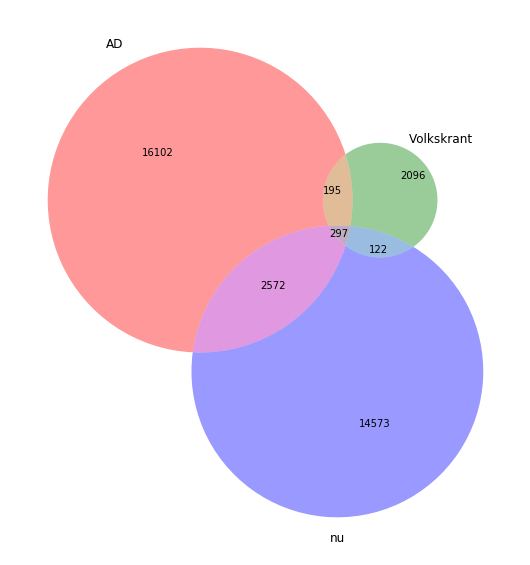

In [22]:
get_venn_from_outlets(df_softcos0_6_outlet)

In [23]:
df_cos0_6 = merge_results_with_articles(op2_gridresults[4]['results'])
df_cos0_6_outlet = reduce_to_field(df_cos0_6, 'doctype')
get_venn_from_outlets(df_cos0_6_outlet)

 76%|███████▋  | 30744/40247 [07:16<02:13, 71.12it/s] 

KeyboardInterrupt: 

In [ ]:
df_softcos0_4 = merge_results_with_articles(op2_gridresults[-2]['results'])
df_softcos0_4_outlet = reduce_to_field(df_softcos0_4, 'doctype')
get_venn_from_outlets(df_softcos0_4_outlet)

### RQ2

in feite al beantwoord door histogram; maar we zouden het nog kunnen opsplitsen per outlet

### RQ3

To compare the content of fully covered news events with AD-only, Volkskrant-only and nu.nl-only news events, we apply an automated method that classifies Dutch news items into four news categories: Politics, Business, Entertainment and Other ([Vermeer, 2018](https://figshare.com/articles/A_supervised_machine_learning_method_to_classify_Dutch-language_news_items/7314896/1)).

In [320]:
def get_fully_covered_events(outlet_df):
    outlets_per_event = outlet_df.apply(lambda x: x.value_counts(), axis=1).fillna(0)
    dichotomized = outlets_per_event.applymap(lambda x: x > 0)
    
    events_fullycovered = set(dichotomized[dichotomized.sum(axis=1)==3].index)
    ad_only = set(dichotomized[(dichotomized['ad (www)'] == 1) & (dichotomized['nu'] == 0) & (dichotomized['volkskrant (www)'] == 0)].index)
    vk_only = set(dichotomized[(dichotomized['ad (www)'] == 0) & (dichotomized['nu'] == 0) & (dichotomized['volkskrant (www)'] == 1)].index)
    nu_only = set(dichotomized[(dichotomized['ad (www)'] == 0) & (dichotomized['nu'] == 1) & (dichotomized['volkskrant (www)'] == 0)].index)
    
    groups = (events_fullycovered, ad_only, vk_only, nu_only)
    
    return groups

def get_topics(text_df, path_to_model):
    clf = joblib.load(path_to_model)
    
    all_text = text_df.values.tolist()
    no_none = []
    for l in all_text:
        for text in l:
            if text != None:
                no_none.append(text)
            
    topic = clf.predict([e for e in no_none])
    unique, counts = np.unique(topic, return_counts=True)
    result = dict(zip(unique, counts/len(topic)*100))
    
    return result

In [321]:
PATH_TO_MODEL = '/home/marieke/news_events/susan_PAclassifier/PassiveAggressive_text_Dutch_news.pkl'

In [322]:
df_softcos06_outlet = reduce_to_field(df_softcos06, 'doctype')
groups = get_fully_covered_events(df_softcos06_outlet)

In [323]:
df_softcos06_text = reduce_to_field(df_softcos06, 'text')

In [324]:
fully_text = df_softcos06_text.iloc[list(groups[0])]
ad_text = df_softcos06_text.iloc[list(groups[1])]
vk_text = df_softcos06_text.iloc[list(groups[2])]
nu_text = df_softcos06_text.iloc[list(groups[3])]

In [325]:
topic_fully = get_topics(fully_text, PATH_TO_MODEL)
topic_ad = get_topics(ad_text, PATH_TO_MODEL)
topic_vk = get_topics(vk_text, PATH_TO_MODEL)
topic_nu = get_topics(nu_text, PATH_TO_MODEL)

In [326]:
topics = pd.DataFrame([topic_fully, topic_ad, topic_vk, topic_nu])
topics

Business  Entertainment       N/A     Other   Politics
0  19.483436  38.686131      0.056148  9.657496  32.116788
1  14.059988  76.287631      0.171869  2.677829  6.802683 
2  24.009324  34.731935      0.046620  3.776224  37.435897
3  20.674362  68.010174      0.130438  4.004435  7.180591

Wat is die N/A hierin...?

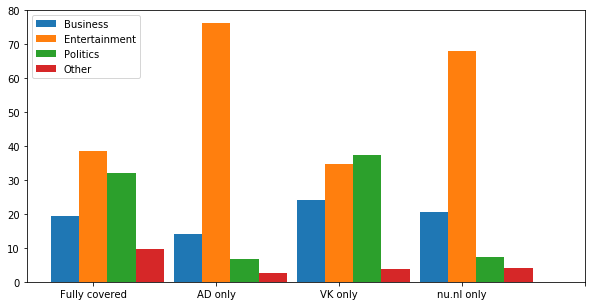

In [327]:

labels = ['Fully covered', 'AD only', 'VK only', 'nu.nl only']
barWidth = 0.23

plt.figure(figsize=(10,5))

r1 = np.arange(len(topics['Business']))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.bar(r1, topics['Business'], width=barWidth, label='Business')
plt.bar(r2, topics['Entertainment'], width=barWidth, label='Entertainment')
plt.bar(r3, topics['Politics'], width=barWidth, label='Politics')
plt.bar(r4, topics['Other'], width=barWidth, label='Other')

plt.xlabel('')
plt.xticks([r + barWidth for r in range(len(topic_fully))], labels)

plt.legend()
plt.show()



# OUDE SCRATCH HIERONDER

In [ ]:
fullycoveredevents = get_fully_covered_events(df_softcos0_4_outlet)
fullycoveredevents

In [ ]:
df_softcos0_4_title = reduce_to_field(df_softcos0_6, 'title')

df_softcos0_4_title.iloc[list(fullycoveredevents)]

Wat kunnen we ervan leren? Bijvoorbeeld dat het geen lokaal nieuws is; verder kan het van alles zijn.


We kunnen hetzelfde doen met andere outlets



### manually evaluate false positives etc

In [98]:
df_softcos0_6_title = reduce_to_field(df_softcos0_6, 'title')

In [99]:
# meer dan 20
df_softcos0_6_title[df_softcos0_6_title.count(axis=1)>20]

0   \
0   De mooiste confrontaties tussen Manchester Cit...   
1   Nog twee Nederlanders om het leven gekomen doo...   
2   Nieuwe strijd op rechts bedreigt stabiliteit v...   
3   Opnieuw waarschuwingen voor gladheid op vrijda...   
4   Giftig poeder uit te water geraakte containers...   
5   Jolanda verzorgt koffiemachines: ‘Ik heb nog n...   
6   Sportief verval van AS Monaco als schrikbeeld ...   
7   De Ligt maakt zich niet druk over alle gerucht...   
8   Weerbericht: Fris lenteweer met behoorlijk vee...   
9   Feyenoord hoopt negatieve primeur te voorkomen...   
10  ‘Het volk gaat dood van de honger, en die kloo...   
11  Volg hier alle tussenstanden in de EK-kwalific...   

                                                   1   \
0   Tussenpaus Solskjaer wil niet meer weg bij United   
1   Nog twee Nederlandse slachtoffers onder doden ...   
2   Forum voor Democratie scoort in alle dorpen en...   
3          Weerbericht: Bewolkt maar overwegend droog   
4            Vlieland stelt rederij MSC aansprakelijk   
5   BN’er Stacey Rookhuizen is al sinds haar zesti...   
6   Janssen en Dier kunnen van lange blessurelijst...   
7          Boegbeeld en gentleman in al zijn facetten   
8   Bye bye warm weer! Het kan flink gaan plenzen:...   
9   Ten Hag baalt dat ADO afspraken niet is nageko...   
10  Veldslag op de grens tussen Venezuela en ­Colo...   
11  Dit zijn alle eindstanden van vanavond in de E...   

                                                   2   \
0   Solskjaer zinspeelt op langer verblijf bij Uni...   
1   Nieuwe explosie bij kerk in Sri Lanka, ontmant...   
2   Van Groningen tot Limburg: dit gaat er verande...   
3   Het gaat weer sneeuwen, vooral in het zuiden v...   
4   Militairen gaan helpen met schoonmaken van Wad...   
5   Vlaamse The Voice-deelnemer is geheugen kwijt ...   
6   Solskjaer ziet Europees succes concurrenten ni...   
7   Van Bronckhorst zal altijd openstaan voor teru...   
8   Weerbericht: Veel bewolking en buien, kans op ...   
9   Feyenoord zonder Van Persie, PSV met vertrouwd...   
10  Twee doden bij grens Venezuela, hulpkonvooien ...   
11  Tussenstanden EK-kwalificatie: Kroatië in de p...   

                                                   3   \
0           Pochettino: Spurs serieuze titelkandidaat   
1   Sri Lanka: Lokale terreurgroep achter aanslage...   
2   Aangeslagen SP moet op zoek naar een nieuw wer...   
3   KNMI geeft code geel af vanwege gladde wegen e...   
4   Rederij is bergingsactie begonnen om verloren ...   
5   Van Barneveld komt terug op besluit om per dir...   
6   Dit zijn de mooiste buitenlandse wedstrijden v...   
7   Klassieker in halve finale KNVB-beker, Willem ...   
8   Onweer en zware windstoten trekken over Nederland   
9   Clasie: 'Doodzonde dat we ons niet hebben belo...   
10  Spanning aan grens Venezuela stijgt, hulpkonvo...   
11  Frankrijk, Portugal en Engeland beginnen vanav...   

                                                   4   \
0   Klopp rekent ook Chelsea en Arsenal nog tot ti...   
1   Dodental aanslagen loopt verder op: veel slach...   
2   Zege Forum nu al van invloed op volgende kabin...   
3   Minder treinen door sneeuwval, gladheid verwac...   
4   Rederij gaat in Noordzee met sonar zoeken naar...   
5   Van Gerwen wist na opkomst al dat hij zou gaan...   
6   Solskjaer verlegt focus bij Manchester United:...   
7   Feyenoord en Ajax treffen elkaar in De Kuip in...   
8   Stralend lenteweer: zondag eerste officiële wa...   
9   Van Beek mist kraker tegen Ajax in KNVB-beker ...   
10  Interim-president: 'Eerste humanitaire hulp is...   
11  De interlands van vrijdag: Frankrijk, Portugal...   

                                                   5   \
0   Alexander-Arnold en Keita weer beschikbaar bij...   
1   ‘Aanslagen Sri Lanka gedaan als wraak voor aan...   
2         Wat u moet weten over de statenverkiezingen   
3   Sneeuwfront trekt over het land, pas op voor g...   
4   Vlieland stelt rederij aansprakelijk voor scha...   

In [100]:
# meer dan 30
df_softcos0_6_title[df_softcos0_6_title.count(axis=1)>30]

0   \
0  De mooiste confrontaties tussen Manchester Cit...   

                                                  1   \
0  Tussenpaus Solskjaer wil niet meer weg bij United   

                                                  2   \
0  Solskjaer zinspeelt op langer verblijf bij Uni...   

                                          3   \
0  Pochettino: Spurs serieuze titelkandidaat   

                                                  4   \
0  Klopp rekent ook Chelsea en Arsenal nog tot ti...   

                                                  5   \
0  Alexander-Arnold en Keita weer beschikbaar bij...   

                                                  6   \
0  Liverpool loopt uit op City, Manchester United...   

                                                  7   \
0  Manchester City heeft Silva terug voor ‘Boxing...   

                                                  8   \
0  Klopp stelt dat voorsprong Liverpool op concur...   

                                                  9   ...  \
0  Manchester City ook onderuit bij Leicester, Li...  ...   

                                 25  \
0  Milner mist kraker tegen Arsenal   

                                                  26  \
0  Klopp moest 'bijna huilen' bij vijfde treffer ...   

                                                  27  \
0  Liverpool kent geen genade met Arsenal en neem...   

                                                  28  \
0  Rangers FC boekt voor het eerst in ruim zes ja...   

                                                  29  \
0  Tottenham Hotspur krijgt op eigen veld forse t...   

                                                  30  \
0  Pijnlijke nederlaag voor Tottenham, Locadia sc...   

                                                  31  \
0  Manchester United wint opnieuw: Pogba schitter...   

                                                  32  \
0  Chelsea steviger op plek vier door benauwde ze...   

                                                  33  \
0  Manchester City herpakt zich met zege in South...   

                                                  34  
0  Manchester City herstelt zich na slechte week ...  

[1 rows x 35 columns]

In [154]:
df['numberofarticles'] = df.apply(lambda x: sum(x.notna()), axis=1)
# same as:
# df['numberofarticles']  = df.count(axis=1)

In [155]:
df.query('numberofarticles>10')

0  \
0                         https://www.nu.nl/-/5856270/   
1                         https://www.nu.nl/-/5717091/   
2                                              1f5b6c7   
3    https://www.ad.nl/buitenlands-voetbal/spurs-ze...   
4    https://www.ad.nl/europees-voetbal/ajax-speelt...   
5    https://www.ad.nl/binnenland/giftig-poeder-uit...   
6                         https://www.nu.nl/-/5758533/   
7    https://www.ad.nl/ad-werkt/jolanda-verzorgt-ko...   
8                         https://www.nu.nl/-/5704145/   
9                         https://www.nu.nl/-/5819364/   
10                        https://www.nu.nl/-/5819595/   
11   https://www.ad.nl/europees-voetbal/volg-hier-a...   
12   https://www.ad.nl/europees-voetbal/sportief-ve...   
13                        https://www.nu.nl/-/5645069/   
14                        https://www.nu.nl/-/5704190/   
15                                             0946447   
16   https://www.ad.nl/buitenland/twee-doden-bij-gr...   
17                        https://www.nu.nl/-/5645951/   
18   https://www.ad.nl/binnenland/het-lenteweer-kom...   
19                        https://www.nu.nl/-/5847756/   
20                        https://www.nu.nl/-/5643542/   
21                                            a563f03b   
22   https://www.ad.nl/binnenland/ik-ben-geen-vreem...   
23                        https://www.nu.nl/-/5734143/   
24   https://www.ad.nl/buitenland/168-doden-en-745-...   
25   https://www.ad.nl/buitenlands-voetbal/boca-coa...   
26                        https://www.nu.nl/-/5849097/   
27                        https://www.nu.nl/-/5829078/   
28   https://www.ad.nl/nederlands-voetbal/de-strijd...   
29                        https://www.nu.nl/-/5607083/   
..                                                 ...   
103  https://www.ad.nl/binnenland/die-overhoring-ka...   
104                       https://www.nu.nl/-/5840277/   
105  https://www.ad.nl/schaatsen/jorrit-bergsma-van...   
106  https://www.ad.nl/andere-sporten/aanvoerster-g...   
107  https://www.ad.nl/koken-en-eten/wat-eten-we-va...   
108                                            5a83c40   
109  https://www.ad.nl/show/asjemenou-radio-2-dj-s-...   
110  https://www.ad.nl/binnenland/morgen-code-geel-...   
111  https://www.ad.nl/tennis/federer-plaatst-zich-...   
112  https://www.ad.nl/nederlands-voetbal/fc-twente...   
113                       https://www.nu.nl/-/5769069/   
114                       https://www.nu.nl/-/5600087/   
115                       https://www.nu.nl/-/5852676/   
116                       https://www.nu.nl/-/5692820/   
117  https://www.ad.nl/show/philip-freriks-krijgt-l...   
118                       https://www.nu.nl/-/5798715/   
119  https://www.ad.nl/buitenlands-voetbal/sensatie...   
120                       https://www.nu.nl/-/5707368/   
121                       https://www.nu.nl/-/5629460/   
122                                            626a86c   
123  https://www.ad.nl/wielrennen/roglic-verslaat-d...   
124                       https://www.nu.nl/-/5637146/   
125  https://www.ad.nl/buitenland/terreuraanslag-in...   
126                       https://www.nu.nl/-/5828391/   
127                                            4a6b599   
128  https://www.ad.nl/formule-1/ricciardo-en-hulke...   
129                       https://www.nu.nl/-/5905050/   
130  https://www.ad.nl/binnenland/tijdens-school-na...   
131                       https://www.nu.nl/-/5605934/   
132  https://www.ad.nl/darts/ahoy-maakt-zich-op-voo...   

                                                     1  \
0                                              ec8ead0   
1                         https://www.nu.nl/-/5715381/   
2                                              1c8c51c   
3    https://www.ad.nl/buitenlands-voetbal/aubameya...   
4    https://www.ad.nl/nederlands-voetbal/duel-tuss...   
5    https://www.ad.nl/binnenland/vlieland-stelt-re...   
6                         https://www.nu.nl/-/5759

In [137]:
# articles.query('_id=="{}"'.format('https://www.ad.nl/binnenland/doodgeschoten-humeyra-16-wilde-vluchten-naar-turkije~a8e5014d/'))

In [156]:
def results_to_titles(results):
    results_titles = [[articles.query('_id=="{}"'.format(art))['title'].to_list()[0] for art in event] for event in tqdm(results)]
    return(results_titles)


In [157]:
softcosine_results_titles = results_to_titles(op2_gridresults[-1]['results'])


  4%|▍         | 1409/35958 [00:34<09:06, 63.19it/s]


 13%|█▎        | 4511/35958 [01:06<05:22, 97.53it/s] 


 19%|█▉        | 6967/35958 [01:21<02:09, 223.17it/s]


 38%|███▊      | 13751/35958 [01:51<01:36, 230.58it/s]


 57%|█████▋    | 20382/35958 [02:20<01:12, 215.99it/s]


 75%|███████▌  | 27027/35958 [02:49<00:38, 231.76it/s]


 94%|█████████▎| 33705/35958 [03:19<00:09, 231.73it/s]


100%|██████████| 35958/35958 [03:30<00:00, 170.88it/s]

In [162]:
df_titles = pd.DataFrame(softcosine_results_titles)

In [163]:
df_titles['numberofarticles'] = df_titles.apply(lambda x: sum(x.notna()), axis=1)

In [164]:
df_titles.query('numberofarticles<=3')[[0,1,2]]

0  \
687    Ben Ferencz (99), de aanklager die geen tijd h...   
730    Samir A. en Bilal L. proberen nu kinderen van ...   
753             Humeyra werd steeds stiller en doodsbang   
754    Blendles Rick Pastoor over productiviteit: 'Ge...   
755    AC Milan gaat vol voor Danjuma Groeneveld, Spu...   
756    'Fulham huurt Babel voor rest van seizoen van ...   
757     Paris Saint-Germain rekent na rust af met Amiens   
758    President Trump woedend over strafrechtelijk o...   
759    Washington Post: Trump hield details over ontm...   
760    Dijkhoff (VVD): klimaatbeleid kan leiden tot v...   
761    Schulting met overmacht naar finale 1.500 mete...   
762    Deze drie taartenbakkers maken van hun baksels...   
763    Zeker negentien doden door instorten kolenmijn...   
764    Zwarte luipaard voor het eerst in honderd jaar...   
765    Engelse keeperslegende Gordon Banks (81) overl...   
766    Rutte nodigt 'klimaatspijbelaars' uit voor twe...   
767    Intertoys, de grootste speelgoedketen van Nede...   
768    Syrische ex van Nederlandse journaliste zou bi...   
769    Turkije vaardigt arrestatiebevelen uit tegen r...   
770    Rutte wil een ‘streetwise’ Europa om belangen ...   
771    NASA doet ultieme poging om contact met versto...   
772    Hond loopt weg in Leidsche Rijn en stapt op tr...   
773    Trump roept noodtoestand uit om muur op grens ...   
774               Airbus zet streep door superjumbo A380   
775    Mandy Moore beschuldigt ex Ryan Adams van misb...   
776    UEFA opent onderzoek naar gele kaart Sergio Ramos   
777    Ex-manager Britney Spears mag nu ook geen cont...   
778    Gezichtsherkenning op 38 procent van de smartp...   
779    6 procent van de Nederlanders gebruiken het in...   
780    Webwinkels van Tom Coronel vragen faillissemen...   
...                                                  ...   
35928  Broodkliko's in West geïnstalleerd tegen ratte...   
35929  De Notenkraker in Schouwburg De Domijnen in Si...   
35930                  Het Foute Kerstfeest - Vlissingen   
35931                 Scrooge, de kerstmusical - Alkmaar   
35932              COC keert terug naar pand Rozenstraat   
35933  David Lynch expositie in Bonnefantenmuseum - M...   
35934  Microsoft levert honderdduizend HoloLens-heads...   
35935               Storytelling bij MEZRAB in Amsterdam   
35936                            Stadswandeling - Kampen   
35937                                 Santa Run - Kampen   
35938  Rijkswaterstaat: Recordaantal boetes voor nege...   
35939  Biografie over schrijfster Pippi Langkous had ...   
35940  'Russische hackersgroep valt Duitse overheid o...   
35941  Kind verklapt hennepkwekerij op de opvang: ‘Pa...   
35942  Amerikaanse gevangenen persen soldaten af met ...   
35943       Het bizarre verhaal van Syriëganger Laura H.   
35944  Mysterieuze schokgolven lieten onze planeet ri...   
35945  Dit is de gemakkelijkste manier om een knofloo...   
35946     Gebroeders Ingebrigtsen op EK cross in Tilburg   
35947               Zuid-Koreaan breekt nek na harde val   
35948           Aantal jongeren gaat met 100.000 afnemen   
35949  Chef Lege Dozen bestaat echt en lijkt nu schat...   
35950  Taylor Swift met slechts dertien tweets toch i...   
35951  'Gerard Butler in Dominicaans ziekenhuis na he...   
35952  Zo werd Barbara kapitein van 56 meter lange vr...   
35953  Argentinië wil verder met interim-bondscoach S...   
35954        Stybar ruilt weg weer even in voor het veld   
35955                Reggaemuziek op erfgoedlijst UNESCO   
35956  Aanslagen Sri Lanka passen in trend van religi...   
35957  Eindhoven hangt vlag halfstok voor slachtoffer...   

                                                       1  \
687                                                  NaN   
730                                                  NaN   
753    Bekir E. loofde zelfs een beloning uit voor ie...   
754    ‘Mijn collega werkt minder uren maar verdient ...   
755    Kiev meldt zich voor Sol, A

In [166]:
# ok, dit werkt dus supergoed. maar wat met de supergrote clusters?
df_titles.query('numberofarticles>10')

0  \
0    Nog twee Nederlanders om het leven gekomen doo...   
1    Opnieuw waarschuwingen voor gladheid op vrijda...   
2    Nieuwe strijd op rechts bedreigt stabiliteit v...   
3    Spurs zet Everton compleet voor schut op Goodi...   
4    Ajax speelt in halve finales eerst uit bij Cit...   
5    Giftig poeder uit te water geraakte containers...   
6    Feyenoord hoopt negatieve primeur te voorkomen...   
7    Jolanda verzorgt koffiemachines: ‘Ik heb nog n...   
8    De Ligt maakt zich niet druk over alle gerucht...   
9    Schlemiel Schwaab voelt zich schuldig over ver...   
10   Weerbericht: Fris lenteweer met behoorlijk vee...   
11   Volg hier alle tussenstanden in de EK-kwalific...   
12   Sportief verval van AS Monaco als schrikbeeld ...   
13   Clasie en Berghuis twijfelgevallen bij Feyenoo...   
14   Verenigde Staten adviseren burgers te vertrekk...   
15   Dit is de balans na ‘de bijna-crisis’ waarin R...   
16   Twee doden bij grens Venezuela, hulpkonvooien ...   
17   'Britse politie heeft verdachten van drones bi...   
18   Het lenteweer komt er nu echt aan (en met wat ...   
19       Weerbericht: zon en wolken wisselen elkaar af   
20   Weerbericht: Buien blijven aanhouden, stevige ...   
21   Ministers verdedigen Nederlands belang in ‘int...   
22   ‘Ik ben geen vreemdganger, maar deze verliefdh...   
23   Feyenoord boekt eenvoudige zege op De Graafsch...   
24    168 doden en 745 gewonden door tsunami Indonesië   
25   Boca-coach: Schade voor het Argentijnse voetba...   
26   Fenomenale Van der Poel boekt in Brabantse Pij...   
27   VN-leider Guterres na bezoek aan Libië 'erg be...   
28   De strijd onderin: wie ontsnapt aan play-offs ...   
29   Klopp verontschuldigt zich voor vreugdeuitbars...   
..                                                 ...   
72   Soedanese president Bashir zou zijn afgetreden...   
73   Dumoulin: '2019 moeilijk jaar om alles op de T...   
74   Hooggeplaatste Medvedev zonder setverlies naar...   
75   Van Bommel ziet vele blessures bij Barcelona n...   
76   Antoinette de Jong schrok van snelle 500 meter...   
77   Boca en River Plate willen finale Copa Liberta...   
78   Djokovic met speels gemak naar finale Australi...   
79   Weerbericht: Regenachtige dag, temperatuur 's ...   
80   Anderlecht krijgt ‘nee’ van Cocu, PEC haalt ee...   
81   Weerbericht: Zachte droge dag en overwegend be...   
82   Wöber verwacht bij Sevilla grote kans te hebbe...   
83   Derby tussen Tottenham en Arsenal onbeslist na...   
84         Winnende Bucks zien Antetokounmpo uitvallen   
85   Feyenoord ook in uitwedstrijd tegen VVV waarsc...   
86   Klassement voorbij voor Dumoulin – heeft verde...   
87   Bertens denkt dat ze in staat is Australian Op...   
88   Spanjaard Barreda wint eerste etappe Dakar Ral...   
89   ManUnited houdt zicht op plek drie, Huddersfie...   
90   Rechter zet borg voor zanger R. Kelly op 1 mil...   
91   ‘Bibi’ Netanyahu gaat voor een historische nie...   
92   Honderd ideeën voor een bedrijf, maar welke ki...   
93   Huntelaar: 'Met juiste plan en strijd is heel ...   
94   Project X-feest Brabant: vier aanhoudingen in ...   
95   PEC spant arbitragezaak aan na verplaatsing ui...   
96   ‘Toen ik in loondienst kwam, kreeg ik er 250 e...   
98   Minister Blok wil uitstel brexit: ‘No deal moe...   
99     Wat Eten We Vandaag: Vistaco’s met salsa picada   
100  Na flink aantal evacuaties vaart Noors cruises...   
101  VS vragen om uitlevering gearresteerde Julian ...   
102  Moniz schaamt zich voor verlies Excelsior en v...   

                                                     1  \
0    Nog twee Nederlandse slachtoffers onder doden ...   
1           Weerbericht: Bewolkt maar overwegend droog   
2    Forum voor Democratie scoort in alle dorpen en...   
3     Aubameyang helpt Arsenal aan zwaarbevochten zege   
4    Duel tussen Ajax en De Graafschap mogelijk naa...   
5             Vlieland stelt rederij MSC aansprakelijk   
6    Ten Hag baalt dat ADO afspraken niet is nagek

In [ ]:
df_titles.query('numberofarticles<=3')[[0,1,2]]

In [29]:
def results_to_pubdate(results):
    results_titles = [[articles.query('_id=="{}"'.format(art))['publication_date'].to_list()[0] for art in event] for event in tqdm(results)]
    return(results_titles)


In [30]:
softcosine_results_pubdate = results_to_pubdate(gridresults[5]['results'])


  8%|▊         | 6257/76911 [00:40<05:17, 222.30it/s]


 17%|█▋        | 12834/76911 [01:21<04:48, 222.03it/s]


 24%|██▍       | 18603/76911 [02:01<05:03, 191.91it/s]


 33%|███▎      | 25125/76911 [02:40<04:29, 192.06it/s]


 41%|████      | 31513/76911 [03:20<03:06, 243.71it/s]


 50%|████▉     | 38320/76911 [03:59<02:37, 245.32it/s]


 59%|█████▉    | 45186/76911 [04:38<06:17, 84.10it/s] 


 67%|██████▋   | 51372/76911 [05:17<01:44, 245.49it/s]


 76%|███████▌  | 58070/76911 [05:56<01:48, 174.22it/s]


 84%|████████▍ | 64780/76911 [06:34<01:35, 127.51it/s]


 93%|█████████▎| 71392/76911 [07:13<00:23, 232.79it/s]


100%|██████████| 76911/76911 [07:44<00:00, 165.49it/s]

In [34]:
df_pubdates = pd.DataFrame(softcosine_results_pubdate)
df_pubdates['numberofarticles'] = df_pubdates.apply(lambda x: sum(x.notna()), axis=1)

In [64]:
df_pubdates.query('numberofarticles>50').apply(pd.to_datetime).max(axis=1)

2593    2018-12-24 22:00:44
4402    2019-04-19 20:14:18
7463    2019-02-26 23:41:47
11801   2018-12-03 23:35:14
12403   2019-03-05 23:11:42
12404   2019-03-05 22:00:40
14722   2018-12-25 22:03:13
15191   2019-04-01 17:47:37
15858   2018-12-10 16:14:36
17782   2019-02-11 21:13:12
20047   2018-12-16 22:14:19
22929   2018-12-18 22:05:36
23544   2019-04-08 22:47:00
28410   2018-11-29 22:12:21
29510   2018-12-30 23:17:00
38495   2019-03-06 22:04:36
48428   2019-02-17 21:02:44
49683   2018-12-31 22:00:58
51845   2018-12-17 21:37:38
51846   2018-12-17 19:40:57
54504   2019-04-17 21:58:05
60066   2018-12-23 22:02:53
64676   2019-03-28 23:09:39
69980   2019-04-18 21:06:39
72718   2019-04-15 21:12:22
76284   2018-12-02 22:06:18
dtype: datetime64[ns]

In [94]:
x = df_pubdates.query('numberofarticles>50').drop('numberofarticles',axis=1).apply(pd.to_datetime).max(axis=1)
y = df_pubdates.query('numberofarticles>50').drop('numberofarticles',axis=1).apply(pd.to_datetime).min(axis=1)

x-y

2593    3 days 21:00:44
4402    2 days 17:08:01
7463    3 days 10:05:31
11801   3 days 18:35:03
12403   3 days 12:58:54
12404   3 days 15:54:40
14722   3 days 17:03:13
15191   3 days 16:40:38
15858   3 days 13:31:36
17782   3 days 16:08:24
20047   3 days 17:14:19
22929   3 days 14:47:36
23544   3 days 16:35:44
28410   2 days 20:04:13
29510   3 days 17:39:07
38495   2 days 15:57:18
48428   3 days 17:01:55
49683   3 days 16:00:14
51845   3 days 16:35:43
51846   3 days 12:26:57
54504   2 days 17:14:37
60066   3 days 21:44:53
64676   2 days 17:09:05
69980   2 days 16:18:27
72718   3 days 16:13:41
76284   3 days 15:12:17
dtype: timedelta64[ns]

### Import Infomap
Infomap includes an `examples/python` folder with some examples, including this notebook. Run `make` in that directory to build the python interface to a local folder.

The `infomap` package exposes two classes, `Infomap` and `MemInfomap`, that wraps an input `network`, an output `tree`, and a `run` method to run Infomap on the input network. The classes takes a string of [options](http://www.mapequation.org/code.html#Options) as input.

In [ ]:
import infomap
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from glob import glob
from tqdm import tqdm
%matplotlib inline

In [ ]:
def findCommunities(G):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """

    #infomapWrapper = infomap.Infomap("--two-level --silent")  # even testen zonder two-level
    infomapWrapper = infomap.Infomap(" --silent")
    
    network = infomapWrapper.network()

    print("Building Infomap network from a NetworkX graph...")
    for e in G.edges(data=True):
        network.addLink(e[0],e[1],e[2]['weight'])

    print("Find communities with Infomap...")
    infomapWrapper.run();

    #tree = network.tree

    # print("Found %d modules with codelength: %f" % (tree.numTopModules(), tree.codelength()))

    print("Found {} modules with codelength: {}".format(infomapWrapper.numTopModules(), infomapWrapper.codelength()))

    print("Result")
    print("\n#node module")
 
    communities = {}
    for node in infomapWrapper.iterTree():
        if node.isLeaf():
            print("{} {}".format(node.physicalId, node.moduleIndex()))
    
        communities[node.physicalId] = node.moduleIndex()

    nx.set_node_attributes(G, name='community', values=communities)
    return G

In [ ]:
def drawNetwork(G):
    # position map
    pos = nx.spring_layout(G)
    # community ids
    communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
    numCommunities = max(communities) + 1
    # color map from http://colorbrewer2.org/
    cmapLight = colors.ListedColormap(['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6'], 'indexed', numCommunities)
    cmapDark = colors.ListedColormap(['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a'], 'indexed', numCommunities)

    # Draw edges
    nx.draw_networkx_edges(G, pos)

    # Draw nodes
    nodeCollection = nx.draw_networkx_nodes(G,
        pos = pos,
        node_color = communities,
        cmap = cmapLight
    )
    # Set node border color to the darker shade
    darkColors = [cmapDark(v) for v in communities]
    nodeCollection.set_edgecolor(darkColors)

    # Draw node labels
    for n in G.nodes():
        plt.annotate(n,
            xy = pos[n],
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'center',
            xytext = [0, 0],
            color = cmapDark(communities[n])
        )

    plt.axis('off')
    # plt.savefig("karate.png")
    plt.show()

In [ ]:
files = glob('../../data/intermediate/*.net')
print('There are {} files'.format(len(files)))

In [ ]:
with open(files[0]) as f:
    test = f.read()

In [ ]:
G = nx.read_pajek(files[0])

Gint = nx.convert_node_labels_to_integers(G)

In [ ]:
# we hebben kennelijk ook self loops opgeslagen (similarity van elk artikel met zichzelf = 1), weg ermee

In [ ]:
len(G.edges)

In [ ]:
G.remove_edges_from(list(G.selfloop_edges()))

In [ ]:
len(G.edges)

In [ ]:
list(G.selfloop_edges())

In [ ]:
insignificant_edges = ([(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] < 0.6])
G.remove_edges_from(insignificant_edges)

In [ ]:
len(G.edges)

In [ ]:
H = findCommunities(Gint)

drawNetwork(H)

In [ ]:
print([(u,v,d) for (u,v,d) in G.edges(data=True) if d['weight'] >= 0.99])

In [ ]:
for e in G.edges(data=True):
    print(*e)

In [ ]:
nx.read_pajek?

In [ ]:
G_recoveredlabels = nx.relabel_nodes(Gint, dict(zip(Gint,G)))

In [ ]:
nx.draw(G, with_labels=True)

In [ ]:
H_labeled = nx.relabel_nodes(H, dict(zip(H,G)))

In [ ]:
nx.draw(H_labeled, with_labels=True)

In [ ]:

elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0.5]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=0.5]

pos=nx.spring_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,node_size=700)

# edges
nx.draw_networkx_edges(G,pos,edgelist=elarge,
                    width=6)
nx.draw_networkx_edges(G,pos,edgelist=esmall,
                    width=6,alpha=0.5,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')

plt.show()

In [ ]:
G.edges(data=True)

## Leiden Algorithm testen
https://github.com/vtraag/leidenalg

In [ ]:
import leidenalg
import igraph as ig

In [ ]:
Gig = ig.read(files[0], format='pajek')

In [ ]:
len(Gig.get_edgelist())

In [ ]:
Gig.es.select(weight_le=0.5).delete()

In [ ]:
len(Gig.get_edgelist())

In [ ]:
part = leidenalg.find_partition(Gig, leidenalg.ModularityVertexPartition);

In [ ]:
part.summary()

In [ ]:
ig.plot(part)

In [ ]:
part.membership

In [ ]:
sg1 = part.subgraphs()[5]

In [ ]:
for node in sg1.vs:
    print(node['id'])

In [ ]:
sg2 = part.subgraphs()[0]

In [ ]:
for node in sg2.vs:
    print(node['id'])

In [ ]:
for node in part.giant().vs:
    print(node['id'])

In [ ]:
for i, subgraph in enumerate(part.subgraphs()):
    print('\n\n\n',i,'\n')
    for node in subgraph.vs:
        print(node['id'])

**HAHAHHAA HET WERKT!!!! (als je van tevoren insignificant edges verwijdert)**

In [ ]:
for r in results[4]:
    print(r)

ALLEMAAL SERENA WILLIAMS IN HET VOORBEELD HIERBOVEN!!!

In [ ]:
groteclusters = [r for r in results if len(r)> 5]
len(groteclusters)


In [ ]:
for r in groteclusters[40]:
    print(r)

conclusie: zelfs met een edgeweight van .3 werkt het goed!! (misschien zelfs beter)
dit zijn tenslotte allemaal artikelen nav aanslag telegraafgebouw

In [ ]:
losseartikelen = [r for r in results if len(r) == 1]

print('Er zijn {} losse artikelen, dat is {} percent'.format(len(losseartikelen), 100 * len(losseartikelen)/
                                                             len([artikel for partition in results for artikel in partition])))


In [ ]:
alleen_nu = len([e for e in losseartikelen if e[0].find('www.nu.nl')>-1])
alleen_ad = len([e for e in losseartikelen if e[0].find('www.ad.nl')>-1])
alleen_vk = len(losseartikelen) - (alleen_nu + alleen_ad)

In [ ]:
print('Losse artikelen:')
print('nu\t{}\nad\t{}\nvk\t{}'.format(alleen_nu, alleen_ad, alleen_vk))

In [ ]:
print(losseartikelen[7700][0])

wat voor artikelen zijn dit?  het lijkt erop dat het idd special interest is (regionaal nieuws bij ad, economie van nu etc

In [ ]:
nu_present = []
ad_present = []
vk_present = []
for partition in results:
    nu_present.append(int(max([artikel.find('www.nu.nl')>-1 for artikel in partition])>0)) 
    ad_present.append(int(max([artikel.find('www.ad.nl')>-1 for artikel in partition])>0)) 
    vk_present.append(int(max([len(artikel)<10 for artikel in partition])>0)) 
df = pd.DataFrame({'nu':nu_present, 'ad':ad_present,'vk':vk_present})
df

In [ ]:
df.describe()

en als we alleen naar grote clusters kijken dan hebben ze het allemaal (vk niet helemaal):

In [ ]:
nu_present = []
ad_present = []
vk_present = []
for partition in groteclusters:
    nu_present.append(int(max([artikel.find('www.nu.nl')>-1 for artikel in partition])>0)) 
    ad_present.append(int(max([artikel.find('www.ad.nl')>-1 for artikel in partition])>0)) 
    vk_present.append(int(max([len(artikel)<10 for artikel in partition])>0)) 
df = pd.DataFrame({'nu':nu_present, 'ad':ad_present,'vk':vk_present})
df.describe()

In [ ]:
part = leidenalg.find_partition(Gig, leidenalg.ModularityVertexPartition)
part.summary()

In [ ]:
for i, subgraph in enumerate(part.subgraphs()):
    print('\n\n\n',i,'\n')
    for node in subgraph.vs:
        print(node['id'])

In [ ]:
subgraph.vs[0]

#  terug naar de basics

In [ ]:
import pandas as pd
import pickle

In [ ]:
files = glob('../../data/raw-private/softcosine_output/*.pkl')
print('There are {} files'.format(len(files)))

In [ ]:
df = pickle.load(open(files[0], mode= 'rb'))

In [ ]:
# remove self-loops

df = df[df['source'] != df['target']]

In [ ]:
df.query('similarity>0.7 & source_doctype !=target_doctype')

In [ ]:
df.query('similarity>0.5 & source_doctype !=target_doctype').source_doctype.value_counts()

In [ ]:
df.query('similarity>0.5 & source_doctype !=target_doctype').target_doctype.value_counts()

In [ ]:
i = 43011
print(df.loc[i].source, '\n', df.loc[i].target)

In [ ]:
df.loc[i]

In [ ]:
df.

# DIT WERKT! WAT NOU ALS...

we gewoon alle self loops EN alle edges met <.5 verwijderen?